In [1]:
!pip install scikit-optimize

In [2]:
!pip install catboost

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

import statsmodels.stats.api as sms
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Functions

In [5]:
from sklearn import metrics

def mae(y_gt, Y_pr):
    return metrics.mean_absolute_error(y_gt, Y_pr)

def mse(y_gt, Y_pr):
    return metrics.mean_squared_error(y_gt, Y_pr)

def rmse(y_gt, Y_pr):
    my_mse = mse(y_gt, Y_pr)
    return np.sqrt(my_mse)

def medae(y_gt, Y_pr):
    return metrics.median_absolute_error(y_gt, Y_pr)

def R2(y_gt, Y_pr):
    return metrics.r2_score(y_gt, Y_pr)

def calc_metrics(true, pred):

    mse1 = mse(true, pred)

    rmse1 = rmse(true, pred)

    mae1 = mae(true, pred)

    medae1 = medae(true, pred)

    R21 = R2(true, pred)

    print('*** VAL **: ')
    print("MSE:   {}\nRMSE:  {}\nR2:    {}\nMAE:   {}\nMedAE: {}".format(mse1, rmse1, R21, mae1, medae1))
    print('-'*30)

In [6]:
def target_distr_linear(train_label, test_label, predicted_dv): 
    sns.kdeplot(train_label, label='train')
    sns.kdeplot(test_label, label='test')
    sns.kdeplot(predicted_dv, label='pred')
    plt.legend()
    plt.show()

    sns.scatterplot(test_label, predicted_dv, color='blueviolet')
    plt.title('Linear model')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.show()

In [7]:
from scipy.stats import norm

def draw_histogram(data):
    f,ax_hist = plt.subplots(1)
    sns.distplot(data, hist=True,  kde=True, rug=True, bins=10, fit=norm, ax=ax_hist);
    plt.xlabel("values")
    plt.title("Distribution") 

    mean=data.mean()

    ax_hist.axvline(mean, color='r', linestyle='--', label=f"Mean={mean:.3f}")
    ax_hist.legend()

    plt.show()

In [8]:
def draw_res_analys(errors, pred):
    sns.scatterplot(list(range(len(errors))),errors);
    plt.title("Distibution of errors")
    plt.ylabel('Error');
    plt.xlabel('Index');
    plt.show();

    sns.scatterplot(pred,errors);
    plt.title('Relationship of true value vs error (resudual analysis)')
    plt.ylabel('Error');
    plt.xlabel('True value');
    plt.show();

In [9]:
def get_feature_imp(model, X_train):
    imp = model.get_feature_importance(data=X_train)[:20]
    print(f'IMP: {imp}')
    fig, axes = plt.subplots(1, 1, figsize=(12, 8))
    axes.barh(width=imp, y=model.feature_names_[:20])
    axes.set_title('Finetuned Catboost feature importance')
    plt.show()

# Unhashing

In [1]:
import pickle

with open('./dataset_FOREIGN_kws_oscr_PCA.pkl', 'rb') as f:
    df = pickle.load(f, encoding='utf-8')

In [ ]:
df.to_csv('./dataset_FOREIGN_kws_oscr_PCA.csv')

# Preprocessing

1. Multiple value categorical features: tops' tf-idf
    * actor: top 5
    * country: 1st
    * genre: top 3
    * director: 1st 
2. Just categorical 
    * type: ohe
    * release year: periods: 1918-1969, 1970-1979, 1980-1989, ... с 2000 по годам
3. Numeric and categorical ordered
    * age_access: scale
    * avg_rating: knn-imputer, scale
    * duration: scale
4. textual
    * name: catboost.text
5. target:
    * log
    
## Multiple value categorical features: tops' tf-idf

### filter by year

In [11]:
df.shape

(8784, 33867)

In [12]:
d = df[df['release_year'] >= 2000]

In [13]:
d.shape

(6773, 33867)

In [14]:
d.isna().sum()[:30]

age_access_type       0
name                  0
director              0
genre                 0
average_rating      321
type                  0
country               0
release_type          0
release_year          0
duration              0
actor                 0
element_uid           0
ACTOR               102
COMPOSER            865
DESIGN              880
DIRECTOR             94
EDITOR              818
OPERATOR           1004
PRODUCER            275
WRITER              224
BUDGET             4408
MARKETING          6551
RUS                3819
USA                4001
WORLD              2756
element_id            0
rating                0
джек                  0
расследовать          0
подруга               0
dtype: int64

In [15]:
d.columns[:30]

Index(['age_access_type', 'name', 'director', 'genre', 'average_rating',
       'type', 'country', 'release_type', 'release_year', 'duration', 'actor',
       'element_uid', 'ACTOR', 'COMPOSER', 'DESIGN', 'DIRECTOR', 'EDITOR',
       'OPERATOR', 'PRODUCER', 'WRITER', 'BUDGET', 'MARKETING', 'RUS', 'USA',
       'WORLD', 'element_id', 'rating', 'джек', 'расследовать', 'подруга'],
      dtype='object')

In [16]:
d.drop(['director', 'average_rating', 'release_type', 'actor', 'element_id'], axis=1, inplace=True)

In [17]:
mltpl_cat_features = ['ACTOR', 'COMPOSER', 'DESIGN', 'DIRECTOR', 'EDITOR',
       'OPERATOR', 'PRODUCER', 'WRITER', 'country', 'genre']
num_features = [ 'duration']
cat_features = ['age_access_type']
skewed_num_features = ['duration', 'BUDGET', 'MARKETING', 'RUS', 'WORLD']
mltpl_cat_n_top = {'ACTOR': 10, 'country': 1, 'DIRECTOR': 1, 
                   'EDITOR': 1, 'OPERATOR': 1, 'PRODUCER': 5, 'WRITER': 2,
                   'DESIGN': 3, 'COMPOSER': 1, 'genre': 3}

In [18]:
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
# from spacy.tokenizer import Tokenizer
# from spacy.lang.en import English
# nlp = English()
import pandas as pd

class Preprocesser:
    def __init__(self, 
                mulpiple_cat_features: list,
                skewed_num_features: list,
               # text_features: list,
               # release_year_feature: str,
                mltpl_cat_n_top: dict):
        self.mulpiple_cat_features = mulpiple_cat_features
        self.skewed_num_features = skewed_num_features
        #self.text_features = text_features
        self.mltpl_cat_n_top = mltpl_cat_n_top
       # self.release_year_feature = release_year_feature
        # self.tokenizer = Tokenizer(nlp.vocab)
        
    def __get_top_n_mltpl_cat_features(self, df_pr, col):
        all_cats = []
        for element_values in df_pr[col]:
            all_cats.extend(element_values)
        return Counter(all_cats).most_common(self.mltpl_cat_n_top[col])
            
    def __preprocess_mulpiple_cat_features(self, df_pr):
        for col in self.mulpiple_cat_features:
            feature_number = self.mltpl_cat_n_top[col]
            df_pr[[f'{col}_{i}' for i in range(feature_number)]] = pd.DataFrame(np.full((len(df), feature_number), np.nan))
            for i in df_pr.index:
                names = df_pr.loc[i, col]
                if isinstance(names, float):
                    names = ['Na']
                for k, name in enumerate(names[:int(feature_number)]):
                    df_pr.loc[i, f'{col}_{k}'] = name
            df_pr.drop(col, axis=1, inplace=True)

        return df_pr
    
    def __preprocess_skewed_num_features(self, df_pr):
        for col in self.skewed_num_features:
            df_pr[col] = df_pr[col].apply(lambda x: np.log1p(x))
        return df_pr
    
    def __preprocess_text_features(self, df_pr):
        for col in self.text_features:
            df_pr[col] = df_pr[col].apply(lambda x: self.tokenizer(x))
        return df_pr
            
    def preprocess(self,
                   df: pd.DataFrame):
        df_pr = df.copy()
        df_pr = self.__preprocess_mulpiple_cat_features(df_pr)
        df_pr = self.__preprocess_skewed_num_features(df_pr)
        # df_pr = self.__preprocess_text_features(df_pr)
        
        return df_pr
        

In [19]:
preprocesser = Preprocesser(mltpl_cat_features,
            skewed_num_features,
            #text_features,
            mltpl_cat_n_top)

In [20]:
df_pr = preprocesser.preprocess(d)

In [21]:
df_pr.shape

(6773, 33880)

In [22]:
df_pr.isnull().sum()

age_access_type       0
name                  0
type                  0
release_year          0
duration              0
                   ... 
WRITER_1           2256
country_0             0
genre_0               0
genre_1            1747
genre_2            4069
Length: 33880, dtype: int64

In [23]:
df_pr.columns

Index(['age_access_type', 'name', 'type', 'release_year', 'duration',
       'element_uid', 'BUDGET', 'MARKETING', 'RUS', 'USA',
       ...
       'PRODUCER_1', 'PRODUCER_2', 'PRODUCER_3', 'PRODUCER_4', 'WRITER_0',
       'WRITER_1', 'country_0', 'genre_0', 'genre_1', 'genre_2'],
      dtype='object', length=33880)

In [24]:
df_pr.rename({'ACTOR_0': 'actor_0','ACTOR_1' : 'actor_1', 'ACTOR_2': 'actor_2', 'ACTOR_3':'actor_3',
       'ACTOR_4': 'actor_4', 'ACTOR_5': 'actor_5', 'ACTOR_6': 'actor_6', 'ACTOR_7':'actor_7',
              'ACTOR_8':'actor_8', 'ACTOR_9':'actor_9',
       'COMPOSER_0': 'composer_0', 'DESIGN_0': 'design_0', 'DESIGN_1': 'design_1', 'DESIGN_2': 'design_2',
              'DIRECTOR_0': 'director_0',
       'EDITOR_0': 'editor_0', 'OPERATOR_0': 'operator_0', 'PRODUCER_0': 'producer_0',
              'PRODUCER_1':  'producer_1', 'PRODUCER_2':  'producer_2',
       'PRODUCER_3':  'producer_3', 'PRODUCER_4': 'producer_4', 'WRITER_0':'writer_0', 'WRITER_1': 'writer_1'}, axis=1, inplace=True)

In [25]:
df_pr.rename({'BUDGET': 'budget','MARKETING' : 'marketing', 'RUS': 'rus', 'WORLD':'world'}, axis=1, inplace=True)

In [26]:
cat_features = ['age_access_type', 'type', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
                'actor_4', 'actor_5', 'actor_6', 'actor_7', 'actor_8', 'actor_9',
                'country_0', 'director_0', 'editor_0', 'operator_0', 'producer_0',
                'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
                'writer_1', 'design_0', 'design_1', 'design_2', 'composer_0', 'genre_0',
                'genre_1', 'genre_2']

In [27]:
df_pr[cat_features] = df_pr[cat_features].replace(np.nan, 'Na')

In [28]:
# df_pr['average_rating'] = df_pr['average_rating'].astype(float)
df_pr['rating'] = df_pr['rating'].astype(float)
# df_pr['age_access_type'] =df_pr['age_access_type'].astype(int)

In [29]:
df_pr.shape

(6773, 33880)

### target destrib

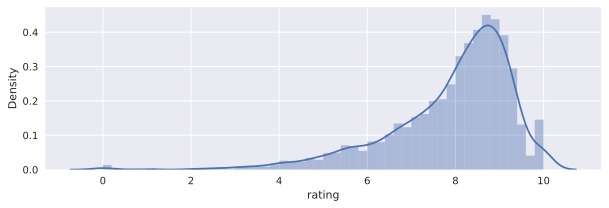

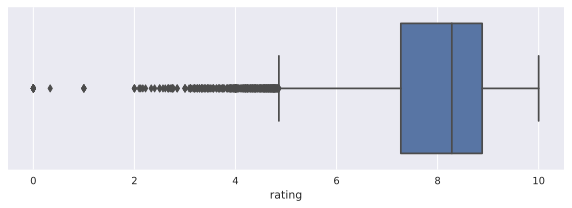

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 

plt.figure(figsize=(10, 3))
sns.distplot(df_pr['rating'])
plt.show()

plt.figure(figsize=(10, 3))
sns.boxplot(df_pr['rating'], orient='h')
plt.show()

In [31]:
df_pr.columns

Index(['age_access_type', 'name', 'type', 'release_year', 'duration',
       'element_uid', 'budget', 'marketing', 'rus', 'USA',
       ...
       'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
       'writer_1', 'country_0', 'genre_0', 'genre_1', 'genre_2'],
      dtype='object', length=33880)

In [32]:
df_pr.shape

(6773, 33880)

In [33]:
df_pr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6773 entries, 2 to 10488
Columns: 33880 entries, age_access_type to genre_2
dtypes: float64(7), int64(33842), object(31)
memory usage: 1.7+ GB


## Split

In [34]:
from sklearn.model_selection import train_test_split

sorted_df = df_pr.sort_values('release_year')

test = sorted_df[sorted_df['release_year'] == 2022]
train = sorted_df[sorted_df['release_year'] != 2022]

# for looking at samples
test_df = test.copy(deep=True)
train_df = train.copy(deep=True)

test.drop(['release_year', 'element_uid', 'name'], axis=1, inplace=True)
train.drop(['release_year', 'element_uid', 'name'], axis=1, inplace=True)

X_test, y_test = test.drop('rating', axis=1), test['rating']
X, y = train.drop('rating', axis=1), train['rating']
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.1, 
                                                  shuffle=False)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape


((6004, 33876), (668, 33876), (101, 33876), (6004,), (668,), (101,))

## Get just keywords

In [35]:
X_train.columns[:30]

Index(['age_access_type', 'type', 'duration', 'budget', 'marketing', 'rus',
       'USA', 'world', 'джек', 'расследовать', 'подруга', 'ограбление', 'катя',
       'макс', 'мечтать', 'отважный', 'фрэнк', 'воспитывать', 'супергерой',
       'безжалостный', 'маньяк', 'эксцентричный', 'одержимый', 'влюбляться',
       'капитан', 'приключение', 'плен', 'городок', 'пес', 'побег'],
      dtype='object')

In [36]:
X_train.columns[-50:]

Index(['предоставление', 'кнут', 'минимальный', 'мкс', 'рассмотрение',
       'регистрация', 'указанный', 'учет', 'модуль', 'собственник',
       'таможенный', 'диабет', 'млрд', 'рф', 'has_oscar_actor',
       'has_oscar_composer', 'has_oscar_design', 'has_oscar_director',
       'has_oscar_editor', 'has_oscar_operator', 'has_oscar_producer',
       'has_oscar_writer', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
       'actor_4', 'actor_5', 'actor_6', 'actor_7', 'actor_8', 'actor_9',
       'composer_0', 'design_0', 'design_1', 'design_2', 'director_0',
       'editor_0', 'operator_0', 'producer_0', 'producer_1', 'producer_2',
       'producer_3', 'producer_4', 'writer_0', 'writer_1', 'country_0',
       'genre_0', 'genre_1', 'genre_2'],
      dtype='object')

In [37]:
X_train_kws = X_train.drop(['age_access_type', 'type', 'duration', 'budget', 'marketing', 'rus',
       'USA', 'world', 'has_oscar_actor',
       'has_oscar_composer', 'has_oscar_design', 'has_oscar_director',
       'has_oscar_editor', 'has_oscar_operator', 'has_oscar_producer',
       'has_oscar_writer', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
       'actor_4', 'actor_5', 'actor_6', 'actor_7', 'actor_8', 'actor_9',
       'composer_0', 'design_0', 'design_1', 'design_2', 'director_0',
       'editor_0', 'operator_0', 'producer_0', 'producer_1', 'producer_2',
       'producer_3', 'producer_4', 'writer_0', 'writer_1', 'country_0',
       'genre_0', 'genre_1', 'genre_2'], axis=1)

X_train_df = X_train[['age_access_type', 'type', 'duration', 'budget', 'marketing', 'rus',
       'USA', 'world', 'has_oscar_actor',
       'has_oscar_composer', 'has_oscar_design', 'has_oscar_director',
       'has_oscar_editor', 'has_oscar_operator', 'has_oscar_producer',
       'has_oscar_writer', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
       'actor_4', 'actor_5', 'actor_6', 'actor_7', 'actor_8', 'actor_9',
       'composer_0', 'design_0', 'design_1', 'design_2', 'director_0',
       'editor_0', 'operator_0', 'producer_0', 'producer_1', 'producer_2',
       'producer_3', 'producer_4', 'writer_0', 'writer_1', 'country_0',
       'genre_0', 'genre_1', 'genre_2']]

X_val_kws = X_val.drop(['age_access_type', 'type', 'duration', 'budget', 'marketing', 'rus',
       'USA', 'world', 'has_oscar_actor',
       'has_oscar_composer', 'has_oscar_design', 'has_oscar_director',
       'has_oscar_editor', 'has_oscar_operator', 'has_oscar_producer',
       'has_oscar_writer', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
       'actor_4', 'actor_5', 'actor_6', 'actor_7', 'actor_8', 'actor_9',
       'composer_0', 'design_0', 'design_1', 'design_2', 'director_0',
       'editor_0', 'operator_0', 'producer_0', 'producer_1', 'producer_2',
       'producer_3', 'producer_4', 'writer_0', 'writer_1', 'country_0',
       'genre_0', 'genre_1', 'genre_2'], axis=1)

X_val_df = X_val[['age_access_type', 'type', 'duration', 'budget', 'marketing', 'rus',
       'USA', 'world', 'has_oscar_actor',
       'has_oscar_composer', 'has_oscar_design', 'has_oscar_director',
       'has_oscar_editor', 'has_oscar_operator', 'has_oscar_producer',
       'has_oscar_writer', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
       'actor_4', 'actor_5', 'actor_6', 'actor_7', 'actor_8', 'actor_9',
       'composer_0', 'design_0', 'design_1', 'design_2', 'director_0',
       'editor_0', 'operator_0', 'producer_0', 'producer_1', 'producer_2',
       'producer_3', 'producer_4', 'writer_0', 'writer_1', 'country_0',
       'genre_0', 'genre_1', 'genre_2']]

X_test_kws = X_test.drop(['age_access_type', 'type', 'duration', 'budget', 'marketing', 'rus',
       'USA', 'world', 'has_oscar_actor',
       'has_oscar_composer', 'has_oscar_design', 'has_oscar_director',
       'has_oscar_editor', 'has_oscar_operator', 'has_oscar_producer',
       'has_oscar_writer', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
       'actor_4', 'actor_5', 'actor_6', 'actor_7', 'actor_8', 'actor_9',
       'composer_0', 'design_0', 'design_1', 'design_2', 'director_0',
       'editor_0', 'operator_0', 'producer_0', 'producer_1', 'producer_2',
       'producer_3', 'producer_4', 'writer_0', 'writer_1', 'country_0',
       'genre_0', 'genre_1', 'genre_2'], axis=1)

X_test_df = X_test[['age_access_type', 'type', 'duration', 'budget', 'marketing', 'rus',
       'USA', 'world', 'has_oscar_actor',
       'has_oscar_composer', 'has_oscar_design', 'has_oscar_director',
       'has_oscar_editor', 'has_oscar_operator', 'has_oscar_producer',
       'has_oscar_writer', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
       'actor_4', 'actor_5', 'actor_6', 'actor_7', 'actor_8', 'actor_9',
       'composer_0', 'design_0', 'design_1', 'design_2', 'director_0',
       'editor_0', 'operator_0', 'producer_0', 'producer_1', 'producer_2',
       'producer_3', 'producer_4', 'writer_0', 'writer_1', 'country_0',
       'genre_0', 'genre_1', 'genre_2']]

## Standartization

In [38]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train_kws = sc.fit_transform(X_train_kws)
X_val_kws = sc.transform(X_val_kws)
X_test_kws = sc.transform(X_test_kws)

## PCA

In [39]:
from sklearn.decomposition import PCA

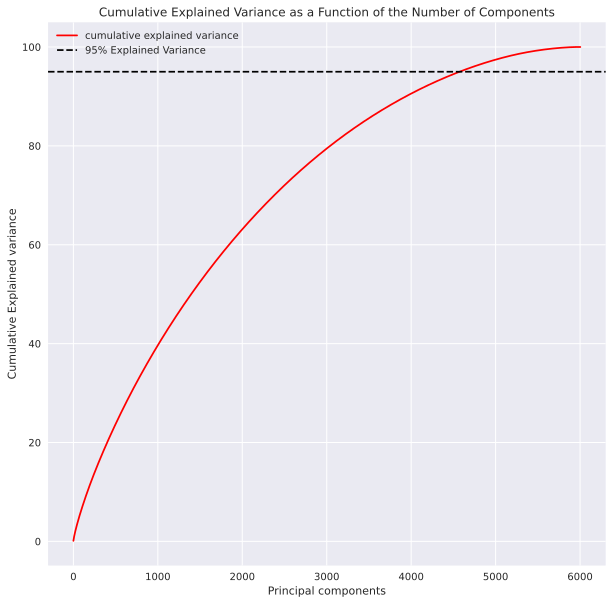

In [43]:
pca = PCA()
pca.fit(X_train_kws)
cumsum = np.cumsum(pca.explained_variance_ratio_)*100
d = [n for n in range(len(cumsum))]
plt.figure(figsize=(10, 10))
plt.plot(d,cumsum, color = 'red',label='cumulative explained variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
plt.legend(loc='best')

In [44]:
pca.n_components_

6004

In [84]:
pca = PCA(n_components=1000)  # 1000 - 55%
X_train_kws_pca = pca.fit_transform(X_train_kws)
X_val_kws_pca = pca.transform(X_val_kws)
X_test_kws_pca = pca.transform(X_test_kws)

**Convert to dataframe**

In [85]:
component_names = [f"PC{i+1}" for i in range(X_train_kws_pca.shape[1])]
X_train_kws_pca = pd.DataFrame(X_train_kws_pca, columns=component_names)
X_train_kws_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.057422  3.507473 -0.620791 -0.224626 -0.197913  2.867799  0.877859   
1 -0.339792 -0.473106 -0.255168 -0.219383  0.045219 -0.053892 -0.364034   
2 -0.333048 -0.314549 -0.233497 -0.431993 -0.275270 -0.258333 -0.370974   
3 -0.159714 -0.097305  0.228618 -0.244143 -0.225556 -0.212360 -0.381098   
4 -0.115936 -0.292500 -0.155211 -0.168600 -0.323795 -0.179894 -0.202132   

        PC8       PC9      PC10  ...     PC991     PC992     PC993     PC994  \
0 -0.648434  0.023557 -0.402383  ... -2.583178 -0.808117  0.112574 -0.882770   
1  0.001714  0.344648 -0.263529  ...  1.078111 -1.103115  0.098396 -1.351743   
2 -0.492475 -0.159851 -0.497438  ... -0.261475  1.500807  0.754189  0.192393   
3  0.293181 -0.216036 -0.227281  ...  2.470104 -0.770839  3.806904 -0.853777   
4 -0.299010 -0.195729 -0.223747  ...  0.087996 -0.035873  1.004524  1.272149   

      PC995     PC996     PC997     PC998     PC999    PC1000  
0  4.918528 -3.164816 -2.842749  2.380304  1.078740  1.010656  
1  1.149234  0.616337 -1.301880 -0.297492 -2.573152 -0.970615  
2  0.338495 -2.228517 -0.253037 -0.635724 -1.576111  1.812256  
3 -1.960391  1.242609 -2.541286  2.810643 -2.025650  0.741448  
4 -0.452122 -0.186971 -0.228207 -0.136520 -0.272838 -0.004882  

[5 rows x 1000 columns]

In [86]:
X_train_df = X_train_df.reset_index().drop('index', axis=1)
X_train = X_train_df.join(X_train_kws_pca, on=X_train_df.index)
X_train.head()

age_access_type   type   duration     budget  marketing  rus         USA  \
0               12  MOVIE  15.545395  17.034386        NaN  NaN  17266359.0   
1               18  MOVIE  15.490736  16.588099  17.249498  NaN  68540777.0   
2               16  MOVIE  15.555977  17.536373  16.959663  NaN  57262492.0   
3               16  MOVIE  15.512960  17.034386        NaN  NaN  12811858.0   
4               16  MOVIE  15.684231  16.951005        NaN  NaN  39240659.0   

       world  has_oscar_actor  has_oscar_composer  ...     PC991     PC992  \
0  17.214521                0                   0  ... -2.583178 -0.808117   
1  18.600953                0                   0  ...  1.078111 -1.103115   
2  18.482450                0                   0  ... -0.261475  1.500807   
3  16.578277                0                   0  ...  2.470104 -0.770839   
4  17.789337                0                   0  ...  0.087996 -0.035873   

      PC993     PC994     PC995     PC996     PC997     PC998     PC999  \
0  0.112574 -0.882770  4.918528 -3.164816 -2.842749  2.380304  1.078740   
1  0.098396 -1.351743  1.149234  0.616337 -1.301880 -0.297492 -2.573152   
2  0.754189  0.192393  0.338495 -2.228517 -0.253037 -0.635724 -1.576111   
3  3.806904 -0.853777 -1.960391  1.242609 -2.541286  2.810643 -2.025650   
4  1.004524  1.272149 -0.452122 -0.186971 -0.228207 -0.136520 -0.272838   

     PC1000  
0  1.010656  
1 -0.970615  
2  1.812256  
3  0.741448  
4 -0.004882  

[5 rows x 1044 columns]

In [87]:
component_names = [f"PC{i+1}" for i in range(X_val_kws_pca.shape[1])]
X_val_kws_pca = pd.DataFrame(X_val_kws_pca, columns=component_names)
X_val_kws_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.377732 -0.379193 -0.164484 -0.243343 -0.247710 -0.140450 -0.395584   
1 -0.294389 -0.293079  0.654014 -0.212776 -0.321618 -0.223803 -0.182090   
2 -0.038085 -0.287958 -0.308793  1.938730 -0.360426 -0.189061 -0.584089   
3 -0.302753 -0.244879 -0.251355 -0.350147 -0.229299 -0.251280  0.019498   
4 -0.313951 -0.122982 -0.234948 -0.288554 -0.293248 -0.181092 -0.363346   

        PC8       PC9      PC10  ...     PC991     PC992     PC993     PC994  \
0 -0.024557 -0.078695  0.115167  ...  0.163162  0.331887 -0.823794 -0.432308   
1 -0.277723 -0.084427 -0.204037  ...  0.887698  0.924294  0.666901 -0.673632   
2 -0.366042 -0.403567  2.158866  ... -0.582105  1.727750  0.460619  1.250495   
3  0.886668 -0.174364  1.602289  ... -0.507815 -0.425868 -1.044094  0.586801   
4 -0.413673 -0.154814 -0.297905  ...  0.596766 -0.404076 -0.204098  0.170124   

      PC995     PC996     PC997     PC998     PC999    PC1000  
0 -0.250874 -0.852230 -0.639821 -0.244375  1.090412  0.419496  
1  1.919373 -0.177582  0.389972  0.334789  0.358557 -1.096728  
2 -0.391520  0.107741  0.834084 -1.118269  0.565446  0.527882  
3  0.032414  0.353650 -0.914251  0.246984  0.363954  0.818069  
4 -0.241828  0.115556  1.319352  0.592791  0.095212  0.664551  

[5 rows x 1000 columns]

In [88]:
X_val_df = X_val_df.reset_index().drop('index', axis=1)
X_val = X_val_df.join(X_val_kws_pca, on=X_val_df.index)
X_val.head()

age_access_type    type   duration  budget  marketing        rus       USA  \
0               16   MOVIE  15.512960     NaN        NaN        NaN       NaN   
1               16   MOVIE  15.444751     NaN        NaN  11.319329       NaN   
2               18   MOVIE  15.345905     NaN        NaN   9.377717  588869.0   
3               16   MOVIE  15.468008     NaN        NaN        NaN       NaN   
4               16  SERIAL  17.601970     NaN        NaN        NaN       NaN   

       world  has_oscar_actor  has_oscar_composer  ...     PC991     PC992  \
0        NaN                0                   0  ...  0.163162  0.331887   
1  11.900586                0                   0  ...  0.887698  0.924294   
2  13.305909                0                   0  ... -0.582105  1.727750   
3        NaN                0                   0  ... -0.507815 -0.425868   
4        NaN                0                   0  ...  0.596766 -0.404076   

      PC993     PC994     PC995     PC996     PC997     PC998     PC999  \
0 -0.823794 -0.432308 -0.250874 -0.852230 -0.639821 -0.244375  1.090412   
1  0.666901 -0.673632  1.919373 -0.177582  0.389972  0.334789  0.358557   
2  0.460619  1.250495 -0.391520  0.107741  0.834084 -1.118269  0.565446   
3 -1.044094  0.586801  0.032414  0.353650 -0.914251  0.246984  0.363954   
4 -0.204098  0.170124 -0.241828  0.115556  1.319352  0.592791  0.095212   

     PC1000  
0  0.419496  
1 -1.096728  
2  0.527882  
3  0.818069  
4  0.664551  

[5 rows x 1044 columns]

In [89]:
component_names = [f"PC{i+1}" for i in range(X_test_kws_pca.shape[1])]
X_test_kws_pca = pd.DataFrame(X_test_kws_pca, columns=component_names)
X_test_kws_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.149005 -0.003177 -0.129943 -0.190271 -0.044243 -0.109659 -0.323940   
1 -0.296091 -0.377538 -0.244171 -0.300559 -0.269750 -0.116507 -0.477286   
2 -0.262471 -0.282640 -0.096619  1.285817  0.070986 -0.021041 -0.191441   
3 -0.427054 -0.426239 -0.193274 -0.011335 -0.274169 -0.027517 -0.425876   
4  0.048996 -0.406396 -0.025621 -0.211079  0.031876 -0.032765 -0.454959   

        PC8       PC9      PC10  ...     PC991     PC992     PC993     PC994  \
0 -0.132691  0.719838 -0.166790  ... -0.289181  0.055586  0.242875 -0.512624   
1 -0.278978 -0.284866 -0.359684  ...  0.317823 -0.051377  0.231650  0.025647   
2  0.459901 -0.073418 -0.132300  ...  1.109332  0.174322  0.699099  1.421499   
3 -0.114613  0.045393 -0.283863  ...  0.094370 -0.865371  1.867204 -0.296502   
4 -0.142219 -0.314581 -0.247316  ...  1.015013 -0.243339 -0.833205  0.758716   

      PC995     PC996     PC997     PC998     PC999    PC1000  
0  0.464989  0.620473 -0.106802 -0.272212 -0.299856  0.061396  
1  0.729554 -0.458461 -0.468683 -0.066633 -0.028451  0.223619  
2 -0.005094  0.211626 -0.615027 -0.053552 -0.037011 -0.249957  
3 -0.401171 -0.235295 -0.468194  0.001440  0.166854  0.681898  
4  0.033434 -1.018172  0.140406  0.081465  0.179588 -0.329199  

[5 rows x 1000 columns]

In [90]:
X_test_df = X_test_df.reset_index().drop('index', axis=1)
X_test = X_test_df.join(X_test_kws_pca, on=X_test_df.index)
X_test.head()

age_access_type    type   duration  budget  marketing  rus  USA  world  \
0               16  SERIAL  16.368076     NaN        NaN  NaN  NaN    NaN   
1               18  SERIAL  16.626117     NaN        NaN  NaN  NaN    NaN   
2               18  SERIAL  16.558928     NaN        NaN  NaN  NaN    NaN   
3               18  SERIAL  16.200597     NaN        NaN  NaN  NaN    NaN   
4               18  SERIAL  16.233209     NaN        NaN  NaN  NaN    NaN   

   has_oscar_actor  has_oscar_composer  ...     PC991     PC992     PC993  \
0                0                   0  ... -0.289181  0.055586  0.242875   
1                0                   0  ...  0.317823 -0.051377  0.231650   
2                0                   0  ...  1.109332  0.174322  0.699099   
3                0                   0  ...  0.094370 -0.865371  1.867204   
4                0                   0  ...  1.015013 -0.243339 -0.833205   

      PC994     PC995     PC996     PC997     PC998     PC999    PC1000  
0 -0.512624  0.464989  0.620473 -0.106802 -0.272212 -0.299856  0.061396  
1  0.025647  0.729554 -0.458461 -0.468683 -0.066633 -0.028451  0.223619  
2  1.421499 -0.005094  0.211626 -0.615027 -0.053552 -0.037011 -0.249957  
3 -0.296502 -0.401171 -0.235295 -0.468194  0.001440  0.166854  0.681898  
4  0.758716  0.033434 -1.018172  0.140406  0.081465  0.179588 -0.329199  

[5 rows x 1044 columns]

## Model

In [91]:
import catboost as cat
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from scipy.stats import uniform, randint

In [92]:
train_dataset = cat.Pool(data=X_train,
                        label=y_train,
                         cat_features=cat_features)

test_dataset = cat.Pool(data=X_test, 
                        label=y_test,
                         cat_features=cat_features)

val_dataset = cat.Pool(X_val, y_val,
                       cat_features=cat_features)

cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features
}

cat_model = cat.CatBoostRegressor(**cat_params)

cat_model.fit(
    train_dataset,
    eval_set=val_dataset,
    early_stopping_rounds=500,
    verbose=100,
    plot=False
)

Learning rate set to 0.06747
0:	learn: 1.0263132	test: 1.1445949	best: 1.1445949 (0)	total: 89.2ms	remaining: 1m 29s
100:	learn: 0.6929618	test: 0.8747621	best: 0.8742905 (89)	total: 9.72s	remaining: 1m 26s
200:	learn: 0.6143722	test: 0.8653994	best: 0.8650856 (199)	total: 19.5s	remaining: 1m 17s
300:	learn: 0.5372615	test: 0.8571388	best: 0.8566857 (296)	total: 29.3s	remaining: 1m 7s
400:	learn: 0.4741705	test: 0.8533641	best: 0.8528424 (360)	total: 39.1s	remaining: 58.4s
500:	learn: 0.4137393	test: 0.8533350	best: 0.8512980 (465)	total: 48.9s	remaining: 48.7s
600:	learn: 0.3599728	test: 0.8547339	best: 0.8512980 (465)	total: 58.6s	remaining: 38.9s
700:	learn: 0.3161133	test: 0.8549224	best: 0.8512980 (465)	total: 1m 8s	remaining: 29s
800:	learn: 0.2790700	test: 0.8577504	best: 0.8512980 (465)	total: 1m 17s	remaining: 19.3s
900:	learn: 0.2488161	test: 0.8583423	best: 0.8512980 (465)	total: 1m 27s	remaining: 9.58s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.851

In [93]:
y_pred = cat_model.predict(test_dataset)

In [94]:
calc_metrics(y_test, y_pred)

*** VAL **: 
MSE:   1.0565580956936482
RMSE:  1.0278901184920732
R2:    0.49921851844375675
MAE:   0.7430354839113293
MedAE: 0.5485065653411745
------------------------------


In [99]:
cat_model.save_model('okko_ratings_pred_pca_oscr')

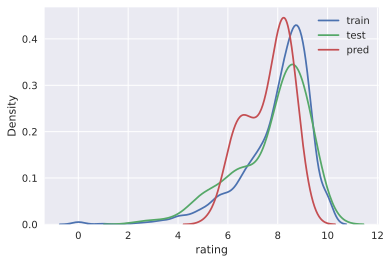

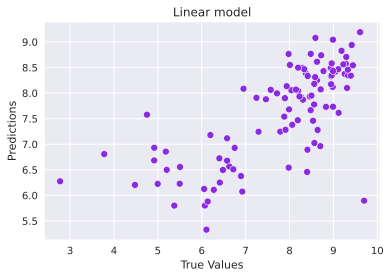

In [100]:
target_distr_linear(y_train, y_test, y_pred)   

IMP: [3.59744496e+00 1.25975515e+00 8.94347464e+00 2.74790830e-01
 3.16166138e-02 5.50627528e-01 4.48033216e-01 6.98872048e+00
 0.00000000e+00 0.00000000e+00 6.50164229e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.93750041e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.43317375e-01]


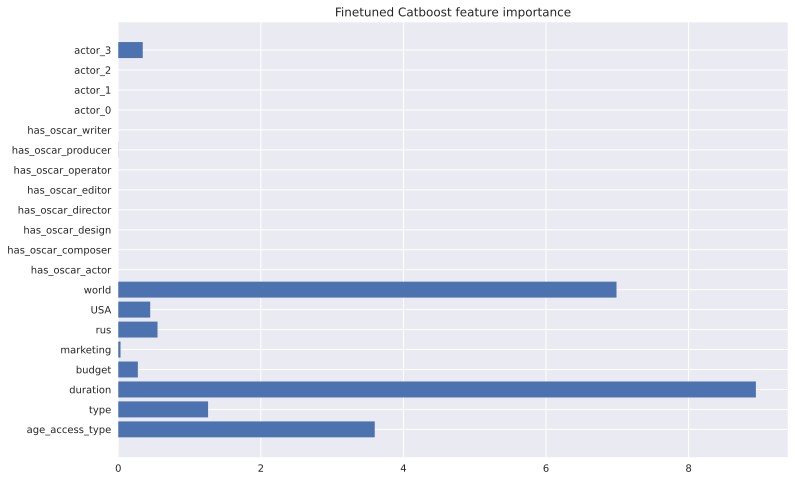

In [101]:
get_feature_imp(cat_model, train_dataset)

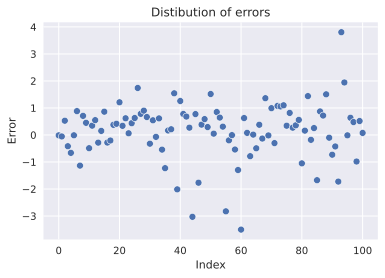

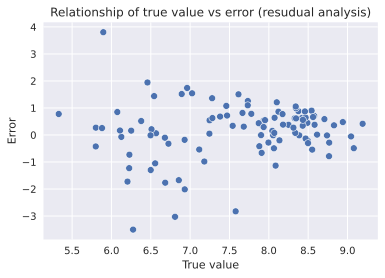

In [102]:
errors = y_test - y_pred
draw_res_analys(errors, y_pred)

### LOOKING AT TEST

In [103]:
test_df['PREDS'] = y_pred.tolist()
test_df['TARGET'] = y_test.tolist()
test_df

age_access_type                             name    type  release_year  \
10401               16                    Темное сердце  SERIAL          2022   
10439               18  Жена путешественника во времени  SERIAL          2022   
10435               18                    Хроники пышки  SERIAL          2022   
10457               18                 Бесконечная ночь  SERIAL          2022   
10438               18                        Репетиция  SERIAL          2022   
...                ...                              ...     ...           ...   
3110                16                          Код 355   MOVIE          2022   
2868                12                    Лулу и Бриггс   MOVIE          2022   
2805                16                  Побег из Африки   MOVIE          2022   
3885                18        Крепость 2: Глаз снайпера   MOVIE          2022   
10488                6                   Истоки футбола  SERIAL          2022   

        duration                           element_uid     budget  marketing  \
10401  16.368076  2372e695-5fff-4c68-91c7-73bce33fc9b1        NaN        NaN   
10439  16.626117  7becd8d8-1fb8-4ee6-b903-47817686ddd8        NaN        NaN   
10435  16.558928  17f245d4-d2d2-46de-a974-d7cd427ad1b6        NaN        NaN   
10457  16.200597  952bfe32-7504-4ef5-af22-985379d8637f        NaN        NaN   
10438  16.233209  753d822a-1890-4445-ab54-fe65c900e3fa        NaN        NaN   
...          ...                                   ...        ...        ...   
3110   15.806121  58934f4f-bec0-45db-a8a2-ab90d911a612  18.132999        NaN   
2868   15.617221  1504acff-36a2-4886-b37e-b4a96d51d3f6        NaN        NaN   
2805   15.490736  581115c5-1a7e-466d-9d11-fdd8d128d669  12.388398        NaN   
3885   15.587067  d580669b-3774-4091-8d78-f8cbdf02f8e0        NaN        NaN   
10488  17.518293  6dd86e60-5d6d-475d-9b46-e989ac7a30b6        NaN        NaN   

             rus         USA  ...        producer_3          producer_4  \
10401        NaN         NaN  ...        Элин Квист  Каролин Ландерберг   
10439        NaN         NaN  ...     Брайан Минчин       Стивен Моффат   
10435        NaN         NaN  ...        Дэн Сигнер        Ева Лонгория   
10457        NaN         NaN  ...      Лайонел Юзан          Лоран Анон   
10438        NaN         NaN  ...       Кристи Смит         Рэйчел Хейн   
...          ...         ...  ...               ...                 ...   
3110   13.114567  14570455.0  ...  Джессика Честейн        Ричард Хьюит   
2868   15.155431  61778069.0  ...    Бетси Дэнбьюри    Грегори Джейкобс   
2805         NaN         NaN  ...                Na                  Na   
3885         NaN         NaN  ...      Джордж Фурла         Луильо Руис   
10488        NaN         NaN  ...                Na                  Na   

              writer_0          writer_1  country_0  \
10401  Оскар Сёдерлунд   Эрик Хультквист    denmark   
10439    Стивен Моффат  Одри Ниффенеггер        usa   
10435        Шон Уайнс  Мэттью Клэйбрукс        usa   
10457      Давид Перро  Эммануэль Вуазен    belgium   
10438    Нэйтан Филдер      Кэрри Кемпер        usa   
...                ...               ...        ...   
3110    Ребека Ф. Смит      Тереза Ребек        usa   
2868     Ченнинг Татум     Андреа Дзирио        usa   
2805          Тед Бетц                Na        usa   
3885     Алан Хорснэйл        Эмиль Хирш        usa   
10488         Ши Чуань                Na      china   

                                    genre_0    genre_1  \
10401                              Thriller      Drama   
10439                                Sci-Fi  Melodrama   
10435                                Comedy     Family   
10457  9fa28b61-a257-4a3e-945b-a9ef76a146d6         Na   
10438                                Comedy         Na   
...                                     ...        ...   
3110                                 Action   Thriller   
2868                                 Comedy    

# Tuning

In [104]:
train_dataset = cat.Pool(X_train, 
                         y_train,
                         cat_features=cat_features)

test_dataset = cat.Pool(X_test, 
                        y_test,
                        cat_features=cat_features)

cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features
}

In [105]:
parameters_distr = {'depth': randint(3, 7),
              'learning_rate': uniform(0.01, 0.1),
              'iterations': [100, 1000, 5000]
             }

cat_model = cat.CatBoostRegressor(**cat_params)
grid = RandomizedSearchCV(estimator=cat_model, param_distributions=parameters_distr, 
                            cv=5,
#                           n_jobs=-1, 
                          verbose=3)

grid.fit(X_train, y_train)

import pickle
with open('bestimator_ratings_kinop_oscr_pca', 'wb') as f:
    pickle.dump(grid.best_estimator_, f)
grid.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 1.0898972	total: 53.7ms	remaining: 53.7s
1:	learn: 1.0780784	total: 122ms	remaining: 1m
2:	learn: 1.0679443	total: 177ms	remaining: 58.9s
3:	learn: 1.0588288	total: 245ms	remaining: 1m 1s
4:	learn: 1.0492720	total: 308ms	remaining: 1m 1s
5:	learn: 1.0396158	total: 372ms	remaining: 1m 1s
6:	learn: 1.0310325	total: 438ms	remaining: 1m 2s
7:	learn: 1.0218535	total: 499ms	remaining: 1m 1s
8:	learn: 1.0132445	total: 571ms	remaining: 1m 2s
9:	learn: 1.0049106	total: 629ms	remaining: 1m 2s
10:	learn: 0.9980772	total: 691ms	remaining: 1m 2s
11:	learn: 0.9922251	total: 758ms	remaining: 1m 2s
12:	learn: 0.9857739	total: 826ms	remaining: 1m 2s
13:	learn: 0.9785988	total: 889ms	remaining: 1m 2s
14:	learn: 0.9724036	total: 951ms	remaining: 1m 2s
15:	learn: 0.9665867	total: 1.02s	remaining: 1m 2s
16:	learn: 0.9594890	total: 1.08s	remaining: 1m 2s
17:	learn: 0.9531079	total: 1.14s	remaining: 1m 2s
18:	learn: 0.9482237	total: 1.2s	

162:	learn: 0.7556002	total: 10.2s	remaining: 52.5s
163:	learn: 0.7554913	total: 10.3s	remaining: 52.4s
164:	learn: 0.7550268	total: 10.3s	remaining: 52.3s
165:	learn: 0.7546757	total: 10.4s	remaining: 52.3s
166:	learn: 0.7542541	total: 10.5s	remaining: 52.2s
167:	learn: 0.7538292	total: 10.5s	remaining: 52.1s
168:	learn: 0.7532989	total: 10.6s	remaining: 52s
169:	learn: 0.7529338	total: 10.6s	remaining: 52s
170:	learn: 0.7525202	total: 10.7s	remaining: 51.9s
171:	learn: 0.7521654	total: 10.8s	remaining: 51.8s
172:	learn: 0.7517968	total: 10.8s	remaining: 51.8s
173:	learn: 0.7514517	total: 10.9s	remaining: 51.7s
174:	learn: 0.7509489	total: 11s	remaining: 51.7s
175:	learn: 0.7504365	total: 11s	remaining: 51.6s
176:	learn: 0.7501121	total: 11.1s	remaining: 51.5s
177:	learn: 0.7498322	total: 11.2s	remaining: 51.5s
178:	learn: 0.7494479	total: 11.2s	remaining: 51.4s
179:	learn: 0.7491798	total: 11.3s	remaining: 51.3s
180:	learn: 0.7487936	total: 11.3s	remaining: 51.3s
181:	learn: 0.748426

322:	learn: 0.7005593	total: 20.2s	remaining: 42.3s
323:	learn: 0.7002501	total: 20.3s	remaining: 42.3s
324:	learn: 0.6998911	total: 20.3s	remaining: 42.2s
325:	learn: 0.6994876	total: 20.4s	remaining: 42.1s
326:	learn: 0.6988436	total: 20.4s	remaining: 42.1s
327:	learn: 0.6984847	total: 20.5s	remaining: 42s
328:	learn: 0.6981039	total: 20.6s	remaining: 41.9s
329:	learn: 0.6976550	total: 20.6s	remaining: 41.9s
330:	learn: 0.6973005	total: 20.7s	remaining: 41.8s
331:	learn: 0.6967548	total: 20.7s	remaining: 41.7s
332:	learn: 0.6962614	total: 20.8s	remaining: 41.7s
333:	learn: 0.6962540	total: 20.9s	remaining: 41.6s
334:	learn: 0.6959580	total: 20.9s	remaining: 41.6s
335:	learn: 0.6954815	total: 21s	remaining: 41.5s
336:	learn: 0.6949813	total: 21.1s	remaining: 41.4s
337:	learn: 0.6947184	total: 21.1s	remaining: 41.4s
338:	learn: 0.6942814	total: 21.2s	remaining: 41.3s
339:	learn: 0.6940108	total: 21.3s	remaining: 41.3s
340:	learn: 0.6936946	total: 21.3s	remaining: 41.2s
341:	learn: 0.69

483:	learn: 0.6514394	total: 30.2s	remaining: 32.2s
484:	learn: 0.6509211	total: 30.3s	remaining: 32.1s
485:	learn: 0.6507198	total: 30.3s	remaining: 32.1s
486:	learn: 0.6504210	total: 30.4s	remaining: 32s
487:	learn: 0.6501045	total: 30.5s	remaining: 32s
488:	learn: 0.6497129	total: 30.5s	remaining: 31.9s
489:	learn: 0.6495598	total: 30.6s	remaining: 31.8s
490:	learn: 0.6492942	total: 30.6s	remaining: 31.8s
491:	learn: 0.6490987	total: 30.7s	remaining: 31.7s
492:	learn: 0.6486437	total: 30.8s	remaining: 31.7s
493:	learn: 0.6484047	total: 30.8s	remaining: 31.6s
494:	learn: 0.6480085	total: 30.9s	remaining: 31.5s
495:	learn: 0.6477308	total: 31s	remaining: 31.5s
496:	learn: 0.6476416	total: 31s	remaining: 31.4s
497:	learn: 0.6474562	total: 31.1s	remaining: 31.3s
498:	learn: 0.6471031	total: 31.1s	remaining: 31.3s
499:	learn: 0.6466230	total: 31.2s	remaining: 31.2s
500:	learn: 0.6462728	total: 31.3s	remaining: 31.2s
501:	learn: 0.6459427	total: 31.3s	remaining: 31.1s
502:	learn: 0.645696

645:	learn: 0.5957941	total: 40.4s	remaining: 22.2s
646:	learn: 0.5953562	total: 40.5s	remaining: 22.1s
647:	learn: 0.5949865	total: 40.6s	remaining: 22s
648:	learn: 0.5945297	total: 40.6s	remaining: 22s
649:	learn: 0.5940927	total: 40.7s	remaining: 21.9s
650:	learn: 0.5937493	total: 40.8s	remaining: 21.8s
651:	learn: 0.5935005	total: 40.8s	remaining: 21.8s
652:	learn: 0.5931279	total: 40.9s	remaining: 21.7s
653:	learn: 0.5927995	total: 40.9s	remaining: 21.7s
654:	learn: 0.5923161	total: 41s	remaining: 21.6s
655:	learn: 0.5920832	total: 41.1s	remaining: 21.5s
656:	learn: 0.5915978	total: 41.1s	remaining: 21.5s
657:	learn: 0.5911781	total: 41.2s	remaining: 21.4s
658:	learn: 0.5909110	total: 41.3s	remaining: 21.4s
659:	learn: 0.5906852	total: 41.3s	remaining: 21.3s
660:	learn: 0.5903918	total: 41.4s	remaining: 21.2s
661:	learn: 0.5899733	total: 41.4s	remaining: 21.2s
662:	learn: 0.5896416	total: 41.5s	remaining: 21.1s
663:	learn: 0.5893105	total: 41.6s	remaining: 21s
664:	learn: 0.588924

807:	learn: 0.5451957	total: 50.7s	remaining: 12s
808:	learn: 0.5447886	total: 50.8s	remaining: 12s
809:	learn: 0.5444216	total: 50.8s	remaining: 11.9s
810:	learn: 0.5441689	total: 50.9s	remaining: 11.9s
811:	learn: 0.5439752	total: 50.9s	remaining: 11.8s
812:	learn: 0.5436170	total: 51s	remaining: 11.7s
813:	learn: 0.5433729	total: 51.1s	remaining: 11.7s
814:	learn: 0.5430955	total: 51.1s	remaining: 11.6s
815:	learn: 0.5429413	total: 51.2s	remaining: 11.5s
816:	learn: 0.5427699	total: 51.3s	remaining: 11.5s
817:	learn: 0.5423129	total: 51.3s	remaining: 11.4s
818:	learn: 0.5421190	total: 51.4s	remaining: 11.4s
819:	learn: 0.5419118	total: 51.5s	remaining: 11.3s
820:	learn: 0.5415587	total: 51.5s	remaining: 11.2s
821:	learn: 0.5411614	total: 51.6s	remaining: 11.2s
822:	learn: 0.5407968	total: 51.7s	remaining: 11.1s
823:	learn: 0.5403746	total: 51.7s	remaining: 11s
824:	learn: 0.5400822	total: 51.8s	remaining: 11s
825:	learn: 0.5397489	total: 51.8s	remaining: 10.9s
826:	learn: 0.5393606	

970:	learn: 0.4986269	total: 1m	remaining: 1.82s
971:	learn: 0.4984371	total: 1m	remaining: 1.76s
972:	learn: 0.4981527	total: 1m 1s	remaining: 1.69s
973:	learn: 0.4979210	total: 1m 1s	remaining: 1.63s
974:	learn: 0.4976293	total: 1m 1s	remaining: 1.57s
975:	learn: 0.4972717	total: 1m 1s	remaining: 1.5s
976:	learn: 0.4969873	total: 1m 1s	remaining: 1.44s
977:	learn: 0.4966690	total: 1m 1s	remaining: 1.38s
978:	learn: 0.4962645	total: 1m 1s	remaining: 1.32s
979:	learn: 0.4959557	total: 1m 1s	remaining: 1.25s
980:	learn: 0.4955818	total: 1m 1s	remaining: 1.19s
981:	learn: 0.4953215	total: 1m 1s	remaining: 1.13s
982:	learn: 0.4950615	total: 1m 1s	remaining: 1.07s
983:	learn: 0.4948557	total: 1m 1s	remaining: 1s
984:	learn: 0.4945079	total: 1m 1s	remaining: 941ms
985:	learn: 0.4943046	total: 1m 1s	remaining: 879ms
986:	learn: 0.4940841	total: 1m 1s	remaining: 816ms
987:	learn: 0.4938209	total: 1m 2s	remaining: 753ms
988:	learn: 0.4934805	total: 1m 2s	remaining: 690ms
989:	learn: 0.4931608	

130:	learn: 0.7484365	total: 8.4s	remaining: 55.7s
131:	learn: 0.7480662	total: 8.46s	remaining: 55.6s
132:	learn: 0.7475989	total: 8.52s	remaining: 55.6s
133:	learn: 0.7472067	total: 8.59s	remaining: 55.5s
134:	learn: 0.7467306	total: 8.65s	remaining: 55.4s
135:	learn: 0.7464322	total: 8.72s	remaining: 55.4s
136:	learn: 0.7460637	total: 8.79s	remaining: 55.3s
137:	learn: 0.7456912	total: 8.85s	remaining: 55.3s
138:	learn: 0.7451221	total: 8.91s	remaining: 55.2s
139:	learn: 0.7448375	total: 8.97s	remaining: 55.1s
140:	learn: 0.7442859	total: 9.04s	remaining: 55.1s
141:	learn: 0.7438661	total: 9.11s	remaining: 55s
142:	learn: 0.7435771	total: 9.16s	remaining: 54.9s
143:	learn: 0.7431553	total: 9.22s	remaining: 54.8s
144:	learn: 0.7426147	total: 9.29s	remaining: 54.8s
145:	learn: 0.7421555	total: 9.35s	remaining: 54.7s
146:	learn: 0.7418290	total: 9.42s	remaining: 54.6s
147:	learn: 0.7416222	total: 9.48s	remaining: 54.6s
148:	learn: 0.7411823	total: 9.55s	remaining: 54.5s
149:	learn: 0.7

290:	learn: 0.6916694	total: 18.8s	remaining: 45.9s
291:	learn: 0.6913655	total: 18.9s	remaining: 45.8s
292:	learn: 0.6910285	total: 19s	remaining: 45.7s
293:	learn: 0.6907598	total: 19s	remaining: 45.7s
294:	learn: 0.6902131	total: 19.1s	remaining: 45.6s
295:	learn: 0.6898355	total: 19.1s	remaining: 45.5s
296:	learn: 0.6896561	total: 19.2s	remaining: 45.5s
297:	learn: 0.6891377	total: 19.3s	remaining: 45.4s
298:	learn: 0.6887579	total: 19.3s	remaining: 45.4s
299:	learn: 0.6884165	total: 19.4s	remaining: 45.3s
300:	learn: 0.6882113	total: 19.5s	remaining: 45.2s
301:	learn: 0.6878002	total: 19.5s	remaining: 45.2s
302:	learn: 0.6873244	total: 19.6s	remaining: 45.1s
303:	learn: 0.6870152	total: 19.7s	remaining: 45s
304:	learn: 0.6865435	total: 19.7s	remaining: 44.9s
305:	learn: 0.6861740	total: 19.8s	remaining: 44.9s
306:	learn: 0.6858974	total: 19.8s	remaining: 44.8s
307:	learn: 0.6855709	total: 19.9s	remaining: 44.7s
308:	learn: 0.6851077	total: 20s	remaining: 44.7s
309:	learn: 0.684999

450:	learn: 0.6365000	total: 29s	remaining: 35.3s
451:	learn: 0.6361567	total: 29.1s	remaining: 35.3s
452:	learn: 0.6358941	total: 29.1s	remaining: 35.2s
453:	learn: 0.6354422	total: 29.2s	remaining: 35.1s
454:	learn: 0.6353432	total: 29.3s	remaining: 35.1s
455:	learn: 0.6349619	total: 29.3s	remaining: 35s
456:	learn: 0.6345240	total: 29.4s	remaining: 34.9s
457:	learn: 0.6341902	total: 29.5s	remaining: 34.9s
458:	learn: 0.6339173	total: 29.5s	remaining: 34.8s
459:	learn: 0.6336714	total: 29.6s	remaining: 34.7s
460:	learn: 0.6332797	total: 29.7s	remaining: 34.7s
461:	learn: 0.6330259	total: 29.7s	remaining: 34.6s
462:	learn: 0.6328232	total: 29.8s	remaining: 34.5s
463:	learn: 0.6323527	total: 29.8s	remaining: 34.5s
464:	learn: 0.6319426	total: 29.9s	remaining: 34.4s
465:	learn: 0.6318590	total: 30s	remaining: 34.4s
466:	learn: 0.6314669	total: 30s	remaining: 34.3s
467:	learn: 0.6310171	total: 30.1s	remaining: 34.2s
468:	learn: 0.6309468	total: 30.2s	remaining: 34.2s
469:	learn: 0.630590

612:	learn: 0.5860380	total: 39.2s	remaining: 24.7s
613:	learn: 0.5858584	total: 39.3s	remaining: 24.7s
614:	learn: 0.5854733	total: 39.3s	remaining: 24.6s
615:	learn: 0.5854686	total: 39.4s	remaining: 24.5s
616:	learn: 0.5850194	total: 39.4s	remaining: 24.5s
617:	learn: 0.5846853	total: 39.5s	remaining: 24.4s
618:	learn: 0.5843008	total: 39.6s	remaining: 24.4s
619:	learn: 0.5840674	total: 39.6s	remaining: 24.3s
620:	learn: 0.5835464	total: 39.7s	remaining: 24.2s
621:	learn: 0.5831509	total: 39.8s	remaining: 24.2s
622:	learn: 0.5828974	total: 39.8s	remaining: 24.1s
623:	learn: 0.5826636	total: 39.9s	remaining: 24s
624:	learn: 0.5823765	total: 40s	remaining: 24s
625:	learn: 0.5819185	total: 40s	remaining: 23.9s
626:	learn: 0.5814673	total: 40.1s	remaining: 23.8s
627:	learn: 0.5811786	total: 40.1s	remaining: 23.8s
628:	learn: 0.5809528	total: 40.2s	remaining: 23.7s
629:	learn: 0.5805837	total: 40.3s	remaining: 23.6s
630:	learn: 0.5804037	total: 40.3s	remaining: 23.6s
631:	learn: 0.579947

774:	learn: 0.5388416	total: 49.3s	remaining: 14.3s
775:	learn: 0.5385953	total: 49.3s	remaining: 14.2s
776:	learn: 0.5383424	total: 49.4s	remaining: 14.2s
777:	learn: 0.5380971	total: 49.4s	remaining: 14.1s
778:	learn: 0.5378370	total: 49.5s	remaining: 14s
779:	learn: 0.5376014	total: 49.6s	remaining: 14s
780:	learn: 0.5374410	total: 49.6s	remaining: 13.9s
781:	learn: 0.5372118	total: 49.7s	remaining: 13.8s
782:	learn: 0.5369567	total: 49.7s	remaining: 13.8s
783:	learn: 0.5365972	total: 49.8s	remaining: 13.7s
784:	learn: 0.5362937	total: 49.9s	remaining: 13.7s
785:	learn: 0.5358844	total: 49.9s	remaining: 13.6s
786:	learn: 0.5356333	total: 50s	remaining: 13.5s
787:	learn: 0.5352412	total: 50s	remaining: 13.5s
788:	learn: 0.5348700	total: 50.1s	remaining: 13.4s
789:	learn: 0.5345300	total: 50.2s	remaining: 13.3s
790:	learn: 0.5343767	total: 50.2s	remaining: 13.3s
791:	learn: 0.5340895	total: 50.3s	remaining: 13.2s
792:	learn: 0.5338458	total: 50.4s	remaining: 13.1s
793:	learn: 0.533674

934:	learn: 0.4925608	total: 59.1s	remaining: 4.11s
935:	learn: 0.4923185	total: 59.2s	remaining: 4.05s
936:	learn: 0.4920871	total: 59.2s	remaining: 3.98s
937:	learn: 0.4917757	total: 59.3s	remaining: 3.92s
938:	learn: 0.4914463	total: 59.4s	remaining: 3.85s
939:	learn: 0.4911680	total: 59.4s	remaining: 3.79s
940:	learn: 0.4909765	total: 59.5s	remaining: 3.73s
941:	learn: 0.4906164	total: 59.5s	remaining: 3.67s
942:	learn: 0.4903587	total: 59.6s	remaining: 3.6s
943:	learn: 0.4901001	total: 59.7s	remaining: 3.54s
944:	learn: 0.4897495	total: 59.7s	remaining: 3.48s
945:	learn: 0.4894671	total: 59.8s	remaining: 3.41s
946:	learn: 0.4892579	total: 59.8s	remaining: 3.35s
947:	learn: 0.4889043	total: 59.9s	remaining: 3.29s
948:	learn: 0.4885319	total: 60s	remaining: 3.22s
949:	learn: 0.4883689	total: 1m	remaining: 3.16s
950:	learn: 0.4880351	total: 1m	remaining: 3.1s
951:	learn: 0.4877142	total: 1m	remaining: 3.03s
952:	learn: 0.4873707	total: 1m	remaining: 2.97s
953:	learn: 0.4869683	total:

95:	learn: 0.7680720	total: 5.99s	remaining: 56.4s
96:	learn: 0.7673469	total: 6.05s	remaining: 56.3s
97:	learn: 0.7665829	total: 6.11s	remaining: 56.2s
98:	learn: 0.7660218	total: 6.18s	remaining: 56.3s
99:	learn: 0.7653720	total: 6.25s	remaining: 56.2s
100:	learn: 0.7646492	total: 6.3s	remaining: 56.1s
101:	learn: 0.7638773	total: 6.37s	remaining: 56.1s
102:	learn: 0.7630520	total: 6.43s	remaining: 56s
103:	learn: 0.7624162	total: 6.49s	remaining: 55.9s
104:	learn: 0.7620205	total: 6.55s	remaining: 55.8s
105:	learn: 0.7610698	total: 6.61s	remaining: 55.7s
106:	learn: 0.7606578	total: 6.66s	remaining: 55.6s
107:	learn: 0.7602191	total: 6.72s	remaining: 55.5s
108:	learn: 0.7592647	total: 6.77s	remaining: 55.4s
109:	learn: 0.7586981	total: 6.84s	remaining: 55.4s
110:	learn: 0.7581204	total: 6.9s	remaining: 55.3s
111:	learn: 0.7576497	total: 6.96s	remaining: 55.2s
112:	learn: 0.7568679	total: 7.01s	remaining: 55.1s
113:	learn: 0.7562533	total: 7.07s	remaining: 55s
114:	learn: 0.7559320	t

255:	learn: 0.7023327	total: 15.7s	remaining: 45.6s
256:	learn: 0.7018919	total: 15.8s	remaining: 45.6s
257:	learn: 0.7012599	total: 15.8s	remaining: 45.5s
258:	learn: 0.7009468	total: 15.9s	remaining: 45.5s
259:	learn: 0.7006562	total: 15.9s	remaining: 45.4s
260:	learn: 0.7003537	total: 16s	remaining: 45.3s
261:	learn: 0.6999785	total: 16.1s	remaining: 45.3s
262:	learn: 0.6997418	total: 16.1s	remaining: 45.2s
263:	learn: 0.6993492	total: 16.2s	remaining: 45.1s
264:	learn: 0.6989260	total: 16.3s	remaining: 45.1s
265:	learn: 0.6985533	total: 16.3s	remaining: 45s
266:	learn: 0.6982317	total: 16.4s	remaining: 45s
267:	learn: 0.6980735	total: 16.4s	remaining: 44.9s
268:	learn: 0.6976908	total: 16.5s	remaining: 44.8s
269:	learn: 0.6974216	total: 16.6s	remaining: 44.8s
270:	learn: 0.6969951	total: 16.6s	remaining: 44.7s
271:	learn: 0.6967612	total: 16.7s	remaining: 44.6s
272:	learn: 0.6963014	total: 16.7s	remaining: 44.6s
273:	learn: 0.6960810	total: 16.8s	remaining: 44.5s
274:	learn: 0.6957

414:	learn: 0.6444158	total: 25.4s	remaining: 35.9s
415:	learn: 0.6440019	total: 25.5s	remaining: 35.8s
416:	learn: 0.6437443	total: 25.6s	remaining: 35.8s
417:	learn: 0.6435219	total: 25.6s	remaining: 35.7s
418:	learn: 0.6430003	total: 25.7s	remaining: 35.6s
419:	learn: 0.6427777	total: 25.8s	remaining: 35.6s
420:	learn: 0.6423353	total: 25.8s	remaining: 35.5s
421:	learn: 0.6420110	total: 25.9s	remaining: 35.4s
422:	learn: 0.6417262	total: 25.9s	remaining: 35.4s
423:	learn: 0.6412596	total: 26s	remaining: 35.3s
424:	learn: 0.6408138	total: 26.1s	remaining: 35.3s
425:	learn: 0.6405414	total: 26.1s	remaining: 35.2s
426:	learn: 0.6402688	total: 26.2s	remaining: 35.2s
427:	learn: 0.6397984	total: 26.3s	remaining: 35.1s
428:	learn: 0.6395933	total: 26.3s	remaining: 35s
429:	learn: 0.6394471	total: 26.4s	remaining: 35s
430:	learn: 0.6391389	total: 26.5s	remaining: 34.9s
431:	learn: 0.6388267	total: 26.5s	remaining: 34.9s
432:	learn: 0.6385095	total: 26.6s	remaining: 34.8s
433:	learn: 0.6381

575:	learn: 0.5890800	total: 35.6s	remaining: 26.2s
576:	learn: 0.5888390	total: 35.6s	remaining: 26.1s
577:	learn: 0.5885238	total: 35.7s	remaining: 26.1s
578:	learn: 0.5883752	total: 35.7s	remaining: 26s
579:	learn: 0.5879285	total: 35.8s	remaining: 25.9s
580:	learn: 0.5874013	total: 35.9s	remaining: 25.9s
581:	learn: 0.5871215	total: 35.9s	remaining: 25.8s
582:	learn: 0.5866848	total: 36s	remaining: 25.8s
583:	learn: 0.5863374	total: 36.1s	remaining: 25.7s
584:	learn: 0.5860613	total: 36.1s	remaining: 25.6s
585:	learn: 0.5858538	total: 36.2s	remaining: 25.6s
586:	learn: 0.5855094	total: 36.3s	remaining: 25.5s
587:	learn: 0.5851315	total: 36.3s	remaining: 25.5s
588:	learn: 0.5847411	total: 36.4s	remaining: 25.4s
589:	learn: 0.5842176	total: 36.4s	remaining: 25.3s
590:	learn: 0.5838603	total: 36.5s	remaining: 25.3s
591:	learn: 0.5836894	total: 36.6s	remaining: 25.2s
592:	learn: 0.5833255	total: 36.6s	remaining: 25.1s
593:	learn: 0.5829470	total: 36.7s	remaining: 25.1s
594:	learn: 0.58

735:	learn: 0.5383885	total: 45.4s	remaining: 16.3s
736:	learn: 0.5383143	total: 45.5s	remaining: 16.2s
737:	learn: 0.5380780	total: 45.6s	remaining: 16.2s
738:	learn: 0.5378005	total: 45.6s	remaining: 16.1s
739:	learn: 0.5373700	total: 45.7s	remaining: 16.1s
740:	learn: 0.5370572	total: 45.8s	remaining: 16s
741:	learn: 0.5367355	total: 45.8s	remaining: 15.9s
742:	learn: 0.5366096	total: 45.9s	remaining: 15.9s
743:	learn: 0.5362840	total: 45.9s	remaining: 15.8s
744:	learn: 0.5361438	total: 46s	remaining: 15.7s
745:	learn: 0.5359896	total: 46.1s	remaining: 15.7s
746:	learn: 0.5356302	total: 46.1s	remaining: 15.6s
747:	learn: 0.5353795	total: 46.2s	remaining: 15.6s
748:	learn: 0.5352619	total: 46.2s	remaining: 15.5s
749:	learn: 0.5350269	total: 46.3s	remaining: 15.4s
750:	learn: 0.5346755	total: 46.4s	remaining: 15.4s
751:	learn: 0.5344146	total: 46.4s	remaining: 15.3s
752:	learn: 0.5341466	total: 46.5s	remaining: 15.3s
753:	learn: 0.5339549	total: 46.6s	remaining: 15.2s
754:	learn: 0.53

897:	learn: 0.4937360	total: 55.6s	remaining: 6.32s
898:	learn: 0.4934698	total: 55.7s	remaining: 6.25s
899:	learn: 0.4931176	total: 55.7s	remaining: 6.19s
900:	learn: 0.4927528	total: 55.8s	remaining: 6.13s
901:	learn: 0.4924160	total: 55.9s	remaining: 6.07s
902:	learn: 0.4920751	total: 55.9s	remaining: 6.01s
903:	learn: 0.4918751	total: 56s	remaining: 5.95s
904:	learn: 0.4914808	total: 56.1s	remaining: 5.89s
905:	learn: 0.4911338	total: 56.1s	remaining: 5.82s
906:	learn: 0.4910088	total: 56.2s	remaining: 5.76s
907:	learn: 0.4906774	total: 56.3s	remaining: 5.7s
908:	learn: 0.4904064	total: 56.3s	remaining: 5.64s
909:	learn: 0.4901608	total: 56.4s	remaining: 5.58s
910:	learn: 0.4897757	total: 56.4s	remaining: 5.51s
911:	learn: 0.4895288	total: 56.5s	remaining: 5.45s
912:	learn: 0.4891360	total: 56.6s	remaining: 5.39s
913:	learn: 0.4888424	total: 56.6s	remaining: 5.33s
914:	learn: 0.4886057	total: 56.7s	remaining: 5.26s
915:	learn: 0.4882571	total: 56.7s	remaining: 5.2s
916:	learn: 0.48

58:	learn: 0.7864119	total: 3.69s	remaining: 58.9s
59:	learn: 0.7852000	total: 3.76s	remaining: 59s
60:	learn: 0.7837038	total: 3.83s	remaining: 59s
61:	learn: 0.7821826	total: 3.9s	remaining: 59s
62:	learn: 0.7810037	total: 3.96s	remaining: 59s
63:	learn: 0.7798913	total: 4.02s	remaining: 58.8s
64:	learn: 0.7786592	total: 4.09s	remaining: 58.8s
65:	learn: 0.7772736	total: 4.15s	remaining: 58.8s
66:	learn: 0.7760855	total: 4.21s	remaining: 58.7s
67:	learn: 0.7749999	total: 4.28s	remaining: 58.7s
68:	learn: 0.7735206	total: 4.35s	remaining: 58.7s
69:	learn: 0.7729204	total: 4.41s	remaining: 58.6s
70:	learn: 0.7719645	total: 4.47s	remaining: 58.4s
71:	learn: 0.7712404	total: 4.54s	remaining: 58.5s
72:	learn: 0.7703019	total: 4.59s	remaining: 58.3s
73:	learn: 0.7694485	total: 4.66s	remaining: 58.3s
74:	learn: 0.7686895	total: 4.71s	remaining: 58.1s
75:	learn: 0.7676828	total: 4.77s	remaining: 58s
76:	learn: 0.7670336	total: 4.84s	remaining: 58s
77:	learn: 0.7662456	total: 4.91s	remaining:

220:	learn: 0.7007064	total: 14.1s	remaining: 49.5s
221:	learn: 0.7003521	total: 14.1s	remaining: 49.5s
222:	learn: 0.7001397	total: 14.2s	remaining: 49.5s
223:	learn: 0.6998566	total: 14.3s	remaining: 49.4s
224:	learn: 0.6996847	total: 14.3s	remaining: 49.3s
225:	learn: 0.6994117	total: 14.4s	remaining: 49.2s
226:	learn: 0.6989880	total: 14.4s	remaining: 49.2s
227:	learn: 0.6986018	total: 14.5s	remaining: 49.1s
228:	learn: 0.6982142	total: 14.6s	remaining: 49s
229:	learn: 0.6978675	total: 14.6s	remaining: 49s
230:	learn: 0.6977496	total: 14.7s	remaining: 48.9s
231:	learn: 0.6974911	total: 14.7s	remaining: 48.8s
232:	learn: 0.6969963	total: 14.8s	remaining: 48.7s
233:	learn: 0.6969037	total: 14.9s	remaining: 48.7s
234:	learn: 0.6967276	total: 14.9s	remaining: 48.6s
235:	learn: 0.6965280	total: 15s	remaining: 48.6s
236:	learn: 0.6963050	total: 15.1s	remaining: 48.5s
237:	learn: 0.6961526	total: 15.1s	remaining: 48.4s
238:	learn: 0.6960605	total: 15.2s	remaining: 48.4s
239:	learn: 0.6958

382:	learn: 0.6544320	total: 24.1s	remaining: 38.8s
383:	learn: 0.6543026	total: 24.2s	remaining: 38.7s
384:	learn: 0.6538459	total: 24.2s	remaining: 38.7s
385:	learn: 0.6535560	total: 24.3s	remaining: 38.6s
386:	learn: 0.6532190	total: 24.3s	remaining: 38.6s
387:	learn: 0.6528934	total: 24.4s	remaining: 38.5s
388:	learn: 0.6525517	total: 24.5s	remaining: 38.4s
389:	learn: 0.6521279	total: 24.5s	remaining: 38.4s
390:	learn: 0.6521100	total: 24.6s	remaining: 38.3s
391:	learn: 0.6515652	total: 24.7s	remaining: 38.2s
392:	learn: 0.6512159	total: 24.7s	remaining: 38.2s
393:	learn: 0.6509187	total: 24.8s	remaining: 38.1s
394:	learn: 0.6505979	total: 24.8s	remaining: 38s
395:	learn: 0.6501166	total: 24.9s	remaining: 38s
396:	learn: 0.6498990	total: 25s	remaining: 37.9s
397:	learn: 0.6494289	total: 25s	remaining: 37.8s
398:	learn: 0.6491604	total: 25.1s	remaining: 37.8s
399:	learn: 0.6486093	total: 25.2s	remaining: 37.7s
400:	learn: 0.6481738	total: 25.2s	remaining: 37.7s
401:	learn: 0.647675

544:	learn: 0.5990130	total: 34.2s	remaining: 28.5s
545:	learn: 0.5985367	total: 34.2s	remaining: 28.5s
546:	learn: 0.5982569	total: 34.3s	remaining: 28.4s
547:	learn: 0.5980497	total: 34.4s	remaining: 28.3s
548:	learn: 0.5979202	total: 34.4s	remaining: 28.3s
549:	learn: 0.5976205	total: 34.5s	remaining: 28.2s
550:	learn: 0.5972124	total: 34.6s	remaining: 28.2s
551:	learn: 0.5969039	total: 34.6s	remaining: 28.1s
552:	learn: 0.5967094	total: 34.7s	remaining: 28s
553:	learn: 0.5964172	total: 34.7s	remaining: 28s
554:	learn: 0.5961446	total: 34.8s	remaining: 27.9s
555:	learn: 0.5957417	total: 34.9s	remaining: 27.8s
556:	learn: 0.5953417	total: 34.9s	remaining: 27.8s
557:	learn: 0.5948333	total: 35s	remaining: 27.7s
558:	learn: 0.5945958	total: 35s	remaining: 27.6s
559:	learn: 0.5944110	total: 35.1s	remaining: 27.6s
560:	learn: 0.5940384	total: 35.2s	remaining: 27.5s
561:	learn: 0.5936714	total: 35.2s	remaining: 27.4s
562:	learn: 0.5934157	total: 35.3s	remaining: 27.4s
563:	learn: 0.593197

703:	learn: 0.5523791	total: 44.1s	remaining: 18.6s
704:	learn: 0.5520293	total: 44.2s	remaining: 18.5s
705:	learn: 0.5516586	total: 44.3s	remaining: 18.4s
706:	learn: 0.5514409	total: 44.3s	remaining: 18.4s
707:	learn: 0.5511946	total: 44.4s	remaining: 18.3s
708:	learn: 0.5508793	total: 44.5s	remaining: 18.2s
709:	learn: 0.5505822	total: 44.5s	remaining: 18.2s
710:	learn: 0.5502109	total: 44.6s	remaining: 18.1s
711:	learn: 0.5498701	total: 44.6s	remaining: 18.1s
712:	learn: 0.5494790	total: 44.7s	remaining: 18s
713:	learn: 0.5491439	total: 44.8s	remaining: 17.9s
714:	learn: 0.5487994	total: 44.8s	remaining: 17.9s
715:	learn: 0.5483897	total: 44.9s	remaining: 17.8s
716:	learn: 0.5481496	total: 45s	remaining: 17.7s
717:	learn: 0.5479190	total: 45s	remaining: 17.7s
718:	learn: 0.5475742	total: 45.1s	remaining: 17.6s
719:	learn: 0.5474520	total: 45.2s	remaining: 17.6s
720:	learn: 0.5472368	total: 45.2s	remaining: 17.5s
721:	learn: 0.5470063	total: 45.3s	remaining: 17.4s
722:	learn: 0.5466

865:	learn: 0.5067547	total: 54.1s	remaining: 8.37s
866:	learn: 0.5063870	total: 54.2s	remaining: 8.31s
867:	learn: 0.5062756	total: 54.2s	remaining: 8.25s
868:	learn: 0.5059905	total: 54.3s	remaining: 8.18s
869:	learn: 0.5056993	total: 54.4s	remaining: 8.12s
870:	learn: 0.5054510	total: 54.4s	remaining: 8.06s
871:	learn: 0.5052029	total: 54.5s	remaining: 8s
872:	learn: 0.5048362	total: 54.5s	remaining: 7.93s
873:	learn: 0.5046698	total: 54.6s	remaining: 7.87s
874:	learn: 0.5043934	total: 54.7s	remaining: 7.81s
875:	learn: 0.5040653	total: 54.7s	remaining: 7.75s
876:	learn: 0.5038345	total: 54.8s	remaining: 7.68s
877:	learn: 0.5035799	total: 54.8s	remaining: 7.62s
878:	learn: 0.5033330	total: 54.9s	remaining: 7.55s
879:	learn: 0.5030569	total: 54.9s	remaining: 7.49s
880:	learn: 0.5027208	total: 55s	remaining: 7.43s
881:	learn: 0.5024726	total: 55.1s	remaining: 7.37s
882:	learn: 0.5020904	total: 55.1s	remaining: 7.3s
883:	learn: 0.5017427	total: 55.2s	remaining: 7.24s
884:	learn: 0.5015

23:	learn: 0.8390876	total: 1.49s	remaining: 1m
24:	learn: 0.8353022	total: 1.54s	remaining: 1m
25:	learn: 0.8313405	total: 1.61s	remaining: 1m
26:	learn: 0.8277368	total: 1.67s	remaining: 1m
27:	learn: 0.8246925	total: 1.73s	remaining: 1m
28:	learn: 0.8221355	total: 1.79s	remaining: 60s
29:	learn: 0.8190409	total: 1.85s	remaining: 59.9s
30:	learn: 0.8162382	total: 1.92s	remaining: 59.9s
31:	learn: 0.8141438	total: 1.97s	remaining: 59.6s
32:	learn: 0.8110254	total: 2.06s	remaining: 1m
33:	learn: 0.8081116	total: 2.11s	remaining: 59.9s
34:	learn: 0.8052116	total: 2.16s	remaining: 59.5s
35:	learn: 0.8028745	total: 2.22s	remaining: 59.6s
36:	learn: 0.8001427	total: 2.28s	remaining: 59.4s
37:	learn: 0.7970626	total: 2.35s	remaining: 59.5s
38:	learn: 0.7952371	total: 2.41s	remaining: 59.3s
39:	learn: 0.7929256	total: 2.47s	remaining: 59.3s
40:	learn: 0.7904319	total: 2.54s	remaining: 59.4s
41:	learn: 0.7878729	total: 2.61s	remaining: 59.5s
42:	learn: 0.7854278	total: 2.67s	remaining: 59.3s


185:	learn: 0.6886863	total: 11.4s	remaining: 49.8s
186:	learn: 0.6885126	total: 11.4s	remaining: 49.8s
187:	learn: 0.6881782	total: 11.5s	remaining: 49.7s
188:	learn: 0.6878551	total: 11.6s	remaining: 49.7s
189:	learn: 0.6875530	total: 11.6s	remaining: 49.6s
190:	learn: 0.6872110	total: 11.7s	remaining: 49.5s
191:	learn: 0.6869110	total: 11.8s	remaining: 49.5s
192:	learn: 0.6866381	total: 11.8s	remaining: 49.4s
193:	learn: 0.6862338	total: 11.9s	remaining: 49.4s
194:	learn: 0.6860572	total: 11.9s	remaining: 49.3s
195:	learn: 0.6856776	total: 12s	remaining: 49.2s
196:	learn: 0.6854378	total: 12.1s	remaining: 49.2s
197:	learn: 0.6850693	total: 12.1s	remaining: 49.1s
198:	learn: 0.6847021	total: 12.2s	remaining: 49s
199:	learn: 0.6845687	total: 12.2s	remaining: 49s
200:	learn: 0.6843457	total: 12.3s	remaining: 48.9s
201:	learn: 0.6841135	total: 12.4s	remaining: 48.8s
202:	learn: 0.6838270	total: 12.4s	remaining: 48.7s
203:	learn: 0.6837143	total: 12.5s	remaining: 48.7s
204:	learn: 0.6836

344:	learn: 0.6403879	total: 20.9s	remaining: 39.7s
345:	learn: 0.6402024	total: 21s	remaining: 39.7s
346:	learn: 0.6399149	total: 21s	remaining: 39.6s
347:	learn: 0.6394398	total: 21.1s	remaining: 39.6s
348:	learn: 0.6392497	total: 21.2s	remaining: 39.5s
349:	learn: 0.6389277	total: 21.2s	remaining: 39.4s
350:	learn: 0.6386836	total: 21.3s	remaining: 39.4s
351:	learn: 0.6384509	total: 21.3s	remaining: 39.3s
352:	learn: 0.6381073	total: 21.4s	remaining: 39.2s
353:	learn: 0.6376697	total: 21.5s	remaining: 39.2s
354:	learn: 0.6374244	total: 21.5s	remaining: 39.1s
355:	learn: 0.6370203	total: 21.6s	remaining: 39s
356:	learn: 0.6367070	total: 21.6s	remaining: 39s
357:	learn: 0.6364521	total: 21.7s	remaining: 38.9s
358:	learn: 0.6360350	total: 21.8s	remaining: 38.8s
359:	learn: 0.6356975	total: 21.8s	remaining: 38.8s
360:	learn: 0.6353983	total: 21.9s	remaining: 38.7s
361:	learn: 0.6351147	total: 21.9s	remaining: 38.7s
362:	learn: 0.6348386	total: 22s	remaining: 38.6s
363:	learn: 0.6345649	

503:	learn: 0.5866363	total: 30.5s	remaining: 30s
504:	learn: 0.5862582	total: 30.6s	remaining: 30s
505:	learn: 0.5859323	total: 30.7s	remaining: 29.9s
506:	learn: 0.5854917	total: 30.7s	remaining: 29.9s
507:	learn: 0.5851330	total: 30.8s	remaining: 29.8s
508:	learn: 0.5850756	total: 30.8s	remaining: 29.7s
509:	learn: 0.5846645	total: 30.9s	remaining: 29.7s
510:	learn: 0.5842105	total: 31s	remaining: 29.6s
511:	learn: 0.5837861	total: 31s	remaining: 29.6s
512:	learn: 0.5834887	total: 31.1s	remaining: 29.5s
513:	learn: 0.5831220	total: 31.1s	remaining: 29.4s
514:	learn: 0.5826676	total: 31.2s	remaining: 29.4s
515:	learn: 0.5825210	total: 31.3s	remaining: 29.3s
516:	learn: 0.5822753	total: 31.3s	remaining: 29.3s
517:	learn: 0.5820286	total: 31.4s	remaining: 29.2s
518:	learn: 0.5817508	total: 31.4s	remaining: 29.1s
519:	learn: 0.5816920	total: 31.5s	remaining: 29.1s
520:	learn: 0.5813658	total: 31.6s	remaining: 29s
521:	learn: 0.5812091	total: 31.6s	remaining: 29s
522:	learn: 0.5807593	to

663:	learn: 0.5385694	total: 40.2s	remaining: 20.4s
664:	learn: 0.5383237	total: 40.3s	remaining: 20.3s
665:	learn: 0.5380196	total: 40.4s	remaining: 20.2s
666:	learn: 0.5378818	total: 40.4s	remaining: 20.2s
667:	learn: 0.5375632	total: 40.5s	remaining: 20.1s
668:	learn: 0.5373218	total: 40.5s	remaining: 20.1s
669:	learn: 0.5369846	total: 40.6s	remaining: 20s
670:	learn: 0.5368695	total: 40.7s	remaining: 19.9s
671:	learn: 0.5365101	total: 40.7s	remaining: 19.9s
672:	learn: 0.5362959	total: 40.8s	remaining: 19.8s
673:	learn: 0.5358208	total: 40.9s	remaining: 19.8s
674:	learn: 0.5354452	total: 40.9s	remaining: 19.7s
675:	learn: 0.5351345	total: 41s	remaining: 19.6s
676:	learn: 0.5348877	total: 41s	remaining: 19.6s
677:	learn: 0.5345419	total: 41.1s	remaining: 19.5s
678:	learn: 0.5341473	total: 41.2s	remaining: 19.5s
679:	learn: 0.5338734	total: 41.2s	remaining: 19.4s
680:	learn: 0.5336109	total: 41.3s	remaining: 19.3s
681:	learn: 0.5333405	total: 41.3s	remaining: 19.3s
682:	learn: 0.5329

823:	learn: 0.4946035	total: 49.8s	remaining: 10.6s
824:	learn: 0.4942685	total: 49.9s	remaining: 10.6s
825:	learn: 0.4940091	total: 49.9s	remaining: 10.5s
826:	learn: 0.4936117	total: 50s	remaining: 10.5s
827:	learn: 0.4933555	total: 50s	remaining: 10.4s
828:	learn: 0.4931003	total: 50.1s	remaining: 10.3s
829:	learn: 0.4929467	total: 50.2s	remaining: 10.3s
830:	learn: 0.4927005	total: 50.2s	remaining: 10.2s
831:	learn: 0.4924340	total: 50.3s	remaining: 10.2s
832:	learn: 0.4922473	total: 50.4s	remaining: 10.1s
833:	learn: 0.4919918	total: 50.4s	remaining: 10s
834:	learn: 0.4917348	total: 50.5s	remaining: 9.97s
835:	learn: 0.4916669	total: 50.5s	remaining: 9.91s
836:	learn: 0.4914553	total: 50.6s	remaining: 9.85s
837:	learn: 0.4910915	total: 50.7s	remaining: 9.79s
838:	learn: 0.4907700	total: 50.7s	remaining: 9.73s
839:	learn: 0.4906333	total: 50.8s	remaining: 9.67s
840:	learn: 0.4902598	total: 50.8s	remaining: 9.61s
841:	learn: 0.4900660	total: 50.9s	remaining: 9.55s
842:	learn: 0.4899

985:	learn: 0.4532999	total: 59.5s	remaining: 845ms
986:	learn: 0.4531418	total: 59.6s	remaining: 785ms
987:	learn: 0.4529229	total: 59.7s	remaining: 725ms
988:	learn: 0.4526225	total: 59.7s	remaining: 664ms
989:	learn: 0.4523093	total: 59.8s	remaining: 604ms
990:	learn: 0.4522087	total: 59.9s	remaining: 544ms
991:	learn: 0.4520005	total: 59.9s	remaining: 483ms
992:	learn: 0.4518001	total: 60s	remaining: 423ms
993:	learn: 0.4514367	total: 1m	remaining: 362ms
994:	learn: 0.4510670	total: 1m	remaining: 302ms
995:	learn: 0.4507401	total: 1m	remaining: 242ms
996:	learn: 0.4504778	total: 1m	remaining: 181ms
997:	learn: 0.4503654	total: 1m	remaining: 121ms
998:	learn: 0.4500424	total: 1m	remaining: 60.4ms
999:	learn: 0.4497597	total: 1m	remaining: 0us
[CV 5/5] END depth=5, iterations=1000, learning_rate=0.031092126273988045;, score=0.402 total time= 1.0min
0:	learn: 1.0876879	total: 31.4ms	remaining: 31.4s
1:	learn: 1.0740632	total: 61.3ms	remaining: 30.6s
2:	learn: 1.0630248	total: 98.5ms	r

150:	learn: 0.7763246	total: 4.35s	remaining: 24.5s
151:	learn: 0.7760865	total: 4.38s	remaining: 24.4s
152:	learn: 0.7759247	total: 4.4s	remaining: 24.4s
153:	learn: 0.7755523	total: 4.44s	remaining: 24.4s
154:	learn: 0.7751890	total: 4.46s	remaining: 24.3s
155:	learn: 0.7748706	total: 4.49s	remaining: 24.3s
156:	learn: 0.7744995	total: 4.52s	remaining: 24.3s
157:	learn: 0.7743215	total: 4.55s	remaining: 24.3s
158:	learn: 0.7740956	total: 4.58s	remaining: 24.2s
159:	learn: 0.7736624	total: 4.62s	remaining: 24.2s
160:	learn: 0.7734438	total: 4.64s	remaining: 24.2s
161:	learn: 0.7732419	total: 4.68s	remaining: 24.2s
162:	learn: 0.7731940	total: 4.71s	remaining: 24.2s
163:	learn: 0.7730164	total: 4.73s	remaining: 24.1s
164:	learn: 0.7729390	total: 4.76s	remaining: 24.1s
165:	learn: 0.7725264	total: 4.79s	remaining: 24s
166:	learn: 0.7724017	total: 4.81s	remaining: 24s
167:	learn: 0.7722256	total: 4.84s	remaining: 24s
168:	learn: 0.7716587	total: 4.87s	remaining: 23.9s
169:	learn: 0.77141

314:	learn: 0.7354383	total: 9.05s	remaining: 19.7s
315:	learn: 0.7352962	total: 9.08s	remaining: 19.7s
316:	learn: 0.7351221	total: 9.11s	remaining: 19.6s
317:	learn: 0.7349665	total: 9.13s	remaining: 19.6s
318:	learn: 0.7347376	total: 9.16s	remaining: 19.6s
319:	learn: 0.7346237	total: 9.19s	remaining: 19.5s
320:	learn: 0.7343406	total: 9.23s	remaining: 19.5s
321:	learn: 0.7342758	total: 9.26s	remaining: 19.5s
322:	learn: 0.7338829	total: 9.29s	remaining: 19.5s
323:	learn: 0.7337137	total: 9.32s	remaining: 19.4s
324:	learn: 0.7334600	total: 9.35s	remaining: 19.4s
325:	learn: 0.7331468	total: 9.38s	remaining: 19.4s
326:	learn: 0.7329938	total: 9.4s	remaining: 19.4s
327:	learn: 0.7328143	total: 9.43s	remaining: 19.3s
328:	learn: 0.7327002	total: 9.47s	remaining: 19.3s
329:	learn: 0.7325265	total: 9.49s	remaining: 19.3s
330:	learn: 0.7323791	total: 9.52s	remaining: 19.2s
331:	learn: 0.7321562	total: 9.55s	remaining: 19.2s
332:	learn: 0.7320012	total: 9.57s	remaining: 19.2s
333:	learn: 0

479:	learn: 0.7025253	total: 13.8s	remaining: 14.9s
480:	learn: 0.7024627	total: 13.8s	remaining: 14.9s
481:	learn: 0.7022794	total: 13.8s	remaining: 14.9s
482:	learn: 0.7021029	total: 13.9s	remaining: 14.9s
483:	learn: 0.7019211	total: 13.9s	remaining: 14.8s
484:	learn: 0.7018309	total: 13.9s	remaining: 14.8s
485:	learn: 0.7015568	total: 14s	remaining: 14.8s
486:	learn: 0.7013278	total: 14s	remaining: 14.7s
487:	learn: 0.7010783	total: 14s	remaining: 14.7s
488:	learn: 0.7008074	total: 14.1s	remaining: 14.7s
489:	learn: 0.7006272	total: 14.1s	remaining: 14.7s
490:	learn: 0.7003447	total: 14.1s	remaining: 14.6s
491:	learn: 0.7001488	total: 14.2s	remaining: 14.6s
492:	learn: 0.6998659	total: 14.2s	remaining: 14.6s
493:	learn: 0.6996663	total: 14.2s	remaining: 14.6s
494:	learn: 0.6994594	total: 14.2s	remaining: 14.5s
495:	learn: 0.6993812	total: 14.3s	remaining: 14.5s
496:	learn: 0.6992258	total: 14.3s	remaining: 14.5s
497:	learn: 0.6990236	total: 14.3s	remaining: 14.4s
498:	learn: 0.6987

644:	learn: 0.6705605	total: 18.5s	remaining: 10.2s
645:	learn: 0.6704880	total: 18.5s	remaining: 10.2s
646:	learn: 0.6702048	total: 18.6s	remaining: 10.1s
647:	learn: 0.6700272	total: 18.6s	remaining: 10.1s
648:	learn: 0.6698238	total: 18.6s	remaining: 10.1s
649:	learn: 0.6695572	total: 18.7s	remaining: 10.1s
650:	learn: 0.6692789	total: 18.7s	remaining: 10s
651:	learn: 0.6690863	total: 18.7s	remaining: 9.99s
652:	learn: 0.6688531	total: 18.7s	remaining: 9.96s
653:	learn: 0.6685708	total: 18.8s	remaining: 9.93s
654:	learn: 0.6683282	total: 18.8s	remaining: 9.9s
655:	learn: 0.6681255	total: 18.8s	remaining: 9.88s
656:	learn: 0.6680105	total: 18.9s	remaining: 9.85s
657:	learn: 0.6678489	total: 18.9s	remaining: 9.82s
658:	learn: 0.6677275	total: 18.9s	remaining: 9.79s
659:	learn: 0.6674945	total: 18.9s	remaining: 9.76s
660:	learn: 0.6673333	total: 19s	remaining: 9.73s
661:	learn: 0.6671075	total: 19s	remaining: 9.71s
662:	learn: 0.6668060	total: 19s	remaining: 9.68s
663:	learn: 0.6666142

810:	learn: 0.6437739	total: 23.3s	remaining: 5.43s
811:	learn: 0.6435243	total: 23.3s	remaining: 5.4s
812:	learn: 0.6432930	total: 23.4s	remaining: 5.38s
813:	learn: 0.6430981	total: 23.4s	remaining: 5.34s
814:	learn: 0.6430911	total: 23.4s	remaining: 5.32s
815:	learn: 0.6428949	total: 23.5s	remaining: 5.29s
816:	learn: 0.6426249	total: 23.5s	remaining: 5.26s
817:	learn: 0.6426200	total: 23.5s	remaining: 5.23s
818:	learn: 0.6425054	total: 23.6s	remaining: 5.2s
819:	learn: 0.6422764	total: 23.6s	remaining: 5.18s
820:	learn: 0.6421025	total: 23.6s	remaining: 5.15s
821:	learn: 0.6419017	total: 23.6s	remaining: 5.12s
822:	learn: 0.6416901	total: 23.7s	remaining: 5.09s
823:	learn: 0.6415359	total: 23.7s	remaining: 5.06s
824:	learn: 0.6415147	total: 23.7s	remaining: 5.03s
825:	learn: 0.6413800	total: 23.7s	remaining: 5s
826:	learn: 0.6412396	total: 23.8s	remaining: 4.97s
827:	learn: 0.6409762	total: 23.8s	remaining: 4.94s
828:	learn: 0.6407402	total: 23.8s	remaining: 4.92s
829:	learn: 0.640

970:	learn: 0.6181122	total: 28s	remaining: 835ms
971:	learn: 0.6179712	total: 28s	remaining: 807ms
972:	learn: 0.6177668	total: 28s	remaining: 778ms
973:	learn: 0.6175882	total: 28.1s	remaining: 749ms
974:	learn: 0.6173752	total: 28.1s	remaining: 720ms
975:	learn: 0.6172259	total: 28.1s	remaining: 692ms
976:	learn: 0.6169713	total: 28.2s	remaining: 663ms
977:	learn: 0.6168089	total: 28.2s	remaining: 634ms
978:	learn: 0.6166805	total: 28.2s	remaining: 605ms
979:	learn: 0.6165911	total: 28.2s	remaining: 577ms
980:	learn: 0.6163689	total: 28.3s	remaining: 548ms
981:	learn: 0.6161311	total: 28.3s	remaining: 519ms
982:	learn: 0.6159808	total: 28.3s	remaining: 490ms
983:	learn: 0.6157709	total: 28.4s	remaining: 461ms
984:	learn: 0.6155887	total: 28.4s	remaining: 432ms
985:	learn: 0.6154013	total: 28.4s	remaining: 404ms
986:	learn: 0.6153295	total: 28.4s	remaining: 375ms
987:	learn: 0.6152124	total: 28.5s	remaining: 346ms
988:	learn: 0.6150839	total: 28.5s	remaining: 317ms
989:	learn: 0.6149

135:	learn: 0.7607291	total: 3.95s	remaining: 25.1s
136:	learn: 0.7604562	total: 3.97s	remaining: 25s
137:	learn: 0.7603141	total: 4s	remaining: 25s
138:	learn: 0.7601304	total: 4.03s	remaining: 25s
139:	learn: 0.7598831	total: 4.06s	remaining: 24.9s
140:	learn: 0.7595669	total: 4.09s	remaining: 24.9s
141:	learn: 0.7594184	total: 4.11s	remaining: 24.9s
142:	learn: 0.7587987	total: 4.14s	remaining: 24.8s
143:	learn: 0.7582561	total: 4.17s	remaining: 24.8s
144:	learn: 0.7580882	total: 4.2s	remaining: 24.8s
145:	learn: 0.7577174	total: 4.23s	remaining: 24.8s
146:	learn: 0.7574560	total: 4.26s	remaining: 24.7s
147:	learn: 0.7570728	total: 4.29s	remaining: 24.7s
148:	learn: 0.7568395	total: 4.31s	remaining: 24.6s
149:	learn: 0.7565059	total: 4.35s	remaining: 24.6s
150:	learn: 0.7561462	total: 4.38s	remaining: 24.6s
151:	learn: 0.7558820	total: 4.4s	remaining: 24.5s
152:	learn: 0.7556599	total: 4.44s	remaining: 24.6s
153:	learn: 0.7554258	total: 4.47s	remaining: 24.5s
154:	learn: 0.7553184	t

295:	learn: 0.7204169	total: 8.59s	remaining: 20.4s
296:	learn: 0.7199817	total: 8.62s	remaining: 20.4s
297:	learn: 0.7196415	total: 8.65s	remaining: 20.4s
298:	learn: 0.7194985	total: 8.68s	remaining: 20.4s
299:	learn: 0.7193137	total: 8.71s	remaining: 20.3s
300:	learn: 0.7191910	total: 8.75s	remaining: 20.3s
301:	learn: 0.7187982	total: 8.78s	remaining: 20.3s
302:	learn: 0.7184660	total: 8.81s	remaining: 20.3s
303:	learn: 0.7182196	total: 8.83s	remaining: 20.2s
304:	learn: 0.7178699	total: 8.86s	remaining: 20.2s
305:	learn: 0.7175951	total: 8.89s	remaining: 20.2s
306:	learn: 0.7175147	total: 8.92s	remaining: 20.1s
307:	learn: 0.7172170	total: 8.95s	remaining: 20.1s
308:	learn: 0.7170044	total: 8.98s	remaining: 20.1s
309:	learn: 0.7166019	total: 9.01s	remaining: 20s
310:	learn: 0.7165198	total: 9.04s	remaining: 20s
311:	learn: 0.7163253	total: 9.06s	remaining: 20s
312:	learn: 0.7160950	total: 9.09s	remaining: 20s
313:	learn: 0.7160552	total: 9.13s	remaining: 19.9s
314:	learn: 0.715833

454:	learn: 0.6851768	total: 13.3s	remaining: 15.9s
455:	learn: 0.6849752	total: 13.3s	remaining: 15.8s
456:	learn: 0.6846577	total: 13.3s	remaining: 15.8s
457:	learn: 0.6844065	total: 13.3s	remaining: 15.8s
458:	learn: 0.6841888	total: 13.4s	remaining: 15.8s
459:	learn: 0.6838827	total: 13.4s	remaining: 15.7s
460:	learn: 0.6836645	total: 13.4s	remaining: 15.7s
461:	learn: 0.6833972	total: 13.5s	remaining: 15.7s
462:	learn: 0.6831381	total: 13.5s	remaining: 15.6s
463:	learn: 0.6828760	total: 13.5s	remaining: 15.6s
464:	learn: 0.6826353	total: 13.5s	remaining: 15.6s
465:	learn: 0.6824460	total: 13.6s	remaining: 15.5s
466:	learn: 0.6823195	total: 13.6s	remaining: 15.5s
467:	learn: 0.6820519	total: 13.6s	remaining: 15.5s
468:	learn: 0.6818952	total: 13.7s	remaining: 15.5s
469:	learn: 0.6816442	total: 13.7s	remaining: 15.4s
470:	learn: 0.6814693	total: 13.7s	remaining: 15.4s
471:	learn: 0.6813840	total: 13.8s	remaining: 15.4s
472:	learn: 0.6811137	total: 13.8s	remaining: 15.3s
473:	learn: 

619:	learn: 0.6532559	total: 17.9s	remaining: 11s
620:	learn: 0.6530676	total: 18s	remaining: 11s
621:	learn: 0.6528970	total: 18s	remaining: 10.9s
622:	learn: 0.6526513	total: 18s	remaining: 10.9s
623:	learn: 0.6524320	total: 18s	remaining: 10.9s
624:	learn: 0.6523750	total: 18.1s	remaining: 10.8s
625:	learn: 0.6521539	total: 18.1s	remaining: 10.8s
626:	learn: 0.6519939	total: 18.1s	remaining: 10.8s
627:	learn: 0.6517394	total: 18.2s	remaining: 10.8s
628:	learn: 0.6515834	total: 18.2s	remaining: 10.7s
629:	learn: 0.6514672	total: 18.2s	remaining: 10.7s
630:	learn: 0.6512168	total: 18.2s	remaining: 10.7s
631:	learn: 0.6510371	total: 18.3s	remaining: 10.6s
632:	learn: 0.6508870	total: 18.3s	remaining: 10.6s
633:	learn: 0.6507953	total: 18.3s	remaining: 10.6s
634:	learn: 0.6506289	total: 18.4s	remaining: 10.6s
635:	learn: 0.6503476	total: 18.4s	remaining: 10.5s
636:	learn: 0.6502028	total: 18.4s	remaining: 10.5s
637:	learn: 0.6500251	total: 18.5s	remaining: 10.5s
638:	learn: 0.6498725	to

783:	learn: 0.6229311	total: 22.7s	remaining: 6.25s
784:	learn: 0.6226774	total: 22.7s	remaining: 6.22s
785:	learn: 0.6224992	total: 22.7s	remaining: 6.19s
786:	learn: 0.6222333	total: 22.8s	remaining: 6.16s
787:	learn: 0.6220389	total: 22.8s	remaining: 6.13s
788:	learn: 0.6218078	total: 22.8s	remaining: 6.1s
789:	learn: 0.6217412	total: 22.9s	remaining: 6.08s
790:	learn: 0.6217033	total: 22.9s	remaining: 6.05s
791:	learn: 0.6216736	total: 22.9s	remaining: 6.02s
792:	learn: 0.6215197	total: 23s	remaining: 5.99s
793:	learn: 0.6213377	total: 23s	remaining: 5.96s
794:	learn: 0.6210480	total: 23s	remaining: 5.93s
795:	learn: 0.6209765	total: 23s	remaining: 5.91s
796:	learn: 0.6207670	total: 23.1s	remaining: 5.88s
797:	learn: 0.6205470	total: 23.1s	remaining: 5.85s
798:	learn: 0.6203426	total: 23.1s	remaining: 5.82s
799:	learn: 0.6201175	total: 23.2s	remaining: 5.79s
800:	learn: 0.6199497	total: 23.2s	remaining: 5.76s
801:	learn: 0.6196734	total: 23.2s	remaining: 5.73s
802:	learn: 0.6195274

944:	learn: 0.5954768	total: 27.4s	remaining: 1.59s
945:	learn: 0.5953043	total: 27.4s	remaining: 1.56s
946:	learn: 0.5952009	total: 27.4s	remaining: 1.53s
947:	learn: 0.5950676	total: 27.5s	remaining: 1.5s
948:	learn: 0.5949023	total: 27.5s	remaining: 1.48s
949:	learn: 0.5946949	total: 27.5s	remaining: 1.45s
950:	learn: 0.5945115	total: 27.5s	remaining: 1.42s
951:	learn: 0.5943237	total: 27.6s	remaining: 1.39s
952:	learn: 0.5941377	total: 27.6s	remaining: 1.36s
953:	learn: 0.5939631	total: 27.6s	remaining: 1.33s
954:	learn: 0.5938344	total: 27.6s	remaining: 1.3s
955:	learn: 0.5936544	total: 27.7s	remaining: 1.27s
956:	learn: 0.5935262	total: 27.7s	remaining: 1.25s
957:	learn: 0.5934351	total: 27.7s	remaining: 1.22s
958:	learn: 0.5932730	total: 27.8s	remaining: 1.19s
959:	learn: 0.5931045	total: 27.8s	remaining: 1.16s
960:	learn: 0.5928371	total: 27.8s	remaining: 1.13s
961:	learn: 0.5926635	total: 27.8s	remaining: 1.1s
962:	learn: 0.5924451	total: 27.9s	remaining: 1.07s
963:	learn: 0.5

106:	learn: 0.7721961	total: 3.22s	remaining: 26.9s
107:	learn: 0.7718606	total: 3.25s	remaining: 26.8s
108:	learn: 0.7708002	total: 3.28s	remaining: 26.8s
109:	learn: 0.7701449	total: 3.31s	remaining: 26.8s
110:	learn: 0.7694112	total: 3.34s	remaining: 26.7s
111:	learn: 0.7690215	total: 3.37s	remaining: 26.7s
112:	learn: 0.7686972	total: 3.4s	remaining: 26.7s
113:	learn: 0.7683627	total: 3.42s	remaining: 26.6s
114:	learn: 0.7680890	total: 3.45s	remaining: 26.6s
115:	learn: 0.7678856	total: 3.48s	remaining: 26.5s
116:	learn: 0.7674297	total: 3.51s	remaining: 26.5s
117:	learn: 0.7668677	total: 3.54s	remaining: 26.5s
118:	learn: 0.7667071	total: 3.58s	remaining: 26.5s
119:	learn: 0.7665770	total: 3.61s	remaining: 26.5s
120:	learn: 0.7662872	total: 3.64s	remaining: 26.4s
121:	learn: 0.7659079	total: 3.67s	remaining: 26.4s
122:	learn: 0.7652679	total: 3.69s	remaining: 26.3s
123:	learn: 0.7646972	total: 3.72s	remaining: 26.3s
124:	learn: 0.7644162	total: 3.75s	remaining: 26.3s
125:	learn: 0

271:	learn: 0.7215145	total: 8.15s	remaining: 21.8s
272:	learn: 0.7214188	total: 8.18s	remaining: 21.8s
273:	learn: 0.7211507	total: 8.21s	remaining: 21.7s
274:	learn: 0.7207747	total: 8.23s	remaining: 21.7s
275:	learn: 0.7204102	total: 8.26s	remaining: 21.7s
276:	learn: 0.7200115	total: 8.29s	remaining: 21.7s
277:	learn: 0.7196677	total: 8.32s	remaining: 21.6s
278:	learn: 0.7194837	total: 8.35s	remaining: 21.6s
279:	learn: 0.7192984	total: 8.38s	remaining: 21.5s
280:	learn: 0.7191081	total: 8.4s	remaining: 21.5s
281:	learn: 0.7187473	total: 8.43s	remaining: 21.5s
282:	learn: 0.7184951	total: 8.46s	remaining: 21.4s
283:	learn: 0.7183797	total: 8.48s	remaining: 21.4s
284:	learn: 0.7180339	total: 8.52s	remaining: 21.4s
285:	learn: 0.7176911	total: 8.55s	remaining: 21.3s
286:	learn: 0.7173158	total: 8.57s	remaining: 21.3s
287:	learn: 0.7170268	total: 8.61s	remaining: 21.3s
288:	learn: 0.7168162	total: 8.63s	remaining: 21.2s
289:	learn: 0.7165443	total: 8.66s	remaining: 21.2s
290:	learn: 0

432:	learn: 0.6837978	total: 12.9s	remaining: 16.9s
433:	learn: 0.6835837	total: 12.9s	remaining: 16.8s
434:	learn: 0.6832900	total: 12.9s	remaining: 16.8s
435:	learn: 0.6830632	total: 12.9s	remaining: 16.7s
436:	learn: 0.6828254	total: 13s	remaining: 16.7s
437:	learn: 0.6826303	total: 13s	remaining: 16.7s
438:	learn: 0.6823714	total: 13s	remaining: 16.7s
439:	learn: 0.6822013	total: 13.1s	remaining: 16.6s
440:	learn: 0.6819719	total: 13.1s	remaining: 16.6s
441:	learn: 0.6816918	total: 13.1s	remaining: 16.6s
442:	learn: 0.6814289	total: 13.1s	remaining: 16.5s
443:	learn: 0.6812336	total: 13.2s	remaining: 16.5s
444:	learn: 0.6809741	total: 13.2s	remaining: 16.5s
445:	learn: 0.6807852	total: 13.2s	remaining: 16.4s
446:	learn: 0.6806263	total: 13.3s	remaining: 16.4s
447:	learn: 0.6803182	total: 13.3s	remaining: 16.4s
448:	learn: 0.6801269	total: 13.3s	remaining: 16.3s
449:	learn: 0.6799928	total: 13.4s	remaining: 16.3s
450:	learn: 0.6798999	total: 13.4s	remaining: 16.3s
451:	learn: 0.6796

594:	learn: 0.6508707	total: 17.6s	remaining: 12s
595:	learn: 0.6506058	total: 17.6s	remaining: 11.9s
596:	learn: 0.6504532	total: 17.6s	remaining: 11.9s
597:	learn: 0.6502939	total: 17.7s	remaining: 11.9s
598:	learn: 0.6500609	total: 17.7s	remaining: 11.8s
599:	learn: 0.6499301	total: 17.7s	remaining: 11.8s
600:	learn: 0.6497251	total: 17.8s	remaining: 11.8s
601:	learn: 0.6495852	total: 17.8s	remaining: 11.8s
602:	learn: 0.6494626	total: 17.8s	remaining: 11.7s
603:	learn: 0.6492963	total: 17.8s	remaining: 11.7s
604:	learn: 0.6491596	total: 17.9s	remaining: 11.7s
605:	learn: 0.6489524	total: 17.9s	remaining: 11.6s
606:	learn: 0.6487942	total: 17.9s	remaining: 11.6s
607:	learn: 0.6485203	total: 17.9s	remaining: 11.6s
608:	learn: 0.6482670	total: 18s	remaining: 11.5s
609:	learn: 0.6479829	total: 18s	remaining: 11.5s
610:	learn: 0.6478001	total: 18s	remaining: 11.5s
611:	learn: 0.6475165	total: 18.1s	remaining: 11.5s
612:	learn: 0.6472834	total: 18.1s	remaining: 11.4s
613:	learn: 0.647002

759:	learn: 0.6195998	total: 22.4s	remaining: 7.08s
760:	learn: 0.6194136	total: 22.5s	remaining: 7.05s
761:	learn: 0.6192517	total: 22.5s	remaining: 7.02s
762:	learn: 0.6190900	total: 22.5s	remaining: 6.99s
763:	learn: 0.6188185	total: 22.5s	remaining: 6.96s
764:	learn: 0.6186720	total: 22.6s	remaining: 6.93s
765:	learn: 0.6184791	total: 22.6s	remaining: 6.9s
766:	learn: 0.6183255	total: 22.6s	remaining: 6.87s
767:	learn: 0.6180693	total: 22.7s	remaining: 6.84s
768:	learn: 0.6178339	total: 22.7s	remaining: 6.81s
769:	learn: 0.6175983	total: 22.7s	remaining: 6.78s
770:	learn: 0.6174106	total: 22.7s	remaining: 6.75s
771:	learn: 0.6172916	total: 22.8s	remaining: 6.72s
772:	learn: 0.6170895	total: 22.8s	remaining: 6.7s
773:	learn: 0.6168879	total: 22.8s	remaining: 6.67s
774:	learn: 0.6166695	total: 22.9s	remaining: 6.63s
775:	learn: 0.6164675	total: 22.9s	remaining: 6.61s
776:	learn: 0.6162302	total: 22.9s	remaining: 6.58s
777:	learn: 0.6160692	total: 23s	remaining: 6.55s
778:	learn: 0.61

919:	learn: 0.5925331	total: 27.1s	remaining: 2.36s
920:	learn: 0.5924656	total: 27.1s	remaining: 2.33s
921:	learn: 0.5923307	total: 27.2s	remaining: 2.3s
922:	learn: 0.5921393	total: 27.2s	remaining: 2.27s
923:	learn: 0.5920282	total: 27.2s	remaining: 2.24s
924:	learn: 0.5919337	total: 27.3s	remaining: 2.21s
925:	learn: 0.5917420	total: 27.3s	remaining: 2.18s
926:	learn: 0.5916210	total: 27.3s	remaining: 2.15s
927:	learn: 0.5914547	total: 27.3s	remaining: 2.12s
928:	learn: 0.5912854	total: 27.4s	remaining: 2.09s
929:	learn: 0.5910373	total: 27.4s	remaining: 2.06s
930:	learn: 0.5908345	total: 27.4s	remaining: 2.03s
931:	learn: 0.5906748	total: 27.5s	remaining: 2s
932:	learn: 0.5905231	total: 27.5s	remaining: 1.97s
933:	learn: 0.5902916	total: 27.5s	remaining: 1.94s
934:	learn: 0.5901242	total: 27.6s	remaining: 1.92s
935:	learn: 0.5900371	total: 27.6s	remaining: 1.89s
936:	learn: 0.5897985	total: 27.6s	remaining: 1.86s
937:	learn: 0.5895859	total: 27.6s	remaining: 1.83s
938:	learn: 0.58

83:	learn: 0.7628550	total: 2.52s	remaining: 27.5s
84:	learn: 0.7620559	total: 2.55s	remaining: 27.5s
85:	learn: 0.7612552	total: 2.58s	remaining: 27.4s
86:	learn: 0.7606056	total: 2.61s	remaining: 27.4s
87:	learn: 0.7596338	total: 2.64s	remaining: 27.3s
88:	learn: 0.7591665	total: 2.67s	remaining: 27.3s
89:	learn: 0.7587254	total: 2.7s	remaining: 27.3s
90:	learn: 0.7583910	total: 2.73s	remaining: 27.3s
91:	learn: 0.7580282	total: 2.76s	remaining: 27.3s
92:	learn: 0.7574696	total: 2.8s	remaining: 27.3s
93:	learn: 0.7567664	total: 2.83s	remaining: 27.3s
94:	learn: 0.7561949	total: 2.86s	remaining: 27.2s
95:	learn: 0.7554373	total: 2.89s	remaining: 27.2s
96:	learn: 0.7550578	total: 2.92s	remaining: 27.2s
97:	learn: 0.7546516	total: 2.95s	remaining: 27.1s
98:	learn: 0.7540652	total: 2.98s	remaining: 27.1s
99:	learn: 0.7535536	total: 3.01s	remaining: 27.1s
100:	learn: 0.7530235	total: 3.03s	remaining: 27s
101:	learn: 0.7521101	total: 3.06s	remaining: 26.9s
102:	learn: 0.7517455	total: 3.09

242:	learn: 0.7150332	total: 7.21s	remaining: 22.4s
243:	learn: 0.7144199	total: 7.25s	remaining: 22.5s
244:	learn: 0.7139905	total: 7.28s	remaining: 22.4s
245:	learn: 0.7135570	total: 7.31s	remaining: 22.4s
246:	learn: 0.7134646	total: 7.34s	remaining: 22.4s
247:	learn: 0.7133860	total: 7.38s	remaining: 22.4s
248:	learn: 0.7131825	total: 7.41s	remaining: 22.3s
249:	learn: 0.7130029	total: 7.45s	remaining: 22.3s
250:	learn: 0.7128196	total: 7.47s	remaining: 22.3s
251:	learn: 0.7126847	total: 7.5s	remaining: 22.3s
252:	learn: 0.7125850	total: 7.53s	remaining: 22.2s
253:	learn: 0.7124792	total: 7.56s	remaining: 22.2s
254:	learn: 0.7123184	total: 7.59s	remaining: 22.2s
255:	learn: 0.7118176	total: 7.63s	remaining: 22.2s
256:	learn: 0.7116600	total: 7.65s	remaining: 22.1s
257:	learn: 0.7112559	total: 7.68s	remaining: 22.1s
258:	learn: 0.7108700	total: 7.71s	remaining: 22.1s
259:	learn: 0.7107519	total: 7.74s	remaining: 22s
260:	learn: 0.7102759	total: 7.76s	remaining: 22s
261:	learn: 0.709

407:	learn: 0.6789217	total: 11.9s	remaining: 17.3s
408:	learn: 0.6787074	total: 12s	remaining: 17.3s
409:	learn: 0.6783451	total: 12s	remaining: 17.3s
410:	learn: 0.6781182	total: 12s	remaining: 17.2s
411:	learn: 0.6780676	total: 12.1s	remaining: 17.2s
412:	learn: 0.6778569	total: 12.1s	remaining: 17.2s
413:	learn: 0.6777100	total: 12.1s	remaining: 17.1s
414:	learn: 0.6777108	total: 12.1s	remaining: 17.1s
415:	learn: 0.6773630	total: 12.2s	remaining: 17.1s
416:	learn: 0.6771638	total: 12.2s	remaining: 17.1s
417:	learn: 0.6768501	total: 12.2s	remaining: 17s
418:	learn: 0.6767191	total: 12.3s	remaining: 17s
419:	learn: 0.6765935	total: 12.3s	remaining: 17s
420:	learn: 0.6763802	total: 12.3s	remaining: 16.9s
421:	learn: 0.6762012	total: 12.3s	remaining: 16.9s
422:	learn: 0.6759488	total: 12.4s	remaining: 16.9s
423:	learn: 0.6757432	total: 12.4s	remaining: 16.8s
424:	learn: 0.6754484	total: 12.4s	remaining: 16.8s
425:	learn: 0.6751633	total: 12.4s	remaining: 16.8s
426:	learn: 0.6750691	to

571:	learn: 0.6465492	total: 16.7s	remaining: 12.5s
572:	learn: 0.6462656	total: 16.7s	remaining: 12.4s
573:	learn: 0.6461100	total: 16.7s	remaining: 12.4s
574:	learn: 0.6458939	total: 16.7s	remaining: 12.4s
575:	learn: 0.6457470	total: 16.8s	remaining: 12.3s
576:	learn: 0.6455600	total: 16.8s	remaining: 12.3s
577:	learn: 0.6452418	total: 16.8s	remaining: 12.3s
578:	learn: 0.6451674	total: 16.9s	remaining: 12.3s
579:	learn: 0.6451149	total: 16.9s	remaining: 12.2s
580:	learn: 0.6449269	total: 16.9s	remaining: 12.2s
581:	learn: 0.6448427	total: 17s	remaining: 12.2s
582:	learn: 0.6447284	total: 17s	remaining: 12.1s
583:	learn: 0.6445473	total: 17s	remaining: 12.1s
584:	learn: 0.6444029	total: 17s	remaining: 12.1s
585:	learn: 0.6442271	total: 17.1s	remaining: 12.1s
586:	learn: 0.6439232	total: 17.1s	remaining: 12s
587:	learn: 0.6437152	total: 17.1s	remaining: 12s
588:	learn: 0.6435045	total: 17.2s	remaining: 12s
589:	learn: 0.6433394	total: 17.2s	remaining: 11.9s
590:	learn: 0.6432108	tota

735:	learn: 0.6174995	total: 21.4s	remaining: 7.66s
736:	learn: 0.6173798	total: 21.4s	remaining: 7.63s
737:	learn: 0.6171810	total: 21.4s	remaining: 7.6s
738:	learn: 0.6171102	total: 21.4s	remaining: 7.57s
739:	learn: 0.6168850	total: 21.5s	remaining: 7.54s
740:	learn: 0.6166946	total: 21.5s	remaining: 7.51s
741:	learn: 0.6165693	total: 21.5s	remaining: 7.48s
742:	learn: 0.6163615	total: 21.6s	remaining: 7.46s
743:	learn: 0.6162092	total: 21.6s	remaining: 7.42s
744:	learn: 0.6159987	total: 21.6s	remaining: 7.4s
745:	learn: 0.6157768	total: 21.6s	remaining: 7.37s
746:	learn: 0.6155974	total: 21.7s	remaining: 7.34s
747:	learn: 0.6154449	total: 21.7s	remaining: 7.31s
748:	learn: 0.6152082	total: 21.7s	remaining: 7.28s
749:	learn: 0.6149313	total: 21.7s	remaining: 7.25s
750:	learn: 0.6148727	total: 21.8s	remaining: 7.22s
751:	learn: 0.6146782	total: 21.8s	remaining: 7.19s
752:	learn: 0.6146166	total: 21.8s	remaining: 7.16s
753:	learn: 0.6144996	total: 21.9s	remaining: 7.13s
754:	learn: 0.

895:	learn: 0.5926747	total: 25.9s	remaining: 3.01s
896:	learn: 0.5924400	total: 25.9s	remaining: 2.98s
897:	learn: 0.5921846	total: 26s	remaining: 2.95s
898:	learn: 0.5920413	total: 26s	remaining: 2.92s
899:	learn: 0.5918555	total: 26s	remaining: 2.89s
900:	learn: 0.5916758	total: 26s	remaining: 2.86s
901:	learn: 0.5915381	total: 26.1s	remaining: 2.83s
902:	learn: 0.5913593	total: 26.1s	remaining: 2.8s
903:	learn: 0.5911476	total: 26.1s	remaining: 2.77s
904:	learn: 0.5910527	total: 26.2s	remaining: 2.75s
905:	learn: 0.5908946	total: 26.2s	remaining: 2.72s
906:	learn: 0.5907589	total: 26.2s	remaining: 2.69s
907:	learn: 0.5905444	total: 26.2s	remaining: 2.66s
908:	learn: 0.5903577	total: 26.3s	remaining: 2.63s
909:	learn: 0.5903571	total: 26.3s	remaining: 2.6s
910:	learn: 0.5901390	total: 26.3s	remaining: 2.57s
911:	learn: 0.5899330	total: 26.3s	remaining: 2.54s
912:	learn: 0.5898482	total: 26.4s	remaining: 2.51s
913:	learn: 0.5897720	total: 26.4s	remaining: 2.48s
914:	learn: 0.5896646	

58:	learn: 0.7592276	total: 1.76s	remaining: 28.1s
59:	learn: 0.7579116	total: 1.79s	remaining: 28s
60:	learn: 0.7568358	total: 1.82s	remaining: 28s
61:	learn: 0.7552633	total: 1.84s	remaining: 27.9s
62:	learn: 0.7540953	total: 1.88s	remaining: 27.9s
63:	learn: 0.7531892	total: 1.91s	remaining: 27.9s
64:	learn: 0.7526140	total: 1.94s	remaining: 27.9s
65:	learn: 0.7520918	total: 1.97s	remaining: 27.8s
66:	learn: 0.7513246	total: 2s	remaining: 27.9s
67:	learn: 0.7508535	total: 2.03s	remaining: 27.8s
68:	learn: 0.7500350	total: 2.06s	remaining: 27.8s
69:	learn: 0.7491492	total: 2.09s	remaining: 27.7s
70:	learn: 0.7481198	total: 2.11s	remaining: 27.7s
71:	learn: 0.7474691	total: 2.14s	remaining: 27.6s
72:	learn: 0.7467146	total: 2.17s	remaining: 27.6s
73:	learn: 0.7459050	total: 2.2s	remaining: 27.6s
74:	learn: 0.7451562	total: 2.23s	remaining: 27.5s
75:	learn: 0.7444497	total: 2.26s	remaining: 27.5s
76:	learn: 0.7440564	total: 2.28s	remaining: 27.4s
77:	learn: 0.7431507	total: 2.31s	remai

218:	learn: 0.6946152	total: 6.46s	remaining: 23s
219:	learn: 0.6943906	total: 6.49s	remaining: 23s
220:	learn: 0.6940280	total: 6.52s	remaining: 23s
221:	learn: 0.6937787	total: 6.54s	remaining: 22.9s
222:	learn: 0.6936095	total: 6.57s	remaining: 22.9s
223:	learn: 0.6934744	total: 6.6s	remaining: 22.9s
224:	learn: 0.6932380	total: 6.63s	remaining: 22.8s
225:	learn: 0.6931030	total: 6.66s	remaining: 22.8s
226:	learn: 0.6929127	total: 6.68s	remaining: 22.8s
227:	learn: 0.6926310	total: 6.71s	remaining: 22.7s
228:	learn: 0.6923988	total: 6.74s	remaining: 22.7s
229:	learn: 0.6921550	total: 6.77s	remaining: 22.7s
230:	learn: 0.6918720	total: 6.79s	remaining: 22.6s
231:	learn: 0.6916503	total: 6.82s	remaining: 22.6s
232:	learn: 0.6914210	total: 6.85s	remaining: 22.6s
233:	learn: 0.6912524	total: 6.88s	remaining: 22.5s
234:	learn: 0.6909154	total: 6.91s	remaining: 22.5s
235:	learn: 0.6908226	total: 6.94s	remaining: 22.5s
236:	learn: 0.6906941	total: 6.97s	remaining: 22.4s
237:	learn: 0.69051

383:	learn: 0.6581694	total: 11.3s	remaining: 18.2s
384:	learn: 0.6579018	total: 11.3s	remaining: 18.1s
385:	learn: 0.6577343	total: 11.4s	remaining: 18.1s
386:	learn: 0.6574947	total: 11.4s	remaining: 18.1s
387:	learn: 0.6573614	total: 11.4s	remaining: 18s
388:	learn: 0.6571537	total: 11.5s	remaining: 18s
389:	learn: 0.6570769	total: 11.5s	remaining: 18s
390:	learn: 0.6569206	total: 11.5s	remaining: 18s
391:	learn: 0.6567215	total: 11.6s	remaining: 17.9s
392:	learn: 0.6564576	total: 11.6s	remaining: 17.9s
393:	learn: 0.6563756	total: 11.6s	remaining: 17.9s
394:	learn: 0.6561831	total: 11.7s	remaining: 17.9s
395:	learn: 0.6559609	total: 11.7s	remaining: 17.8s
396:	learn: 0.6557793	total: 11.7s	remaining: 17.8s
397:	learn: 0.6554157	total: 11.7s	remaining: 17.8s
398:	learn: 0.6551967	total: 11.8s	remaining: 17.7s
399:	learn: 0.6550294	total: 11.8s	remaining: 17.7s
400:	learn: 0.6548111	total: 11.8s	remaining: 17.7s
401:	learn: 0.6545786	total: 11.9s	remaining: 17.7s
402:	learn: 0.654360

546:	learn: 0.6269079	total: 16.2s	remaining: 13.4s
547:	learn: 0.6266515	total: 16.2s	remaining: 13.3s
548:	learn: 0.6264436	total: 16.2s	remaining: 13.3s
549:	learn: 0.6261645	total: 16.2s	remaining: 13.3s
550:	learn: 0.6260185	total: 16.3s	remaining: 13.3s
551:	learn: 0.6258285	total: 16.3s	remaining: 13.2s
552:	learn: 0.6256988	total: 16.3s	remaining: 13.2s
553:	learn: 0.6255024	total: 16.4s	remaining: 13.2s
554:	learn: 0.6253858	total: 16.4s	remaining: 13.1s
555:	learn: 0.6252788	total: 16.4s	remaining: 13.1s
556:	learn: 0.6251017	total: 16.5s	remaining: 13.1s
557:	learn: 0.6249477	total: 16.5s	remaining: 13.1s
558:	learn: 0.6247390	total: 16.5s	remaining: 13s
559:	learn: 0.6244443	total: 16.6s	remaining: 13s
560:	learn: 0.6242908	total: 16.6s	remaining: 13s
561:	learn: 0.6241083	total: 16.6s	remaining: 12.9s
562:	learn: 0.6239587	total: 16.6s	remaining: 12.9s
563:	learn: 0.6236957	total: 16.7s	remaining: 12.9s
564:	learn: 0.6234550	total: 16.7s	remaining: 12.9s
565:	learn: 0.6232

706:	learn: 0.5971571	total: 24.2s	remaining: 10s
707:	learn: 0.5970551	total: 24.3s	remaining: 10s
708:	learn: 0.5969181	total: 24.3s	remaining: 9.99s
709:	learn: 0.5967693	total: 24.4s	remaining: 9.96s
710:	learn: 0.5966358	total: 24.5s	remaining: 9.96s
711:	learn: 0.5964300	total: 24.6s	remaining: 9.94s
712:	learn: 0.5963446	total: 24.7s	remaining: 9.92s
713:	learn: 0.5960777	total: 24.7s	remaining: 9.91s
714:	learn: 0.5959627	total: 24.8s	remaining: 9.88s
715:	learn: 0.5957613	total: 24.9s	remaining: 9.86s
716:	learn: 0.5955312	total: 24.9s	remaining: 9.84s
717:	learn: 0.5954731	total: 25s	remaining: 9.83s
718:	learn: 0.5953394	total: 25.1s	remaining: 9.81s
719:	learn: 0.5953000	total: 25.2s	remaining: 9.8s
720:	learn: 0.5951230	total: 25.3s	remaining: 9.77s
721:	learn: 0.5950653	total: 25.4s	remaining: 9.77s
722:	learn: 0.5948975	total: 25.5s	remaining: 9.75s
723:	learn: 0.5946839	total: 25.5s	remaining: 9.73s
724:	learn: 0.5944942	total: 25.6s	remaining: 9.71s
725:	learn: 0.59437

868:	learn: 0.5714219	total: 34.5s	remaining: 5.2s
869:	learn: 0.5713704	total: 34.5s	remaining: 5.16s
870:	learn: 0.5712489	total: 34.6s	remaining: 5.12s
871:	learn: 0.5711058	total: 34.6s	remaining: 5.08s
872:	learn: 0.5709274	total: 34.7s	remaining: 5.04s
873:	learn: 0.5708309	total: 34.7s	remaining: 5s
874:	learn: 0.5706417	total: 34.8s	remaining: 4.96s
875:	learn: 0.5703687	total: 34.8s	remaining: 4.92s
876:	learn: 0.5702144	total: 34.8s	remaining: 4.88s
877:	learn: 0.5700316	total: 34.9s	remaining: 4.85s
878:	learn: 0.5698996	total: 34.9s	remaining: 4.81s
879:	learn: 0.5697166	total: 35s	remaining: 4.77s
880:	learn: 0.5695124	total: 35s	remaining: 4.73s
881:	learn: 0.5692849	total: 35s	remaining: 4.69s
882:	learn: 0.5691774	total: 35.1s	remaining: 4.65s
883:	learn: 0.5690675	total: 35.1s	remaining: 4.61s
884:	learn: 0.5688399	total: 35.2s	remaining: 4.57s
885:	learn: 0.5686816	total: 35.2s	remaining: 4.53s
886:	learn: 0.5684675	total: 35.2s	remaining: 4.49s
887:	learn: 0.5682971	

28:	learn: 0.8906272	total: 1.1s	remaining: 2.69s
29:	learn: 0.8875665	total: 1.14s	remaining: 2.66s
30:	learn: 0.8842228	total: 1.16s	remaining: 2.59s
31:	learn: 0.8818351	total: 1.2s	remaining: 2.56s
32:	learn: 0.8784209	total: 1.24s	remaining: 2.51s
33:	learn: 0.8756506	total: 1.27s	remaining: 2.46s
34:	learn: 0.8729527	total: 1.3s	remaining: 2.42s
35:	learn: 0.8708429	total: 1.34s	remaining: 2.39s
36:	learn: 0.8674586	total: 1.39s	remaining: 2.36s
37:	learn: 0.8646988	total: 1.43s	remaining: 2.33s
38:	learn: 0.8624912	total: 1.46s	remaining: 2.28s
39:	learn: 0.8596297	total: 1.5s	remaining: 2.26s
40:	learn: 0.8579310	total: 1.53s	remaining: 2.21s
41:	learn: 0.8568343	total: 1.59s	remaining: 2.2s
42:	learn: 0.8545535	total: 1.65s	remaining: 2.19s
43:	learn: 0.8532508	total: 1.71s	remaining: 2.17s
44:	learn: 0.8521280	total: 1.76s	remaining: 2.15s
45:	learn: 0.8504422	total: 1.82s	remaining: 2.13s
46:	learn: 0.8491485	total: 1.86s	remaining: 2.1s
47:	learn: 0.8479576	total: 1.94s	rem

95:	learn: 0.7754064	total: 3.16s	remaining: 132ms
96:	learn: 0.7750510	total: 3.21s	remaining: 99.2ms
97:	learn: 0.7745074	total: 3.26s	remaining: 66.6ms
98:	learn: 0.7741888	total: 3.29s	remaining: 33.2ms
99:	learn: 0.7735969	total: 3.33s	remaining: 0us
[CV 2/5] END depth=4, iterations=100, learning_rate=0.04053802656428399;, score=0.269 total time=   3.9s
0:	learn: 1.0474658	total: 50.5ms	remaining: 5s
1:	learn: 1.0354567	total: 95.4ms	remaining: 4.67s
2:	learn: 1.0234408	total: 128ms	remaining: 4.13s
3:	learn: 1.0123148	total: 151ms	remaining: 3.62s
4:	learn: 1.0016672	total: 184ms	remaining: 3.5s
5:	learn: 0.9921183	total: 219ms	remaining: 3.44s
6:	learn: 0.9837807	total: 250ms	remaining: 3.32s
7:	learn: 0.9733448	total: 278ms	remaining: 3.2s
8:	learn: 0.9665350	total: 316ms	remaining: 3.19s
9:	learn: 0.9584239	total: 344ms	remaining: 3.1s
10:	learn: 0.9503749	total: 374ms	remaining: 3.02s
11:	learn: 0.9434709	total: 406ms	remaining: 2.98s
12:	learn: 0.9358836	total: 453ms	remaini

55:	learn: 0.7881944	total: 2.23s	remaining: 1.75s
56:	learn: 0.7873001	total: 2.26s	remaining: 1.7s
57:	learn: 0.7860543	total: 2.28s	remaining: 1.65s
58:	learn: 0.7850537	total: 2.31s	remaining: 1.6s
59:	learn: 0.7841297	total: 2.33s	remaining: 1.56s
60:	learn: 0.7828546	total: 2.37s	remaining: 1.51s
61:	learn: 0.7819473	total: 2.41s	remaining: 1.48s
62:	learn: 0.7808233	total: 2.44s	remaining: 1.43s
63:	learn: 0.7796287	total: 2.47s	remaining: 1.39s
64:	learn: 0.7785982	total: 2.5s	remaining: 1.35s
65:	learn: 0.7779216	total: 2.53s	remaining: 1.3s
66:	learn: 0.7769920	total: 2.56s	remaining: 1.26s
67:	learn: 0.7759501	total: 2.58s	remaining: 1.22s
68:	learn: 0.7747651	total: 2.62s	remaining: 1.18s
69:	learn: 0.7740471	total: 2.66s	remaining: 1.14s
70:	learn: 0.7735177	total: 2.7s	remaining: 1.1s
71:	learn: 0.7722056	total: 2.72s	remaining: 1.06s
72:	learn: 0.7715385	total: 2.78s	remaining: 1.03s
73:	learn: 0.7706449	total: 2.8s	remaining: 984ms
74:	learn: 0.7697798	total: 2.84s	rema

14:	learn: 0.8819267	total: 2.39s	remaining: 2m 37s
15:	learn: 0.8743852	total: 2.61s	remaining: 2m 40s
16:	learn: 0.8675900	total: 2.83s	remaining: 2m 43s
17:	learn: 0.8627235	total: 2.99s	remaining: 2m 43s
18:	learn: 0.8567947	total: 3.18s	remaining: 2m 44s
19:	learn: 0.8503680	total: 3.34s	remaining: 2m 43s
20:	learn: 0.8449251	total: 3.49s	remaining: 2m 42s
21:	learn: 0.8400177	total: 3.64s	remaining: 2m 41s
22:	learn: 0.8363984	total: 3.78s	remaining: 2m 40s
23:	learn: 0.8332883	total: 3.93s	remaining: 2m 40s
24:	learn: 0.8291078	total: 4.08s	remaining: 2m 39s
25:	learn: 0.8246496	total: 4.26s	remaining: 2m 39s
26:	learn: 0.8221988	total: 4.46s	remaining: 2m 40s
27:	learn: 0.8191402	total: 4.62s	remaining: 2m 40s
28:	learn: 0.8154967	total: 4.78s	remaining: 2m 40s
29:	learn: 0.8138230	total: 4.99s	remaining: 2m 41s
30:	learn: 0.8103089	total: 5.17s	remaining: 2m 41s
31:	learn: 0.8078129	total: 5.36s	remaining: 2m 42s
32:	learn: 0.8053822	total: 5.55s	remaining: 2m 42s
33:	learn: 0

171:	learn: 0.6456769	total: 27.7s	remaining: 2m 13s
172:	learn: 0.6456470	total: 27.8s	remaining: 2m 13s
173:	learn: 0.6449260	total: 28s	remaining: 2m 12s
174:	learn: 0.6433830	total: 28.1s	remaining: 2m 12s
175:	learn: 0.6425573	total: 28.3s	remaining: 2m 12s
176:	learn: 0.6413168	total: 28.5s	remaining: 2m 12s
177:	learn: 0.6404123	total: 28.6s	remaining: 2m 12s
178:	learn: 0.6403801	total: 28.8s	remaining: 2m 11s
179:	learn: 0.6400828	total: 28.9s	remaining: 2m 11s
180:	learn: 0.6399554	total: 29.1s	remaining: 2m 11s
181:	learn: 0.6386458	total: 29.2s	remaining: 2m 11s
182:	learn: 0.6385932	total: 29.4s	remaining: 2m 11s
183:	learn: 0.6375614	total: 29.5s	remaining: 2m 10s
184:	learn: 0.6363822	total: 29.6s	remaining: 2m 10s
185:	learn: 0.6358048	total: 29.8s	remaining: 2m 10s
186:	learn: 0.6344531	total: 30s	remaining: 2m 10s
187:	learn: 0.6343457	total: 30.1s	remaining: 2m 10s
188:	learn: 0.6342254	total: 30.3s	remaining: 2m 9s
189:	learn: 0.6339942	total: 30.4s	remaining: 2m 9s

328:	learn: 0.5039989	total: 50.9s	remaining: 1m 43s
329:	learn: 0.5031847	total: 51.1s	remaining: 1m 43s
330:	learn: 0.5020232	total: 51.2s	remaining: 1m 43s
331:	learn: 0.5008186	total: 51.3s	remaining: 1m 43s
332:	learn: 0.5003003	total: 51.4s	remaining: 1m 43s
333:	learn: 0.4995477	total: 51.6s	remaining: 1m 42s
334:	learn: 0.4988596	total: 51.7s	remaining: 1m 42s
335:	learn: 0.4980522	total: 51.8s	remaining: 1m 42s
336:	learn: 0.4972698	total: 51.9s	remaining: 1m 42s
337:	learn: 0.4962599	total: 51.9s	remaining: 1m 41s
338:	learn: 0.4950430	total: 52s	remaining: 1m 41s
339:	learn: 0.4942010	total: 52.1s	remaining: 1m 41s
340:	learn: 0.4930782	total: 52.2s	remaining: 1m 40s
341:	learn: 0.4919167	total: 52.3s	remaining: 1m 40s
342:	learn: 0.4911662	total: 52.4s	remaining: 1m 40s
343:	learn: 0.4899790	total: 52.5s	remaining: 1m 40s
344:	learn: 0.4889826	total: 52.6s	remaining: 1m 39s
345:	learn: 0.4878781	total: 52.6s	remaining: 1m 39s
346:	learn: 0.4873038	total: 52.7s	remaining: 1m

486:	learn: 0.3765989	total: 1m 5s	remaining: 1m 8s
487:	learn: 0.3757180	total: 1m 5s	remaining: 1m 8s
488:	learn: 0.3752075	total: 1m 5s	remaining: 1m 8s
489:	learn: 0.3743536	total: 1m 5s	remaining: 1m 8s
490:	learn: 0.3734410	total: 1m 5s	remaining: 1m 7s
491:	learn: 0.3730189	total: 1m 5s	remaining: 1m 7s
492:	learn: 0.3722821	total: 1m 5s	remaining: 1m 7s
493:	learn: 0.3717008	total: 1m 5s	remaining: 1m 7s
494:	learn: 0.3708458	total: 1m 5s	remaining: 1m 7s
495:	learn: 0.3701496	total: 1m 5s	remaining: 1m 6s
496:	learn: 0.3693046	total: 1m 5s	remaining: 1m 6s
497:	learn: 0.3685132	total: 1m 6s	remaining: 1m 6s
498:	learn: 0.3676659	total: 1m 6s	remaining: 1m 6s
499:	learn: 0.3668450	total: 1m 6s	remaining: 1m 6s
500:	learn: 0.3663963	total: 1m 6s	remaining: 1m 6s
501:	learn: 0.3657684	total: 1m 6s	remaining: 1m 5s
502:	learn: 0.3648182	total: 1m 6s	remaining: 1m 5s
503:	learn: 0.3645293	total: 1m 6s	remaining: 1m 5s
504:	learn: 0.3645116	total: 1m 6s	remaining: 1m 5s
505:	learn: 

645:	learn: 0.2850566	total: 1m 18s	remaining: 43.3s
646:	learn: 0.2844434	total: 1m 19s	remaining: 43.1s
647:	learn: 0.2838423	total: 1m 19s	remaining: 43s
648:	learn: 0.2832486	total: 1m 19s	remaining: 42.8s
649:	learn: 0.2826445	total: 1m 19s	remaining: 42.7s
650:	learn: 0.2819527	total: 1m 19s	remaining: 42.6s
651:	learn: 0.2815692	total: 1m 19s	remaining: 42.4s
652:	learn: 0.2809622	total: 1m 19s	remaining: 42.3s
653:	learn: 0.2805765	total: 1m 19s	remaining: 42.1s
654:	learn: 0.2800010	total: 1m 19s	remaining: 42s
655:	learn: 0.2793933	total: 1m 19s	remaining: 41.9s
656:	learn: 0.2790635	total: 1m 19s	remaining: 41.7s
657:	learn: 0.2786869	total: 1m 20s	remaining: 41.6s
658:	learn: 0.2782819	total: 1m 20s	remaining: 41.4s
659:	learn: 0.2777349	total: 1m 20s	remaining: 41.3s
660:	learn: 0.2771687	total: 1m 20s	remaining: 41.2s
661:	learn: 0.2765761	total: 1m 20s	remaining: 41s
662:	learn: 0.2763930	total: 1m 20s	remaining: 40.9s
663:	learn: 0.2758833	total: 1m 20s	remaining: 40.8s

803:	learn: 0.2171161	total: 1m 32s	remaining: 22.6s
804:	learn: 0.2167155	total: 1m 32s	remaining: 22.5s
805:	learn: 0.2162490	total: 1m 32s	remaining: 22.4s
806:	learn: 0.2158688	total: 1m 32s	remaining: 22.2s
807:	learn: 0.2154850	total: 1m 33s	remaining: 22.1s
808:	learn: 0.2152165	total: 1m 33s	remaining: 22s
809:	learn: 0.2148774	total: 1m 33s	remaining: 21.9s
810:	learn: 0.2145090	total: 1m 33s	remaining: 21.7s
811:	learn: 0.2140669	total: 1m 33s	remaining: 21.6s
812:	learn: 0.2138355	total: 1m 33s	remaining: 21.5s
813:	learn: 0.2134718	total: 1m 33s	remaining: 21.4s
814:	learn: 0.2130223	total: 1m 33s	remaining: 21.3s
815:	learn: 0.2128685	total: 1m 33s	remaining: 21.1s
816:	learn: 0.2123810	total: 1m 33s	remaining: 21s
817:	learn: 0.2120569	total: 1m 33s	remaining: 20.9s
818:	learn: 0.2117198	total: 1m 33s	remaining: 20.8s
819:	learn: 0.2113203	total: 1m 34s	remaining: 20.6s
820:	learn: 0.2108195	total: 1m 34s	remaining: 20.5s
821:	learn: 0.2104351	total: 1m 34s	remaining: 20.

961:	learn: 0.1691522	total: 1m 46s	remaining: 4.2s
962:	learn: 0.1689680	total: 1m 46s	remaining: 4.09s
963:	learn: 0.1687920	total: 1m 46s	remaining: 3.98s
964:	learn: 0.1685632	total: 1m 46s	remaining: 3.87s
965:	learn: 0.1683557	total: 1m 46s	remaining: 3.76s
966:	learn: 0.1680540	total: 1m 46s	remaining: 3.65s
967:	learn: 0.1677915	total: 1m 46s	remaining: 3.54s
968:	learn: 0.1675847	total: 1m 47s	remaining: 3.42s
969:	learn: 0.1672719	total: 1m 47s	remaining: 3.31s
970:	learn: 0.1669371	total: 1m 47s	remaining: 3.2s
971:	learn: 0.1666163	total: 1m 47s	remaining: 3.09s
972:	learn: 0.1665600	total: 1m 47s	remaining: 2.98s
973:	learn: 0.1662807	total: 1m 47s	remaining: 2.87s
974:	learn: 0.1659653	total: 1m 47s	remaining: 2.76s
975:	learn: 0.1658392	total: 1m 47s	remaining: 2.65s
976:	learn: 0.1655756	total: 1m 47s	remaining: 2.54s
977:	learn: 0.1652329	total: 1m 47s	remaining: 2.42s
978:	learn: 0.1648352	total: 1m 47s	remaining: 2.31s
979:	learn: 0.1648246	total: 1m 48s	remaining: 2

117:	learn: 0.6755864	total: 10s	remaining: 1m 14s
118:	learn: 0.6748265	total: 10.1s	remaining: 1m 14s
119:	learn: 0.6741331	total: 10.2s	remaining: 1m 14s
120:	learn: 0.6732525	total: 10.3s	remaining: 1m 14s
121:	learn: 0.6720714	total: 10.4s	remaining: 1m 14s
122:	learn: 0.6715177	total: 10.5s	remaining: 1m 14s
123:	learn: 0.6703572	total: 10.5s	remaining: 1m 14s
124:	learn: 0.6695742	total: 10.6s	remaining: 1m 14s
125:	learn: 0.6686811	total: 10.7s	remaining: 1m 14s
126:	learn: 0.6676826	total: 10.8s	remaining: 1m 14s
127:	learn: 0.6661507	total: 10.9s	remaining: 1m 14s
128:	learn: 0.6645833	total: 11s	remaining: 1m 14s
129:	learn: 0.6634642	total: 11.1s	remaining: 1m 14s
130:	learn: 0.6628517	total: 11.2s	remaining: 1m 14s
131:	learn: 0.6612006	total: 11.2s	remaining: 1m 13s
132:	learn: 0.6603772	total: 11.3s	remaining: 1m 13s
133:	learn: 0.6594303	total: 11.4s	remaining: 1m 13s
134:	learn: 0.6590296	total: 11.5s	remaining: 1m 13s
135:	learn: 0.6578015	total: 11.6s	remaining: 1m 1

276:	learn: 0.5171982	total: 23.7s	remaining: 1m 1s
277:	learn: 0.5162561	total: 23.8s	remaining: 1m 1s
278:	learn: 0.5154696	total: 23.8s	remaining: 1m 1s
279:	learn: 0.5143362	total: 23.9s	remaining: 1m 1s
280:	learn: 0.5134436	total: 24s	remaining: 1m 1s
281:	learn: 0.5122270	total: 24.1s	remaining: 1m 1s
282:	learn: 0.5114954	total: 24.2s	remaining: 1m 1s
283:	learn: 0.5103499	total: 24.3s	remaining: 1m 1s
284:	learn: 0.5092399	total: 24.4s	remaining: 1m 1s
285:	learn: 0.5081395	total: 24.4s	remaining: 1m 1s
286:	learn: 0.5072193	total: 24.5s	remaining: 1m
287:	learn: 0.5061005	total: 24.6s	remaining: 1m
288:	learn: 0.5048121	total: 24.7s	remaining: 1m
289:	learn: 0.5038942	total: 24.8s	remaining: 1m
290:	learn: 0.5029708	total: 24.9s	remaining: 1m
291:	learn: 0.5020609	total: 24.9s	remaining: 1m
292:	learn: 0.5013704	total: 25s	remaining: 1m
293:	learn: 0.5005524	total: 25.1s	remaining: 1m
294:	learn: 0.4992230	total: 25.2s	remaining: 1m
295:	learn: 0.4981541	total: 25.3s	remainin

436:	learn: 0.3865198	total: 37.3s	remaining: 48.1s
437:	learn: 0.3857458	total: 37.4s	remaining: 48s
438:	learn: 0.3849896	total: 37.5s	remaining: 47.9s
439:	learn: 0.3840717	total: 37.5s	remaining: 47.8s
440:	learn: 0.3836880	total: 37.6s	remaining: 47.7s
441:	learn: 0.3828003	total: 37.7s	remaining: 47.6s
442:	learn: 0.3820625	total: 37.8s	remaining: 47.5s
443:	learn: 0.3815393	total: 37.9s	remaining: 47.4s
444:	learn: 0.3809337	total: 38s	remaining: 47.3s
445:	learn: 0.3801239	total: 38.1s	remaining: 47.3s
446:	learn: 0.3794454	total: 38.1s	remaining: 47.2s
447:	learn: 0.3785225	total: 38.2s	remaining: 47.1s
448:	learn: 0.3776770	total: 38.3s	remaining: 47s
449:	learn: 0.3768370	total: 38.4s	remaining: 47s
450:	learn: 0.3763648	total: 38.5s	remaining: 46.9s
451:	learn: 0.3756671	total: 38.6s	remaining: 46.8s
452:	learn: 0.3752874	total: 38.7s	remaining: 46.7s
453:	learn: 0.3745741	total: 38.8s	remaining: 46.6s
454:	learn: 0.3740429	total: 38.8s	remaining: 46.5s
455:	learn: 0.373355

597:	learn: 0.2933579	total: 51.2s	remaining: 34.4s
598:	learn: 0.2928845	total: 51.3s	remaining: 34.3s
599:	learn: 0.2924252	total: 51.3s	remaining: 34.2s
600:	learn: 0.2918853	total: 51.4s	remaining: 34.1s
601:	learn: 0.2913370	total: 51.5s	remaining: 34s
602:	learn: 0.2907084	total: 51.6s	remaining: 34s
603:	learn: 0.2903799	total: 51.7s	remaining: 33.9s
604:	learn: 0.2897342	total: 51.8s	remaining: 33.8s
605:	learn: 0.2892769	total: 51.8s	remaining: 33.7s
606:	learn: 0.2886906	total: 51.9s	remaining: 33.6s
607:	learn: 0.2882485	total: 52s	remaining: 33.5s
608:	learn: 0.2877531	total: 52.1s	remaining: 33.4s
609:	learn: 0.2872742	total: 52.2s	remaining: 33.4s
610:	learn: 0.2867141	total: 52.3s	remaining: 33.3s
611:	learn: 0.2862937	total: 52.3s	remaining: 33.2s
612:	learn: 0.2858669	total: 52.4s	remaining: 33.1s
613:	learn: 0.2854836	total: 52.5s	remaining: 33s
614:	learn: 0.2849984	total: 52.6s	remaining: 32.9s
615:	learn: 0.2846282	total: 52.7s	remaining: 32.9s
616:	learn: 0.284006

759:	learn: 0.2278304	total: 1m 5s	remaining: 20.6s
760:	learn: 0.2276990	total: 1m 5s	remaining: 20.5s
761:	learn: 0.2271136	total: 1m 5s	remaining: 20.4s
762:	learn: 0.2269278	total: 1m 5s	remaining: 20.3s
763:	learn: 0.2264688	total: 1m 5s	remaining: 20.2s
764:	learn: 0.2263464	total: 1m 5s	remaining: 20.1s
765:	learn: 0.2260948	total: 1m 5s	remaining: 20s
766:	learn: 0.2258068	total: 1m 5s	remaining: 20s
767:	learn: 0.2255225	total: 1m 5s	remaining: 19.9s
768:	learn: 0.2252296	total: 1m 5s	remaining: 19.8s
769:	learn: 0.2249998	total: 1m 5s	remaining: 19.7s
770:	learn: 0.2247069	total: 1m 6s	remaining: 19.6s
771:	learn: 0.2243378	total: 1m 6s	remaining: 19.5s
772:	learn: 0.2240515	total: 1m 6s	remaining: 19.4s
773:	learn: 0.2236003	total: 1m 6s	remaining: 19.4s
774:	learn: 0.2231960	total: 1m 6s	remaining: 19.3s
775:	learn: 0.2228540	total: 1m 6s	remaining: 19.2s
776:	learn: 0.2225621	total: 1m 6s	remaining: 19.1s
777:	learn: 0.2222667	total: 1m 6s	remaining: 19s
778:	learn: 0.2218

918:	learn: 0.1826064	total: 1m 18s	remaining: 6.94s
919:	learn: 0.1824383	total: 1m 18s	remaining: 6.86s
920:	learn: 0.1821843	total: 1m 18s	remaining: 6.77s
921:	learn: 0.1817585	total: 1m 19s	remaining: 6.68s
922:	learn: 0.1816296	total: 1m 19s	remaining: 6.6s
923:	learn: 0.1813611	total: 1m 19s	remaining: 6.51s
924:	learn: 0.1813302	total: 1m 19s	remaining: 6.43s
925:	learn: 0.1811495	total: 1m 19s	remaining: 6.34s
926:	learn: 0.1806966	total: 1m 19s	remaining: 6.26s
927:	learn: 0.1804723	total: 1m 19s	remaining: 6.17s
928:	learn: 0.1804314	total: 1m 19s	remaining: 6.08s
929:	learn: 0.1804063	total: 1m 19s	remaining: 6s
930:	learn: 0.1801563	total: 1m 19s	remaining: 5.91s
931:	learn: 0.1797595	total: 1m 19s	remaining: 5.83s
932:	learn: 0.1794567	total: 1m 19s	remaining: 5.74s
933:	learn: 0.1792260	total: 1m 20s	remaining: 5.66s
934:	learn: 0.1790280	total: 1m 20s	remaining: 5.57s
935:	learn: 0.1789401	total: 1m 20s	remaining: 5.48s
936:	learn: 0.1786866	total: 1m 20s	remaining: 5.4

75:	learn: 0.7128872	total: 6.5s	remaining: 1m 19s
76:	learn: 0.7118587	total: 6.58s	remaining: 1m 18s
77:	learn: 0.7106342	total: 6.66s	remaining: 1m 18s
78:	learn: 0.7094777	total: 6.74s	remaining: 1m 18s
79:	learn: 0.7084951	total: 6.82s	remaining: 1m 18s
80:	learn: 0.7075825	total: 6.91s	remaining: 1m 18s
81:	learn: 0.7063575	total: 7s	remaining: 1m 18s
82:	learn: 0.7055122	total: 7.08s	remaining: 1m 18s
83:	learn: 0.7047206	total: 7.17s	remaining: 1m 18s
84:	learn: 0.7039204	total: 7.26s	remaining: 1m 18s
85:	learn: 0.7027548	total: 7.34s	remaining: 1m 18s
86:	learn: 0.7015235	total: 7.43s	remaining: 1m 17s
87:	learn: 0.6998855	total: 7.51s	remaining: 1m 17s
88:	learn: 0.6990543	total: 7.6s	remaining: 1m 17s
89:	learn: 0.6978681	total: 7.68s	remaining: 1m 17s
90:	learn: 0.6970266	total: 7.76s	remaining: 1m 17s
91:	learn: 0.6964900	total: 7.84s	remaining: 1m 17s
92:	learn: 0.6957328	total: 7.92s	remaining: 1m 17s
93:	learn: 0.6947293	total: 8.01s	remaining: 1m 17s
94:	learn: 0.6936

234:	learn: 0.5534128	total: 20.1s	remaining: 1m 5s
235:	learn: 0.5523109	total: 20.2s	remaining: 1m 5s
236:	learn: 0.5508972	total: 20.3s	remaining: 1m 5s
237:	learn: 0.5496179	total: 20.4s	remaining: 1m 5s
238:	learn: 0.5480983	total: 20.5s	remaining: 1m 5s
239:	learn: 0.5468349	total: 20.6s	remaining: 1m 5s
240:	learn: 0.5464884	total: 20.6s	remaining: 1m 5s
241:	learn: 0.5451395	total: 20.7s	remaining: 1m 4s
242:	learn: 0.5444481	total: 20.8s	remaining: 1m 4s
243:	learn: 0.5436217	total: 20.9s	remaining: 1m 4s
244:	learn: 0.5431667	total: 21s	remaining: 1m 4s
245:	learn: 0.5422616	total: 21.1s	remaining: 1m 4s
246:	learn: 0.5412942	total: 21.2s	remaining: 1m 4s
247:	learn: 0.5399869	total: 21.3s	remaining: 1m 4s
248:	learn: 0.5391774	total: 21.4s	remaining: 1m 4s
249:	learn: 0.5388047	total: 21.4s	remaining: 1m 4s
250:	learn: 0.5382360	total: 21.5s	remaining: 1m 4s
251:	learn: 0.5373374	total: 21.6s	remaining: 1m 4s
252:	learn: 0.5370192	total: 21.6s	remaining: 1m 3s
253:	learn: 0.

394:	learn: 0.4189714	total: 34.6s	remaining: 53s
395:	learn: 0.4182414	total: 34.7s	remaining: 52.9s
396:	learn: 0.4173044	total: 34.8s	remaining: 52.8s
397:	learn: 0.4169310	total: 34.8s	remaining: 52.7s
398:	learn: 0.4163370	total: 34.9s	remaining: 52.6s
399:	learn: 0.4154053	total: 35s	remaining: 52.5s
400:	learn: 0.4146099	total: 35.1s	remaining: 52.4s
401:	learn: 0.4137794	total: 35.2s	remaining: 52.3s
402:	learn: 0.4134340	total: 35.2s	remaining: 52.2s
403:	learn: 0.4125334	total: 35.3s	remaining: 52.1s
404:	learn: 0.4116259	total: 35.4s	remaining: 52s
405:	learn: 0.4106544	total: 35.4s	remaining: 51.8s
406:	learn: 0.4100682	total: 35.5s	remaining: 51.7s
407:	learn: 0.4094810	total: 35.6s	remaining: 51.7s
408:	learn: 0.4086318	total: 35.7s	remaining: 51.6s
409:	learn: 0.4076487	total: 35.8s	remaining: 51.5s
410:	learn: 0.4067535	total: 35.9s	remaining: 51.4s
411:	learn: 0.4060583	total: 35.9s	remaining: 51.3s
412:	learn: 0.4053509	total: 36s	remaining: 51.2s
413:	learn: 0.404610

553:	learn: 0.3156023	total: 48.9s	remaining: 39.4s
554:	learn: 0.3151872	total: 49s	remaining: 39.3s
555:	learn: 0.3149344	total: 49.1s	remaining: 39.2s
556:	learn: 0.3145920	total: 49.1s	remaining: 39.1s
557:	learn: 0.3139230	total: 49.2s	remaining: 39s
558:	learn: 0.3135134	total: 49.3s	remaining: 38.9s
559:	learn: 0.3130289	total: 49.4s	remaining: 38.8s
560:	learn: 0.3126270	total: 49.4s	remaining: 38.7s
561:	learn: 0.3120441	total: 49.5s	remaining: 38.6s
562:	learn: 0.3114110	total: 49.6s	remaining: 38.5s
563:	learn: 0.3109318	total: 49.7s	remaining: 38.4s
564:	learn: 0.3104518	total: 49.8s	remaining: 38.4s
565:	learn: 0.3099945	total: 49.9s	remaining: 38.3s
566:	learn: 0.3094160	total: 50.1s	remaining: 38.3s
567:	learn: 0.3091067	total: 50.3s	remaining: 38.2s
568:	learn: 0.3086330	total: 50.4s	remaining: 38.2s
569:	learn: 0.3083402	total: 50.5s	remaining: 38.1s
570:	learn: 0.3077495	total: 50.7s	remaining: 38.1s
571:	learn: 0.3069919	total: 50.9s	remaining: 38.1s
572:	learn: 0.30

712:	learn: 0.2440866	total: 1m 13s	remaining: 29.5s
713:	learn: 0.2436069	total: 1m 13s	remaining: 29.4s
714:	learn: 0.2433655	total: 1m 13s	remaining: 29.3s
715:	learn: 0.2431664	total: 1m 13s	remaining: 29.2s
716:	learn: 0.2428745	total: 1m 13s	remaining: 29.1s
717:	learn: 0.2424427	total: 1m 13s	remaining: 29s
718:	learn: 0.2420828	total: 1m 14s	remaining: 29s
719:	learn: 0.2418092	total: 1m 14s	remaining: 28.9s
720:	learn: 0.2414703	total: 1m 14s	remaining: 28.8s
721:	learn: 0.2412932	total: 1m 14s	remaining: 28.7s
722:	learn: 0.2411663	total: 1m 14s	remaining: 28.6s
723:	learn: 0.2407703	total: 1m 14s	remaining: 28.5s
724:	learn: 0.2406071	total: 1m 15s	remaining: 28.5s
725:	learn: 0.2401317	total: 1m 15s	remaining: 28.4s
726:	learn: 0.2396733	total: 1m 15s	remaining: 28.3s
727:	learn: 0.2392738	total: 1m 15s	remaining: 28.2s
728:	learn: 0.2390701	total: 1m 15s	remaining: 28.1s
729:	learn: 0.2390458	total: 1m 15s	remaining: 28.1s
730:	learn: 0.2388657	total: 1m 16s	remaining: 28s

869:	learn: 0.1981851	total: 1m 37s	remaining: 14.6s
870:	learn: 0.1980400	total: 1m 37s	remaining: 14.5s
871:	learn: 0.1976526	total: 1m 38s	remaining: 14.4s
872:	learn: 0.1975694	total: 1m 38s	remaining: 14.3s
873:	learn: 0.1971800	total: 1m 38s	remaining: 14.2s
874:	learn: 0.1970112	total: 1m 38s	remaining: 14.1s
875:	learn: 0.1969617	total: 1m 38s	remaining: 14s
876:	learn: 0.1966483	total: 1m 38s	remaining: 13.9s
877:	learn: 0.1965195	total: 1m 39s	remaining: 13.8s
878:	learn: 0.1961225	total: 1m 39s	remaining: 13.7s
879:	learn: 0.1958832	total: 1m 39s	remaining: 13.6s
880:	learn: 0.1958757	total: 1m 39s	remaining: 13.4s
881:	learn: 0.1955056	total: 1m 39s	remaining: 13.3s
882:	learn: 0.1953604	total: 1m 39s	remaining: 13.2s
883:	learn: 0.1951760	total: 1m 39s	remaining: 13.1s
884:	learn: 0.1949522	total: 1m 40s	remaining: 13s
885:	learn: 0.1946279	total: 1m 40s	remaining: 12.9s
886:	learn: 0.1943495	total: 1m 40s	remaining: 12.8s
887:	learn: 0.1942884	total: 1m 40s	remaining: 12.

24:	learn: 0.7816542	total: 3.71s	remaining: 2m 24s
25:	learn: 0.7790475	total: 3.84s	remaining: 2m 23s
26:	learn: 0.7762485	total: 3.98s	remaining: 2m 23s
27:	learn: 0.7728811	total: 4.11s	remaining: 2m 22s
28:	learn: 0.7703302	total: 4.28s	remaining: 2m 23s
29:	learn: 0.7677528	total: 4.43s	remaining: 2m 23s
30:	learn: 0.7655843	total: 4.6s	remaining: 2m 23s
31:	learn: 0.7633166	total: 4.75s	remaining: 2m 23s
32:	learn: 0.7605856	total: 4.89s	remaining: 2m 23s
33:	learn: 0.7579968	total: 5.08s	remaining: 2m 24s
34:	learn: 0.7559213	total: 5.31s	remaining: 2m 26s
35:	learn: 0.7542067	total: 5.45s	remaining: 2m 25s
36:	learn: 0.7521478	total: 5.66s	remaining: 2m 27s
37:	learn: 0.7504104	total: 5.81s	remaining: 2m 27s
38:	learn: 0.7481883	total: 5.94s	remaining: 2m 26s
39:	learn: 0.7465794	total: 6.07s	remaining: 2m 25s
40:	learn: 0.7445571	total: 6.2s	remaining: 2m 24s
41:	learn: 0.7432364	total: 6.37s	remaining: 2m 25s
42:	learn: 0.7413125	total: 6.53s	remaining: 2m 25s
43:	learn: 0.7

183:	learn: 0.6064057	total: 26.5s	remaining: 1m 57s
184:	learn: 0.6052263	total: 26.6s	remaining: 1m 57s
185:	learn: 0.6042893	total: 26.7s	remaining: 1m 56s
186:	learn: 0.6029894	total: 26.8s	remaining: 1m 56s
187:	learn: 0.6023861	total: 27s	remaining: 1m 56s
188:	learn: 0.6012847	total: 27.1s	remaining: 1m 56s
189:	learn: 0.6005560	total: 27.2s	remaining: 1m 56s
190:	learn: 0.6002320	total: 27.3s	remaining: 1m 55s
191:	learn: 0.5989679	total: 27.4s	remaining: 1m 55s
192:	learn: 0.5980968	total: 27.5s	remaining: 1m 55s
193:	learn: 0.5970403	total: 27.6s	remaining: 1m 54s
194:	learn: 0.5956605	total: 27.7s	remaining: 1m 54s
195:	learn: 0.5951688	total: 27.8s	remaining: 1m 53s
196:	learn: 0.5938690	total: 27.9s	remaining: 1m 53s
197:	learn: 0.5926294	total: 28s	remaining: 1m 53s
198:	learn: 0.5919857	total: 28s	remaining: 1m 52s
199:	learn: 0.5907079	total: 28.1s	remaining: 1m 52s
200:	learn: 0.5897685	total: 28.2s	remaining: 1m 52s
201:	learn: 0.5885596	total: 28.3s	remaining: 1m 51s

340:	learn: 0.4674853	total: 50.2s	remaining: 1m 37s
341:	learn: 0.4664165	total: 50.3s	remaining: 1m 36s
342:	learn: 0.4653437	total: 50.5s	remaining: 1m 36s
343:	learn: 0.4642250	total: 50.7s	remaining: 1m 36s
344:	learn: 0.4629930	total: 50.8s	remaining: 1m 36s
345:	learn: 0.4623948	total: 51s	remaining: 1m 36s
346:	learn: 0.4619004	total: 51.2s	remaining: 1m 36s
347:	learn: 0.4613536	total: 51.3s	remaining: 1m 36s
348:	learn: 0.4607574	total: 51.5s	remaining: 1m 35s
349:	learn: 0.4600928	total: 51.6s	remaining: 1m 35s
350:	learn: 0.4590149	total: 51.8s	remaining: 1m 35s
351:	learn: 0.4583282	total: 51.9s	remaining: 1m 35s
352:	learn: 0.4577025	total: 52.1s	remaining: 1m 35s
353:	learn: 0.4571171	total: 52.2s	remaining: 1m 35s
354:	learn: 0.4565664	total: 52.4s	remaining: 1m 35s
355:	learn: 0.4559721	total: 52.6s	remaining: 1m 35s
356:	learn: 0.4556746	total: 52.7s	remaining: 1m 34s
357:	learn: 0.4548619	total: 52.9s	remaining: 1m 34s
358:	learn: 0.4542366	total: 53.1s	remaining: 1m

495:	learn: 0.3602979	total: 1m 15s	remaining: 1m 16s
496:	learn: 0.3597958	total: 1m 15s	remaining: 1m 16s
497:	learn: 0.3590323	total: 1m 15s	remaining: 1m 16s
498:	learn: 0.3585497	total: 1m 15s	remaining: 1m 15s
499:	learn: 0.3578596	total: 1m 15s	remaining: 1m 15s
500:	learn: 0.3573204	total: 1m 16s	remaining: 1m 15s
501:	learn: 0.3565593	total: 1m 16s	remaining: 1m 15s
502:	learn: 0.3559773	total: 1m 16s	remaining: 1m 15s
503:	learn: 0.3558125	total: 1m 16s	remaining: 1m 15s
504:	learn: 0.3552065	total: 1m 16s	remaining: 1m 15s
505:	learn: 0.3546562	total: 1m 16s	remaining: 1m 14s
506:	learn: 0.3540280	total: 1m 16s	remaining: 1m 14s
507:	learn: 0.3534385	total: 1m 17s	remaining: 1m 14s
508:	learn: 0.3528993	total: 1m 17s	remaining: 1m 14s
509:	learn: 0.3521537	total: 1m 17s	remaining: 1m 14s
510:	learn: 0.3511599	total: 1m 17s	remaining: 1m 14s
511:	learn: 0.3504722	total: 1m 17s	remaining: 1m 14s
512:	learn: 0.3497360	total: 1m 17s	remaining: 1m 13s
513:	learn: 0.3488778	total:

650:	learn: 0.2799550	total: 1m 37s	remaining: 52.2s
651:	learn: 0.2798550	total: 1m 37s	remaining: 52.1s
652:	learn: 0.2794479	total: 1m 37s	remaining: 51.9s
653:	learn: 0.2788580	total: 1m 37s	remaining: 51.7s
654:	learn: 0.2781727	total: 1m 37s	remaining: 51.5s
655:	learn: 0.2779148	total: 1m 37s	remaining: 51.3s
656:	learn: 0.2773741	total: 1m 37s	remaining: 51.1s
657:	learn: 0.2767642	total: 1m 38s	remaining: 50.9s
658:	learn: 0.2763500	total: 1m 38s	remaining: 50.8s
659:	learn: 0.2757276	total: 1m 38s	remaining: 50.6s
660:	learn: 0.2751462	total: 1m 38s	remaining: 50.4s
661:	learn: 0.2746909	total: 1m 38s	remaining: 50.2s
662:	learn: 0.2741412	total: 1m 38s	remaining: 50.1s
663:	learn: 0.2739118	total: 1m 38s	remaining: 49.9s
664:	learn: 0.2734017	total: 1m 38s	remaining: 49.7s
665:	learn: 0.2730518	total: 1m 38s	remaining: 49.5s
666:	learn: 0.2726890	total: 1m 38s	remaining: 49.3s
667:	learn: 0.2724904	total: 1m 38s	remaining: 49.2s
668:	learn: 0.2718510	total: 1m 39s	remaining:

808:	learn: 0.2167343	total: 1m 51s	remaining: 26.3s
809:	learn: 0.2165047	total: 1m 51s	remaining: 26.1s
810:	learn: 0.2160574	total: 1m 51s	remaining: 26s
811:	learn: 0.2157190	total: 1m 51s	remaining: 25.8s
812:	learn: 0.2156733	total: 1m 51s	remaining: 25.7s
813:	learn: 0.2152670	total: 1m 51s	remaining: 25.5s
814:	learn: 0.2148753	total: 1m 51s	remaining: 25.4s
815:	learn: 0.2144887	total: 1m 51s	remaining: 25.2s
816:	learn: 0.2144737	total: 1m 51s	remaining: 25.1s
817:	learn: 0.2141088	total: 1m 52s	remaining: 24.9s
818:	learn: 0.2136473	total: 1m 52s	remaining: 24.8s
819:	learn: 0.2133131	total: 1m 52s	remaining: 24.6s
820:	learn: 0.2132411	total: 1m 52s	remaining: 24.5s
821:	learn: 0.2127945	total: 1m 52s	remaining: 24.3s
822:	learn: 0.2123542	total: 1m 52s	remaining: 24.2s
823:	learn: 0.2118964	total: 1m 52s	remaining: 24s
824:	learn: 0.2114751	total: 1m 52s	remaining: 23.9s
825:	learn: 0.2112249	total: 1m 52s	remaining: 23.7s
826:	learn: 0.2108636	total: 1m 52s	remaining: 23.

966:	learn: 0.1739985	total: 2m 5s	remaining: 4.27s
967:	learn: 0.1736481	total: 2m 5s	remaining: 4.14s
968:	learn: 0.1734169	total: 2m 5s	remaining: 4.01s
969:	learn: 0.1730709	total: 2m 5s	remaining: 3.88s
970:	learn: 0.1727951	total: 2m 5s	remaining: 3.75s
971:	learn: 0.1725531	total: 2m 5s	remaining: 3.62s
972:	learn: 0.1723057	total: 2m 5s	remaining: 3.48s
973:	learn: 0.1720886	total: 2m 5s	remaining: 3.35s
974:	learn: 0.1718831	total: 2m 5s	remaining: 3.22s
975:	learn: 0.1715690	total: 2m 5s	remaining: 3.09s
976:	learn: 0.1714375	total: 2m 5s	remaining: 2.96s
977:	learn: 0.1712267	total: 2m 6s	remaining: 2.83s
978:	learn: 0.1708509	total: 2m 6s	remaining: 2.7s
979:	learn: 0.1705323	total: 2m 6s	remaining: 2.58s
980:	learn: 0.1703637	total: 2m 6s	remaining: 2.44s
981:	learn: 0.1701207	total: 2m 6s	remaining: 2.32s
982:	learn: 0.1699208	total: 2m 6s	remaining: 2.19s
983:	learn: 0.1697312	total: 2m 6s	remaining: 2.06s
984:	learn: 0.1693811	total: 2m 6s	remaining: 1.93s
985:	learn: 0

123:	learn: 0.6401049	total: 10.9s	remaining: 1m 17s
124:	learn: 0.6391140	total: 11s	remaining: 1m 16s
125:	learn: 0.6384290	total: 11.1s	remaining: 1m 16s
126:	learn: 0.6376938	total: 11.2s	remaining: 1m 16s
127:	learn: 0.6370471	total: 11.3s	remaining: 1m 16s
128:	learn: 0.6360323	total: 11.3s	remaining: 1m 16s
129:	learn: 0.6352474	total: 11.4s	remaining: 1m 16s
130:	learn: 0.6343601	total: 11.5s	remaining: 1m 16s
131:	learn: 0.6336288	total: 11.6s	remaining: 1m 16s
132:	learn: 0.6331515	total: 11.7s	remaining: 1m 16s
133:	learn: 0.6321666	total: 11.8s	remaining: 1m 16s
134:	learn: 0.6312326	total: 11.9s	remaining: 1m 16s
135:	learn: 0.6304905	total: 11.9s	remaining: 1m 15s
136:	learn: 0.6297658	total: 12s	remaining: 1m 15s
137:	learn: 0.6289279	total: 12.1s	remaining: 1m 15s
138:	learn: 0.6284150	total: 12.2s	remaining: 1m 15s
139:	learn: 0.6275606	total: 12.3s	remaining: 1m 15s
140:	learn: 0.6268177	total: 12.4s	remaining: 1m 15s
141:	learn: 0.6258571	total: 12.5s	remaining: 1m 1

282:	learn: 0.5006795	total: 24.9s	remaining: 1m 3s
283:	learn: 0.4996126	total: 25s	remaining: 1m 3s
284:	learn: 0.4991610	total: 25.1s	remaining: 1m 3s
285:	learn: 0.4987252	total: 25.2s	remaining: 1m 2s
286:	learn: 0.4981105	total: 25.3s	remaining: 1m 2s
287:	learn: 0.4970969	total: 25.4s	remaining: 1m 2s
288:	learn: 0.4958120	total: 25.5s	remaining: 1m 2s
289:	learn: 0.4947406	total: 25.6s	remaining: 1m 2s
290:	learn: 0.4936077	total: 25.7s	remaining: 1m 2s
291:	learn: 0.4929193	total: 25.8s	remaining: 1m 2s
292:	learn: 0.4919193	total: 25.8s	remaining: 1m 2s
293:	learn: 0.4910853	total: 25.9s	remaining: 1m 2s
294:	learn: 0.4902070	total: 26s	remaining: 1m 2s
295:	learn: 0.4891382	total: 26.1s	remaining: 1m 2s
296:	learn: 0.4881293	total: 26.2s	remaining: 1m 1s
297:	learn: 0.4875600	total: 26.3s	remaining: 1m 1s
298:	learn: 0.4865831	total: 26.4s	remaining: 1m 1s
299:	learn: 0.4858402	total: 26.5s	remaining: 1m 1s
300:	learn: 0.4849462	total: 26.6s	remaining: 1m 1s
301:	learn: 0.48

442:	learn: 0.3784193	total: 39.1s	remaining: 49.1s
443:	learn: 0.3778945	total: 39.2s	remaining: 49s
444:	learn: 0.3773463	total: 39.3s	remaining: 49s
445:	learn: 0.3765716	total: 39.4s	remaining: 48.9s
446:	learn: 0.3756438	total: 39.4s	remaining: 48.8s
447:	learn: 0.3750093	total: 39.5s	remaining: 48.7s
448:	learn: 0.3743774	total: 39.6s	remaining: 48.6s
449:	learn: 0.3738576	total: 39.7s	remaining: 48.5s
450:	learn: 0.3731527	total: 39.8s	remaining: 48.4s
451:	learn: 0.3726950	total: 39.9s	remaining: 48.3s
452:	learn: 0.3721719	total: 40s	remaining: 48.3s
453:	learn: 0.3714417	total: 40.1s	remaining: 48.2s
454:	learn: 0.3709718	total: 40.2s	remaining: 48.1s
455:	learn: 0.3706131	total: 40.2s	remaining: 48s
456:	learn: 0.3697884	total: 40.3s	remaining: 47.9s
457:	learn: 0.3692061	total: 40.4s	remaining: 47.8s
458:	learn: 0.3684423	total: 40.5s	remaining: 47.7s
459:	learn: 0.3680329	total: 40.6s	remaining: 47.6s
460:	learn: 0.3673165	total: 40.7s	remaining: 47.6s
461:	learn: 0.367081

601:	learn: 0.3005404	total: 53.5s	remaining: 35.3s
602:	learn: 0.2999790	total: 53.6s	remaining: 35.3s
603:	learn: 0.2997735	total: 53.6s	remaining: 35.2s
604:	learn: 0.2992131	total: 53.7s	remaining: 35.1s
605:	learn: 0.2988035	total: 53.8s	remaining: 35s
606:	learn: 0.2987155	total: 53.9s	remaining: 34.9s
607:	learn: 0.2985297	total: 54s	remaining: 34.8s
608:	learn: 0.2984478	total: 54.1s	remaining: 34.7s
609:	learn: 0.2980549	total: 54.2s	remaining: 34.6s
610:	learn: 0.2979635	total: 54.3s	remaining: 34.6s
611:	learn: 0.2973215	total: 54.4s	remaining: 34.5s
612:	learn: 0.2969049	total: 54.5s	remaining: 34.4s
613:	learn: 0.2966408	total: 54.5s	remaining: 34.3s
614:	learn: 0.2961566	total: 54.6s	remaining: 34.2s
615:	learn: 0.2955616	total: 54.7s	remaining: 34.1s
616:	learn: 0.2950496	total: 54.8s	remaining: 34s
617:	learn: 0.2945712	total: 54.9s	remaining: 33.9s
618:	learn: 0.2941201	total: 55s	remaining: 33.8s
619:	learn: 0.2935974	total: 55.1s	remaining: 33.8s
620:	learn: 0.292970

761:	learn: 0.2413841	total: 1m 11s	remaining: 22.2s
762:	learn: 0.2409901	total: 1m 11s	remaining: 22.2s
763:	learn: 0.2406879	total: 1m 11s	remaining: 22.1s
764:	learn: 0.2401108	total: 1m 11s	remaining: 22s
765:	learn: 0.2398420	total: 1m 11s	remaining: 21.9s
766:	learn: 0.2395421	total: 1m 11s	remaining: 21.8s
767:	learn: 0.2391972	total: 1m 11s	remaining: 21.7s
768:	learn: 0.2388806	total: 1m 11s	remaining: 21.6s
769:	learn: 0.2384923	total: 1m 12s	remaining: 21.5s
770:	learn: 0.2381957	total: 1m 12s	remaining: 21.4s
771:	learn: 0.2378192	total: 1m 12s	remaining: 21.3s
772:	learn: 0.2373626	total: 1m 12s	remaining: 21.2s
773:	learn: 0.2371573	total: 1m 12s	remaining: 21.2s
774:	learn: 0.2369411	total: 1m 12s	remaining: 21.1s
775:	learn: 0.2364620	total: 1m 12s	remaining: 21s
776:	learn: 0.2359142	total: 1m 12s	remaining: 20.9s
777:	learn: 0.2354330	total: 1m 12s	remaining: 20.8s
778:	learn: 0.2351530	total: 1m 12s	remaining: 20.7s
779:	learn: 0.2349649	total: 1m 13s	remaining: 20.

918:	learn: 0.1935271	total: 1m 30s	remaining: 7.99s
919:	learn: 0.1933093	total: 1m 30s	remaining: 7.89s
920:	learn: 0.1931072	total: 1m 30s	remaining: 7.79s
921:	learn: 0.1927650	total: 1m 30s	remaining: 7.69s
922:	learn: 0.1925519	total: 1m 30s	remaining: 7.59s
923:	learn: 0.1922340	total: 1m 31s	remaining: 7.49s
924:	learn: 0.1919194	total: 1m 31s	remaining: 7.39s
925:	learn: 0.1918432	total: 1m 31s	remaining: 7.29s
926:	learn: 0.1914663	total: 1m 31s	remaining: 7.2s
927:	learn: 0.1912867	total: 1m 31s	remaining: 7.1s
928:	learn: 0.1910584	total: 1m 31s	remaining: 7s
929:	learn: 0.1908526	total: 1m 31s	remaining: 6.91s
930:	learn: 0.1906168	total: 1m 31s	remaining: 6.81s
931:	learn: 0.1904348	total: 1m 32s	remaining: 6.72s
932:	learn: 0.1903395	total: 1m 32s	remaining: 6.62s
933:	learn: 0.1901812	total: 1m 32s	remaining: 6.53s
934:	learn: 0.1899877	total: 1m 32s	remaining: 6.43s
935:	learn: 0.1896439	total: 1m 32s	remaining: 6.33s
936:	learn: 0.1893802	total: 1m 32s	remaining: 6.24

74:	learn: 0.8036530	total: 5.22s	remaining: 5m 42s
75:	learn: 0.8030180	total: 5.29s	remaining: 5m 42s
76:	learn: 0.8020405	total: 5.36s	remaining: 5m 42s
77:	learn: 0.8014352	total: 5.44s	remaining: 5m 43s
78:	learn: 0.8007196	total: 5.51s	remaining: 5m 43s
79:	learn: 0.7995398	total: 5.59s	remaining: 5m 44s
80:	learn: 0.7986702	total: 5.67s	remaining: 5m 44s
81:	learn: 0.7973584	total: 5.74s	remaining: 5m 44s
82:	learn: 0.7967341	total: 5.8s	remaining: 5m 43s
83:	learn: 0.7962643	total: 5.86s	remaining: 5m 42s
84:	learn: 0.7955344	total: 5.93s	remaining: 5m 42s
85:	learn: 0.7940332	total: 5.99s	remaining: 5m 42s
86:	learn: 0.7936402	total: 6.06s	remaining: 5m 42s
87:	learn: 0.7926520	total: 6.14s	remaining: 5m 42s
88:	learn: 0.7921893	total: 6.2s	remaining: 5m 42s
89:	learn: 0.7916568	total: 6.25s	remaining: 5m 41s
90:	learn: 0.7905709	total: 6.33s	remaining: 5m 41s
91:	learn: 0.7897416	total: 6.37s	remaining: 5m 39s
92:	learn: 0.7888989	total: 6.42s	remaining: 5m 38s
93:	learn: 0.7

232:	learn: 0.7338255	total: 16.1s	remaining: 5m 29s
233:	learn: 0.7333949	total: 16.2s	remaining: 5m 29s
234:	learn: 0.7328487	total: 16.2s	remaining: 5m 28s
235:	learn: 0.7326350	total: 16.3s	remaining: 5m 29s
236:	learn: 0.7322309	total: 16.4s	remaining: 5m 28s
237:	learn: 0.7317837	total: 16.5s	remaining: 5m 29s
238:	learn: 0.7314944	total: 16.5s	remaining: 5m 29s
239:	learn: 0.7310837	total: 16.6s	remaining: 5m 29s
240:	learn: 0.7308164	total: 16.7s	remaining: 5m 29s
241:	learn: 0.7303477	total: 16.7s	remaining: 5m 29s
242:	learn: 0.7300097	total: 16.8s	remaining: 5m 28s
243:	learn: 0.7294155	total: 16.9s	remaining: 5m 28s
244:	learn: 0.7290439	total: 17s	remaining: 5m 29s
245:	learn: 0.7286861	total: 17s	remaining: 5m 29s
246:	learn: 0.7282760	total: 17.1s	remaining: 5m 28s
247:	learn: 0.7279235	total: 17.1s	remaining: 5m 28s
248:	learn: 0.7273845	total: 17.2s	remaining: 5m 28s
249:	learn: 0.7271296	total: 17.3s	remaining: 5m 28s
250:	learn: 0.7269278	total: 17.4s	remaining: 5m 2

389:	learn: 0.6843925	total: 27s	remaining: 5m 18s
390:	learn: 0.6840951	total: 27s	remaining: 5m 18s
391:	learn: 0.6836726	total: 27.1s	remaining: 5m 18s
392:	learn: 0.6833333	total: 27.2s	remaining: 5m 18s
393:	learn: 0.6831190	total: 27.3s	remaining: 5m 18s
394:	learn: 0.6826722	total: 27.3s	remaining: 5m 18s
395:	learn: 0.6826472	total: 27.4s	remaining: 5m 18s
396:	learn: 0.6824758	total: 27.5s	remaining: 5m 18s
397:	learn: 0.6822558	total: 27.6s	remaining: 5m 18s
398:	learn: 0.6819873	total: 27.6s	remaining: 5m 18s
399:	learn: 0.6817671	total: 27.7s	remaining: 5m 18s
400:	learn: 0.6815780	total: 27.8s	remaining: 5m 18s
401:	learn: 0.6812820	total: 27.8s	remaining: 5m 18s
402:	learn: 0.6809944	total: 27.9s	remaining: 5m 18s
403:	learn: 0.6808229	total: 28s	remaining: 5m 18s
404:	learn: 0.6805724	total: 28.1s	remaining: 5m 18s
405:	learn: 0.6804581	total: 28.1s	remaining: 5m 18s
406:	learn: 0.6801541	total: 28.2s	remaining: 5m 18s
407:	learn: 0.6797721	total: 28.3s	remaining: 5m 18s

547:	learn: 0.6376350	total: 38.3s	remaining: 5m 11s
548:	learn: 0.6373610	total: 38.4s	remaining: 5m 11s
549:	learn: 0.6370374	total: 38.4s	remaining: 5m 10s
550:	learn: 0.6367430	total: 38.5s	remaining: 5m 10s
551:	learn: 0.6364933	total: 38.6s	remaining: 5m 11s
552:	learn: 0.6361217	total: 38.7s	remaining: 5m 11s
553:	learn: 0.6357772	total: 38.8s	remaining: 5m 11s
554:	learn: 0.6354956	total: 38.9s	remaining: 5m 11s
555:	learn: 0.6351037	total: 38.9s	remaining: 5m 11s
556:	learn: 0.6347368	total: 39s	remaining: 5m 11s
557:	learn: 0.6342900	total: 39.1s	remaining: 5m 11s
558:	learn: 0.6338799	total: 39.2s	remaining: 5m 11s
559:	learn: 0.6336532	total: 39.2s	remaining: 5m 11s
560:	learn: 0.6334360	total: 39.3s	remaining: 5m 10s
561:	learn: 0.6330754	total: 39.4s	remaining: 5m 10s
562:	learn: 0.6326444	total: 39.4s	remaining: 5m 10s
563:	learn: 0.6322680	total: 39.5s	remaining: 5m 10s
564:	learn: 0.6320900	total: 39.6s	remaining: 5m 10s
565:	learn: 0.6317679	total: 39.6s	remaining: 5m

706:	learn: 0.5924148	total: 49.5s	remaining: 5m
707:	learn: 0.5922444	total: 49.5s	remaining: 5m
708:	learn: 0.5920190	total: 49.6s	remaining: 5m
709:	learn: 0.5916996	total: 49.7s	remaining: 5m
710:	learn: 0.5914012	total: 49.7s	remaining: 5m
711:	learn: 0.5913160	total: 49.8s	remaining: 4m 59s
712:	learn: 0.5910585	total: 49.9s	remaining: 4m 59s
713:	learn: 0.5907918	total: 49.9s	remaining: 4m 59s
714:	learn: 0.5905749	total: 50s	remaining: 4m 59s
715:	learn: 0.5902057	total: 50.1s	remaining: 4m 59s
716:	learn: 0.5898532	total: 50.1s	remaining: 4m 59s
717:	learn: 0.5896202	total: 50.2s	remaining: 4m 59s
718:	learn: 0.5893133	total: 50.3s	remaining: 4m 59s
719:	learn: 0.5890205	total: 50.4s	remaining: 4m 59s
720:	learn: 0.5886868	total: 50.4s	remaining: 4m 59s
721:	learn: 0.5884572	total: 50.5s	remaining: 4m 59s
722:	learn: 0.5882616	total: 50.6s	remaining: 4m 59s
723:	learn: 0.5879133	total: 50.6s	remaining: 4m 58s
724:	learn: 0.5877083	total: 50.7s	remaining: 4m 58s
725:	learn: 0.5

866:	learn: 0.5511056	total: 57.7s	remaining: 4m 34s
867:	learn: 0.5508049	total: 57.7s	remaining: 4m 34s
868:	learn: 0.5504955	total: 57.8s	remaining: 4m 34s
869:	learn: 0.5502699	total: 57.8s	remaining: 4m 34s
870:	learn: 0.5499417	total: 57.9s	remaining: 4m 34s
871:	learn: 0.5498226	total: 57.9s	remaining: 4m 34s
872:	learn: 0.5496750	total: 57.9s	remaining: 4m 33s
873:	learn: 0.5494794	total: 58s	remaining: 4m 33s
874:	learn: 0.5491898	total: 58s	remaining: 4m 33s
875:	learn: 0.5489638	total: 58.1s	remaining: 4m 33s
876:	learn: 0.5486825	total: 58.1s	remaining: 4m 33s
877:	learn: 0.5483568	total: 58.2s	remaining: 4m 33s
878:	learn: 0.5480612	total: 58.2s	remaining: 4m 32s
879:	learn: 0.5477211	total: 58.2s	remaining: 4m 32s
880:	learn: 0.5474318	total: 58.3s	remaining: 4m 32s
881:	learn: 0.5471192	total: 58.4s	remaining: 4m 32s
882:	learn: 0.5468667	total: 58.4s	remaining: 4m 32s
883:	learn: 0.5466178	total: 58.4s	remaining: 4m 32s
884:	learn: 0.5463336	total: 58.5s	remaining: 4m 3

1023:	learn: 0.5110791	total: 1m 4s	remaining: 4m 10s
1024:	learn: 0.5108642	total: 1m 4s	remaining: 4m 10s
1025:	learn: 0.5105408	total: 1m 4s	remaining: 4m 10s
1026:	learn: 0.5101856	total: 1m 4s	remaining: 4m 9s
1027:	learn: 0.5098915	total: 1m 4s	remaining: 4m 9s
1028:	learn: 0.5096812	total: 1m 4s	remaining: 4m 9s
1029:	learn: 0.5095148	total: 1m 4s	remaining: 4m 9s
1030:	learn: 0.5092521	total: 1m 4s	remaining: 4m 9s
1031:	learn: 0.5091845	total: 1m 4s	remaining: 4m 9s
1032:	learn: 0.5089731	total: 1m 4s	remaining: 4m 9s
1033:	learn: 0.5086540	total: 1m 4s	remaining: 4m 8s
1034:	learn: 0.5085322	total: 1m 4s	remaining: 4m 8s
1035:	learn: 0.5082568	total: 1m 4s	remaining: 4m 8s
1036:	learn: 0.5080524	total: 1m 5s	remaining: 4m 8s
1037:	learn: 0.5080035	total: 1m 5s	remaining: 4m 8s
1038:	learn: 0.5077523	total: 1m 5s	remaining: 4m 8s
1039:	learn: 0.5075247	total: 1m 5s	remaining: 4m 8s
1040:	learn: 0.5073624	total: 1m 5s	remaining: 4m 7s
1041:	learn: 0.5071131	total: 1m 5s	remaini

1179:	learn: 0.4786593	total: 1m 11s	remaining: 3m 50s
1180:	learn: 0.4783800	total: 1m 11s	remaining: 3m 50s
1181:	learn: 0.4782622	total: 1m 11s	remaining: 3m 49s
1182:	learn: 0.4780682	total: 1m 11s	remaining: 3m 49s
1183:	learn: 0.4778442	total: 1m 11s	remaining: 3m 49s
1184:	learn: 0.4776131	total: 1m 11s	remaining: 3m 49s
1185:	learn: 0.4773736	total: 1m 11s	remaining: 3m 49s
1186:	learn: 0.4770984	total: 1m 11s	remaining: 3m 49s
1187:	learn: 0.4768774	total: 1m 11s	remaining: 3m 49s
1188:	learn: 0.4766086	total: 1m 11s	remaining: 3m 49s
1189:	learn: 0.4764797	total: 1m 11s	remaining: 3m 49s
1190:	learn: 0.4761290	total: 1m 11s	remaining: 3m 48s
1191:	learn: 0.4758398	total: 1m 11s	remaining: 3m 48s
1192:	learn: 0.4756190	total: 1m 11s	remaining: 3m 48s
1193:	learn: 0.4754217	total: 1m 11s	remaining: 3m 48s
1194:	learn: 0.4751405	total: 1m 11s	remaining: 3m 48s
1195:	learn: 0.4748820	total: 1m 11s	remaining: 3m 48s
1196:	learn: 0.4747493	total: 1m 11s	remaining: 3m 48s
1197:	lear

1331:	learn: 0.4472585	total: 1m 17s	remaining: 3m 33s
1332:	learn: 0.4471450	total: 1m 17s	remaining: 3m 33s
1333:	learn: 0.4470428	total: 1m 17s	remaining: 3m 33s
1334:	learn: 0.4469601	total: 1m 17s	remaining: 3m 33s
1335:	learn: 0.4467378	total: 1m 17s	remaining: 3m 33s
1336:	learn: 0.4465277	total: 1m 17s	remaining: 3m 33s
1337:	learn: 0.4464616	total: 1m 17s	remaining: 3m 32s
1338:	learn: 0.4462251	total: 1m 17s	remaining: 3m 32s
1339:	learn: 0.4459701	total: 1m 17s	remaining: 3m 32s
1340:	learn: 0.4457804	total: 1m 17s	remaining: 3m 32s
1341:	learn: 0.4455170	total: 1m 17s	remaining: 3m 32s
1342:	learn: 0.4453299	total: 1m 18s	remaining: 3m 32s
1343:	learn: 0.4451244	total: 1m 18s	remaining: 3m 32s
1344:	learn: 0.4448978	total: 1m 18s	remaining: 3m 32s
1345:	learn: 0.4446504	total: 1m 18s	remaining: 3m 32s
1346:	learn: 0.4444707	total: 1m 18s	remaining: 3m 32s
1347:	learn: 0.4442497	total: 1m 18s	remaining: 3m 31s
1348:	learn: 0.4440670	total: 1m 18s	remaining: 3m 31s
1349:	lear

1481:	learn: 0.4182181	total: 1m 24s	remaining: 3m 21s
1482:	learn: 0.4180815	total: 1m 24s	remaining: 3m 21s
1483:	learn: 0.4179132	total: 1m 25s	remaining: 3m 21s
1484:	learn: 0.4176584	total: 1m 25s	remaining: 3m 21s
1485:	learn: 0.4174818	total: 1m 25s	remaining: 3m 21s
1486:	learn: 0.4172429	total: 1m 25s	remaining: 3m 21s
1487:	learn: 0.4170274	total: 1m 25s	remaining: 3m 21s
1488:	learn: 0.4169555	total: 1m 25s	remaining: 3m 21s
1489:	learn: 0.4167853	total: 1m 25s	remaining: 3m 21s
1490:	learn: 0.4166103	total: 1m 25s	remaining: 3m 21s
1491:	learn: 0.4164650	total: 1m 25s	remaining: 3m 21s
1492:	learn: 0.4161955	total: 1m 25s	remaining: 3m 21s
1493:	learn: 0.4159198	total: 1m 25s	remaining: 3m 21s
1494:	learn: 0.4157405	total: 1m 25s	remaining: 3m 21s
1495:	learn: 0.4155646	total: 1m 25s	remaining: 3m 21s
1496:	learn: 0.4153760	total: 1m 26s	remaining: 3m 21s
1497:	learn: 0.4151462	total: 1m 26s	remaining: 3m 21s
1498:	learn: 0.4148953	total: 1m 26s	remaining: 3m 21s
1499:	lear

1633:	learn: 0.3904960	total: 1m 34s	remaining: 3m 14s
1634:	learn: 0.3903198	total: 1m 34s	remaining: 3m 14s
1635:	learn: 0.3901073	total: 1m 34s	remaining: 3m 14s
1636:	learn: 0.3899188	total: 1m 34s	remaining: 3m 14s
1637:	learn: 0.3897353	total: 1m 34s	remaining: 3m 14s
1638:	learn: 0.3895428	total: 1m 34s	remaining: 3m 13s
1639:	learn: 0.3893052	total: 1m 34s	remaining: 3m 13s
1640:	learn: 0.3891392	total: 1m 34s	remaining: 3m 13s
1641:	learn: 0.3890232	total: 1m 34s	remaining: 3m 13s
1642:	learn: 0.3889021	total: 1m 34s	remaining: 3m 13s
1643:	learn: 0.3887117	total: 1m 34s	remaining: 3m 13s
1644:	learn: 0.3885543	total: 1m 34s	remaining: 3m 13s
1645:	learn: 0.3883982	total: 1m 34s	remaining: 3m 13s
1646:	learn: 0.3882831	total: 1m 34s	remaining: 3m 13s
1647:	learn: 0.3881442	total: 1m 34s	remaining: 3m 13s
1648:	learn: 0.3880201	total: 1m 34s	remaining: 3m 12s
1649:	learn: 0.3877765	total: 1m 35s	remaining: 3m 12s
1650:	learn: 0.3876165	total: 1m 35s	remaining: 3m 12s
1651:	lear

1786:	learn: 0.3657947	total: 1m 43s	remaining: 3m 5s
1787:	learn: 0.3656878	total: 1m 43s	remaining: 3m 5s
1788:	learn: 0.3655036	total: 1m 43s	remaining: 3m 5s
1789:	learn: 0.3653831	total: 1m 43s	remaining: 3m 5s
1790:	learn: 0.3652017	total: 1m 43s	remaining: 3m 5s
1791:	learn: 0.3650290	total: 1m 43s	remaining: 3m 5s
1792:	learn: 0.3649304	total: 1m 43s	remaining: 3m 5s
1793:	learn: 0.3648365	total: 1m 43s	remaining: 3m 5s
1794:	learn: 0.3646118	total: 1m 43s	remaining: 3m 5s
1795:	learn: 0.3644048	total: 1m 43s	remaining: 3m 5s
1796:	learn: 0.3642597	total: 1m 43s	remaining: 3m 5s
1797:	learn: 0.3640940	total: 1m 43s	remaining: 3m 5s
1798:	learn: 0.3639807	total: 1m 44s	remaining: 3m 5s
1799:	learn: 0.3638104	total: 1m 44s	remaining: 3m 5s
1800:	learn: 0.3636284	total: 1m 44s	remaining: 3m 4s
1801:	learn: 0.3634176	total: 1m 44s	remaining: 3m 4s
1802:	learn: 0.3632114	total: 1m 44s	remaining: 3m 4s
1803:	learn: 0.3630284	total: 1m 44s	remaining: 3m 4s
1804:	learn: 0.3628159	total

1940:	learn: 0.3427623	total: 1m 52s	remaining: 2m 57s
1941:	learn: 0.3426329	total: 1m 52s	remaining: 2m 57s
1942:	learn: 0.3425250	total: 1m 52s	remaining: 2m 57s
1943:	learn: 0.3423308	total: 1m 52s	remaining: 2m 57s
1944:	learn: 0.3422758	total: 1m 52s	remaining: 2m 56s
1945:	learn: 0.3421098	total: 1m 52s	remaining: 2m 56s
1946:	learn: 0.3419470	total: 1m 52s	remaining: 2m 56s
1947:	learn: 0.3417468	total: 1m 52s	remaining: 2m 56s
1948:	learn: 0.3417089	total: 1m 52s	remaining: 2m 56s
1949:	learn: 0.3415216	total: 1m 52s	remaining: 2m 56s
1950:	learn: 0.3413261	total: 1m 53s	remaining: 2m 56s
1951:	learn: 0.3411132	total: 1m 53s	remaining: 2m 56s
1952:	learn: 0.3409264	total: 1m 53s	remaining: 2m 56s
1953:	learn: 0.3407745	total: 1m 53s	remaining: 2m 56s
1954:	learn: 0.3406093	total: 1m 53s	remaining: 2m 56s
1955:	learn: 0.3404707	total: 1m 53s	remaining: 2m 56s
1956:	learn: 0.3402800	total: 1m 53s	remaining: 2m 56s
1957:	learn: 0.3402031	total: 1m 53s	remaining: 2m 56s
1958:	lear

2093:	learn: 0.3211024	total: 2m 1s	remaining: 2m 48s
2094:	learn: 0.3209458	total: 2m 1s	remaining: 2m 48s
2095:	learn: 0.3208102	total: 2m 1s	remaining: 2m 48s
2096:	learn: 0.3206829	total: 2m 1s	remaining: 2m 48s
2097:	learn: 0.3205695	total: 2m 1s	remaining: 2m 48s
2098:	learn: 0.3205084	total: 2m 1s	remaining: 2m 48s
2099:	learn: 0.3203596	total: 2m 2s	remaining: 2m 48s
2100:	learn: 0.3201469	total: 2m 2s	remaining: 2m 48s
2101:	learn: 0.3199462	total: 2m 2s	remaining: 2m 48s
2102:	learn: 0.3197962	total: 2m 2s	remaining: 2m 48s
2103:	learn: 0.3196290	total: 2m 2s	remaining: 2m 48s
2104:	learn: 0.3194455	total: 2m 2s	remaining: 2m 48s
2105:	learn: 0.3192796	total: 2m 2s	remaining: 2m 48s
2106:	learn: 0.3191340	total: 2m 2s	remaining: 2m 48s
2107:	learn: 0.3190532	total: 2m 2s	remaining: 2m 48s
2108:	learn: 0.3189593	total: 2m 2s	remaining: 2m 48s
2109:	learn: 0.3188644	total: 2m 2s	remaining: 2m 47s
2110:	learn: 0.3187730	total: 2m 2s	remaining: 2m 47s
2111:	learn: 0.3186015	total

2245:	learn: 0.3017991	total: 2m 10s	remaining: 2m 40s
2246:	learn: 0.3016718	total: 2m 10s	remaining: 2m 40s
2247:	learn: 0.3015394	total: 2m 10s	remaining: 2m 40s
2248:	learn: 0.3014296	total: 2m 10s	remaining: 2m 40s
2249:	learn: 0.3013764	total: 2m 11s	remaining: 2m 40s
2250:	learn: 0.3011923	total: 2m 11s	remaining: 2m 40s
2251:	learn: 0.3010051	total: 2m 11s	remaining: 2m 40s
2252:	learn: 0.3008523	total: 2m 11s	remaining: 2m 39s
2253:	learn: 0.3006850	total: 2m 11s	remaining: 2m 39s
2254:	learn: 0.3005201	total: 2m 11s	remaining: 2m 39s
2255:	learn: 0.3003814	total: 2m 11s	remaining: 2m 39s
2256:	learn: 0.3002350	total: 2m 11s	remaining: 2m 39s
2257:	learn: 0.3001434	total: 2m 11s	remaining: 2m 39s
2258:	learn: 0.3000399	total: 2m 11s	remaining: 2m 39s
2259:	learn: 0.2999103	total: 2m 11s	remaining: 2m 39s
2260:	learn: 0.2997767	total: 2m 11s	remaining: 2m 39s
2261:	learn: 0.2996853	total: 2m 11s	remaining: 2m 39s
2262:	learn: 0.2995655	total: 2m 11s	remaining: 2m 39s
2263:	lear

2394:	learn: 0.2836456	total: 2m 19s	remaining: 2m 31s
2395:	learn: 0.2834891	total: 2m 19s	remaining: 2m 31s
2396:	learn: 0.2834090	total: 2m 19s	remaining: 2m 31s
2397:	learn: 0.2833206	total: 2m 19s	remaining: 2m 31s
2398:	learn: 0.2831634	total: 2m 19s	remaining: 2m 31s
2399:	learn: 0.2831582	total: 2m 20s	remaining: 2m 31s
2400:	learn: 0.2829987	total: 2m 20s	remaining: 2m 31s
2401:	learn: 0.2829089	total: 2m 20s	remaining: 2m 31s
2402:	learn: 0.2827370	total: 2m 20s	remaining: 2m 31s
2403:	learn: 0.2826379	total: 2m 20s	remaining: 2m 31s
2404:	learn: 0.2826374	total: 2m 20s	remaining: 2m 31s
2405:	learn: 0.2825414	total: 2m 20s	remaining: 2m 31s
2406:	learn: 0.2824269	total: 2m 20s	remaining: 2m 31s
2407:	learn: 0.2823335	total: 2m 20s	remaining: 2m 31s
2408:	learn: 0.2822599	total: 2m 20s	remaining: 2m 31s
2409:	learn: 0.2821899	total: 2m 20s	remaining: 2m 31s
2410:	learn: 0.2820297	total: 2m 20s	remaining: 2m 31s
2411:	learn: 0.2818434	total: 2m 20s	remaining: 2m 31s
2412:	lear

2543:	learn: 0.2679867	total: 2m 27s	remaining: 2m 22s
2544:	learn: 0.2678714	total: 2m 27s	remaining: 2m 22s
2545:	learn: 0.2677573	total: 2m 27s	remaining: 2m 22s
2546:	learn: 0.2676755	total: 2m 27s	remaining: 2m 22s
2547:	learn: 0.2676172	total: 2m 27s	remaining: 2m 22s
2548:	learn: 0.2675083	total: 2m 27s	remaining: 2m 22s
2549:	learn: 0.2673723	total: 2m 27s	remaining: 2m 22s
2550:	learn: 0.2672107	total: 2m 27s	remaining: 2m 21s
2551:	learn: 0.2671102	total: 2m 27s	remaining: 2m 21s
2552:	learn: 0.2670537	total: 2m 27s	remaining: 2m 21s
2553:	learn: 0.2669587	total: 2m 27s	remaining: 2m 21s
2554:	learn: 0.2668989	total: 2m 28s	remaining: 2m 21s
2555:	learn: 0.2668074	total: 2m 28s	remaining: 2m 21s
2556:	learn: 0.2667130	total: 2m 28s	remaining: 2m 21s
2557:	learn: 0.2666461	total: 2m 28s	remaining: 2m 21s
2558:	learn: 0.2665364	total: 2m 28s	remaining: 2m 21s
2559:	learn: 0.2663912	total: 2m 28s	remaining: 2m 21s
2560:	learn: 0.2663141	total: 2m 28s	remaining: 2m 21s
2561:	lear

2696:	learn: 0.2531405	total: 2m 34s	remaining: 2m 11s
2697:	learn: 0.2530285	total: 2m 34s	remaining: 2m 11s
2698:	learn: 0.2529435	total: 2m 34s	remaining: 2m 11s
2699:	learn: 0.2528045	total: 2m 34s	remaining: 2m 11s
2700:	learn: 0.2527359	total: 2m 34s	remaining: 2m 11s
2701:	learn: 0.2526627	total: 2m 34s	remaining: 2m 11s
2702:	learn: 0.2525671	total: 2m 34s	remaining: 2m 11s
2703:	learn: 0.2524934	total: 2m 34s	remaining: 2m 11s
2704:	learn: 0.2524735	total: 2m 34s	remaining: 2m 10s
2705:	learn: 0.2524506	total: 2m 34s	remaining: 2m 10s
2706:	learn: 0.2523310	total: 2m 34s	remaining: 2m 10s
2707:	learn: 0.2522420	total: 2m 34s	remaining: 2m 10s
2708:	learn: 0.2522107	total: 2m 34s	remaining: 2m 10s
2709:	learn: 0.2521881	total: 2m 34s	remaining: 2m 10s
2710:	learn: 0.2520882	total: 2m 34s	remaining: 2m 10s
2711:	learn: 0.2519492	total: 2m 34s	remaining: 2m 10s
2712:	learn: 0.2518668	total: 2m 34s	remaining: 2m 10s
2713:	learn: 0.2517604	total: 2m 34s	remaining: 2m 10s
2714:	lear

2851:	learn: 0.2392311	total: 2m 40s	remaining: 2m
2852:	learn: 0.2391152	total: 2m 40s	remaining: 2m
2853:	learn: 0.2390642	total: 2m 40s	remaining: 2m
2854:	learn: 0.2389716	total: 2m 40s	remaining: 2m
2855:	learn: 0.2388718	total: 2m 40s	remaining: 2m
2856:	learn: 0.2387569	total: 2m 40s	remaining: 2m
2857:	learn: 0.2386419	total: 2m 40s	remaining: 2m
2858:	learn: 0.2385837	total: 2m 40s	remaining: 2m
2859:	learn: 0.2384982	total: 2m 40s	remaining: 2m
2860:	learn: 0.2383959	total: 2m 40s	remaining: 2m
2861:	learn: 0.2383007	total: 2m 40s	remaining: 2m
2862:	learn: 0.2382365	total: 2m 41s	remaining: 2m
2863:	learn: 0.2381351	total: 2m 41s	remaining: 2m
2864:	learn: 0.2380331	total: 2m 41s	remaining: 2m
2865:	learn: 0.2379469	total: 2m 41s	remaining: 1m 59s
2866:	learn: 0.2379448	total: 2m 41s	remaining: 1m 59s
2867:	learn: 0.2378295	total: 2m 41s	remaining: 1m 59s
2868:	learn: 0.2377949	total: 2m 41s	remaining: 1m 59s
2869:	learn: 0.2377496	total: 2m 41s	remaining: 1m 59s
2870:	learn

3002:	learn: 0.2266033	total: 2m 47s	remaining: 1m 51s
3003:	learn: 0.2265714	total: 2m 47s	remaining: 1m 51s
3004:	learn: 0.2265580	total: 2m 47s	remaining: 1m 50s
3005:	learn: 0.2265404	total: 2m 47s	remaining: 1m 50s
3006:	learn: 0.2264774	total: 2m 47s	remaining: 1m 50s
3007:	learn: 0.2264483	total: 2m 47s	remaining: 1m 50s
3008:	learn: 0.2263287	total: 2m 47s	remaining: 1m 50s
3009:	learn: 0.2263176	total: 2m 47s	remaining: 1m 50s
3010:	learn: 0.2262491	total: 2m 47s	remaining: 1m 50s
3011:	learn: 0.2262366	total: 2m 47s	remaining: 1m 50s
3012:	learn: 0.2261685	total: 2m 47s	remaining: 1m 50s
3013:	learn: 0.2261433	total: 2m 47s	remaining: 1m 50s
3014:	learn: 0.2261204	total: 2m 47s	remaining: 1m 50s
3015:	learn: 0.2260397	total: 2m 47s	remaining: 1m 50s
3016:	learn: 0.2259385	total: 2m 47s	remaining: 1m 50s
3017:	learn: 0.2258963	total: 2m 47s	remaining: 1m 50s
3018:	learn: 0.2258798	total: 2m 47s	remaining: 1m 50s
3019:	learn: 0.2257833	total: 2m 47s	remaining: 1m 50s
3020:	lear

3153:	learn: 0.2151622	total: 2m 53s	remaining: 1m 41s
3154:	learn: 0.2150907	total: 2m 53s	remaining: 1m 41s
3155:	learn: 0.2149761	total: 2m 53s	remaining: 1m 41s
3156:	learn: 0.2148777	total: 2m 53s	remaining: 1m 41s
3157:	learn: 0.2148125	total: 2m 53s	remaining: 1m 41s
3158:	learn: 0.2147458	total: 2m 53s	remaining: 1m 41s
3159:	learn: 0.2146312	total: 2m 53s	remaining: 1m 41s
3160:	learn: 0.2145458	total: 2m 53s	remaining: 1m 41s
3161:	learn: 0.2144544	total: 2m 53s	remaining: 1m 41s
3162:	learn: 0.2143355	total: 2m 54s	remaining: 1m 41s
3163:	learn: 0.2142505	total: 2m 54s	remaining: 1m 40s
3164:	learn: 0.2142401	total: 2m 54s	remaining: 1m 40s
3165:	learn: 0.2141979	total: 2m 54s	remaining: 1m 40s
3166:	learn: 0.2141190	total: 2m 54s	remaining: 1m 40s
3167:	learn: 0.2140026	total: 2m 54s	remaining: 1m 40s
3168:	learn: 0.2139032	total: 2m 54s	remaining: 1m 40s
3169:	learn: 0.2138897	total: 2m 54s	remaining: 1m 40s
3170:	learn: 0.2137916	total: 2m 54s	remaining: 1m 40s
3171:	lear

3307:	learn: 0.2037318	total: 3m	remaining: 1m 32s
3308:	learn: 0.2036856	total: 3m	remaining: 1m 32s
3309:	learn: 0.2036165	total: 3m	remaining: 1m 32s
3310:	learn: 0.2035111	total: 3m	remaining: 1m 32s
3311:	learn: 0.2034750	total: 3m	remaining: 1m 32s
3312:	learn: 0.2034160	total: 3m	remaining: 1m 31s
3313:	learn: 0.2033827	total: 3m	remaining: 1m 31s
3314:	learn: 0.2032776	total: 3m	remaining: 1m 31s
3315:	learn: 0.2031434	total: 3m	remaining: 1m 31s
3316:	learn: 0.2031167	total: 3m	remaining: 1m 31s
3317:	learn: 0.2030675	total: 3m	remaining: 1m 31s
3318:	learn: 0.2029739	total: 3m	remaining: 1m 31s
3319:	learn: 0.2029000	total: 3m	remaining: 1m 31s
3320:	learn: 0.2028290	total: 3m 1s	remaining: 1m 31s
3321:	learn: 0.2027785	total: 3m 1s	remaining: 1m 31s
3322:	learn: 0.2027272	total: 3m 1s	remaining: 1m 31s
3323:	learn: 0.2026323	total: 3m 1s	remaining: 1m 31s
3324:	learn: 0.2025600	total: 3m 1s	remaining: 1m 31s
3325:	learn: 0.2024525	total: 3m 1s	remaining: 1m 31s
3326:	learn: 

3461:	learn: 0.1921516	total: 3m 11s	remaining: 1m 25s
3462:	learn: 0.1921164	total: 3m 11s	remaining: 1m 25s
3463:	learn: 0.1920758	total: 3m 11s	remaining: 1m 25s
3464:	learn: 0.1920562	total: 3m 12s	remaining: 1m 25s
3465:	learn: 0.1919750	total: 3m 12s	remaining: 1m 25s
3466:	learn: 0.1919209	total: 3m 12s	remaining: 1m 24s
3467:	learn: 0.1918240	total: 3m 12s	remaining: 1m 24s
3468:	learn: 0.1917082	total: 3m 12s	remaining: 1m 24s
3469:	learn: 0.1916587	total: 3m 12s	remaining: 1m 24s
3470:	learn: 0.1915834	total: 3m 12s	remaining: 1m 24s
3471:	learn: 0.1915097	total: 3m 12s	remaining: 1m 24s
3472:	learn: 0.1914276	total: 3m 12s	remaining: 1m 24s
3473:	learn: 0.1913717	total: 3m 12s	remaining: 1m 24s
3474:	learn: 0.1912763	total: 3m 12s	remaining: 1m 24s
3475:	learn: 0.1912320	total: 3m 12s	remaining: 1m 24s
3476:	learn: 0.1911934	total: 3m 12s	remaining: 1m 24s
3477:	learn: 0.1911369	total: 3m 13s	remaining: 1m 24s
3478:	learn: 0.1910752	total: 3m 13s	remaining: 1m 24s
3479:	lear

3612:	learn: 0.1818282	total: 3m 24s	remaining: 1m 18s
3613:	learn: 0.1817841	total: 3m 24s	remaining: 1m 18s
3614:	learn: 0.1817435	total: 3m 24s	remaining: 1m 18s
3615:	learn: 0.1816840	total: 3m 24s	remaining: 1m 18s
3616:	learn: 0.1816292	total: 3m 24s	remaining: 1m 18s
3617:	learn: 0.1815222	total: 3m 24s	remaining: 1m 18s
3618:	learn: 0.1814277	total: 3m 25s	remaining: 1m 18s
3619:	learn: 0.1813650	total: 3m 25s	remaining: 1m 18s
3620:	learn: 0.1812714	total: 3m 25s	remaining: 1m 18s
3621:	learn: 0.1812046	total: 3m 25s	remaining: 1m 18s
3622:	learn: 0.1811607	total: 3m 25s	remaining: 1m 18s
3623:	learn: 0.1811197	total: 3m 25s	remaining: 1m 18s
3624:	learn: 0.1810475	total: 3m 25s	remaining: 1m 17s
3625:	learn: 0.1810390	total: 3m 25s	remaining: 1m 17s
3626:	learn: 0.1810295	total: 3m 25s	remaining: 1m 17s
3627:	learn: 0.1809673	total: 3m 25s	remaining: 1m 17s
3628:	learn: 0.1809123	total: 3m 25s	remaining: 1m 17s
3629:	learn: 0.1808787	total: 3m 25s	remaining: 1m 17s
3630:	lear

3763:	learn: 0.1730451	total: 3m 37s	remaining: 1m 11s
3764:	learn: 0.1729916	total: 3m 37s	remaining: 1m 11s
3765:	learn: 0.1728992	total: 3m 37s	remaining: 1m 11s
3766:	learn: 0.1728295	total: 3m 37s	remaining: 1m 11s
3767:	learn: 0.1727582	total: 3m 37s	remaining: 1m 11s
3768:	learn: 0.1726810	total: 3m 37s	remaining: 1m 11s
3769:	learn: 0.1726085	total: 3m 37s	remaining: 1m 11s
3770:	learn: 0.1725653	total: 3m 37s	remaining: 1m 11s
3771:	learn: 0.1724951	total: 3m 37s	remaining: 1m 10s
3772:	learn: 0.1724181	total: 3m 38s	remaining: 1m 10s
3773:	learn: 0.1723694	total: 3m 38s	remaining: 1m 10s
3774:	learn: 0.1723510	total: 3m 38s	remaining: 1m 10s
3775:	learn: 0.1722885	total: 3m 38s	remaining: 1m 10s
3776:	learn: 0.1722211	total: 3m 38s	remaining: 1m 10s
3777:	learn: 0.1721285	total: 3m 38s	remaining: 1m 10s
3778:	learn: 0.1720375	total: 3m 38s	remaining: 1m 10s
3779:	learn: 0.1719890	total: 3m 38s	remaining: 1m 10s
3780:	learn: 0.1719511	total: 3m 38s	remaining: 1m 10s
3781:	lear

3916:	learn: 0.1646312	total: 3m 50s	remaining: 1m 3s
3917:	learn: 0.1645532	total: 3m 50s	remaining: 1m 3s
3918:	learn: 0.1644943	total: 3m 50s	remaining: 1m 3s
3919:	learn: 0.1644472	total: 3m 50s	remaining: 1m 3s
3920:	learn: 0.1643885	total: 3m 50s	remaining: 1m 3s
3921:	learn: 0.1643177	total: 3m 50s	remaining: 1m 3s
3922:	learn: 0.1642769	total: 3m 50s	remaining: 1m 3s
3923:	learn: 0.1642374	total: 3m 50s	remaining: 1m 3s
3924:	learn: 0.1641535	total: 3m 50s	remaining: 1m 3s
3925:	learn: 0.1641275	total: 3m 50s	remaining: 1m 3s
3926:	learn: 0.1640638	total: 3m 51s	remaining: 1m 3s
3927:	learn: 0.1640094	total: 3m 51s	remaining: 1m 3s
3928:	learn: 0.1639422	total: 3m 51s	remaining: 1m 3s
3929:	learn: 0.1638663	total: 3m 51s	remaining: 1m 2s
3930:	learn: 0.1638101	total: 3m 51s	remaining: 1m 2s
3931:	learn: 0.1637807	total: 3m 51s	remaining: 1m 2s
3932:	learn: 0.1637315	total: 3m 51s	remaining: 1m 2s
3933:	learn: 0.1636693	total: 3m 51s	remaining: 1m 2s
3934:	learn: 0.1636186	total

4073:	learn: 0.1564608	total: 4m 3s	remaining: 55.3s
4074:	learn: 0.1564106	total: 4m 3s	remaining: 55.3s
4075:	learn: 0.1563487	total: 4m 3s	remaining: 55.2s
4076:	learn: 0.1562965	total: 4m 3s	remaining: 55.2s
4077:	learn: 0.1562402	total: 4m 3s	remaining: 55.1s
4078:	learn: 0.1562020	total: 4m 3s	remaining: 55.1s
4079:	learn: 0.1561321	total: 4m 3s	remaining: 55s
4080:	learn: 0.1560484	total: 4m 3s	remaining: 54.9s
4081:	learn: 0.1560135	total: 4m 4s	remaining: 54.9s
4082:	learn: 0.1559762	total: 4m 4s	remaining: 54.8s
4083:	learn: 0.1559556	total: 4m 4s	remaining: 54.8s
4084:	learn: 0.1559168	total: 4m 4s	remaining: 54.7s
4085:	learn: 0.1558755	total: 4m 4s	remaining: 54.7s
4086:	learn: 0.1558160	total: 4m 4s	remaining: 54.6s
4087:	learn: 0.1557713	total: 4m 4s	remaining: 54.6s
4088:	learn: 0.1557144	total: 4m 4s	remaining: 54.5s
4089:	learn: 0.1556570	total: 4m 4s	remaining: 54.5s
4090:	learn: 0.1556190	total: 4m 4s	remaining: 54.4s
4091:	learn: 0.1555930	total: 4m 4s	remaining: 5

4228:	learn: 0.1493595	total: 4m 16s	remaining: 46.8s
4229:	learn: 0.1492917	total: 4m 16s	remaining: 46.8s
4230:	learn: 0.1492519	total: 4m 17s	remaining: 46.7s
4231:	learn: 0.1491765	total: 4m 17s	remaining: 46.7s
4232:	learn: 0.1491309	total: 4m 17s	remaining: 46.6s
4233:	learn: 0.1490683	total: 4m 17s	remaining: 46.6s
4234:	learn: 0.1490452	total: 4m 17s	remaining: 46.5s
4235:	learn: 0.1489935	total: 4m 17s	remaining: 46.4s
4236:	learn: 0.1489799	total: 4m 17s	remaining: 46.4s
4237:	learn: 0.1489379	total: 4m 17s	remaining: 46.3s
4238:	learn: 0.1489004	total: 4m 17s	remaining: 46.3s
4239:	learn: 0.1488498	total: 4m 17s	remaining: 46.2s
4240:	learn: 0.1488112	total: 4m 17s	remaining: 46.1s
4241:	learn: 0.1487709	total: 4m 17s	remaining: 46.1s
4242:	learn: 0.1487176	total: 4m 18s	remaining: 46s
4243:	learn: 0.1486700	total: 4m 18s	remaining: 46s
4244:	learn: 0.1486597	total: 4m 18s	remaining: 45.9s
4245:	learn: 0.1486410	total: 4m 18s	remaining: 45.9s
4246:	learn: 0.1485731	total: 4m

4383:	learn: 0.1423448	total: 4m 30s	remaining: 38s
4384:	learn: 0.1422956	total: 4m 30s	remaining: 37.9s
4385:	learn: 0.1422515	total: 4m 30s	remaining: 37.9s
4386:	learn: 0.1422036	total: 4m 30s	remaining: 37.8s
4387:	learn: 0.1421532	total: 4m 30s	remaining: 37.8s
4388:	learn: 0.1421062	total: 4m 30s	remaining: 37.7s
4389:	learn: 0.1420630	total: 4m 30s	remaining: 37.6s
4390:	learn: 0.1420206	total: 4m 30s	remaining: 37.6s
4391:	learn: 0.1419646	total: 4m 31s	remaining: 37.5s
4392:	learn: 0.1419225	total: 4m 31s	remaining: 37.5s
4393:	learn: 0.1418812	total: 4m 31s	remaining: 37.4s
4394:	learn: 0.1418498	total: 4m 31s	remaining: 37.3s
4395:	learn: 0.1417801	total: 4m 31s	remaining: 37.3s
4396:	learn: 0.1417357	total: 4m 31s	remaining: 37.2s
4397:	learn: 0.1416851	total: 4m 31s	remaining: 37.2s
4398:	learn: 0.1416536	total: 4m 31s	remaining: 37.1s
4399:	learn: 0.1416499	total: 4m 31s	remaining: 37.1s
4400:	learn: 0.1415825	total: 4m 31s	remaining: 37s
4401:	learn: 0.1415245	total: 4m

4537:	learn: 0.1356366	total: 4m 43s	remaining: 28.8s
4538:	learn: 0.1356216	total: 4m 43s	remaining: 28.8s
4539:	learn: 0.1355776	total: 4m 43s	remaining: 28.7s
4540:	learn: 0.1355282	total: 4m 43s	remaining: 28.7s
4541:	learn: 0.1354849	total: 4m 43s	remaining: 28.6s
4542:	learn: 0.1354343	total: 4m 43s	remaining: 28.5s
4543:	learn: 0.1354117	total: 4m 43s	remaining: 28.5s
4544:	learn: 0.1353667	total: 4m 43s	remaining: 28.4s
4545:	learn: 0.1353087	total: 4m 43s	remaining: 28.4s
4546:	learn: 0.1352763	total: 4m 44s	remaining: 28.3s
4547:	learn: 0.1352203	total: 4m 44s	remaining: 28.2s
4548:	learn: 0.1351682	total: 4m 44s	remaining: 28.2s
4549:	learn: 0.1351087	total: 4m 44s	remaining: 28.1s
4550:	learn: 0.1350814	total: 4m 44s	remaining: 28.1s
4551:	learn: 0.1350056	total: 4m 44s	remaining: 28s
4552:	learn: 0.1349368	total: 4m 44s	remaining: 27.9s
4553:	learn: 0.1349308	total: 4m 44s	remaining: 27.9s
4554:	learn: 0.1348791	total: 4m 44s	remaining: 27.8s
4555:	learn: 0.1348237	total: 

4692:	learn: 0.1294521	total: 4m 56s	remaining: 19.4s
4693:	learn: 0.1294098	total: 4m 56s	remaining: 19.3s
4694:	learn: 0.1293601	total: 4m 56s	remaining: 19.3s
4695:	learn: 0.1293504	total: 4m 56s	remaining: 19.2s
4696:	learn: 0.1292944	total: 4m 56s	remaining: 19.2s
4697:	learn: 0.1292581	total: 4m 56s	remaining: 19.1s
4698:	learn: 0.1292367	total: 4m 57s	remaining: 19s
4699:	learn: 0.1292013	total: 4m 57s	remaining: 19s
4700:	learn: 0.1291478	total: 4m 57s	remaining: 18.9s
4701:	learn: 0.1290951	total: 4m 57s	remaining: 18.8s
4702:	learn: 0.1290656	total: 4m 57s	remaining: 18.8s
4703:	learn: 0.1290016	total: 4m 57s	remaining: 18.7s
4704:	learn: 0.1289492	total: 4m 57s	remaining: 18.7s
4705:	learn: 0.1288897	total: 4m 57s	remaining: 18.6s
4706:	learn: 0.1288534	total: 4m 57s	remaining: 18.5s
4707:	learn: 0.1288003	total: 4m 57s	remaining: 18.5s
4708:	learn: 0.1287578	total: 4m 57s	remaining: 18.4s
4709:	learn: 0.1287319	total: 4m 57s	remaining: 18.3s
4710:	learn: 0.1286700	total: 4m

4849:	learn: 0.1233617	total: 5m 9s	remaining: 9.59s
4850:	learn: 0.1233119	total: 5m 9s	remaining: 9.52s
4851:	learn: 0.1233038	total: 5m 10s	remaining: 9.46s
4852:	learn: 0.1232723	total: 5m 10s	remaining: 9.4s
4853:	learn: 0.1232490	total: 5m 10s	remaining: 9.33s
4854:	learn: 0.1232201	total: 5m 10s	remaining: 9.27s
4855:	learn: 0.1231748	total: 5m 10s	remaining: 9.21s
4856:	learn: 0.1231152	total: 5m 10s	remaining: 9.14s
4857:	learn: 0.1230987	total: 5m 10s	remaining: 9.08s
4858:	learn: 0.1230398	total: 5m 10s	remaining: 9.02s
4859:	learn: 0.1230323	total: 5m 10s	remaining: 8.95s
4860:	learn: 0.1230235	total: 5m 10s	remaining: 8.89s
4861:	learn: 0.1229947	total: 5m 11s	remaining: 8.83s
4862:	learn: 0.1229445	total: 5m 11s	remaining: 8.76s
4863:	learn: 0.1229334	total: 5m 11s	remaining: 8.7s
4864:	learn: 0.1228926	total: 5m 11s	remaining: 8.64s
4865:	learn: 0.1228432	total: 5m 11s	remaining: 8.57s
4866:	learn: 0.1228189	total: 5m 11s	remaining: 8.51s
4867:	learn: 0.1227845	total: 5m

0:	learn: 1.0641125	total: 97.4ms	remaining: 8m 6s
1:	learn: 1.0510090	total: 223ms	remaining: 9m 17s
2:	learn: 1.0379431	total: 311ms	remaining: 8m 38s
3:	learn: 1.0249820	total: 451ms	remaining: 9m 22s
4:	learn: 1.0132718	total: 553ms	remaining: 9m 12s
5:	learn: 1.0022183	total: 659ms	remaining: 9m 8s
6:	learn: 0.9933167	total: 765ms	remaining: 9m 5s
7:	learn: 0.9829048	total: 821ms	remaining: 8m 32s
8:	learn: 0.9736894	total: 918ms	remaining: 8m 28s
9:	learn: 0.9646668	total: 1.01s	remaining: 8m 23s
10:	learn: 0.9560707	total: 1.07s	remaining: 8m 5s
11:	learn: 0.9487049	total: 1.14s	remaining: 7m 54s
12:	learn: 0.9406143	total: 1.24s	remaining: 7m 54s
13:	learn: 0.9331451	total: 1.3s	remaining: 7m 43s
14:	learn: 0.9268288	total: 1.4s	remaining: 7m 45s
15:	learn: 0.9202915	total: 1.53s	remaining: 7m 57s
16:	learn: 0.9151879	total: 1.61s	remaining: 7m 52s
17:	learn: 0.9088070	total: 1.71s	remaining: 7m 52s
18:	learn: 0.9028371	total: 1.76s	remaining: 7m 41s
19:	learn: 0.8985572	total:

158:	learn: 0.7381836	total: 14s	remaining: 7m 6s
159:	learn: 0.7377729	total: 14.1s	remaining: 7m 6s
160:	learn: 0.7373815	total: 14.2s	remaining: 7m 6s
161:	learn: 0.7370546	total: 14.3s	remaining: 7m 6s
162:	learn: 0.7367292	total: 14.4s	remaining: 7m 6s
163:	learn: 0.7364932	total: 14.4s	remaining: 7m 6s
164:	learn: 0.7361361	total: 14.6s	remaining: 7m 6s
165:	learn: 0.7358835	total: 14.6s	remaining: 7m 6s
166:	learn: 0.7354610	total: 14.7s	remaining: 7m 5s
167:	learn: 0.7353078	total: 14.8s	remaining: 7m 5s
168:	learn: 0.7350155	total: 14.9s	remaining: 7m 5s
169:	learn: 0.7349817	total: 14.9s	remaining: 7m 4s
170:	learn: 0.7346244	total: 15s	remaining: 7m 4s
171:	learn: 0.7343197	total: 15.1s	remaining: 7m 4s
172:	learn: 0.7340567	total: 15.2s	remaining: 7m 3s
173:	learn: 0.7337221	total: 15.3s	remaining: 7m 3s
174:	learn: 0.7333386	total: 15.3s	remaining: 7m 2s
175:	learn: 0.7331173	total: 15.4s	remaining: 7m 2s
176:	learn: 0.7330893	total: 15.5s	remaining: 7m 3s
177:	learn: 0.73

315:	learn: 0.6867885	total: 27.7s	remaining: 6m 50s
316:	learn: 0.6863209	total: 27.7s	remaining: 6m 49s
317:	learn: 0.6858560	total: 27.8s	remaining: 6m 49s
318:	learn: 0.6853794	total: 27.9s	remaining: 6m 49s
319:	learn: 0.6849879	total: 28s	remaining: 6m 49s
320:	learn: 0.6847914	total: 28.1s	remaining: 6m 49s
321:	learn: 0.6843911	total: 28.2s	remaining: 6m 49s
322:	learn: 0.6842660	total: 28.2s	remaining: 6m 48s
323:	learn: 0.6841209	total: 28.3s	remaining: 6m 48s
324:	learn: 0.6838715	total: 28.4s	remaining: 6m 48s
325:	learn: 0.6835825	total: 28.5s	remaining: 6m 48s
326:	learn: 0.6833960	total: 28.6s	remaining: 6m 48s
327:	learn: 0.6831008	total: 28.7s	remaining: 6m 48s
328:	learn: 0.6826970	total: 28.7s	remaining: 6m 47s
329:	learn: 0.6823010	total: 28.8s	remaining: 6m 47s
330:	learn: 0.6819784	total: 28.9s	remaining: 6m 47s
331:	learn: 0.6815790	total: 29s	remaining: 6m 47s
332:	learn: 0.6812467	total: 29s	remaining: 6m 46s
333:	learn: 0.6808114	total: 29.1s	remaining: 6m 46s

472:	learn: 0.6367722	total: 40.9s	remaining: 6m 31s
473:	learn: 0.6365365	total: 41.1s	remaining: 6m 32s
474:	learn: 0.6361878	total: 41.1s	remaining: 6m 31s
475:	learn: 0.6358823	total: 41.2s	remaining: 6m 31s
476:	learn: 0.6355629	total: 41.3s	remaining: 6m 31s
477:	learn: 0.6354316	total: 41.4s	remaining: 6m 31s
478:	learn: 0.6350012	total: 41.5s	remaining: 6m 31s
479:	learn: 0.6345769	total: 41.6s	remaining: 6m 32s
480:	learn: 0.6342902	total: 41.7s	remaining: 6m 31s
481:	learn: 0.6338595	total: 41.8s	remaining: 6m 31s
482:	learn: 0.6337161	total: 41.9s	remaining: 6m 31s
483:	learn: 0.6335374	total: 42s	remaining: 6m 31s
484:	learn: 0.6333192	total: 42.1s	remaining: 6m 31s
485:	learn: 0.6332023	total: 42.1s	remaining: 6m 31s
486:	learn: 0.6329394	total: 42.2s	remaining: 6m 31s
487:	learn: 0.6325961	total: 42.3s	remaining: 6m 30s
488:	learn: 0.6321994	total: 42.3s	remaining: 6m 30s
489:	learn: 0.6319512	total: 42.4s	remaining: 6m 30s
490:	learn: 0.6317167	total: 42.5s	remaining: 6m

628:	learn: 0.5928680	total: 54.1s	remaining: 6m 16s
629:	learn: 0.5925393	total: 54.2s	remaining: 6m 15s
630:	learn: 0.5923320	total: 54.3s	remaining: 6m 15s
631:	learn: 0.5919269	total: 54.3s	remaining: 6m 15s
632:	learn: 0.5916298	total: 54.4s	remaining: 6m 15s
633:	learn: 0.5913519	total: 54.5s	remaining: 6m 15s
634:	learn: 0.5911788	total: 54.6s	remaining: 6m 15s
635:	learn: 0.5910683	total: 54.7s	remaining: 6m 15s
636:	learn: 0.5907833	total: 54.8s	remaining: 6m 15s
637:	learn: 0.5905425	total: 54.9s	remaining: 6m 15s
638:	learn: 0.5901968	total: 55s	remaining: 6m 15s
639:	learn: 0.5898943	total: 55.1s	remaining: 6m 15s
640:	learn: 0.5896840	total: 55.1s	remaining: 6m 14s
641:	learn: 0.5896173	total: 55.2s	remaining: 6m 14s
642:	learn: 0.5893769	total: 55.3s	remaining: 6m 14s
643:	learn: 0.5891618	total: 55.4s	remaining: 6m 14s
644:	learn: 0.5888532	total: 55.5s	remaining: 6m 14s
645:	learn: 0.5884935	total: 55.6s	remaining: 6m 14s
646:	learn: 0.5881366	total: 55.7s	remaining: 6m

786:	learn: 0.5505488	total: 1m 7s	remaining: 6m 1s
787:	learn: 0.5502849	total: 1m 7s	remaining: 6m 1s
788:	learn: 0.5500473	total: 1m 7s	remaining: 6m 1s
789:	learn: 0.5498990	total: 1m 7s	remaining: 6m 1s
790:	learn: 0.5496108	total: 1m 7s	remaining: 6m 1s
791:	learn: 0.5493612	total: 1m 7s	remaining: 6m 1s
792:	learn: 0.5489970	total: 1m 8s	remaining: 6m 1s
793:	learn: 0.5488380	total: 1m 8s	remaining: 6m
794:	learn: 0.5486326	total: 1m 8s	remaining: 6m 1s
795:	learn: 0.5483905	total: 1m 8s	remaining: 6m 1s
796:	learn: 0.5480608	total: 1m 8s	remaining: 6m
797:	learn: 0.5477963	total: 1m 8s	remaining: 6m
798:	learn: 0.5474536	total: 1m 8s	remaining: 6m
799:	learn: 0.5472017	total: 1m 8s	remaining: 6m
800:	learn: 0.5470170	total: 1m 8s	remaining: 6m
801:	learn: 0.5467892	total: 1m 8s	remaining: 5m 59s
802:	learn: 0.5465876	total: 1m 8s	remaining: 5m 59s
803:	learn: 0.5462402	total: 1m 8s	remaining: 5m 59s
804:	learn: 0.5459191	total: 1m 8s	remaining: 5m 59s
805:	learn: 0.5456248	tota

940:	learn: 0.5135614	total: 1m 20s	remaining: 5m 47s
941:	learn: 0.5134403	total: 1m 20s	remaining: 5m 46s
942:	learn: 0.5131349	total: 1m 20s	remaining: 5m 46s
943:	learn: 0.5130136	total: 1m 20s	remaining: 5m 46s
944:	learn: 0.5127530	total: 1m 20s	remaining: 5m 46s
945:	learn: 0.5124879	total: 1m 20s	remaining: 5m 46s
946:	learn: 0.5121982	total: 1m 20s	remaining: 5m 46s
947:	learn: 0.5118898	total: 1m 21s	remaining: 5m 46s
948:	learn: 0.5116877	total: 1m 21s	remaining: 5m 46s
949:	learn: 0.5115923	total: 1m 21s	remaining: 5m 46s
950:	learn: 0.5113148	total: 1m 21s	remaining: 5m 46s
951:	learn: 0.5110904	total: 1m 21s	remaining: 5m 46s
952:	learn: 0.5108141	total: 1m 21s	remaining: 5m 45s
953:	learn: 0.5107319	total: 1m 21s	remaining: 5m 45s
954:	learn: 0.5104653	total: 1m 21s	remaining: 5m 45s
955:	learn: 0.5102485	total: 1m 21s	remaining: 5m 45s
956:	learn: 0.5100850	total: 1m 21s	remaining: 5m 45s
957:	learn: 0.5098174	total: 1m 21s	remaining: 5m 45s
958:	learn: 0.5096786	total:

1091:	learn: 0.4822300	total: 1m 33s	remaining: 5m 32s
1092:	learn: 0.4819326	total: 1m 33s	remaining: 5m 32s
1093:	learn: 0.4817761	total: 1m 33s	remaining: 5m 32s
1094:	learn: 0.4815674	total: 1m 33s	remaining: 5m 32s
1095:	learn: 0.4812384	total: 1m 33s	remaining: 5m 32s
1096:	learn: 0.4809459	total: 1m 33s	remaining: 5m 32s
1097:	learn: 0.4807146	total: 1m 33s	remaining: 5m 32s
1098:	learn: 0.4804947	total: 1m 33s	remaining: 5m 32s
1099:	learn: 0.4803047	total: 1m 33s	remaining: 5m 31s
1100:	learn: 0.4802463	total: 1m 33s	remaining: 5m 31s
1101:	learn: 0.4800620	total: 1m 33s	remaining: 5m 31s
1102:	learn: 0.4800154	total: 1m 33s	remaining: 5m 31s
1103:	learn: 0.4798908	total: 1m 33s	remaining: 5m 31s
1104:	learn: 0.4796412	total: 1m 34s	remaining: 5m 31s
1105:	learn: 0.4794326	total: 1m 34s	remaining: 5m 31s
1106:	learn: 0.4792164	total: 1m 34s	remaining: 5m 31s
1107:	learn: 0.4790250	total: 1m 34s	remaining: 5m 31s
1108:	learn: 0.4788527	total: 1m 34s	remaining: 5m 31s
1109:	lear

1242:	learn: 0.4521367	total: 1m 45s	remaining: 5m 20s
1243:	learn: 0.4519701	total: 1m 45s	remaining: 5m 19s
1244:	learn: 0.4518295	total: 1m 46s	remaining: 5m 19s
1245:	learn: 0.4516377	total: 1m 46s	remaining: 5m 19s
1246:	learn: 0.4513916	total: 1m 46s	remaining: 5m 19s
1247:	learn: 0.4513718	total: 1m 46s	remaining: 5m 19s
1248:	learn: 0.4511697	total: 1m 46s	remaining: 5m 19s
1249:	learn: 0.4511366	total: 1m 46s	remaining: 5m 19s
1250:	learn: 0.4509168	total: 1m 46s	remaining: 5m 19s
1251:	learn: 0.4506689	total: 1m 46s	remaining: 5m 19s
1252:	learn: 0.4504704	total: 1m 46s	remaining: 5m 19s
1253:	learn: 0.4502737	total: 1m 46s	remaining: 5m 19s
1254:	learn: 0.4499959	total: 1m 46s	remaining: 5m 19s
1255:	learn: 0.4497395	total: 1m 47s	remaining: 5m 18s
1256:	learn: 0.4495030	total: 1m 47s	remaining: 5m 18s
1257:	learn: 0.4493377	total: 1m 47s	remaining: 5m 18s
1258:	learn: 0.4492536	total: 1m 47s	remaining: 5m 18s
1259:	learn: 0.4490762	total: 1m 47s	remaining: 5m 18s
1260:	lear

1393:	learn: 0.4239004	total: 1m 58s	remaining: 5m 7s
1394:	learn: 0.4236467	total: 1m 58s	remaining: 5m 7s
1395:	learn: 0.4234897	total: 1m 58s	remaining: 5m 7s
1396:	learn: 0.4234126	total: 1m 59s	remaining: 5m 7s
1397:	learn: 0.4231737	total: 1m 59s	remaining: 5m 6s
1398:	learn: 0.4230015	total: 1m 59s	remaining: 5m 6s
1399:	learn: 0.4228203	total: 1m 59s	remaining: 5m 6s
1400:	learn: 0.4226269	total: 1m 59s	remaining: 5m 6s
1401:	learn: 0.4224657	total: 1m 59s	remaining: 5m 6s
1402:	learn: 0.4222683	total: 1m 59s	remaining: 5m 6s
1403:	learn: 0.4220598	total: 1m 59s	remaining: 5m 6s
1404:	learn: 0.4218866	total: 1m 59s	remaining: 5m 6s
1405:	learn: 0.4217241	total: 1m 59s	remaining: 5m 6s
1406:	learn: 0.4215703	total: 1m 59s	remaining: 5m 6s
1407:	learn: 0.4213495	total: 2m	remaining: 5m 6s
1408:	learn: 0.4211259	total: 2m	remaining: 5m 6s
1409:	learn: 0.4208661	total: 2m	remaining: 5m 5s
1410:	learn: 0.4207723	total: 2m	remaining: 5m 5s
1411:	learn: 0.4205217	total: 2m	remaining: 

1549:	learn: 0.3984815	total: 2m 12s	remaining: 4m 54s
1550:	learn: 0.3984324	total: 2m 12s	remaining: 4m 54s
1551:	learn: 0.3983296	total: 2m 12s	remaining: 4m 54s
1552:	learn: 0.3981498	total: 2m 12s	remaining: 4m 53s
1553:	learn: 0.3981096	total: 2m 12s	remaining: 4m 53s
1554:	learn: 0.3978954	total: 2m 12s	remaining: 4m 53s
1555:	learn: 0.3978071	total: 2m 12s	remaining: 4m 53s
1556:	learn: 0.3977044	total: 2m 12s	remaining: 4m 53s
1557:	learn: 0.3975327	total: 2m 12s	remaining: 4m 53s
1558:	learn: 0.3974483	total: 2m 12s	remaining: 4m 53s
1559:	learn: 0.3974219	total: 2m 13s	remaining: 4m 53s
1560:	learn: 0.3972333	total: 2m 13s	remaining: 4m 53s
1561:	learn: 0.3971379	total: 2m 13s	remaining: 4m 53s
1562:	learn: 0.3970193	total: 2m 13s	remaining: 4m 53s
1563:	learn: 0.3969198	total: 2m 13s	remaining: 4m 53s
1564:	learn: 0.3968967	total: 2m 13s	remaining: 4m 53s
1565:	learn: 0.3968717	total: 2m 13s	remaining: 4m 52s
1566:	learn: 0.3966593	total: 2m 13s	remaining: 4m 52s
1567:	lear

1699:	learn: 0.3775267	total: 2m 25s	remaining: 4m 41s
1700:	learn: 0.3772934	total: 2m 25s	remaining: 4m 41s
1701:	learn: 0.3771414	total: 2m 25s	remaining: 4m 41s
1702:	learn: 0.3769971	total: 2m 25s	remaining: 4m 41s
1703:	learn: 0.3769113	total: 2m 25s	remaining: 4m 41s
1704:	learn: 0.3768545	total: 2m 25s	remaining: 4m 41s
1705:	learn: 0.3768470	total: 2m 25s	remaining: 4m 41s
1706:	learn: 0.3766598	total: 2m 25s	remaining: 4m 41s
1707:	learn: 0.3765536	total: 2m 25s	remaining: 4m 40s
1708:	learn: 0.3763797	total: 2m 25s	remaining: 4m 40s
1709:	learn: 0.3761604	total: 2m 25s	remaining: 4m 40s
1710:	learn: 0.3760095	total: 2m 25s	remaining: 4m 40s
1711:	learn: 0.3757618	total: 2m 26s	remaining: 4m 40s
1712:	learn: 0.3755807	total: 2m 26s	remaining: 4m 40s
1713:	learn: 0.3754688	total: 2m 26s	remaining: 4m 40s
1714:	learn: 0.3753323	total: 2m 26s	remaining: 4m 40s
1715:	learn: 0.3751230	total: 2m 26s	remaining: 4m 40s
1716:	learn: 0.3749047	total: 2m 26s	remaining: 4m 40s
1717:	lear

1848:	learn: 0.3559285	total: 2m 37s	remaining: 4m 28s
1849:	learn: 0.3558503	total: 2m 37s	remaining: 4m 28s
1850:	learn: 0.3556490	total: 2m 37s	remaining: 4m 28s
1851:	learn: 0.3554839	total: 2m 37s	remaining: 4m 28s
1852:	learn: 0.3553111	total: 2m 37s	remaining: 4m 28s
1853:	learn: 0.3552242	total: 2m 37s	remaining: 4m 28s
1854:	learn: 0.3550491	total: 2m 38s	remaining: 4m 28s
1855:	learn: 0.3549300	total: 2m 38s	remaining: 4m 27s
1856:	learn: 0.3547469	total: 2m 38s	remaining: 4m 27s
1857:	learn: 0.3546339	total: 2m 38s	remaining: 4m 27s
1858:	learn: 0.3544006	total: 2m 38s	remaining: 4m 27s
1859:	learn: 0.3541777	total: 2m 38s	remaining: 4m 27s
1860:	learn: 0.3540363	total: 2m 38s	remaining: 4m 27s
1861:	learn: 0.3539232	total: 2m 38s	remaining: 4m 27s
1862:	learn: 0.3537693	total: 2m 38s	remaining: 4m 27s
1863:	learn: 0.3536796	total: 2m 38s	remaining: 4m 27s
1864:	learn: 0.3535143	total: 2m 38s	remaining: 4m 27s
1865:	learn: 0.3532910	total: 2m 39s	remaining: 4m 27s
1866:	lear

1999:	learn: 0.3342000	total: 2m 50s	remaining: 4m 15s
2000:	learn: 0.3340452	total: 2m 50s	remaining: 4m 15s
2001:	learn: 0.3339019	total: 2m 50s	remaining: 4m 15s
2002:	learn: 0.3337487	total: 2m 50s	remaining: 4m 15s
2003:	learn: 0.3336861	total: 2m 50s	remaining: 4m 15s
2004:	learn: 0.3335689	total: 2m 50s	remaining: 4m 15s
2005:	learn: 0.3334504	total: 2m 50s	remaining: 4m 15s
2006:	learn: 0.3332668	total: 2m 50s	remaining: 4m 14s
2007:	learn: 0.3331810	total: 2m 50s	remaining: 4m 14s
2008:	learn: 0.3329533	total: 2m 51s	remaining: 4m 14s
2009:	learn: 0.3328905	total: 2m 51s	remaining: 4m 14s
2010:	learn: 0.3327812	total: 2m 51s	remaining: 4m 14s
2011:	learn: 0.3326902	total: 2m 51s	remaining: 4m 14s
2012:	learn: 0.3325635	total: 2m 51s	remaining: 4m 14s
2013:	learn: 0.3323632	total: 2m 51s	remaining: 4m 14s
2014:	learn: 0.3321832	total: 2m 51s	remaining: 4m 14s
2015:	learn: 0.3320662	total: 2m 51s	remaining: 4m 14s
2016:	learn: 0.3319347	total: 2m 51s	remaining: 4m 14s
2017:	lear

2152:	learn: 0.3157321	total: 3m 2s	remaining: 4m 1s
2153:	learn: 0.3155993	total: 3m 3s	remaining: 4m 1s
2154:	learn: 0.3154554	total: 3m 3s	remaining: 4m 1s
2155:	learn: 0.3153676	total: 3m 3s	remaining: 4m 1s
2156:	learn: 0.3152490	total: 3m 3s	remaining: 4m 1s
2157:	learn: 0.3151098	total: 3m 3s	remaining: 4m 1s
2158:	learn: 0.3150305	total: 3m 3s	remaining: 4m 1s
2159:	learn: 0.3149533	total: 3m 3s	remaining: 4m 1s
2160:	learn: 0.3148922	total: 3m 3s	remaining: 4m 1s
2161:	learn: 0.3147315	total: 3m 3s	remaining: 4m 1s
2162:	learn: 0.3145857	total: 3m 3s	remaining: 4m
2163:	learn: 0.3144431	total: 3m 3s	remaining: 4m
2164:	learn: 0.3142878	total: 3m 3s	remaining: 4m
2165:	learn: 0.3141289	total: 3m 3s	remaining: 4m
2166:	learn: 0.3139652	total: 3m 4s	remaining: 4m
2167:	learn: 0.3138938	total: 3m 4s	remaining: 4m
2168:	learn: 0.3137146	total: 3m 4s	remaining: 4m
2169:	learn: 0.3136483	total: 3m 4s	remaining: 4m
2170:	learn: 0.3135151	total: 3m 4s	remaining: 4m
2171:	learn: 0.31340

2306:	learn: 0.2973086	total: 3m 15s	remaining: 3m 48s
2307:	learn: 0.2972432	total: 3m 15s	remaining: 3m 48s
2308:	learn: 0.2971221	total: 3m 15s	remaining: 3m 47s
2309:	learn: 0.2970282	total: 3m 15s	remaining: 3m 47s
2310:	learn: 0.2969758	total: 3m 15s	remaining: 3m 47s
2311:	learn: 0.2968073	total: 3m 15s	remaining: 3m 47s
2312:	learn: 0.2966218	total: 3m 15s	remaining: 3m 47s
2313:	learn: 0.2964948	total: 3m 16s	remaining: 3m 47s
2314:	learn: 0.2963613	total: 3m 16s	remaining: 3m 47s
2315:	learn: 0.2962522	total: 3m 16s	remaining: 3m 47s
2316:	learn: 0.2960866	total: 3m 16s	remaining: 3m 47s
2317:	learn: 0.2960417	total: 3m 16s	remaining: 3m 47s
2318:	learn: 0.2960293	total: 3m 16s	remaining: 3m 47s
2319:	learn: 0.2959741	total: 3m 16s	remaining: 3m 47s
2320:	learn: 0.2958347	total: 3m 16s	remaining: 3m 46s
2321:	learn: 0.2956784	total: 3m 16s	remaining: 3m 46s
2322:	learn: 0.2955334	total: 3m 16s	remaining: 3m 46s
2323:	learn: 0.2954039	total: 3m 16s	remaining: 3m 46s
2324:	lear

2457:	learn: 0.2809858	total: 3m 28s	remaining: 3m 35s
2458:	learn: 0.2809011	total: 3m 28s	remaining: 3m 35s
2459:	learn: 0.2807821	total: 3m 28s	remaining: 3m 35s
2460:	learn: 0.2806888	total: 3m 28s	remaining: 3m 35s
2461:	learn: 0.2805299	total: 3m 28s	remaining: 3m 35s
2462:	learn: 0.2805126	total: 3m 28s	remaining: 3m 35s
2463:	learn: 0.2803955	total: 3m 28s	remaining: 3m 34s
2464:	learn: 0.2802633	total: 3m 28s	remaining: 3m 34s
2465:	learn: 0.2801863	total: 3m 29s	remaining: 3m 34s
2466:	learn: 0.2800379	total: 3m 29s	remaining: 3m 34s
2467:	learn: 0.2799466	total: 3m 29s	remaining: 3m 34s
2468:	learn: 0.2798602	total: 3m 29s	remaining: 3m 34s
2469:	learn: 0.2797820	total: 3m 29s	remaining: 3m 34s
2470:	learn: 0.2796456	total: 3m 29s	remaining: 3m 34s
2471:	learn: 0.2795041	total: 3m 29s	remaining: 3m 34s
2472:	learn: 0.2794100	total: 3m 29s	remaining: 3m 34s
2473:	learn: 0.2794064	total: 3m 29s	remaining: 3m 34s
2474:	learn: 0.2793375	total: 3m 29s	remaining: 3m 34s
2475:	lear

2607:	learn: 0.2670635	total: 3m 40s	remaining: 3m 22s
2608:	learn: 0.2669803	total: 3m 40s	remaining: 3m 22s
2609:	learn: 0.2668593	total: 3m 41s	remaining: 3m 22s
2610:	learn: 0.2667787	total: 3m 41s	remaining: 3m 22s
2611:	learn: 0.2666724	total: 3m 41s	remaining: 3m 22s
2612:	learn: 0.2665869	total: 3m 41s	remaining: 3m 22s
2613:	learn: 0.2664641	total: 3m 41s	remaining: 3m 22s
2614:	learn: 0.2663838	total: 3m 41s	remaining: 3m 21s
2615:	learn: 0.2662430	total: 3m 41s	remaining: 3m 21s
2616:	learn: 0.2661108	total: 3m 41s	remaining: 3m 21s
2617:	learn: 0.2659749	total: 3m 41s	remaining: 3m 21s
2618:	learn: 0.2658997	total: 3m 41s	remaining: 3m 21s
2619:	learn: 0.2658457	total: 3m 41s	remaining: 3m 21s
2620:	learn: 0.2657473	total: 3m 41s	remaining: 3m 21s
2621:	learn: 0.2656852	total: 3m 41s	remaining: 3m 21s
2622:	learn: 0.2655883	total: 3m 42s	remaining: 3m 21s
2623:	learn: 0.2654826	total: 3m 42s	remaining: 3m 21s
2624:	learn: 0.2653853	total: 3m 42s	remaining: 3m 21s
2625:	lear

2757:	learn: 0.2538259	total: 3m 53s	remaining: 3m 9s
2758:	learn: 0.2537716	total: 3m 53s	remaining: 3m 9s
2759:	learn: 0.2536337	total: 3m 53s	remaining: 3m 9s
2760:	learn: 0.2535219	total: 3m 53s	remaining: 3m 9s
2761:	learn: 0.2535074	total: 3m 53s	remaining: 3m 9s
2762:	learn: 0.2534118	total: 3m 53s	remaining: 3m 9s
2763:	learn: 0.2533648	total: 3m 54s	remaining: 3m 9s
2764:	learn: 0.2532495	total: 3m 54s	remaining: 3m 9s
2765:	learn: 0.2532277	total: 3m 54s	remaining: 3m 9s
2766:	learn: 0.2531151	total: 3m 54s	remaining: 3m 9s
2767:	learn: 0.2530150	total: 3m 54s	remaining: 3m 8s
2768:	learn: 0.2529029	total: 3m 54s	remaining: 3m 8s
2769:	learn: 0.2528981	total: 3m 54s	remaining: 3m 8s
2770:	learn: 0.2528295	total: 3m 54s	remaining: 3m 8s
2771:	learn: 0.2527105	total: 3m 54s	remaining: 3m 8s
2772:	learn: 0.2525788	total: 3m 54s	remaining: 3m 8s
2773:	learn: 0.2524892	total: 3m 54s	remaining: 3m 8s
2774:	learn: 0.2523727	total: 3m 54s	remaining: 3m 8s
2775:	learn: 0.2522872	total

2913:	learn: 0.2412525	total: 4m 6s	remaining: 2m 56s
2914:	learn: 0.2411966	total: 4m 6s	remaining: 2m 56s
2915:	learn: 0.2410695	total: 4m 6s	remaining: 2m 56s
2916:	learn: 0.2410554	total: 4m 6s	remaining: 2m 56s
2917:	learn: 0.2409757	total: 4m 7s	remaining: 2m 56s
2918:	learn: 0.2408973	total: 4m 7s	remaining: 2m 56s
2919:	learn: 0.2408349	total: 4m 7s	remaining: 2m 56s
2920:	learn: 0.2407161	total: 4m 7s	remaining: 2m 56s
2921:	learn: 0.2406357	total: 4m 7s	remaining: 2m 55s
2922:	learn: 0.2405127	total: 4m 7s	remaining: 2m 55s
2923:	learn: 0.2403951	total: 4m 7s	remaining: 2m 55s
2924:	learn: 0.2402967	total: 4m 7s	remaining: 2m 55s
2925:	learn: 0.2402073	total: 4m 7s	remaining: 2m 55s
2926:	learn: 0.2401335	total: 4m 7s	remaining: 2m 55s
2927:	learn: 0.2400888	total: 4m 7s	remaining: 2m 55s
2928:	learn: 0.2399904	total: 4m 8s	remaining: 2m 55s
2929:	learn: 0.2398689	total: 4m 8s	remaining: 2m 55s
2930:	learn: 0.2398663	total: 4m 8s	remaining: 2m 55s
2931:	learn: 0.2397552	total

3063:	learn: 0.2290320	total: 4m 19s	remaining: 2m 43s
3064:	learn: 0.2289846	total: 4m 19s	remaining: 2m 43s
3065:	learn: 0.2289619	total: 4m 19s	remaining: 2m 43s
3066:	learn: 0.2289337	total: 4m 19s	remaining: 2m 43s
3067:	learn: 0.2288333	total: 4m 19s	remaining: 2m 43s
3068:	learn: 0.2287453	total: 4m 19s	remaining: 2m 43s
3069:	learn: 0.2286771	total: 4m 19s	remaining: 2m 43s
3070:	learn: 0.2285889	total: 4m 20s	remaining: 2m 43s
3071:	learn: 0.2285173	total: 4m 20s	remaining: 2m 43s
3072:	learn: 0.2284095	total: 4m 20s	remaining: 2m 43s
3073:	learn: 0.2283657	total: 4m 20s	remaining: 2m 43s
3074:	learn: 0.2282810	total: 4m 20s	remaining: 2m 42s
3075:	learn: 0.2281943	total: 4m 20s	remaining: 2m 42s
3076:	learn: 0.2280835	total: 4m 20s	remaining: 2m 42s
3077:	learn: 0.2280714	total: 4m 20s	remaining: 2m 42s
3078:	learn: 0.2279958	total: 4m 20s	remaining: 2m 42s
3079:	learn: 0.2278905	total: 4m 20s	remaining: 2m 42s
3080:	learn: 0.2278004	total: 4m 20s	remaining: 2m 42s
3081:	lear

3212:	learn: 0.2178991	total: 4m 32s	remaining: 2m 31s
3213:	learn: 0.2178480	total: 4m 32s	remaining: 2m 31s
3214:	learn: 0.2177621	total: 4m 32s	remaining: 2m 31s
3215:	learn: 0.2176974	total: 4m 32s	remaining: 2m 31s
3216:	learn: 0.2176054	total: 4m 32s	remaining: 2m 30s
3217:	learn: 0.2175026	total: 4m 32s	remaining: 2m 30s
3218:	learn: 0.2174591	total: 4m 32s	remaining: 2m 30s
3219:	learn: 0.2173898	total: 4m 32s	remaining: 2m 30s
3220:	learn: 0.2173421	total: 4m 32s	remaining: 2m 30s
3221:	learn: 0.2172784	total: 4m 32s	remaining: 2m 30s
3222:	learn: 0.2171682	total: 4m 32s	remaining: 2m 30s
3223:	learn: 0.2170906	total: 4m 33s	remaining: 2m 30s
3224:	learn: 0.2170575	total: 4m 33s	remaining: 2m 30s
3225:	learn: 0.2169906	total: 4m 33s	remaining: 2m 30s
3226:	learn: 0.2169579	total: 4m 33s	remaining: 2m 30s
3227:	learn: 0.2169113	total: 4m 33s	remaining: 2m 30s
3228:	learn: 0.2168539	total: 4m 33s	remaining: 2m 29s
3229:	learn: 0.2167996	total: 4m 33s	remaining: 2m 29s
3230:	lear

3362:	learn: 0.2067874	total: 4m 44s	remaining: 2m 18s
3363:	learn: 0.2067698	total: 4m 44s	remaining: 2m 18s
3364:	learn: 0.2067691	total: 4m 44s	remaining: 2m 18s
3365:	learn: 0.2067381	total: 4m 44s	remaining: 2m 18s
3366:	learn: 0.2067256	total: 4m 44s	remaining: 2m 18s
3367:	learn: 0.2066644	total: 4m 44s	remaining: 2m 18s
3368:	learn: 0.2066580	total: 4m 45s	remaining: 2m 18s
3369:	learn: 0.2065521	total: 4m 45s	remaining: 2m 17s
3370:	learn: 0.2064561	total: 4m 45s	remaining: 2m 17s
3371:	learn: 0.2063593	total: 4m 45s	remaining: 2m 17s
3372:	learn: 0.2062929	total: 4m 45s	remaining: 2m 17s
3373:	learn: 0.2062721	total: 4m 45s	remaining: 2m 17s
3374:	learn: 0.2061935	total: 4m 45s	remaining: 2m 17s
3375:	learn: 0.2061901	total: 4m 45s	remaining: 2m 17s
3376:	learn: 0.2061066	total: 4m 45s	remaining: 2m 17s
3377:	learn: 0.2060170	total: 4m 45s	remaining: 2m 17s
3378:	learn: 0.2059494	total: 4m 45s	remaining: 2m 17s
3379:	learn: 0.2058678	total: 4m 46s	remaining: 2m 17s
3380:	lear

3513:	learn: 0.1973887	total: 4m 57s	remaining: 2m 5s
3514:	learn: 0.1973083	total: 4m 57s	remaining: 2m 5s
3515:	learn: 0.1972105	total: 4m 57s	remaining: 2m 5s
3516:	learn: 0.1971755	total: 4m 57s	remaining: 2m 5s
3517:	learn: 0.1971730	total: 4m 57s	remaining: 2m 5s
3518:	learn: 0.1971268	total: 4m 57s	remaining: 2m 5s
3519:	learn: 0.1970890	total: 4m 57s	remaining: 2m 5s
3520:	learn: 0.1970246	total: 4m 57s	remaining: 2m 5s
3521:	learn: 0.1969257	total: 4m 57s	remaining: 2m 4s
3522:	learn: 0.1968631	total: 4m 57s	remaining: 2m 4s
3523:	learn: 0.1968236	total: 4m 57s	remaining: 2m 4s
3524:	learn: 0.1968092	total: 4m 58s	remaining: 2m 4s
3525:	learn: 0.1967391	total: 4m 58s	remaining: 2m 4s
3526:	learn: 0.1966850	total: 4m 58s	remaining: 2m 4s
3527:	learn: 0.1966448	total: 4m 58s	remaining: 2m 4s
3528:	learn: 0.1965640	total: 4m 58s	remaining: 2m 4s
3529:	learn: 0.1965248	total: 4m 58s	remaining: 2m 4s
3530:	learn: 0.1964388	total: 4m 58s	remaining: 2m 4s
3531:	learn: 0.1963573	total

3667:	learn: 0.1877243	total: 5m 9s	remaining: 1m 52s
3668:	learn: 0.1876812	total: 5m 10s	remaining: 1m 52s
3669:	learn: 0.1876242	total: 5m 10s	remaining: 1m 52s
3670:	learn: 0.1875768	total: 5m 10s	remaining: 1m 52s
3671:	learn: 0.1874994	total: 5m 10s	remaining: 1m 52s
3672:	learn: 0.1874971	total: 5m 10s	remaining: 1m 52s
3673:	learn: 0.1874154	total: 5m 10s	remaining: 1m 52s
3674:	learn: 0.1874070	total: 5m 10s	remaining: 1m 51s
3675:	learn: 0.1873381	total: 5m 10s	remaining: 1m 51s
3676:	learn: 0.1872975	total: 5m 10s	remaining: 1m 51s
3677:	learn: 0.1872623	total: 5m 10s	remaining: 1m 51s
3678:	learn: 0.1872372	total: 5m 10s	remaining: 1m 51s
3679:	learn: 0.1871520	total: 5m 11s	remaining: 1m 51s
3680:	learn: 0.1870733	total: 5m 11s	remaining: 1m 51s
3681:	learn: 0.1870037	total: 5m 11s	remaining: 1m 51s
3682:	learn: 0.1869800	total: 5m 11s	remaining: 1m 51s
3683:	learn: 0.1869335	total: 5m 11s	remaining: 1m 51s
3684:	learn: 0.1868821	total: 5m 11s	remaining: 1m 51s
3685:	learn

3816:	learn: 0.1794998	total: 5m 22s	remaining: 1m 40s
3817:	learn: 0.1794418	total: 5m 22s	remaining: 1m 39s
3818:	learn: 0.1793685	total: 5m 22s	remaining: 1m 39s
3819:	learn: 0.1793373	total: 5m 22s	remaining: 1m 39s
3820:	learn: 0.1793094	total: 5m 23s	remaining: 1m 39s
3821:	learn: 0.1792980	total: 5m 23s	remaining: 1m 39s
3822:	learn: 0.1792407	total: 5m 23s	remaining: 1m 39s
3823:	learn: 0.1791530	total: 5m 23s	remaining: 1m 39s
3824:	learn: 0.1790765	total: 5m 23s	remaining: 1m 39s
3825:	learn: 0.1790142	total: 5m 23s	remaining: 1m 39s
3826:	learn: 0.1789654	total: 5m 23s	remaining: 1m 39s
3827:	learn: 0.1788919	total: 5m 23s	remaining: 1m 39s
3828:	learn: 0.1788278	total: 5m 23s	remaining: 1m 39s
3829:	learn: 0.1787518	total: 5m 23s	remaining: 1m 38s
3830:	learn: 0.1787514	total: 5m 23s	remaining: 1m 38s
3831:	learn: 0.1787050	total: 5m 23s	remaining: 1m 38s
3832:	learn: 0.1786401	total: 5m 24s	remaining: 1m 38s
3833:	learn: 0.1785740	total: 5m 24s	remaining: 1m 38s
3834:	lear

3965:	learn: 0.1717556	total: 5m 34s	remaining: 1m 27s
3966:	learn: 0.1716635	total: 5m 35s	remaining: 1m 27s
3967:	learn: 0.1716394	total: 5m 35s	remaining: 1m 27s
3968:	learn: 0.1715630	total: 5m 35s	remaining: 1m 27s
3969:	learn: 0.1715265	total: 5m 35s	remaining: 1m 26s
3970:	learn: 0.1715179	total: 5m 35s	remaining: 1m 26s
3971:	learn: 0.1714665	total: 5m 35s	remaining: 1m 26s
3972:	learn: 0.1714152	total: 5m 35s	remaining: 1m 26s
3973:	learn: 0.1713925	total: 5m 35s	remaining: 1m 26s
3974:	learn: 0.1713592	total: 5m 35s	remaining: 1m 26s
3975:	learn: 0.1712714	total: 5m 35s	remaining: 1m 26s
3976:	learn: 0.1712082	total: 5m 35s	remaining: 1m 26s
3977:	learn: 0.1712012	total: 5m 35s	remaining: 1m 26s
3978:	learn: 0.1711994	total: 5m 36s	remaining: 1m 26s
3979:	learn: 0.1711581	total: 5m 36s	remaining: 1m 26s
3980:	learn: 0.1711048	total: 5m 36s	remaining: 1m 26s
3981:	learn: 0.1710435	total: 5m 36s	remaining: 1m 25s
3982:	learn: 0.1709755	total: 5m 36s	remaining: 1m 25s
3983:	lear

4114:	learn: 0.1649666	total: 5m 47s	remaining: 1m 14s
4115:	learn: 0.1649226	total: 5m 47s	remaining: 1m 14s
4116:	learn: 0.1648851	total: 5m 47s	remaining: 1m 14s
4117:	learn: 0.1648238	total: 5m 47s	remaining: 1m 14s
4118:	learn: 0.1647690	total: 5m 47s	remaining: 1m 14s
4119:	learn: 0.1647193	total: 5m 47s	remaining: 1m 14s
4120:	learn: 0.1646687	total: 5m 48s	remaining: 1m 14s
4121:	learn: 0.1646416	total: 5m 48s	remaining: 1m 14s
4122:	learn: 0.1645869	total: 5m 48s	remaining: 1m 14s
4123:	learn: 0.1645752	total: 5m 48s	remaining: 1m 13s
4124:	learn: 0.1645656	total: 5m 48s	remaining: 1m 13s
4125:	learn: 0.1645380	total: 5m 48s	remaining: 1m 13s
4126:	learn: 0.1644567	total: 5m 48s	remaining: 1m 13s
4127:	learn: 0.1644170	total: 5m 48s	remaining: 1m 13s
4128:	learn: 0.1644163	total: 5m 48s	remaining: 1m 13s
4129:	learn: 0.1643485	total: 5m 48s	remaining: 1m 13s
4130:	learn: 0.1643000	total: 5m 48s	remaining: 1m 13s
4131:	learn: 0.1642309	total: 5m 48s	remaining: 1m 13s
4132:	lear

4265:	learn: 0.1578291	total: 6m	remaining: 1m 1s
4266:	learn: 0.1577908	total: 6m	remaining: 1m 1s
4267:	learn: 0.1577626	total: 6m	remaining: 1m 1s
4268:	learn: 0.1577478	total: 6m	remaining: 1m 1s
4269:	learn: 0.1576657	total: 6m	remaining: 1m 1s
4270:	learn: 0.1575911	total: 6m	remaining: 1m 1s
4271:	learn: 0.1575317	total: 6m	remaining: 1m 1s
4272:	learn: 0.1574536	total: 6m	remaining: 1m 1s
4273:	learn: 0.1574152	total: 6m	remaining: 1m 1s
4274:	learn: 0.1573769	total: 6m 1s	remaining: 1m 1s
4275:	learn: 0.1573372	total: 6m 1s	remaining: 1m 1s
4276:	learn: 0.1572910	total: 6m 1s	remaining: 1m 1s
4277:	learn: 0.1572909	total: 6m 1s	remaining: 1m
4278:	learn: 0.1572874	total: 6m 1s	remaining: 1m
4279:	learn: 0.1572317	total: 6m 1s	remaining: 1m
4280:	learn: 0.1571701	total: 6m 1s	remaining: 1m
4281:	learn: 0.1571606	total: 6m 1s	remaining: 1m
4282:	learn: 0.1571014	total: 6m 1s	remaining: 1m
4283:	learn: 0.1570444	total: 6m 1s	remaining: 1m
4284:	learn: 0.1570213	total: 6m 1s	remai

4423:	learn: 0.1507963	total: 6m 14s	remaining: 48.7s
4424:	learn: 0.1507662	total: 6m 14s	remaining: 48.6s
4425:	learn: 0.1506956	total: 6m 14s	remaining: 48.5s
4426:	learn: 0.1506443	total: 6m 14s	remaining: 48.5s
4427:	learn: 0.1505938	total: 6m 14s	remaining: 48.4s
4428:	learn: 0.1505743	total: 6m 14s	remaining: 48.3s
4429:	learn: 0.1505471	total: 6m 14s	remaining: 48.2s
4430:	learn: 0.1505428	total: 6m 14s	remaining: 48.1s
4431:	learn: 0.1504906	total: 6m 14s	remaining: 48s
4432:	learn: 0.1504128	total: 6m 14s	remaining: 47.9s
4433:	learn: 0.1503459	total: 6m 14s	remaining: 47.9s
4434:	learn: 0.1502899	total: 6m 15s	remaining: 47.8s
4435:	learn: 0.1502608	total: 6m 15s	remaining: 47.7s
4436:	learn: 0.1502157	total: 6m 15s	remaining: 47.6s
4437:	learn: 0.1501599	total: 6m 15s	remaining: 47.5s
4438:	learn: 0.1500888	total: 6m 15s	remaining: 47.4s
4439:	learn: 0.1500620	total: 6m 15s	remaining: 47.4s
4440:	learn: 0.1500268	total: 6m 15s	remaining: 47.3s
4441:	learn: 0.1499914	total: 

4576:	learn: 0.1448265	total: 6m 26s	remaining: 35.8s
4577:	learn: 0.1447836	total: 6m 26s	remaining: 35.7s
4578:	learn: 0.1447269	total: 6m 27s	remaining: 35.6s
4579:	learn: 0.1446772	total: 6m 27s	remaining: 35.5s
4580:	learn: 0.1446439	total: 6m 27s	remaining: 35.4s
4581:	learn: 0.1446194	total: 6m 27s	remaining: 35.3s
4582:	learn: 0.1445554	total: 6m 27s	remaining: 35.2s
4583:	learn: 0.1444648	total: 6m 27s	remaining: 35.2s
4584:	learn: 0.1444514	total: 6m 27s	remaining: 35.1s
4585:	learn: 0.1444004	total: 6m 27s	remaining: 35s
4586:	learn: 0.1443659	total: 6m 27s	remaining: 34.9s
4587:	learn: 0.1443289	total: 6m 27s	remaining: 34.8s
4588:	learn: 0.1442748	total: 6m 27s	remaining: 34.7s
4589:	learn: 0.1442729	total: 6m 27s	remaining: 34.6s
4590:	learn: 0.1442681	total: 6m 27s	remaining: 34.6s
4591:	learn: 0.1442267	total: 6m 28s	remaining: 34.5s
4592:	learn: 0.1442251	total: 6m 28s	remaining: 34.4s
4593:	learn: 0.1441726	total: 6m 28s	remaining: 34.3s
4594:	learn: 0.1441167	total: 

4729:	learn: 0.1388531	total: 6m 39s	remaining: 22.8s
4730:	learn: 0.1388132	total: 6m 40s	remaining: 22.7s
4731:	learn: 0.1388000	total: 6m 40s	remaining: 22.7s
4732:	learn: 0.1387636	total: 6m 40s	remaining: 22.6s
4733:	learn: 0.1387553	total: 6m 40s	remaining: 22.5s
4734:	learn: 0.1386961	total: 6m 40s	remaining: 22.4s
4735:	learn: 0.1386574	total: 6m 40s	remaining: 22.3s
4736:	learn: 0.1386406	total: 6m 40s	remaining: 22.2s
4737:	learn: 0.1386034	total: 6m 40s	remaining: 22.2s
4738:	learn: 0.1385410	total: 6m 40s	remaining: 22.1s
4739:	learn: 0.1385010	total: 6m 40s	remaining: 22s
4740:	learn: 0.1384596	total: 6m 40s	remaining: 21.9s
4741:	learn: 0.1384474	total: 6m 40s	remaining: 21.8s
4742:	learn: 0.1384279	total: 6m 41s	remaining: 21.7s
4743:	learn: 0.1383743	total: 6m 41s	remaining: 21.6s
4744:	learn: 0.1383534	total: 6m 41s	remaining: 21.6s
4745:	learn: 0.1383048	total: 6m 41s	remaining: 21.5s
4746:	learn: 0.1382519	total: 6m 41s	remaining: 21.4s
4747:	learn: 0.1382143	total: 

4883:	learn: 0.1335088	total: 6m 52s	remaining: 9.81s
4884:	learn: 0.1334557	total: 6m 53s	remaining: 9.72s
4885:	learn: 0.1334213	total: 6m 53s	remaining: 9.64s
4886:	learn: 0.1333909	total: 6m 53s	remaining: 9.55s
4887:	learn: 0.1333709	total: 6m 53s	remaining: 9.47s
4888:	learn: 0.1333360	total: 6m 53s	remaining: 9.39s
4889:	learn: 0.1332982	total: 6m 53s	remaining: 9.3s
4890:	learn: 0.1332442	total: 6m 53s	remaining: 9.22s
4891:	learn: 0.1332047	total: 6m 53s	remaining: 9.13s
4892:	learn: 0.1331649	total: 6m 53s	remaining: 9.05s
4893:	learn: 0.1331371	total: 6m 53s	remaining: 8.96s
4894:	learn: 0.1330931	total: 6m 53s	remaining: 8.88s
4895:	learn: 0.1330705	total: 6m 53s	remaining: 8.79s
4896:	learn: 0.1330597	total: 6m 54s	remaining: 8.71s
4897:	learn: 0.1330153	total: 6m 54s	remaining: 8.62s
4898:	learn: 0.1329781	total: 6m 54s	remaining: 8.54s
4899:	learn: 0.1329141	total: 6m 54s	remaining: 8.46s
4900:	learn: 0.1328624	total: 6m 54s	remaining: 8.37s
4901:	learn: 0.1328204	total:

36:	learn: 0.8342727	total: 3.02s	remaining: 6m 45s
37:	learn: 0.8314785	total: 3.09s	remaining: 6m 43s
38:	learn: 0.8290238	total: 3.19s	remaining: 6m 45s
39:	learn: 0.8267837	total: 3.27s	remaining: 6m 45s
40:	learn: 0.8239635	total: 3.34s	remaining: 6m 43s
41:	learn: 0.8223032	total: 3.41s	remaining: 6m 42s
42:	learn: 0.8209514	total: 3.52s	remaining: 6m 45s
43:	learn: 0.8188524	total: 3.58s	remaining: 6m 43s
44:	learn: 0.8168970	total: 3.69s	remaining: 6m 46s
45:	learn: 0.8157238	total: 3.8s	remaining: 6m 48s
46:	learn: 0.8130652	total: 3.88s	remaining: 6m 49s
47:	learn: 0.8106007	total: 3.98s	remaining: 6m 50s
48:	learn: 0.8093026	total: 4.09s	remaining: 6m 53s
49:	learn: 0.8080467	total: 4.18s	remaining: 6m 53s
50:	learn: 0.8064592	total: 4.3s	remaining: 6m 56s
51:	learn: 0.8056917	total: 4.36s	remaining: 6m 54s
52:	learn: 0.8044675	total: 4.47s	remaining: 6m 57s
53:	learn: 0.8028116	total: 4.55s	remaining: 6m 56s
54:	learn: 0.8010058	total: 4.62s	remaining: 6m 55s
55:	learn: 0.7

196:	learn: 0.7260111	total: 17s	remaining: 6m 55s
197:	learn: 0.7257893	total: 17.1s	remaining: 6m 54s
198:	learn: 0.7254370	total: 17.2s	remaining: 6m 54s
199:	learn: 0.7249095	total: 17.3s	remaining: 6m 54s
200:	learn: 0.7247192	total: 17.3s	remaining: 6m 54s
201:	learn: 0.7244242	total: 17.4s	remaining: 6m 53s
202:	learn: 0.7240608	total: 17.5s	remaining: 6m 53s
203:	learn: 0.7237163	total: 17.6s	remaining: 6m 53s
204:	learn: 0.7234387	total: 17.7s	remaining: 6m 53s
205:	learn: 0.7227628	total: 17.8s	remaining: 6m 53s
206:	learn: 0.7223748	total: 17.8s	remaining: 6m 52s
207:	learn: 0.7221517	total: 17.9s	remaining: 6m 52s
208:	learn: 0.7214469	total: 18s	remaining: 6m 52s
209:	learn: 0.7210969	total: 18.1s	remaining: 6m 53s
210:	learn: 0.7207140	total: 18.2s	remaining: 6m 53s
211:	learn: 0.7203226	total: 18.3s	remaining: 6m 53s
212:	learn: 0.7199328	total: 18.4s	remaining: 6m 53s
213:	learn: 0.7196478	total: 18.5s	remaining: 6m 53s
214:	learn: 0.7191289	total: 18.6s	remaining: 6m 5

352:	learn: 0.6707869	total: 30.2s	remaining: 6m 36s
353:	learn: 0.6705730	total: 30.2s	remaining: 6m 36s
354:	learn: 0.6702689	total: 30.3s	remaining: 6m 36s
355:	learn: 0.6697583	total: 30.4s	remaining: 6m 36s
356:	learn: 0.6693264	total: 30.5s	remaining: 6m 36s
357:	learn: 0.6687155	total: 30.5s	remaining: 6m 36s
358:	learn: 0.6684415	total: 30.7s	remaining: 6m 36s
359:	learn: 0.6680533	total: 30.8s	remaining: 6m 36s
360:	learn: 0.6676907	total: 30.8s	remaining: 6m 36s
361:	learn: 0.6673745	total: 30.9s	remaining: 6m 36s
362:	learn: 0.6671275	total: 31s	remaining: 6m 36s
363:	learn: 0.6666564	total: 31.1s	remaining: 6m 36s
364:	learn: 0.6663477	total: 31.2s	remaining: 6m 35s
365:	learn: 0.6660246	total: 31.2s	remaining: 6m 35s
366:	learn: 0.6657310	total: 31.3s	remaining: 6m 35s
367:	learn: 0.6654858	total: 31.4s	remaining: 6m 35s
368:	learn: 0.6650277	total: 31.5s	remaining: 6m 35s
369:	learn: 0.6647530	total: 31.6s	remaining: 6m 35s
370:	learn: 0.6643284	total: 31.7s	remaining: 6m

509:	learn: 0.6213738	total: 43s	remaining: 6m 18s
510:	learn: 0.6211183	total: 43.1s	remaining: 6m 18s
511:	learn: 0.6206625	total: 43.2s	remaining: 6m 18s
512:	learn: 0.6202508	total: 43.3s	remaining: 6m 18s
513:	learn: 0.6198821	total: 43.3s	remaining: 6m 18s
514:	learn: 0.6196307	total: 43.4s	remaining: 6m 18s
515:	learn: 0.6193697	total: 43.5s	remaining: 6m 18s
516:	learn: 0.6189071	total: 43.6s	remaining: 6m 18s
517:	learn: 0.6185216	total: 43.7s	remaining: 6m 17s
518:	learn: 0.6181936	total: 43.7s	remaining: 6m 17s
519:	learn: 0.6178878	total: 43.8s	remaining: 6m 17s
520:	learn: 0.6176175	total: 43.9s	remaining: 6m 17s
521:	learn: 0.6173472	total: 44s	remaining: 6m 17s
522:	learn: 0.6172142	total: 44.1s	remaining: 6m 17s
523:	learn: 0.6169806	total: 44.2s	remaining: 6m 17s
524:	learn: 0.6167110	total: 44.2s	remaining: 6m 17s
525:	learn: 0.6163913	total: 44.3s	remaining: 6m 16s
526:	learn: 0.6159773	total: 44.4s	remaining: 6m 17s
527:	learn: 0.6157513	total: 44.5s	remaining: 6m 1

666:	learn: 0.5788710	total: 55.8s	remaining: 6m 2s
667:	learn: 0.5785736	total: 55.9s	remaining: 6m 2s
668:	learn: 0.5781362	total: 55.9s	remaining: 6m 2s
669:	learn: 0.5778395	total: 56s	remaining: 6m 2s
670:	learn: 0.5775910	total: 56.1s	remaining: 6m 1s
671:	learn: 0.5772406	total: 56.2s	remaining: 6m 1s
672:	learn: 0.5768708	total: 56.2s	remaining: 6m 1s
673:	learn: 0.5766654	total: 56.3s	remaining: 6m 1s
674:	learn: 0.5765840	total: 56.4s	remaining: 6m 1s
675:	learn: 0.5763361	total: 56.5s	remaining: 6m 1s
676:	learn: 0.5761923	total: 56.6s	remaining: 6m 1s
677:	learn: 0.5758133	total: 56.7s	remaining: 6m 1s
678:	learn: 0.5757383	total: 56.8s	remaining: 6m 1s
679:	learn: 0.5755266	total: 56.9s	remaining: 6m 1s
680:	learn: 0.5753433	total: 56.9s	remaining: 6m 1s
681:	learn: 0.5750594	total: 57s	remaining: 6m 1s
682:	learn: 0.5747981	total: 57.1s	remaining: 6m
683:	learn: 0.5744066	total: 57.2s	remaining: 6m
684:	learn: 0.5742024	total: 57.3s	remaining: 6m
685:	learn: 0.5739686	tot

824:	learn: 0.5400816	total: 1m 9s	remaining: 5m 51s
825:	learn: 0.5397400	total: 1m 9s	remaining: 5m 51s
826:	learn: 0.5396774	total: 1m 9s	remaining: 5m 51s
827:	learn: 0.5394643	total: 1m 9s	remaining: 5m 51s
828:	learn: 0.5391461	total: 1m 9s	remaining: 5m 51s
829:	learn: 0.5387871	total: 1m 9s	remaining: 5m 51s
830:	learn: 0.5385221	total: 1m 9s	remaining: 5m 51s
831:	learn: 0.5383215	total: 1m 10s	remaining: 5m 50s
832:	learn: 0.5380919	total: 1m 10s	remaining: 5m 50s
833:	learn: 0.5377741	total: 1m 10s	remaining: 5m 50s
834:	learn: 0.5376283	total: 1m 10s	remaining: 5m 50s
835:	learn: 0.5375050	total: 1m 10s	remaining: 5m 50s
836:	learn: 0.5373386	total: 1m 10s	remaining: 5m 50s
837:	learn: 0.5371702	total: 1m 10s	remaining: 5m 50s
838:	learn: 0.5368387	total: 1m 10s	remaining: 5m 50s
839:	learn: 0.5364638	total: 1m 10s	remaining: 5m 50s
840:	learn: 0.5360742	total: 1m 10s	remaining: 5m 50s
841:	learn: 0.5359837	total: 1m 10s	remaining: 5m 50s
842:	learn: 0.5356742	total: 1m 11s

976:	learn: 0.5051925	total: 1m 22s	remaining: 5m 38s
977:	learn: 0.5049253	total: 1m 22s	remaining: 5m 38s
978:	learn: 0.5047314	total: 1m 22s	remaining: 5m 38s
979:	learn: 0.5044864	total: 1m 22s	remaining: 5m 38s
980:	learn: 0.5042281	total: 1m 22s	remaining: 5m 38s
981:	learn: 0.5040897	total: 1m 22s	remaining: 5m 38s
982:	learn: 0.5039133	total: 1m 22s	remaining: 5m 38s
983:	learn: 0.5037526	total: 1m 22s	remaining: 5m 38s
984:	learn: 0.5034719	total: 1m 22s	remaining: 5m 38s
985:	learn: 0.5033073	total: 1m 23s	remaining: 5m 37s
986:	learn: 0.5031076	total: 1m 23s	remaining: 5m 37s
987:	learn: 0.5027765	total: 1m 23s	remaining: 5m 37s
988:	learn: 0.5024791	total: 1m 23s	remaining: 5m 37s
989:	learn: 0.5022828	total: 1m 23s	remaining: 5m 37s
990:	learn: 0.5019697	total: 1m 23s	remaining: 5m 37s
991:	learn: 0.5017162	total: 1m 23s	remaining: 5m 37s
992:	learn: 0.5014436	total: 1m 23s	remaining: 5m 37s
993:	learn: 0.5011956	total: 1m 23s	remaining: 5m 37s
994:	learn: 0.5010551	total:

1128:	learn: 0.4746008	total: 1m 35s	remaining: 5m 25s
1129:	learn: 0.4743684	total: 1m 35s	remaining: 5m 25s
1130:	learn: 0.4741615	total: 1m 35s	remaining: 5m 25s
1131:	learn: 0.4738465	total: 1m 35s	remaining: 5m 25s
1132:	learn: 0.4738364	total: 1m 35s	remaining: 5m 25s
1133:	learn: 0.4738073	total: 1m 35s	remaining: 5m 25s
1134:	learn: 0.4736379	total: 1m 35s	remaining: 5m 25s
1135:	learn: 0.4735155	total: 1m 35s	remaining: 5m 25s
1136:	learn: 0.4732660	total: 1m 35s	remaining: 5m 25s
1137:	learn: 0.4731409	total: 1m 35s	remaining: 5m 25s
1138:	learn: 0.4728229	total: 1m 35s	remaining: 5m 25s
1139:	learn: 0.4725512	total: 1m 36s	remaining: 5m 25s
1140:	learn: 0.4723294	total: 1m 36s	remaining: 5m 25s
1141:	learn: 0.4720547	total: 1m 36s	remaining: 5m 25s
1142:	learn: 0.4717860	total: 1m 36s	remaining: 5m 24s
1143:	learn: 0.4715165	total: 1m 36s	remaining: 5m 24s
1144:	learn: 0.4713172	total: 1m 36s	remaining: 5m 24s
1145:	learn: 0.4711819	total: 1m 36s	remaining: 5m 24s
1146:	lear

1278:	learn: 0.4453229	total: 1m 47s	remaining: 5m 13s
1279:	learn: 0.4451126	total: 1m 47s	remaining: 5m 13s
1280:	learn: 0.4449248	total: 1m 47s	remaining: 5m 13s
1281:	learn: 0.4447151	total: 1m 47s	remaining: 5m 12s
1282:	learn: 0.4445628	total: 1m 47s	remaining: 5m 12s
1283:	learn: 0.4443403	total: 1m 48s	remaining: 5m 12s
1284:	learn: 0.4441292	total: 1m 48s	remaining: 5m 12s
1285:	learn: 0.4439459	total: 1m 48s	remaining: 5m 12s
1286:	learn: 0.4437178	total: 1m 48s	remaining: 5m 12s
1287:	learn: 0.4435058	total: 1m 48s	remaining: 5m 12s
1288:	learn: 0.4433402	total: 1m 48s	remaining: 5m 12s
1289:	learn: 0.4431404	total: 1m 48s	remaining: 5m 12s
1290:	learn: 0.4429540	total: 1m 48s	remaining: 5m 12s
1291:	learn: 0.4427718	total: 1m 48s	remaining: 5m 12s
1292:	learn: 0.4426389	total: 1m 48s	remaining: 5m 11s
1293:	learn: 0.4425573	total: 1m 48s	remaining: 5m 11s
1294:	learn: 0.4423003	total: 1m 48s	remaining: 5m 11s
1295:	learn: 0.4420301	total: 1m 49s	remaining: 5m 11s
1296:	lear

1432:	learn: 0.4177455	total: 2m	remaining: 4m 59s
1433:	learn: 0.4176146	total: 2m	remaining: 4m 59s
1434:	learn: 0.4174262	total: 2m	remaining: 4m 58s
1435:	learn: 0.4171914	total: 2m	remaining: 4m 58s
1436:	learn: 0.4170430	total: 2m	remaining: 4m 58s
1437:	learn: 0.4168840	total: 2m	remaining: 4m 58s
1438:	learn: 0.4166818	total: 2m	remaining: 4m 58s
1439:	learn: 0.4164664	total: 2m	remaining: 4m 58s
1440:	learn: 0.4163602	total: 2m	remaining: 4m 58s
1441:	learn: 0.4162050	total: 2m	remaining: 4m 58s
1442:	learn: 0.4159617	total: 2m	remaining: 4m 58s
1443:	learn: 0.4158421	total: 2m	remaining: 4m 57s
1444:	learn: 0.4156338	total: 2m 1s	remaining: 4m 57s
1445:	learn: 0.4155017	total: 2m 1s	remaining: 4m 57s
1446:	learn: 0.4153197	total: 2m 1s	remaining: 4m 57s
1447:	learn: 0.4151059	total: 2m 1s	remaining: 4m 57s
1448:	learn: 0.4149045	total: 2m 1s	remaining: 4m 57s
1449:	learn: 0.4149050	total: 2m 1s	remaining: 4m 57s
1450:	learn: 0.4146701	total: 2m 1s	remaining: 4m 57s
1451:	lear

1585:	learn: 0.3923578	total: 2m 12s	remaining: 4m 45s
1586:	learn: 0.3922872	total: 2m 12s	remaining: 4m 45s
1587:	learn: 0.3920490	total: 2m 12s	remaining: 4m 45s
1588:	learn: 0.3920343	total: 2m 12s	remaining: 4m 45s
1589:	learn: 0.3919449	total: 2m 12s	remaining: 4m 45s
1590:	learn: 0.3918185	total: 2m 13s	remaining: 4m 45s
1591:	learn: 0.3916592	total: 2m 13s	remaining: 4m 45s
1592:	learn: 0.3915303	total: 2m 13s	remaining: 4m 45s
1593:	learn: 0.3913252	total: 2m 13s	remaining: 4m 45s
1594:	learn: 0.3911549	total: 2m 13s	remaining: 4m 44s
1595:	learn: 0.3910253	total: 2m 13s	remaining: 4m 44s
1596:	learn: 0.3907989	total: 2m 13s	remaining: 4m 44s
1597:	learn: 0.3906291	total: 2m 13s	remaining: 4m 44s
1598:	learn: 0.3904207	total: 2m 13s	remaining: 4m 44s
1599:	learn: 0.3902163	total: 2m 13s	remaining: 4m 44s
1600:	learn: 0.3900088	total: 2m 13s	remaining: 4m 44s
1601:	learn: 0.3898907	total: 2m 14s	remaining: 4m 44s
1602:	learn: 0.3897296	total: 2m 14s	remaining: 4m 44s
1603:	lear

1736:	learn: 0.3697580	total: 2m 25s	remaining: 4m 33s
1737:	learn: 0.3695945	total: 2m 25s	remaining: 4m 33s
1738:	learn: 0.3694179	total: 2m 25s	remaining: 4m 33s
1739:	learn: 0.3692568	total: 2m 25s	remaining: 4m 33s
1740:	learn: 0.3691365	total: 2m 26s	remaining: 4m 33s
1741:	learn: 0.3689501	total: 2m 26s	remaining: 4m 33s
1742:	learn: 0.3688370	total: 2m 26s	remaining: 4m 33s
1743:	learn: 0.3687045	total: 2m 26s	remaining: 4m 33s
1744:	learn: 0.3685288	total: 2m 26s	remaining: 4m 32s
1745:	learn: 0.3684469	total: 2m 26s	remaining: 4m 32s
1746:	learn: 0.3683842	total: 2m 26s	remaining: 4m 32s
1747:	learn: 0.3681896	total: 2m 26s	remaining: 4m 32s
1748:	learn: 0.3680181	total: 2m 26s	remaining: 4m 32s
1749:	learn: 0.3678421	total: 2m 26s	remaining: 4m 32s
1750:	learn: 0.3676661	total: 2m 26s	remaining: 4m 32s
1751:	learn: 0.3675114	total: 2m 26s	remaining: 4m 32s
1752:	learn: 0.3674233	total: 2m 26s	remaining: 4m 32s
1753:	learn: 0.3673139	total: 2m 27s	remaining: 4m 32s
1754:	lear

1887:	learn: 0.3465789	total: 2m 38s	remaining: 4m 20s
1888:	learn: 0.3464146	total: 2m 38s	remaining: 4m 20s
1889:	learn: 0.3462226	total: 2m 38s	remaining: 4m 20s
1890:	learn: 0.3461223	total: 2m 38s	remaining: 4m 20s
1891:	learn: 0.3459733	total: 2m 38s	remaining: 4m 20s
1892:	learn: 0.3458877	total: 2m 38s	remaining: 4m 20s
1893:	learn: 0.3457130	total: 2m 38s	remaining: 4m 20s
1894:	learn: 0.3456844	total: 2m 38s	remaining: 4m 19s
1895:	learn: 0.3456657	total: 2m 38s	remaining: 4m 19s
1896:	learn: 0.3455527	total: 2m 38s	remaining: 4m 19s
1897:	learn: 0.3453566	total: 2m 38s	remaining: 4m 19s
1898:	learn: 0.3452251	total: 2m 38s	remaining: 4m 19s
1899:	learn: 0.3450901	total: 2m 38s	remaining: 4m 19s
1900:	learn: 0.3449621	total: 2m 39s	remaining: 4m 19s
1901:	learn: 0.3448555	total: 2m 39s	remaining: 4m 19s
1902:	learn: 0.3447168	total: 2m 39s	remaining: 4m 19s
1903:	learn: 0.3446094	total: 2m 39s	remaining: 4m 19s
1904:	learn: 0.3444859	total: 2m 39s	remaining: 4m 18s
1905:	lear

2038:	learn: 0.3267179	total: 2m 50s	remaining: 4m 7s
2039:	learn: 0.3266143	total: 2m 50s	remaining: 4m 7s
2040:	learn: 0.3264491	total: 2m 50s	remaining: 4m 7s
2041:	learn: 0.3263034	total: 2m 50s	remaining: 4m 7s
2042:	learn: 0.3261743	total: 2m 51s	remaining: 4m 7s
2043:	learn: 0.3261666	total: 2m 51s	remaining: 4m 7s
2044:	learn: 0.3259435	total: 2m 51s	remaining: 4m 7s
2045:	learn: 0.3258012	total: 2m 51s	remaining: 4m 7s
2046:	learn: 0.3256490	total: 2m 51s	remaining: 4m 7s
2047:	learn: 0.3255151	total: 2m 51s	remaining: 4m 7s
2048:	learn: 0.3253705	total: 2m 51s	remaining: 4m 7s
2049:	learn: 0.3252161	total: 2m 51s	remaining: 4m 7s
2050:	learn: 0.3250974	total: 2m 51s	remaining: 4m 6s
2051:	learn: 0.3250736	total: 2m 51s	remaining: 4m 6s
2052:	learn: 0.3248942	total: 2m 51s	remaining: 4m 6s
2053:	learn: 0.3247024	total: 2m 51s	remaining: 4m 6s
2054:	learn: 0.3245509	total: 2m 52s	remaining: 4m 6s
2055:	learn: 0.3245328	total: 2m 52s	remaining: 4m 6s
2056:	learn: 0.3243702	total

2192:	learn: 0.3086351	total: 3m 4s	remaining: 3m 55s
2193:	learn: 0.3084670	total: 3m 4s	remaining: 3m 55s
2194:	learn: 0.3083689	total: 3m 4s	remaining: 3m 55s
2195:	learn: 0.3081949	total: 3m 4s	remaining: 3m 55s
2196:	learn: 0.3080066	total: 3m 4s	remaining: 3m 55s
2197:	learn: 0.3078795	total: 3m 4s	remaining: 3m 55s
2198:	learn: 0.3077759	total: 3m 4s	remaining: 3m 55s
2199:	learn: 0.3076762	total: 3m 4s	remaining: 3m 54s
2200:	learn: 0.3075331	total: 3m 4s	remaining: 3m 54s
2201:	learn: 0.3074744	total: 3m 4s	remaining: 3m 54s
2202:	learn: 0.3073927	total: 3m 4s	remaining: 3m 54s
2203:	learn: 0.3072488	total: 3m 4s	remaining: 3m 54s
2204:	learn: 0.3071595	total: 3m 5s	remaining: 3m 54s
2205:	learn: 0.3070659	total: 3m 5s	remaining: 3m 54s
2206:	learn: 0.3069842	total: 3m 5s	remaining: 3m 54s
2207:	learn: 0.3068013	total: 3m 5s	remaining: 3m 54s
2208:	learn: 0.3066132	total: 3m 5s	remaining: 3m 54s
2209:	learn: 0.3064529	total: 3m 5s	remaining: 3m 54s
2210:	learn: 0.3062574	total

2345:	learn: 0.2903485	total: 3m 16s	remaining: 3m 42s
2346:	learn: 0.2902256	total: 3m 17s	remaining: 3m 42s
2347:	learn: 0.2900443	total: 3m 17s	remaining: 3m 42s
2348:	learn: 0.2899861	total: 3m 17s	remaining: 3m 42s
2349:	learn: 0.2898819	total: 3m 17s	remaining: 3m 42s
2350:	learn: 0.2897969	total: 3m 17s	remaining: 3m 42s
2351:	learn: 0.2896777	total: 3m 17s	remaining: 3m 42s
2352:	learn: 0.2895479	total: 3m 17s	remaining: 3m 42s
2353:	learn: 0.2894867	total: 3m 17s	remaining: 3m 42s
2354:	learn: 0.2893808	total: 3m 17s	remaining: 3m 42s
2355:	learn: 0.2892566	total: 3m 17s	remaining: 3m 42s
2356:	learn: 0.2891191	total: 3m 17s	remaining: 3m 41s
2357:	learn: 0.2889710	total: 3m 18s	remaining: 3m 41s
2358:	learn: 0.2889458	total: 3m 18s	remaining: 3m 41s
2359:	learn: 0.2888490	total: 3m 18s	remaining: 3m 41s
2360:	learn: 0.2887244	total: 3m 18s	remaining: 3m 41s
2361:	learn: 0.2886422	total: 3m 18s	remaining: 3m 41s
2362:	learn: 0.2885225	total: 3m 18s	remaining: 3m 41s
2363:	lear

2494:	learn: 0.2742667	total: 3m 29s	remaining: 3m 30s
2495:	learn: 0.2741386	total: 3m 29s	remaining: 3m 30s
2496:	learn: 0.2740656	total: 3m 29s	remaining: 3m 30s
2497:	learn: 0.2740454	total: 3m 29s	remaining: 3m 30s
2498:	learn: 0.2739393	total: 3m 29s	remaining: 3m 30s
2499:	learn: 0.2738767	total: 3m 29s	remaining: 3m 29s
2500:	learn: 0.2737489	total: 3m 30s	remaining: 3m 29s
2501:	learn: 0.2735979	total: 3m 30s	remaining: 3m 29s
2502:	learn: 0.2734634	total: 3m 30s	remaining: 3m 29s
2503:	learn: 0.2733186	total: 3m 30s	remaining: 3m 29s
2504:	learn: 0.2732488	total: 3m 30s	remaining: 3m 29s
2505:	learn: 0.2731307	total: 3m 30s	remaining: 3m 29s
2506:	learn: 0.2730248	total: 3m 30s	remaining: 3m 29s
2507:	learn: 0.2729315	total: 3m 30s	remaining: 3m 29s
2508:	learn: 0.2728046	total: 3m 30s	remaining: 3m 29s
2509:	learn: 0.2726639	total: 3m 30s	remaining: 3m 29s
2510:	learn: 0.2726274	total: 3m 30s	remaining: 3m 29s
2511:	learn: 0.2724988	total: 3m 30s	remaining: 3m 28s
2512:	lear

2645:	learn: 0.2596508	total: 3m 42s	remaining: 3m 17s
2646:	learn: 0.2595533	total: 3m 42s	remaining: 3m 17s
2647:	learn: 0.2594719	total: 3m 42s	remaining: 3m 17s
2648:	learn: 0.2593321	total: 3m 42s	remaining: 3m 17s
2649:	learn: 0.2592261	total: 3m 42s	remaining: 3m 17s
2650:	learn: 0.2591029	total: 3m 42s	remaining: 3m 17s
2651:	learn: 0.2590219	total: 3m 42s	remaining: 3m 17s
2652:	learn: 0.2589113	total: 3m 42s	remaining: 3m 17s
2653:	learn: 0.2588284	total: 3m 42s	remaining: 3m 16s
2654:	learn: 0.2587478	total: 3m 42s	remaining: 3m 16s
2655:	learn: 0.2586101	total: 3m 42s	remaining: 3m 16s
2656:	learn: 0.2584906	total: 3m 42s	remaining: 3m 16s
2657:	learn: 0.2583651	total: 3m 43s	remaining: 3m 16s
2658:	learn: 0.2582167	total: 3m 43s	remaining: 3m 16s
2659:	learn: 0.2581281	total: 3m 43s	remaining: 3m 16s
2660:	learn: 0.2580256	total: 3m 43s	remaining: 3m 16s
2661:	learn: 0.2578891	total: 3m 43s	remaining: 3m 16s
2662:	learn: 0.2578366	total: 3m 43s	remaining: 3m 16s
2663:	lear

2797:	learn: 0.2453190	total: 3m 55s	remaining: 3m 4s
2798:	learn: 0.2452162	total: 3m 55s	remaining: 3m 4s
2799:	learn: 0.2451350	total: 3m 55s	remaining: 3m 4s
2800:	learn: 0.2450291	total: 3m 55s	remaining: 3m 4s
2801:	learn: 0.2449697	total: 3m 55s	remaining: 3m 4s
2802:	learn: 0.2448753	total: 3m 55s	remaining: 3m 4s
2803:	learn: 0.2447805	total: 3m 55s	remaining: 3m 4s
2804:	learn: 0.2446826	total: 3m 55s	remaining: 3m 4s
2805:	learn: 0.2446450	total: 3m 55s	remaining: 3m 4s
2806:	learn: 0.2446141	total: 3m 55s	remaining: 3m 4s
2807:	learn: 0.2445073	total: 3m 55s	remaining: 3m 4s
2808:	learn: 0.2444326	total: 3m 56s	remaining: 3m 4s
2809:	learn: 0.2443775	total: 3m 56s	remaining: 3m 4s
2810:	learn: 0.2442341	total: 3m 56s	remaining: 3m 3s
2811:	learn: 0.2442204	total: 3m 56s	remaining: 3m 3s
2812:	learn: 0.2441543	total: 3m 56s	remaining: 3m 3s
2813:	learn: 0.2440738	total: 3m 56s	remaining: 3m 3s
2814:	learn: 0.2439563	total: 3m 56s	remaining: 3m 3s
2815:	learn: 0.2439508	total

2953:	learn: 0.2318528	total: 4m 8s	remaining: 2m 52s
2954:	learn: 0.2317408	total: 4m 8s	remaining: 2m 52s
2955:	learn: 0.2316569	total: 4m 8s	remaining: 2m 52s
2956:	learn: 0.2315519	total: 4m 9s	remaining: 2m 52s
2957:	learn: 0.2314751	total: 4m 9s	remaining: 2m 51s
2958:	learn: 0.2313638	total: 4m 9s	remaining: 2m 51s
2959:	learn: 0.2312299	total: 4m 9s	remaining: 2m 51s
2960:	learn: 0.2311805	total: 4m 9s	remaining: 2m 51s
2961:	learn: 0.2311103	total: 4m 9s	remaining: 2m 51s
2962:	learn: 0.2310207	total: 4m 9s	remaining: 2m 51s
2963:	learn: 0.2309360	total: 4m 9s	remaining: 2m 51s
2964:	learn: 0.2308325	total: 4m 9s	remaining: 2m 51s
2965:	learn: 0.2307630	total: 4m 9s	remaining: 2m 51s
2966:	learn: 0.2306537	total: 4m 9s	remaining: 2m 51s
2967:	learn: 0.2305517	total: 4m 10s	remaining: 2m 51s
2968:	learn: 0.2304303	total: 4m 10s	remaining: 2m 51s
2969:	learn: 0.2303832	total: 4m 10s	remaining: 2m 50s
2970:	learn: 0.2302584	total: 4m 10s	remaining: 2m 50s
2971:	learn: 0.2301440	t

3103:	learn: 0.2193342	total: 4m 21s	remaining: 2m 39s
3104:	learn: 0.2192956	total: 4m 21s	remaining: 2m 39s
3105:	learn: 0.2192918	total: 4m 21s	remaining: 2m 39s
3106:	learn: 0.2191802	total: 4m 21s	remaining: 2m 39s
3107:	learn: 0.2190770	total: 4m 21s	remaining: 2m 39s
3108:	learn: 0.2190202	total: 4m 21s	remaining: 2m 39s
3109:	learn: 0.2189371	total: 4m 21s	remaining: 2m 39s
3110:	learn: 0.2188154	total: 4m 21s	remaining: 2m 38s
3111:	learn: 0.2187736	total: 4m 21s	remaining: 2m 38s
3112:	learn: 0.2187320	total: 4m 22s	remaining: 2m 38s
3113:	learn: 0.2185910	total: 4m 22s	remaining: 2m 38s
3114:	learn: 0.2185217	total: 4m 22s	remaining: 2m 38s
3115:	learn: 0.2184491	total: 4m 22s	remaining: 2m 38s
3116:	learn: 0.2183426	total: 4m 22s	remaining: 2m 38s
3117:	learn: 0.2182380	total: 4m 22s	remaining: 2m 38s
3118:	learn: 0.2181168	total: 4m 22s	remaining: 2m 38s
3119:	learn: 0.2179995	total: 4m 22s	remaining: 2m 38s
3120:	learn: 0.2179727	total: 4m 22s	remaining: 2m 38s
3121:	lear

3255:	learn: 0.2078161	total: 4m 34s	remaining: 2m 26s
3256:	learn: 0.2077009	total: 4m 34s	remaining: 2m 26s
3257:	learn: 0.2076361	total: 4m 34s	remaining: 2m 26s
3258:	learn: 0.2075646	total: 4m 34s	remaining: 2m 26s
3259:	learn: 0.2075130	total: 4m 34s	remaining: 2m 26s
3260:	learn: 0.2074450	total: 4m 34s	remaining: 2m 26s
3261:	learn: 0.2073865	total: 4m 34s	remaining: 2m 26s
3262:	learn: 0.2073276	total: 4m 34s	remaining: 2m 26s
3263:	learn: 0.2072341	total: 4m 34s	remaining: 2m 26s
3264:	learn: 0.2072151	total: 4m 34s	remaining: 2m 26s
3265:	learn: 0.2071017	total: 4m 34s	remaining: 2m 25s
3266:	learn: 0.2070923	total: 4m 35s	remaining: 2m 25s
3267:	learn: 0.2070022	total: 4m 35s	remaining: 2m 25s
3268:	learn: 0.2069059	total: 4m 35s	remaining: 2m 25s
3269:	learn: 0.2068723	total: 4m 35s	remaining: 2m 25s
3270:	learn: 0.2067531	total: 4m 35s	remaining: 2m 25s
3271:	learn: 0.2067104	total: 4m 35s	remaining: 2m 25s
3272:	learn: 0.2066391	total: 4m 35s	remaining: 2m 25s
3273:	lear

3405:	learn: 0.1977068	total: 4m 46s	remaining: 2m 14s
3406:	learn: 0.1976100	total: 4m 46s	remaining: 2m 14s
3407:	learn: 0.1975269	total: 4m 46s	remaining: 2m 14s
3408:	learn: 0.1974556	total: 4m 46s	remaining: 2m 13s
3409:	learn: 0.1973603	total: 4m 47s	remaining: 2m 13s
3410:	learn: 0.1973080	total: 4m 47s	remaining: 2m 13s
3411:	learn: 0.1971979	total: 4m 47s	remaining: 2m 13s
3412:	learn: 0.1971540	total: 4m 47s	remaining: 2m 13s
3413:	learn: 0.1970887	total: 4m 47s	remaining: 2m 13s
3414:	learn: 0.1970383	total: 4m 47s	remaining: 2m 13s
3415:	learn: 0.1970118	total: 4m 47s	remaining: 2m 13s
3416:	learn: 0.1969558	total: 4m 47s	remaining: 2m 13s
3417:	learn: 0.1969001	total: 4m 47s	remaining: 2m 13s
3418:	learn: 0.1968517	total: 4m 47s	remaining: 2m 13s
3419:	learn: 0.1967514	total: 4m 47s	remaining: 2m 13s
3420:	learn: 0.1967164	total: 4m 48s	remaining: 2m 12s
3421:	learn: 0.1965994	total: 4m 48s	remaining: 2m 12s
3422:	learn: 0.1965197	total: 4m 48s	remaining: 2m 12s
3423:	lear

3558:	learn: 0.1881876	total: 4m 59s	remaining: 2m 1s
3559:	learn: 0.1881368	total: 4m 59s	remaining: 2m 1s
3560:	learn: 0.1880383	total: 5m	remaining: 2m 1s
3561:	learn: 0.1879628	total: 5m	remaining: 2m 1s
3562:	learn: 0.1878956	total: 5m	remaining: 2m 1s
3563:	learn: 0.1878472	total: 5m	remaining: 2m
3564:	learn: 0.1877926	total: 5m	remaining: 2m
3565:	learn: 0.1876915	total: 5m	remaining: 2m
3566:	learn: 0.1876535	total: 5m	remaining: 2m
3567:	learn: 0.1876006	total: 5m	remaining: 2m
3568:	learn: 0.1875913	total: 5m	remaining: 2m
3569:	learn: 0.1875662	total: 5m	remaining: 2m
3570:	learn: 0.1875398	total: 5m	remaining: 2m
3571:	learn: 0.1874747	total: 5m	remaining: 2m
3572:	learn: 0.1874139	total: 5m 1s	remaining: 2m
3573:	learn: 0.1873866	total: 5m 1s	remaining: 2m
3574:	learn: 0.1873226	total: 5m 1s	remaining: 2m
3575:	learn: 0.1873070	total: 5m 1s	remaining: 1m 59s
3576:	learn: 0.1872304	total: 5m 1s	remaining: 1m 59s
3577:	learn: 0.1871616	total: 5m 1s	remaining: 1m 59s
3578:	l

3711:	learn: 0.1793406	total: 5m 12s	remaining: 1m 48s
3712:	learn: 0.1792414	total: 5m 12s	remaining: 1m 48s
3713:	learn: 0.1791868	total: 5m 12s	remaining: 1m 48s
3714:	learn: 0.1791195	total: 5m 12s	remaining: 1m 48s
3715:	learn: 0.1790210	total: 5m 12s	remaining: 1m 48s
3716:	learn: 0.1789281	total: 5m 12s	remaining: 1m 48s
3717:	learn: 0.1788595	total: 5m 13s	remaining: 1m 47s
3718:	learn: 0.1787763	total: 5m 13s	remaining: 1m 47s
3719:	learn: 0.1787078	total: 5m 13s	remaining: 1m 47s
3720:	learn: 0.1786848	total: 5m 13s	remaining: 1m 47s
3721:	learn: 0.1786384	total: 5m 13s	remaining: 1m 47s
3722:	learn: 0.1786374	total: 5m 13s	remaining: 1m 47s
3723:	learn: 0.1785663	total: 5m 13s	remaining: 1m 47s
3724:	learn: 0.1785086	total: 5m 13s	remaining: 1m 47s
3725:	learn: 0.1784325	total: 5m 13s	remaining: 1m 47s
3726:	learn: 0.1783321	total: 5m 13s	remaining: 1m 47s
3727:	learn: 0.1783064	total: 5m 13s	remaining: 1m 47s
3728:	learn: 0.1782761	total: 5m 13s	remaining: 1m 47s
3729:	lear

3861:	learn: 0.1707769	total: 5m 25s	remaining: 1m 35s
3862:	learn: 0.1707310	total: 5m 25s	remaining: 1m 35s
3863:	learn: 0.1707127	total: 5m 25s	remaining: 1m 35s
3864:	learn: 0.1706659	total: 5m 25s	remaining: 1m 35s
3865:	learn: 0.1705802	total: 5m 25s	remaining: 1m 35s
3866:	learn: 0.1705274	total: 5m 25s	remaining: 1m 35s
3867:	learn: 0.1704764	total: 5m 25s	remaining: 1m 35s
3868:	learn: 0.1704113	total: 5m 25s	remaining: 1m 35s
3869:	learn: 0.1703816	total: 5m 25s	remaining: 1m 35s
3870:	learn: 0.1703536	total: 5m 25s	remaining: 1m 35s
3871:	learn: 0.1702583	total: 5m 26s	remaining: 1m 34s
3872:	learn: 0.1702047	total: 5m 26s	remaining: 1m 34s
3873:	learn: 0.1701266	total: 5m 26s	remaining: 1m 34s
3874:	learn: 0.1700747	total: 5m 26s	remaining: 1m 34s
3875:	learn: 0.1700105	total: 5m 26s	remaining: 1m 34s
3876:	learn: 0.1699258	total: 5m 26s	remaining: 1m 34s
3877:	learn: 0.1698833	total: 5m 26s	remaining: 1m 34s
3878:	learn: 0.1698130	total: 5m 26s	remaining: 1m 34s
3879:	lear

4010:	learn: 0.1632579	total: 5m 37s	remaining: 1m 23s
4011:	learn: 0.1632380	total: 5m 37s	remaining: 1m 23s
4012:	learn: 0.1632366	total: 5m 37s	remaining: 1m 23s
4013:	learn: 0.1632158	total: 5m 38s	remaining: 1m 23s
4014:	learn: 0.1631775	total: 5m 38s	remaining: 1m 22s
4015:	learn: 0.1630934	total: 5m 38s	remaining: 1m 22s
4016:	learn: 0.1630034	total: 5m 38s	remaining: 1m 22s
4017:	learn: 0.1629646	total: 5m 38s	remaining: 1m 22s
4018:	learn: 0.1629049	total: 5m 38s	remaining: 1m 22s
4019:	learn: 0.1628785	total: 5m 38s	remaining: 1m 22s
4020:	learn: 0.1628733	total: 5m 38s	remaining: 1m 22s
4021:	learn: 0.1628317	total: 5m 38s	remaining: 1m 22s
4022:	learn: 0.1627915	total: 5m 38s	remaining: 1m 22s
4023:	learn: 0.1627253	total: 5m 38s	remaining: 1m 22s
4024:	learn: 0.1626781	total: 5m 39s	remaining: 1m 22s
4025:	learn: 0.1626043	total: 5m 39s	remaining: 1m 22s
4026:	learn: 0.1625698	total: 5m 39s	remaining: 1m 21s
4027:	learn: 0.1624992	total: 5m 39s	remaining: 1m 21s
4028:	lear

4161:	learn: 0.1561332	total: 5m 50s	remaining: 1m 10s
4162:	learn: 0.1561115	total: 5m 50s	remaining: 1m 10s
4163:	learn: 0.1560791	total: 5m 50s	remaining: 1m 10s
4164:	learn: 0.1560300	total: 5m 50s	remaining: 1m 10s
4165:	learn: 0.1560007	total: 5m 50s	remaining: 1m 10s
4166:	learn: 0.1559718	total: 5m 50s	remaining: 1m 10s
4167:	learn: 0.1559258	total: 5m 51s	remaining: 1m 10s
4168:	learn: 0.1559066	total: 5m 51s	remaining: 1m 9s
4169:	learn: 0.1558337	total: 5m 51s	remaining: 1m 9s
4170:	learn: 0.1557994	total: 5m 51s	remaining: 1m 9s
4171:	learn: 0.1557363	total: 5m 51s	remaining: 1m 9s
4172:	learn: 0.1557219	total: 5m 51s	remaining: 1m 9s
4173:	learn: 0.1557052	total: 5m 51s	remaining: 1m 9s
4174:	learn: 0.1556702	total: 5m 51s	remaining: 1m 9s
4175:	learn: 0.1556603	total: 5m 51s	remaining: 1m 9s
4176:	learn: 0.1556209	total: 5m 51s	remaining: 1m 9s
4177:	learn: 0.1555595	total: 5m 51s	remaining: 1m 9s
4178:	learn: 0.1555476	total: 5m 51s	remaining: 1m 9s
4179:	learn: 0.155502

4317:	learn: 0.1492865	total: 6m 2s	remaining: 57.3s
4318:	learn: 0.1492359	total: 6m 2s	remaining: 57.2s
4319:	learn: 0.1492268	total: 6m 2s	remaining: 57.1s
4320:	learn: 0.1491465	total: 6m 2s	remaining: 57s
4321:	learn: 0.1490948	total: 6m 3s	remaining: 57s
4322:	learn: 0.1490563	total: 6m 3s	remaining: 56.9s
4323:	learn: 0.1490310	total: 6m 3s	remaining: 56.8s
4324:	learn: 0.1489825	total: 6m 3s	remaining: 56.7s
4325:	learn: 0.1489051	total: 6m 3s	remaining: 56.6s
4326:	learn: 0.1488551	total: 6m 3s	remaining: 56.5s
4327:	learn: 0.1488207	total: 6m 3s	remaining: 56.4s
4328:	learn: 0.1488179	total: 6m 3s	remaining: 56.4s
4329:	learn: 0.1488038	total: 6m 3s	remaining: 56.3s
4330:	learn: 0.1487600	total: 6m 3s	remaining: 56.2s
4331:	learn: 0.1486861	total: 6m 3s	remaining: 56.1s
4332:	learn: 0.1486643	total: 6m 3s	remaining: 56s
4333:	learn: 0.1486566	total: 6m 4s	remaining: 55.9s
4334:	learn: 0.1485992	total: 6m 4s	remaining: 55.9s
4335:	learn: 0.1485473	total: 6m 4s	remaining: 55.8s

4472:	learn: 0.1427869	total: 6m 15s	remaining: 44.3s
4473:	learn: 0.1427411	total: 6m 15s	remaining: 44.2s
4474:	learn: 0.1427071	total: 6m 15s	remaining: 44.1s
4475:	learn: 0.1426617	total: 6m 16s	remaining: 44s
4476:	learn: 0.1426057	total: 6m 16s	remaining: 43.9s
4477:	learn: 0.1425480	total: 6m 16s	remaining: 43.9s
4478:	learn: 0.1425148	total: 6m 16s	remaining: 43.8s
4479:	learn: 0.1424803	total: 6m 16s	remaining: 43.7s
4480:	learn: 0.1424796	total: 6m 16s	remaining: 43.6s
4481:	learn: 0.1424253	total: 6m 16s	remaining: 43.5s
4482:	learn: 0.1423644	total: 6m 16s	remaining: 43.4s
4483:	learn: 0.1423333	total: 6m 16s	remaining: 43.3s
4484:	learn: 0.1422539	total: 6m 16s	remaining: 43.3s
4485:	learn: 0.1422132	total: 6m 16s	remaining: 43.2s
4486:	learn: 0.1421752	total: 6m 16s	remaining: 43.1s
4487:	learn: 0.1421496	total: 6m 16s	remaining: 43s
4488:	learn: 0.1421327	total: 6m 17s	remaining: 42.9s
4489:	learn: 0.1420700	total: 6m 17s	remaining: 42.8s
4490:	learn: 0.1420026	total: 6m

4626:	learn: 0.1368536	total: 6m 28s	remaining: 31.3s
4627:	learn: 0.1367862	total: 6m 28s	remaining: 31.2s
4628:	learn: 0.1367435	total: 6m 28s	remaining: 31.2s
4629:	learn: 0.1366996	total: 6m 28s	remaining: 31.1s
4630:	learn: 0.1366270	total: 6m 28s	remaining: 31s
4631:	learn: 0.1365685	total: 6m 29s	remaining: 30.9s
4632:	learn: 0.1365265	total: 6m 29s	remaining: 30.8s
4633:	learn: 0.1364816	total: 6m 29s	remaining: 30.7s
4634:	learn: 0.1364653	total: 6m 29s	remaining: 30.7s
4635:	learn: 0.1364227	total: 6m 29s	remaining: 30.6s
4636:	learn: 0.1363606	total: 6m 29s	remaining: 30.5s
4637:	learn: 0.1363374	total: 6m 29s	remaining: 30.4s
4638:	learn: 0.1362765	total: 6m 29s	remaining: 30.3s
4639:	learn: 0.1362330	total: 6m 29s	remaining: 30.2s
4640:	learn: 0.1362247	total: 6m 29s	remaining: 30.2s
4641:	learn: 0.1361841	total: 6m 29s	remaining: 30.1s
4642:	learn: 0.1361373	total: 6m 29s	remaining: 30s
4643:	learn: 0.1360885	total: 6m 30s	remaining: 29.9s
4644:	learn: 0.1360840	total: 6m

4781:	learn: 0.1310440	total: 6m 41s	remaining: 18.3s
4782:	learn: 0.1310078	total: 6m 41s	remaining: 18.2s
4783:	learn: 0.1309663	total: 6m 41s	remaining: 18.1s
4784:	learn: 0.1309318	total: 6m 41s	remaining: 18.1s
4785:	learn: 0.1309312	total: 6m 42s	remaining: 18s
4786:	learn: 0.1308945	total: 6m 42s	remaining: 17.9s
4787:	learn: 0.1308557	total: 6m 42s	remaining: 17.8s
4788:	learn: 0.1307983	total: 6m 42s	remaining: 17.7s
4789:	learn: 0.1307710	total: 6m 42s	remaining: 17.6s
4790:	learn: 0.1306996	total: 6m 42s	remaining: 17.6s
4791:	learn: 0.1306357	total: 6m 42s	remaining: 17.5s
4792:	learn: 0.1305937	total: 6m 42s	remaining: 17.4s
4793:	learn: 0.1305602	total: 6m 42s	remaining: 17.3s
4794:	learn: 0.1305506	total: 6m 42s	remaining: 17.2s
4795:	learn: 0.1305150	total: 6m 42s	remaining: 17.1s
4796:	learn: 0.1304707	total: 6m 43s	remaining: 17.1s
4797:	learn: 0.1304262	total: 6m 43s	remaining: 17s
4798:	learn: 0.1303769	total: 6m 43s	remaining: 16.9s
4799:	learn: 0.1303205	total: 6m

4934:	learn: 0.1256421	total: 6m 55s	remaining: 5.47s
4935:	learn: 0.1256185	total: 6m 55s	remaining: 5.38s
4936:	learn: 0.1255784	total: 6m 55s	remaining: 5.3s
4937:	learn: 0.1255529	total: 6m 55s	remaining: 5.21s
4938:	learn: 0.1255206	total: 6m 55s	remaining: 5.13s
4939:	learn: 0.1254640	total: 6m 55s	remaining: 5.05s
4940:	learn: 0.1254367	total: 6m 55s	remaining: 4.96s
4941:	learn: 0.1253791	total: 6m 55s	remaining: 4.88s
4942:	learn: 0.1253393	total: 6m 55s	remaining: 4.79s
4943:	learn: 0.1253037	total: 6m 55s	remaining: 4.71s
4944:	learn: 0.1252890	total: 6m 55s	remaining: 4.63s
4945:	learn: 0.1252484	total: 6m 56s	remaining: 4.54s
4946:	learn: 0.1252269	total: 6m 56s	remaining: 4.46s
4947:	learn: 0.1251948	total: 6m 56s	remaining: 4.38s
4948:	learn: 0.1251720	total: 6m 56s	remaining: 4.29s
4949:	learn: 0.1251588	total: 6m 56s	remaining: 4.21s
4950:	learn: 0.1251423	total: 6m 56s	remaining: 4.12s
4951:	learn: 0.1251268	total: 6m 56s	remaining: 4.04s
4952:	learn: 0.1250802	total:

89:	learn: 0.7499129	total: 7.91s	remaining: 7m 11s
90:	learn: 0.7495178	total: 8.03s	remaining: 7m 13s
91:	learn: 0.7489777	total: 8.22s	remaining: 7m 18s
92:	learn: 0.7483779	total: 8.29s	remaining: 7m 17s
93:	learn: 0.7477943	total: 8.35s	remaining: 7m 15s
94:	learn: 0.7473563	total: 8.43s	remaining: 7m 15s
95:	learn: 0.7468410	total: 8.5s	remaining: 7m 14s
96:	learn: 0.7462758	total: 8.65s	remaining: 7m 17s
97:	learn: 0.7459272	total: 8.76s	remaining: 7m 18s
98:	learn: 0.7453959	total: 8.92s	remaining: 7m 21s
99:	learn: 0.7448835	total: 9.04s	remaining: 7m 23s
100:	learn: 0.7442360	total: 9.21s	remaining: 7m 26s
101:	learn: 0.7436075	total: 9.26s	remaining: 7m 24s
102:	learn: 0.7433634	total: 9.34s	remaining: 7m 24s
103:	learn: 0.7426550	total: 9.44s	remaining: 7m 24s
104:	learn: 0.7420872	total: 9.71s	remaining: 7m 32s
105:	learn: 0.7415030	total: 9.85s	remaining: 7m 34s
106:	learn: 0.7405011	total: 9.98s	remaining: 7m 36s
107:	learn: 0.7401551	total: 10.2s	remaining: 7m 42s
108:	

245:	learn: 0.7003151	total: 26.2s	remaining: 8m 26s
246:	learn: 0.7001828	total: 26.4s	remaining: 8m 27s
247:	learn: 0.6998803	total: 26.5s	remaining: 8m 27s
248:	learn: 0.6997133	total: 26.6s	remaining: 8m 27s
249:	learn: 0.6994175	total: 26.7s	remaining: 8m 28s
250:	learn: 0.6991913	total: 26.9s	remaining: 8m 28s
251:	learn: 0.6989498	total: 27s	remaining: 8m 28s
252:	learn: 0.6984602	total: 27s	remaining: 8m 27s
253:	learn: 0.6983242	total: 27.1s	remaining: 8m 26s
254:	learn: 0.6980912	total: 27.2s	remaining: 8m 25s
255:	learn: 0.6978588	total: 27.3s	remaining: 8m 25s
256:	learn: 0.6974230	total: 27.5s	remaining: 8m 26s
257:	learn: 0.6969941	total: 27.5s	remaining: 8m 25s
258:	learn: 0.6966084	total: 27.6s	remaining: 8m 25s
259:	learn: 0.6961361	total: 27.8s	remaining: 8m 26s
260:	learn: 0.6958628	total: 28s	remaining: 8m 27s
261:	learn: 0.6952022	total: 28s	remaining: 8m 27s
262:	learn: 0.6948102	total: 28.1s	remaining: 8m 26s
263:	learn: 0.6945951	total: 28.2s	remaining: 8m 25s
2

403:	learn: 0.6527546	total: 44.6s	remaining: 8m 27s
404:	learn: 0.6523468	total: 44.7s	remaining: 8m 27s
405:	learn: 0.6518855	total: 44.9s	remaining: 8m 28s
406:	learn: 0.6516662	total: 45.1s	remaining: 8m 29s
407:	learn: 0.6512757	total: 45.2s	remaining: 8m 28s
408:	learn: 0.6509540	total: 45.4s	remaining: 8m 29s
409:	learn: 0.6504364	total: 45.4s	remaining: 8m 28s
410:	learn: 0.6501631	total: 45.5s	remaining: 8m 27s
411:	learn: 0.6499850	total: 45.5s	remaining: 8m 27s
412:	learn: 0.6495350	total: 45.6s	remaining: 8m 26s
413:	learn: 0.6493574	total: 45.9s	remaining: 8m 28s
414:	learn: 0.6490415	total: 46s	remaining: 8m 28s
415:	learn: 0.6488047	total: 46.2s	remaining: 8m 28s
416:	learn: 0.6486225	total: 46.3s	remaining: 8m 28s
417:	learn: 0.6484435	total: 46.4s	remaining: 8m 28s
418:	learn: 0.6479667	total: 46.5s	remaining: 8m 28s
419:	learn: 0.6475882	total: 46.5s	remaining: 8m 27s
420:	learn: 0.6470759	total: 46.6s	remaining: 8m 26s
421:	learn: 0.6467485	total: 46.7s	remaining: 8m

561:	learn: 0.6072524	total: 1m 2s	remaining: 8m 16s
562:	learn: 0.6070231	total: 1m 3s	remaining: 8m 17s
563:	learn: 0.6068729	total: 1m 3s	remaining: 8m 17s
564:	learn: 0.6067061	total: 1m 3s	remaining: 8m 17s
565:	learn: 0.6063977	total: 1m 3s	remaining: 8m 17s
566:	learn: 0.6061242	total: 1m 3s	remaining: 8m 17s
567:	learn: 0.6058910	total: 1m 3s	remaining: 8m 16s
568:	learn: 0.6057635	total: 1m 3s	remaining: 8m 16s
569:	learn: 0.6054320	total: 1m 3s	remaining: 8m 16s
570:	learn: 0.6051335	total: 1m 3s	remaining: 8m 15s
571:	learn: 0.6048811	total: 1m 4s	remaining: 8m 16s
572:	learn: 0.6046307	total: 1m 4s	remaining: 8m 17s
573:	learn: 0.6041741	total: 1m 4s	remaining: 8m 17s
574:	learn: 0.6038140	total: 1m 4s	remaining: 8m 17s
575:	learn: 0.6036096	total: 1m 4s	remaining: 8m 16s
576:	learn: 0.6031843	total: 1m 4s	remaining: 8m 16s
577:	learn: 0.6029081	total: 1m 4s	remaining: 8m 16s
578:	learn: 0.6026342	total: 1m 5s	remaining: 8m 16s
579:	learn: 0.6025137	total: 1m 5s	remaining: 

715:	learn: 0.5691873	total: 1m 21s	remaining: 8m 7s
716:	learn: 0.5688192	total: 1m 21s	remaining: 8m 7s
717:	learn: 0.5687557	total: 1m 21s	remaining: 8m 7s
718:	learn: 0.5683989	total: 1m 21s	remaining: 8m 7s
719:	learn: 0.5679975	total: 1m 22s	remaining: 8m 7s
720:	learn: 0.5678347	total: 1m 22s	remaining: 8m 7s
721:	learn: 0.5675316	total: 1m 22s	remaining: 8m 6s
722:	learn: 0.5673021	total: 1m 22s	remaining: 8m 6s
723:	learn: 0.5669710	total: 1m 22s	remaining: 8m 6s
724:	learn: 0.5667638	total: 1m 22s	remaining: 8m 6s
725:	learn: 0.5663923	total: 1m 22s	remaining: 8m 7s
726:	learn: 0.5660039	total: 1m 22s	remaining: 8m 6s
727:	learn: 0.5656815	total: 1m 22s	remaining: 8m 6s
728:	learn: 0.5654873	total: 1m 23s	remaining: 8m 6s
729:	learn: 0.5652110	total: 1m 23s	remaining: 8m 5s
730:	learn: 0.5650134	total: 1m 23s	remaining: 8m 5s
731:	learn: 0.5648451	total: 1m 23s	remaining: 8m 5s
732:	learn: 0.5644062	total: 1m 23s	remaining: 8m 4s
733:	learn: 0.5641652	total: 1m 23s	remaining:

870:	learn: 0.5325369	total: 1m 39s	remaining: 7m 52s
871:	learn: 0.5322321	total: 1m 39s	remaining: 7m 52s
872:	learn: 0.5320774	total: 1m 39s	remaining: 7m 52s
873:	learn: 0.5318891	total: 1m 39s	remaining: 7m 51s
874:	learn: 0.5315255	total: 1m 40s	remaining: 7m 51s
875:	learn: 0.5313010	total: 1m 40s	remaining: 7m 51s
876:	learn: 0.5308931	total: 1m 40s	remaining: 7m 51s
877:	learn: 0.5305662	total: 1m 40s	remaining: 7m 51s
878:	learn: 0.5302182	total: 1m 40s	remaining: 7m 51s
879:	learn: 0.5300510	total: 1m 40s	remaining: 7m 51s
880:	learn: 0.5297972	total: 1m 40s	remaining: 7m 51s
881:	learn: 0.5294958	total: 1m 40s	remaining: 7m 51s
882:	learn: 0.5292822	total: 1m 41s	remaining: 7m 50s
883:	learn: 0.5290450	total: 1m 41s	remaining: 7m 50s
884:	learn: 0.5288534	total: 1m 41s	remaining: 7m 51s
885:	learn: 0.5286326	total: 1m 41s	remaining: 7m 50s
886:	learn: 0.5284606	total: 1m 41s	remaining: 7m 51s
887:	learn: 0.5281644	total: 1m 41s	remaining: 7m 51s
888:	learn: 0.5278512	total:

1024:	learn: 0.4958963	total: 1m 57s	remaining: 7m 35s
1025:	learn: 0.4956425	total: 1m 57s	remaining: 7m 35s
1026:	learn: 0.4954542	total: 1m 57s	remaining: 7m 35s
1027:	learn: 0.4951826	total: 1m 57s	remaining: 7m 35s
1028:	learn: 0.4949399	total: 1m 58s	remaining: 7m 35s
1029:	learn: 0.4947670	total: 1m 58s	remaining: 7m 35s
1030:	learn: 0.4945173	total: 1m 58s	remaining: 7m 35s
1031:	learn: 0.4943975	total: 1m 58s	remaining: 7m 34s
1032:	learn: 0.4942444	total: 1m 58s	remaining: 7m 34s
1033:	learn: 0.4939729	total: 1m 58s	remaining: 7m 35s
1034:	learn: 0.4937428	total: 1m 58s	remaining: 7m 35s
1035:	learn: 0.4935520	total: 1m 58s	remaining: 7m 34s
1036:	learn: 0.4933187	total: 1m 59s	remaining: 7m 35s
1037:	learn: 0.4931342	total: 1m 59s	remaining: 7m 34s
1038:	learn: 0.4930592	total: 1m 59s	remaining: 7m 34s
1039:	learn: 0.4927736	total: 1m 59s	remaining: 7m 34s
1040:	learn: 0.4926406	total: 1m 59s	remaining: 7m 34s
1041:	learn: 0.4922457	total: 1m 59s	remaining: 7m 34s
1042:	lear

1176:	learn: 0.4651170	total: 2m 15s	remaining: 7m 19s
1177:	learn: 0.4649703	total: 2m 15s	remaining: 7m 18s
1178:	learn: 0.4649368	total: 2m 15s	remaining: 7m 18s
1179:	learn: 0.4648178	total: 2m 15s	remaining: 7m 18s
1180:	learn: 0.4645838	total: 2m 15s	remaining: 7m 18s
1181:	learn: 0.4643822	total: 2m 15s	remaining: 7m 18s
1182:	learn: 0.4641220	total: 2m 15s	remaining: 7m 18s
1183:	learn: 0.4639145	total: 2m 16s	remaining: 7m 18s
1184:	learn: 0.4637182	total: 2m 16s	remaining: 7m 18s
1185:	learn: 0.4637173	total: 2m 16s	remaining: 7m 18s
1186:	learn: 0.4634844	total: 2m 16s	remaining: 7m 17s
1187:	learn: 0.4633280	total: 2m 16s	remaining: 7m 17s
1188:	learn: 0.4631283	total: 2m 16s	remaining: 7m 17s
1189:	learn: 0.4629257	total: 2m 16s	remaining: 7m 17s
1190:	learn: 0.4626842	total: 2m 16s	remaining: 7m 17s
1191:	learn: 0.4624458	total: 2m 16s	remaining: 7m 17s
1192:	learn: 0.4623826	total: 2m 16s	remaining: 7m 17s
1193:	learn: 0.4622237	total: 2m 17s	remaining: 7m 17s
1194:	lear

1328:	learn: 0.4366552	total: 2m 32s	remaining: 7m 1s
1329:	learn: 0.4363688	total: 2m 32s	remaining: 7m 1s
1330:	learn: 0.4361407	total: 2m 32s	remaining: 7m 1s
1331:	learn: 0.4359031	total: 2m 33s	remaining: 7m 1s
1332:	learn: 0.4357409	total: 2m 33s	remaining: 7m 1s
1333:	learn: 0.4354553	total: 2m 33s	remaining: 7m 1s
1334:	learn: 0.4353634	total: 2m 33s	remaining: 7m 1s
1335:	learn: 0.4352642	total: 2m 33s	remaining: 7m
1336:	learn: 0.4352003	total: 2m 33s	remaining: 7m 1s
1337:	learn: 0.4350622	total: 2m 33s	remaining: 7m 1s
1338:	learn: 0.4349323	total: 2m 33s	remaining: 7m
1339:	learn: 0.4348146	total: 2m 34s	remaining: 7m
1340:	learn: 0.4346095	total: 2m 34s	remaining: 7m
1341:	learn: 0.4344472	total: 2m 34s	remaining: 7m
1342:	learn: 0.4344423	total: 2m 34s	remaining: 7m
1343:	learn: 0.4342705	total: 2m 34s	remaining: 6m 59s
1344:	learn: 0.4341340	total: 2m 34s	remaining: 6m 59s
1345:	learn: 0.4337913	total: 2m 34s	remaining: 6m 59s
1346:	learn: 0.4336895	total: 2m 34s	remain

1478:	learn: 0.4105704	total: 2m 50s	remaining: 6m 45s
1479:	learn: 0.4103784	total: 2m 50s	remaining: 6m 45s
1480:	learn: 0.4102273	total: 2m 50s	remaining: 6m 45s
1481:	learn: 0.4100501	total: 2m 50s	remaining: 6m 45s
1482:	learn: 0.4097962	total: 2m 50s	remaining: 6m 45s
1483:	learn: 0.4096384	total: 2m 50s	remaining: 6m 44s
1484:	learn: 0.4095561	total: 2m 50s	remaining: 6m 44s
1485:	learn: 0.4094209	total: 2m 51s	remaining: 6m 44s
1486:	learn: 0.4092864	total: 2m 51s	remaining: 6m 44s
1487:	learn: 0.4090768	total: 2m 51s	remaining: 6m 44s
1488:	learn: 0.4089271	total: 2m 51s	remaining: 6m 44s
1489:	learn: 0.4087697	total: 2m 51s	remaining: 6m 44s
1490:	learn: 0.4086646	total: 2m 51s	remaining: 6m 44s
1491:	learn: 0.4084970	total: 2m 51s	remaining: 6m 44s
1492:	learn: 0.4083181	total: 2m 51s	remaining: 6m 43s
1493:	learn: 0.4082161	total: 2m 51s	remaining: 6m 43s
1494:	learn: 0.4081440	total: 2m 52s	remaining: 6m 43s
1495:	learn: 0.4080197	total: 2m 52s	remaining: 6m 43s
1496:	lear

1631:	learn: 0.3870485	total: 3m 4s	remaining: 6m 21s
1632:	learn: 0.3869446	total: 3m 4s	remaining: 6m 21s
1633:	learn: 0.3867937	total: 3m 4s	remaining: 6m 21s
1634:	learn: 0.3865820	total: 3m 5s	remaining: 6m 21s
1635:	learn: 0.3864743	total: 3m 5s	remaining: 6m 20s
1636:	learn: 0.3862693	total: 3m 5s	remaining: 6m 20s
1637:	learn: 0.3860278	total: 3m 5s	remaining: 6m 20s
1638:	learn: 0.3858009	total: 3m 5s	remaining: 6m 20s
1639:	learn: 0.3855770	total: 3m 5s	remaining: 6m 19s
1640:	learn: 0.3853832	total: 3m 5s	remaining: 6m 19s
1641:	learn: 0.3853100	total: 3m 5s	remaining: 6m 19s
1642:	learn: 0.3851695	total: 3m 5s	remaining: 6m 19s
1643:	learn: 0.3850202	total: 3m 5s	remaining: 6m 19s
1644:	learn: 0.3849064	total: 3m 5s	remaining: 6m 19s
1645:	learn: 0.3847742	total: 3m 5s	remaining: 6m 18s
1646:	learn: 0.3845292	total: 3m 6s	remaining: 6m 18s
1647:	learn: 0.3843543	total: 3m 6s	remaining: 6m 18s
1648:	learn: 0.3841679	total: 3m 6s	remaining: 6m 18s
1649:	learn: 0.3839445	total

1784:	learn: 0.3629110	total: 3m 18s	remaining: 5m 56s
1785:	learn: 0.3627627	total: 3m 18s	remaining: 5m 56s
1786:	learn: 0.3625707	total: 3m 18s	remaining: 5m 56s
1787:	learn: 0.3624380	total: 3m 18s	remaining: 5m 56s
1788:	learn: 0.3623046	total: 3m 18s	remaining: 5m 56s
1789:	learn: 0.3621743	total: 3m 18s	remaining: 5m 55s
1790:	learn: 0.3619860	total: 3m 18s	remaining: 5m 55s
1791:	learn: 0.3618551	total: 3m 18s	remaining: 5m 55s
1792:	learn: 0.3617291	total: 3m 18s	remaining: 5m 55s
1793:	learn: 0.3615403	total: 3m 18s	remaining: 5m 55s
1794:	learn: 0.3613422	total: 3m 18s	remaining: 5m 55s
1795:	learn: 0.3611849	total: 3m 18s	remaining: 5m 54s
1796:	learn: 0.3610294	total: 3m 19s	remaining: 5m 54s
1797:	learn: 0.3608469	total: 3m 19s	remaining: 5m 54s
1798:	learn: 0.3608050	total: 3m 19s	remaining: 5m 54s
1799:	learn: 0.3606404	total: 3m 19s	remaining: 5m 54s
1800:	learn: 0.3604939	total: 3m 19s	remaining: 5m 54s
1801:	learn: 0.3603445	total: 3m 19s	remaining: 5m 54s
1802:	lear

1937:	learn: 0.3418242	total: 3m 31s	remaining: 5m 33s
1938:	learn: 0.3417970	total: 3m 31s	remaining: 5m 33s
1939:	learn: 0.3417294	total: 3m 31s	remaining: 5m 33s
1940:	learn: 0.3416307	total: 3m 31s	remaining: 5m 33s
1941:	learn: 0.3414805	total: 3m 31s	remaining: 5m 33s
1942:	learn: 0.3413124	total: 3m 31s	remaining: 5m 33s
1943:	learn: 0.3412553	total: 3m 31s	remaining: 5m 32s
1944:	learn: 0.3410851	total: 3m 31s	remaining: 5m 32s
1945:	learn: 0.3409362	total: 3m 31s	remaining: 5m 32s
1946:	learn: 0.3407861	total: 3m 31s	remaining: 5m 32s
1947:	learn: 0.3405681	total: 3m 32s	remaining: 5m 32s
1948:	learn: 0.3403550	total: 3m 32s	remaining: 5m 32s
1949:	learn: 0.3401775	total: 3m 32s	remaining: 5m 32s
1950:	learn: 0.3400975	total: 3m 32s	remaining: 5m 32s
1951:	learn: 0.3399423	total: 3m 32s	remaining: 5m 31s
1952:	learn: 0.3397817	total: 3m 32s	remaining: 5m 31s
1953:	learn: 0.3396076	total: 3m 32s	remaining: 5m 31s
1954:	learn: 0.3394411	total: 3m 32s	remaining: 5m 31s
1955:	lear

2088:	learn: 0.3222427	total: 3m 44s	remaining: 5m 12s
2089:	learn: 0.3220853	total: 3m 44s	remaining: 5m 12s
2090:	learn: 0.3219127	total: 3m 44s	remaining: 5m 12s
2091:	learn: 0.3217855	total: 3m 44s	remaining: 5m 12s
2092:	learn: 0.3216656	total: 3m 45s	remaining: 5m 12s
2093:	learn: 0.3216005	total: 3m 45s	remaining: 5m 12s
2094:	learn: 0.3215157	total: 3m 45s	remaining: 5m 12s
2095:	learn: 0.3213664	total: 3m 45s	remaining: 5m 12s
2096:	learn: 0.3212267	total: 3m 45s	remaining: 5m 11s
2097:	learn: 0.3210728	total: 3m 45s	remaining: 5m 11s
2098:	learn: 0.3209191	total: 3m 45s	remaining: 5m 11s
2099:	learn: 0.3208482	total: 3m 45s	remaining: 5m 11s
2100:	learn: 0.3207231	total: 3m 45s	remaining: 5m 11s
2101:	learn: 0.3206135	total: 3m 45s	remaining: 5m 11s
2102:	learn: 0.3204446	total: 3m 45s	remaining: 5m 11s
2103:	learn: 0.3203553	total: 3m 46s	remaining: 5m 11s
2104:	learn: 0.3201840	total: 3m 46s	remaining: 5m 10s
2105:	learn: 0.3200850	total: 3m 46s	remaining: 5m 10s
2106:	lear

2240:	learn: 0.3039678	total: 3m 58s	remaining: 4m 53s
2241:	learn: 0.3038216	total: 3m 58s	remaining: 4m 53s
2242:	learn: 0.3036684	total: 3m 58s	remaining: 4m 52s
2243:	learn: 0.3034955	total: 3m 58s	remaining: 4m 52s
2244:	learn: 0.3033013	total: 3m 58s	remaining: 4m 52s
2245:	learn: 0.3032202	total: 3m 58s	remaining: 4m 52s
2246:	learn: 0.3031487	total: 3m 58s	remaining: 4m 52s
2247:	learn: 0.3029923	total: 3m 58s	remaining: 4m 52s
2248:	learn: 0.3029934	total: 3m 58s	remaining: 4m 52s
2249:	learn: 0.3029663	total: 3m 58s	remaining: 4m 52s
2250:	learn: 0.3028208	total: 3m 58s	remaining: 4m 51s
2251:	learn: 0.3026672	total: 3m 59s	remaining: 4m 51s
2252:	learn: 0.3025312	total: 3m 59s	remaining: 4m 51s
2253:	learn: 0.3023731	total: 3m 59s	remaining: 4m 51s
2254:	learn: 0.3022472	total: 3m 59s	remaining: 4m 51s
2255:	learn: 0.3020983	total: 3m 59s	remaining: 4m 51s
2256:	learn: 0.3019686	total: 3m 59s	remaining: 4m 51s
2257:	learn: 0.3019421	total: 3m 59s	remaining: 4m 50s
2258:	lear

2392:	learn: 0.2866217	total: 4m 11s	remaining: 4m 33s
2393:	learn: 0.2864964	total: 4m 11s	remaining: 4m 33s
2394:	learn: 0.2864176	total: 4m 11s	remaining: 4m 33s
2395:	learn: 0.2862704	total: 4m 11s	remaining: 4m 33s
2396:	learn: 0.2861920	total: 4m 11s	remaining: 4m 33s
2397:	learn: 0.2860612	total: 4m 11s	remaining: 4m 33s
2398:	learn: 0.2858808	total: 4m 11s	remaining: 4m 33s
2399:	learn: 0.2857448	total: 4m 11s	remaining: 4m 32s
2400:	learn: 0.2857234	total: 4m 11s	remaining: 4m 32s
2401:	learn: 0.2855865	total: 4m 11s	remaining: 4m 32s
2402:	learn: 0.2854271	total: 4m 12s	remaining: 4m 32s
2403:	learn: 0.2853121	total: 4m 12s	remaining: 4m 32s
2404:	learn: 0.2851335	total: 4m 12s	remaining: 4m 32s
2405:	learn: 0.2850657	total: 4m 12s	remaining: 4m 32s
2406:	learn: 0.2850322	total: 4m 12s	remaining: 4m 31s
2407:	learn: 0.2849599	total: 4m 12s	remaining: 4m 31s
2408:	learn: 0.2848041	total: 4m 12s	remaining: 4m 31s
2409:	learn: 0.2846610	total: 4m 12s	remaining: 4m 31s
2410:	lear

2541:	learn: 0.2714804	total: 4m 24s	remaining: 4m 15s
2542:	learn: 0.2714220	total: 4m 24s	remaining: 4m 15s
2543:	learn: 0.2712640	total: 4m 24s	remaining: 4m 15s
2544:	learn: 0.2712132	total: 4m 24s	remaining: 4m 15s
2545:	learn: 0.2711141	total: 4m 24s	remaining: 4m 15s
2546:	learn: 0.2709863	total: 4m 24s	remaining: 4m 14s
2547:	learn: 0.2708850	total: 4m 24s	remaining: 4m 14s
2548:	learn: 0.2708172	total: 4m 24s	remaining: 4m 14s
2549:	learn: 0.2706890	total: 4m 24s	remaining: 4m 14s
2550:	learn: 0.2706093	total: 4m 24s	remaining: 4m 14s
2551:	learn: 0.2705448	total: 4m 24s	remaining: 4m 14s
2552:	learn: 0.2704230	total: 4m 25s	remaining: 4m 14s
2553:	learn: 0.2703169	total: 4m 25s	remaining: 4m 14s
2554:	learn: 0.2702440	total: 4m 25s	remaining: 4m 13s
2555:	learn: 0.2702068	total: 4m 25s	remaining: 4m 13s
2556:	learn: 0.2701383	total: 4m 25s	remaining: 4m 13s
2557:	learn: 0.2700708	total: 4m 25s	remaining: 4m 13s
2558:	learn: 0.2699315	total: 4m 25s	remaining: 4m 13s
2559:	lear

2692:	learn: 0.2571073	total: 4m 37s	remaining: 3m 57s
2693:	learn: 0.2570110	total: 4m 37s	remaining: 3m 57s
2694:	learn: 0.2568877	total: 4m 37s	remaining: 3m 57s
2695:	learn: 0.2567669	total: 4m 37s	remaining: 3m 57s
2696:	learn: 0.2567486	total: 4m 37s	remaining: 3m 57s
2697:	learn: 0.2566906	total: 4m 37s	remaining: 3m 56s
2698:	learn: 0.2565472	total: 4m 37s	remaining: 3m 56s
2699:	learn: 0.2563762	total: 4m 37s	remaining: 3m 56s
2700:	learn: 0.2562826	total: 4m 37s	remaining: 3m 56s
2701:	learn: 0.2561858	total: 4m 38s	remaining: 3m 56s
2702:	learn: 0.2560889	total: 4m 38s	remaining: 3m 56s
2703:	learn: 0.2559651	total: 4m 38s	remaining: 3m 56s
2704:	learn: 0.2558674	total: 4m 38s	remaining: 3m 56s
2705:	learn: 0.2557309	total: 4m 38s	remaining: 3m 56s
2706:	learn: 0.2556577	total: 4m 38s	remaining: 3m 55s
2707:	learn: 0.2555714	total: 4m 38s	remaining: 3m 55s
2708:	learn: 0.2554387	total: 4m 38s	remaining: 3m 55s
2709:	learn: 0.2553446	total: 4m 38s	remaining: 3m 55s
2710:	lear

2841:	learn: 0.2433822	total: 4m 50s	remaining: 3m 40s
2842:	learn: 0.2432932	total: 4m 50s	remaining: 3m 40s
2843:	learn: 0.2432036	total: 4m 50s	remaining: 3m 40s
2844:	learn: 0.2431577	total: 4m 50s	remaining: 3m 40s
2845:	learn: 0.2431473	total: 4m 50s	remaining: 3m 39s
2846:	learn: 0.2430874	total: 4m 50s	remaining: 3m 39s
2847:	learn: 0.2429801	total: 4m 50s	remaining: 3m 39s
2848:	learn: 0.2429169	total: 4m 50s	remaining: 3m 39s
2849:	learn: 0.2428227	total: 4m 50s	remaining: 3m 39s
2850:	learn: 0.2427042	total: 4m 50s	remaining: 3m 39s
2851:	learn: 0.2425966	total: 4m 51s	remaining: 3m 39s
2852:	learn: 0.2424674	total: 4m 51s	remaining: 3m 39s
2853:	learn: 0.2424198	total: 4m 51s	remaining: 3m 39s
2854:	learn: 0.2423336	total: 4m 51s	remaining: 3m 38s
2855:	learn: 0.2422478	total: 4m 51s	remaining: 3m 38s
2856:	learn: 0.2422069	total: 4m 51s	remaining: 3m 38s
2857:	learn: 0.2421177	total: 4m 51s	remaining: 3m 38s
2858:	learn: 0.2419845	total: 4m 51s	remaining: 3m 38s
2859:	lear

2992:	learn: 0.2303238	total: 5m 3s	remaining: 3m 23s
2993:	learn: 0.2302164	total: 5m 3s	remaining: 3m 23s
2994:	learn: 0.2301374	total: 5m 3s	remaining: 3m 23s
2995:	learn: 0.2300404	total: 5m 3s	remaining: 3m 23s
2996:	learn: 0.2299239	total: 5m 3s	remaining: 3m 23s
2997:	learn: 0.2298453	total: 5m 4s	remaining: 3m 23s
2998:	learn: 0.2297565	total: 5m 4s	remaining: 3m 22s
2999:	learn: 0.2297019	total: 5m 4s	remaining: 3m 22s
3000:	learn: 0.2296095	total: 5m 4s	remaining: 3m 22s
3001:	learn: 0.2295274	total: 5m 4s	remaining: 3m 22s
3002:	learn: 0.2294828	total: 5m 4s	remaining: 3m 22s
3003:	learn: 0.2294052	total: 5m 4s	remaining: 3m 22s
3004:	learn: 0.2293197	total: 5m 4s	remaining: 3m 22s
3005:	learn: 0.2292402	total: 5m 4s	remaining: 3m 22s
3006:	learn: 0.2291387	total: 5m 4s	remaining: 3m 22s
3007:	learn: 0.2290361	total: 5m 4s	remaining: 3m 21s
3008:	learn: 0.2289658	total: 5m 5s	remaining: 3m 21s
3009:	learn: 0.2289406	total: 5m 5s	remaining: 3m 21s
3010:	learn: 0.2288308	total

3143:	learn: 0.2182624	total: 5m 16s	remaining: 3m 6s
3144:	learn: 0.2181530	total: 5m 16s	remaining: 3m 6s
3145:	learn: 0.2181006	total: 5m 16s	remaining: 3m 6s
3146:	learn: 0.2180213	total: 5m 16s	remaining: 3m 6s
3147:	learn: 0.2179391	total: 5m 16s	remaining: 3m 6s
3148:	learn: 0.2178915	total: 5m 17s	remaining: 3m 6s
3149:	learn: 0.2177798	total: 5m 17s	remaining: 3m 6s
3150:	learn: 0.2176650	total: 5m 17s	remaining: 3m 6s
3151:	learn: 0.2175759	total: 5m 17s	remaining: 3m 6s
3152:	learn: 0.2175361	total: 5m 17s	remaining: 3m 5s
3153:	learn: 0.2174603	total: 5m 17s	remaining: 3m 5s
3154:	learn: 0.2174040	total: 5m 17s	remaining: 3m 5s
3155:	learn: 0.2173938	total: 5m 17s	remaining: 3m 5s
3156:	learn: 0.2173425	total: 5m 17s	remaining: 3m 5s
3157:	learn: 0.2173208	total: 5m 17s	remaining: 3m 5s
3158:	learn: 0.2172960	total: 5m 17s	remaining: 3m 5s
3159:	learn: 0.2172034	total: 5m 18s	remaining: 3m 5s
3160:	learn: 0.2171025	total: 5m 18s	remaining: 3m 5s
3161:	learn: 0.2170123	total

3294:	learn: 0.2072320	total: 5m 29s	remaining: 2m 50s
3295:	learn: 0.2071765	total: 5m 29s	remaining: 2m 50s
3296:	learn: 0.2071009	total: 5m 29s	remaining: 2m 50s
3297:	learn: 0.2069979	total: 5m 29s	remaining: 2m 50s
3298:	learn: 0.2069057	total: 5m 30s	remaining: 2m 50s
3299:	learn: 0.2067994	total: 5m 30s	remaining: 2m 50s
3300:	learn: 0.2066878	total: 5m 30s	remaining: 2m 49s
3301:	learn: 0.2065817	total: 5m 30s	remaining: 2m 49s
3302:	learn: 0.2065244	total: 5m 30s	remaining: 2m 49s
3303:	learn: 0.2064534	total: 5m 30s	remaining: 2m 49s
3304:	learn: 0.2063758	total: 5m 30s	remaining: 2m 49s
3305:	learn: 0.2063175	total: 5m 30s	remaining: 2m 49s
3306:	learn: 0.2062210	total: 5m 30s	remaining: 2m 49s
3307:	learn: 0.2061317	total: 5m 30s	remaining: 2m 49s
3308:	learn: 0.2060873	total: 5m 30s	remaining: 2m 49s
3309:	learn: 0.2060177	total: 5m 30s	remaining: 2m 48s
3310:	learn: 0.2059313	total: 5m 30s	remaining: 2m 48s
3311:	learn: 0.2058422	total: 5m 30s	remaining: 2m 48s
3312:	lear

3443:	learn: 0.1968483	total: 5m 42s	remaining: 2m 34s
3444:	learn: 0.1967604	total: 5m 42s	remaining: 2m 34s
3445:	learn: 0.1966892	total: 5m 42s	remaining: 2m 34s
3446:	learn: 0.1966272	total: 5m 42s	remaining: 2m 34s
3447:	learn: 0.1965661	total: 5m 42s	remaining: 2m 34s
3448:	learn: 0.1965342	total: 5m 42s	remaining: 2m 34s
3449:	learn: 0.1964684	total: 5m 42s	remaining: 2m 34s
3450:	learn: 0.1963433	total: 5m 42s	remaining: 2m 33s
3451:	learn: 0.1962055	total: 5m 42s	remaining: 2m 33s
3452:	learn: 0.1961544	total: 5m 43s	remaining: 2m 33s
3453:	learn: 0.1960916	total: 5m 43s	remaining: 2m 33s
3454:	learn: 0.1960431	total: 5m 43s	remaining: 2m 33s
3455:	learn: 0.1959726	total: 5m 43s	remaining: 2m 33s
3456:	learn: 0.1958853	total: 5m 43s	remaining: 2m 33s
3457:	learn: 0.1957998	total: 5m 43s	remaining: 2m 33s
3458:	learn: 0.1957804	total: 5m 43s	remaining: 2m 33s
3459:	learn: 0.1956984	total: 5m 43s	remaining: 2m 32s
3460:	learn: 0.1956744	total: 5m 43s	remaining: 2m 32s
3461:	lear

3593:	learn: 0.1867765	total: 5m 54s	remaining: 2m 18s
3594:	learn: 0.1867028	total: 5m 54s	remaining: 2m 18s
3595:	learn: 0.1866147	total: 5m 55s	remaining: 2m 18s
3596:	learn: 0.1865969	total: 5m 55s	remaining: 2m 18s
3597:	learn: 0.1865214	total: 5m 55s	remaining: 2m 18s
3598:	learn: 0.1864837	total: 5m 55s	remaining: 2m 18s
3599:	learn: 0.1864462	total: 5m 55s	remaining: 2m 18s
3600:	learn: 0.1863983	total: 5m 55s	remaining: 2m 18s
3601:	learn: 0.1863580	total: 5m 55s	remaining: 2m 18s
3602:	learn: 0.1863374	total: 5m 55s	remaining: 2m 17s
3603:	learn: 0.1862774	total: 5m 55s	remaining: 2m 17s
3604:	learn: 0.1862078	total: 5m 55s	remaining: 2m 17s
3605:	learn: 0.1861063	total: 5m 55s	remaining: 2m 17s
3606:	learn: 0.1860499	total: 5m 55s	remaining: 2m 17s
3607:	learn: 0.1859899	total: 5m 56s	remaining: 2m 17s
3608:	learn: 0.1859292	total: 5m 56s	remaining: 2m 17s
3609:	learn: 0.1858382	total: 5m 56s	remaining: 2m 17s
3610:	learn: 0.1857708	total: 5m 56s	remaining: 2m 17s
3611:	lear

3746:	learn: 0.1774004	total: 6m 7s	remaining: 2m 2s
3747:	learn: 0.1773370	total: 6m 7s	remaining: 2m 2s
3748:	learn: 0.1772766	total: 6m 7s	remaining: 2m 2s
3749:	learn: 0.1772330	total: 6m 8s	remaining: 2m 2s
3750:	learn: 0.1771586	total: 6m 8s	remaining: 2m 2s
3751:	learn: 0.1770900	total: 6m 8s	remaining: 2m 2s
3752:	learn: 0.1770127	total: 6m 8s	remaining: 2m 2s
3753:	learn: 0.1769655	total: 6m 8s	remaining: 2m 2s
3754:	learn: 0.1769343	total: 6m 8s	remaining: 2m 2s
3755:	learn: 0.1769010	total: 6m 8s	remaining: 2m 2s
3756:	learn: 0.1768438	total: 6m 8s	remaining: 2m 1s
3757:	learn: 0.1767570	total: 6m 8s	remaining: 2m 1s
3758:	learn: 0.1766834	total: 6m 8s	remaining: 2m 1s
3759:	learn: 0.1766070	total: 6m 9s	remaining: 2m 1s
3760:	learn: 0.1765762	total: 6m 9s	remaining: 2m 1s
3761:	learn: 0.1765322	total: 6m 9s	remaining: 2m 1s
3762:	learn: 0.1764707	total: 6m 9s	remaining: 2m 1s
3763:	learn: 0.1764208	total: 6m 9s	remaining: 2m 1s
3764:	learn: 0.1763781	total: 6m 9s	remaining:

3897:	learn: 0.1693454	total: 6m 20s	remaining: 1m 47s
3898:	learn: 0.1692655	total: 6m 20s	remaining: 1m 47s
3899:	learn: 0.1691798	total: 6m 21s	remaining: 1m 47s
3900:	learn: 0.1690935	total: 6m 21s	remaining: 1m 47s
3901:	learn: 0.1690326	total: 6m 21s	remaining: 1m 47s
3902:	learn: 0.1689922	total: 6m 21s	remaining: 1m 47s
3903:	learn: 0.1689318	total: 6m 21s	remaining: 1m 47s
3904:	learn: 0.1688719	total: 6m 21s	remaining: 1m 46s
3905:	learn: 0.1688512	total: 6m 21s	remaining: 1m 46s
3906:	learn: 0.1688083	total: 6m 21s	remaining: 1m 46s
3907:	learn: 0.1687906	total: 6m 21s	remaining: 1m 46s
3908:	learn: 0.1687156	total: 6m 21s	remaining: 1m 46s
3909:	learn: 0.1686753	total: 6m 21s	remaining: 1m 46s
3910:	learn: 0.1686115	total: 6m 22s	remaining: 1m 46s
3911:	learn: 0.1685655	total: 6m 22s	remaining: 1m 46s
3912:	learn: 0.1685390	total: 6m 22s	remaining: 1m 46s
3913:	learn: 0.1684456	total: 6m 22s	remaining: 1m 46s
3914:	learn: 0.1683972	total: 6m 22s	remaining: 1m 45s
3915:	lear

4046:	learn: 0.1622413	total: 6m 33s	remaining: 1m 32s
4047:	learn: 0.1621624	total: 6m 33s	remaining: 1m 32s
4048:	learn: 0.1621310	total: 6m 33s	remaining: 1m 32s
4049:	learn: 0.1620723	total: 6m 34s	remaining: 1m 32s
4050:	learn: 0.1620234	total: 6m 34s	remaining: 1m 32s
4051:	learn: 0.1619857	total: 6m 34s	remaining: 1m 32s
4052:	learn: 0.1619398	total: 6m 34s	remaining: 1m 32s
4053:	learn: 0.1618830	total: 6m 34s	remaining: 1m 32s
4054:	learn: 0.1618441	total: 6m 34s	remaining: 1m 31s
4055:	learn: 0.1617641	total: 6m 34s	remaining: 1m 31s
4056:	learn: 0.1617399	total: 6m 34s	remaining: 1m 31s
4057:	learn: 0.1617125	total: 6m 34s	remaining: 1m 31s
4058:	learn: 0.1616536	total: 6m 34s	remaining: 1m 31s
4059:	learn: 0.1615806	total: 6m 34s	remaining: 1m 31s
4060:	learn: 0.1615289	total: 6m 35s	remaining: 1m 31s
4061:	learn: 0.1614561	total: 6m 35s	remaining: 1m 31s
4062:	learn: 0.1614295	total: 6m 35s	remaining: 1m 31s
4063:	learn: 0.1613715	total: 6m 35s	remaining: 1m 31s
4064:	lear

4195:	learn: 0.1548926	total: 6m 46s	remaining: 1m 17s
4196:	learn: 0.1548624	total: 6m 46s	remaining: 1m 17s
4197:	learn: 0.1547976	total: 6m 46s	remaining: 1m 17s
4198:	learn: 0.1547408	total: 6m 46s	remaining: 1m 17s
4199:	learn: 0.1546637	total: 6m 47s	remaining: 1m 17s
4200:	learn: 0.1546135	total: 6m 47s	remaining: 1m 17s
4201:	learn: 0.1545661	total: 6m 47s	remaining: 1m 17s
4202:	learn: 0.1545135	total: 6m 47s	remaining: 1m 17s
4203:	learn: 0.1544458	total: 6m 47s	remaining: 1m 17s
4204:	learn: 0.1543908	total: 6m 47s	remaining: 1m 17s
4205:	learn: 0.1543224	total: 6m 47s	remaining: 1m 16s
4206:	learn: 0.1542662	total: 6m 47s	remaining: 1m 16s
4207:	learn: 0.1542585	total: 6m 47s	remaining: 1m 16s
4208:	learn: 0.1541953	total: 6m 47s	remaining: 1m 16s
4209:	learn: 0.1541939	total: 6m 47s	remaining: 1m 16s
4210:	learn: 0.1541322	total: 6m 47s	remaining: 1m 16s
4211:	learn: 0.1541084	total: 6m 47s	remaining: 1m 16s
4212:	learn: 0.1540477	total: 6m 48s	remaining: 1m 16s
4213:	lear

4349:	learn: 0.1479180	total: 6m 59s	remaining: 1m 2s
4350:	learn: 0.1478639	total: 6m 59s	remaining: 1m 2s
4351:	learn: 0.1478226	total: 7m	remaining: 1m 2s
4352:	learn: 0.1477805	total: 7m	remaining: 1m 2s
4353:	learn: 0.1477218	total: 7m	remaining: 1m 2s
4354:	learn: 0.1477030	total: 7m	remaining: 1m 2s
4355:	learn: 0.1476910	total: 7m	remaining: 1m 2s
4356:	learn: 0.1476727	total: 7m	remaining: 1m 2s
4357:	learn: 0.1476266	total: 7m	remaining: 1m 1s
4358:	learn: 0.1475709	total: 7m	remaining: 1m 1s
4359:	learn: 0.1475154	total: 7m	remaining: 1m 1s
4360:	learn: 0.1474734	total: 7m	remaining: 1m 1s
4361:	learn: 0.1474386	total: 7m	remaining: 1m 1s
4362:	learn: 0.1474173	total: 7m 1s	remaining: 1m 1s
4363:	learn: 0.1473629	total: 7m 1s	remaining: 1m 1s
4364:	learn: 0.1473151	total: 7m 1s	remaining: 1m 1s
4365:	learn: 0.1472557	total: 7m 1s	remaining: 1m 1s
4366:	learn: 0.1472157	total: 7m 1s	remaining: 1m 1s
4367:	learn: 0.1471921	total: 7m 1s	remaining: 1m
4368:	learn: 0.1471625	tota

4505:	learn: 0.1418765	total: 7m 13s	remaining: 47.5s
4506:	learn: 0.1418658	total: 7m 13s	remaining: 47.4s
4507:	learn: 0.1418042	total: 7m 13s	remaining: 47.3s
4508:	learn: 0.1417661	total: 7m 13s	remaining: 47.2s
4509:	learn: 0.1417616	total: 7m 13s	remaining: 47.1s
4510:	learn: 0.1417312	total: 7m 13s	remaining: 47s
4511:	learn: 0.1416876	total: 7m 14s	remaining: 46.9s
4512:	learn: 0.1416398	total: 7m 14s	remaining: 46.9s
4513:	learn: 0.1416067	total: 7m 14s	remaining: 46.8s
4514:	learn: 0.1415821	total: 7m 14s	remaining: 46.7s
4515:	learn: 0.1415735	total: 7m 14s	remaining: 46.6s
4516:	learn: 0.1415314	total: 7m 14s	remaining: 46.5s
4517:	learn: 0.1414826	total: 7m 14s	remaining: 46.4s
4518:	learn: 0.1414490	total: 7m 14s	remaining: 46.3s
4519:	learn: 0.1413843	total: 7m 14s	remaining: 46.2s
4520:	learn: 0.1413332	total: 7m 14s	remaining: 46.1s
4521:	learn: 0.1412935	total: 7m 14s	remaining: 46s
4522:	learn: 0.1412555	total: 7m 15s	remaining: 45.9s
4523:	learn: 0.1412355	total: 7m

4659:	learn: 0.1357283	total: 7m 26s	remaining: 32.6s
4660:	learn: 0.1357013	total: 7m 26s	remaining: 32.5s
4661:	learn: 0.1356837	total: 7m 26s	remaining: 32.4s
4662:	learn: 0.1356386	total: 7m 26s	remaining: 32.3s
4663:	learn: 0.1355736	total: 7m 27s	remaining: 32.2s
4664:	learn: 0.1355324	total: 7m 27s	remaining: 32.1s
4665:	learn: 0.1354815	total: 7m 27s	remaining: 32s
4666:	learn: 0.1354303	total: 7m 27s	remaining: 31.9s
4667:	learn: 0.1354003	total: 7m 27s	remaining: 31.8s
4668:	learn: 0.1353839	total: 7m 27s	remaining: 31.7s
4669:	learn: 0.1353347	total: 7m 27s	remaining: 31.6s
4670:	learn: 0.1353035	total: 7m 27s	remaining: 31.5s
4671:	learn: 0.1352514	total: 7m 27s	remaining: 31.4s
4672:	learn: 0.1352339	total: 7m 27s	remaining: 31.3s
4673:	learn: 0.1351822	total: 7m 28s	remaining: 31.2s
4674:	learn: 0.1351388	total: 7m 28s	remaining: 31.1s
4675:	learn: 0.1351261	total: 7m 28s	remaining: 31.1s
4676:	learn: 0.1350835	total: 7m 28s	remaining: 31s
4677:	learn: 0.1350382	total: 7m

4812:	learn: 0.1299197	total: 7m 40s	remaining: 17.9s
4813:	learn: 0.1298469	total: 7m 40s	remaining: 17.8s
4814:	learn: 0.1298199	total: 7m 40s	remaining: 17.7s
4815:	learn: 0.1297814	total: 7m 40s	remaining: 17.6s
4816:	learn: 0.1297393	total: 7m 40s	remaining: 17.5s
4817:	learn: 0.1297228	total: 7m 40s	remaining: 17.4s
4818:	learn: 0.1296997	total: 7m 40s	remaining: 17.3s
4819:	learn: 0.1296674	total: 7m 40s	remaining: 17.2s
4820:	learn: 0.1296202	total: 7m 40s	remaining: 17.1s
4821:	learn: 0.1295708	total: 7m 40s	remaining: 17s
4822:	learn: 0.1295629	total: 7m 40s	remaining: 16.9s
4823:	learn: 0.1295186	total: 7m 40s	remaining: 16.8s
4824:	learn: 0.1295023	total: 7m 41s	remaining: 16.7s
4825:	learn: 0.1294842	total: 7m 41s	remaining: 16.6s
4826:	learn: 0.1294567	total: 7m 41s	remaining: 16.5s
4827:	learn: 0.1294294	total: 7m 41s	remaining: 16.4s
4828:	learn: 0.1294127	total: 7m 41s	remaining: 16.3s
4829:	learn: 0.1294036	total: 7m 41s	remaining: 16.2s
4830:	learn: 0.1293467	total: 

4966:	learn: 0.1247629	total: 7m 53s	remaining: 3.14s
4967:	learn: 0.1247218	total: 7m 53s	remaining: 3.05s
4968:	learn: 0.1246634	total: 7m 53s	remaining: 2.95s
4969:	learn: 0.1246330	total: 7m 53s	remaining: 2.86s
4970:	learn: 0.1245863	total: 7m 53s	remaining: 2.76s
4971:	learn: 0.1245808	total: 7m 53s	remaining: 2.67s
4972:	learn: 0.1245406	total: 7m 53s	remaining: 2.57s
4973:	learn: 0.1245189	total: 7m 53s	remaining: 2.48s
4974:	learn: 0.1244606	total: 7m 53s	remaining: 2.38s
4975:	learn: 0.1244347	total: 7m 54s	remaining: 2.29s
4976:	learn: 0.1244238	total: 7m 54s	remaining: 2.19s
4977:	learn: 0.1243980	total: 7m 54s	remaining: 2.1s
4978:	learn: 0.1243512	total: 7m 54s	remaining: 2s
4979:	learn: 0.1243209	total: 7m 54s	remaining: 1.91s
4980:	learn: 0.1243125	total: 7m 54s	remaining: 1.81s
4981:	learn: 0.1242877	total: 7m 54s	remaining: 1.71s
4982:	learn: 0.1242501	total: 7m 54s	remaining: 1.62s
4983:	learn: 0.1242205	total: 7m 54s	remaining: 1.52s
4984:	learn: 0.1241680	total: 7m

122:	learn: 0.7113730	total: 10.5s	remaining: 6m 56s
123:	learn: 0.7110468	total: 10.7s	remaining: 6m 59s
124:	learn: 0.7106942	total: 10.7s	remaining: 6m 58s
125:	learn: 0.7099837	total: 10.8s	remaining: 6m 59s
126:	learn: 0.7096399	total: 10.9s	remaining: 6m 59s
127:	learn: 0.7092010	total: 11s	remaining: 7m
128:	learn: 0.7088740	total: 11.1s	remaining: 6m 58s
129:	learn: 0.7086006	total: 11.1s	remaining: 6m 56s
130:	learn: 0.7083740	total: 11.2s	remaining: 6m 54s
131:	learn: 0.7082240	total: 11.2s	remaining: 6m 53s
132:	learn: 0.7077531	total: 11.3s	remaining: 6m 52s
133:	learn: 0.7075127	total: 11.4s	remaining: 6m 54s
134:	learn: 0.7070995	total: 11.5s	remaining: 6m 54s
135:	learn: 0.7065998	total: 11.6s	remaining: 6m 55s
136:	learn: 0.7062656	total: 11.7s	remaining: 6m 57s
137:	learn: 0.7060445	total: 11.8s	remaining: 6m 55s
138:	learn: 0.7057773	total: 11.9s	remaining: 6m 54s
139:	learn: 0.7056177	total: 11.9s	remaining: 6m 52s
140:	learn: 0.7051760	total: 12s	remaining: 6m 51s
1

279:	learn: 0.6606661	total: 24.1s	remaining: 6m 45s
280:	learn: 0.6603012	total: 24.2s	remaining: 6m 46s
281:	learn: 0.6600931	total: 24.4s	remaining: 6m 47s
282:	learn: 0.6598134	total: 24.4s	remaining: 6m 46s
283:	learn: 0.6595021	total: 24.5s	remaining: 6m 47s
284:	learn: 0.6590385	total: 24.6s	remaining: 6m 46s
285:	learn: 0.6586008	total: 24.6s	remaining: 6m 45s
286:	learn: 0.6582272	total: 24.7s	remaining: 6m 45s
287:	learn: 0.6580133	total: 24.7s	remaining: 6m 44s
288:	learn: 0.6576840	total: 24.8s	remaining: 6m 44s
289:	learn: 0.6574860	total: 25s	remaining: 6m 45s
290:	learn: 0.6571855	total: 25.1s	remaining: 6m 46s
291:	learn: 0.6570672	total: 25.2s	remaining: 6m 46s
292:	learn: 0.6566269	total: 25.3s	remaining: 6m 46s
293:	learn: 0.6563783	total: 25.4s	remaining: 6m 46s
294:	learn: 0.6560461	total: 25.4s	remaining: 6m 45s
295:	learn: 0.6556920	total: 25.5s	remaining: 6m 44s
296:	learn: 0.6552186	total: 25.5s	remaining: 6m 44s
297:	learn: 0.6550029	total: 25.7s	remaining: 6m

434:	learn: 0.6140766	total: 37.5s	remaining: 6m 33s
435:	learn: 0.6137113	total: 37.6s	remaining: 6m 33s
436:	learn: 0.6133362	total: 37.7s	remaining: 6m 34s
437:	learn: 0.6129549	total: 37.8s	remaining: 6m 34s
438:	learn: 0.6126223	total: 38s	remaining: 6m 34s
439:	learn: 0.6123958	total: 38.1s	remaining: 6m 35s
440:	learn: 0.6121275	total: 38.2s	remaining: 6m 34s
441:	learn: 0.6118358	total: 38.2s	remaining: 6m 34s
442:	learn: 0.6114202	total: 38.3s	remaining: 6m 33s
443:	learn: 0.6110938	total: 38.3s	remaining: 6m 33s
444:	learn: 0.6107372	total: 38.4s	remaining: 6m 33s
445:	learn: 0.6105016	total: 38.6s	remaining: 6m 33s
446:	learn: 0.6104004	total: 38.7s	remaining: 6m 33s
447:	learn: 0.6101222	total: 38.8s	remaining: 6m 34s
448:	learn: 0.6097268	total: 38.9s	remaining: 6m 34s
449:	learn: 0.6096002	total: 39s	remaining: 6m 34s
450:	learn: 0.6095433	total: 39s	remaining: 6m 33s
451:	learn: 0.6090970	total: 39.1s	remaining: 6m 33s
452:	learn: 0.6087250	total: 39.1s	remaining: 6m 32s

590:	learn: 0.5718625	total: 51s	remaining: 6m 20s
591:	learn: 0.5715645	total: 51s	remaining: 6m 20s
592:	learn: 0.5712583	total: 51.1s	remaining: 6m 19s
593:	learn: 0.5709222	total: 51.2s	remaining: 6m 19s
594:	learn: 0.5707232	total: 51.3s	remaining: 6m 19s
595:	learn: 0.5705012	total: 51.5s	remaining: 6m 20s
596:	learn: 0.5703036	total: 51.6s	remaining: 6m 20s
597:	learn: 0.5699286	total: 51.7s	remaining: 6m 20s
598:	learn: 0.5697514	total: 51.7s	remaining: 6m 20s
599:	learn: 0.5695466	total: 51.8s	remaining: 6m 19s
600:	learn: 0.5692256	total: 51.8s	remaining: 6m 19s
601:	learn: 0.5690282	total: 51.9s	remaining: 6m 19s
602:	learn: 0.5687659	total: 52.1s	remaining: 6m 19s
603:	learn: 0.5685512	total: 52.1s	remaining: 6m 19s
604:	learn: 0.5683701	total: 52.3s	remaining: 6m 19s
605:	learn: 0.5681452	total: 52.5s	remaining: 6m 20s
606:	learn: 0.5679304	total: 52.5s	remaining: 6m 19s
607:	learn: 0.5676798	total: 52.6s	remaining: 6m 19s
608:	learn: 0.5675127	total: 52.6s	remaining: 6m 1

748:	learn: 0.5330296	total: 1m 4s	remaining: 6m 7s
749:	learn: 0.5327872	total: 1m 4s	remaining: 6m 7s
750:	learn: 0.5324645	total: 1m 4s	remaining: 6m 7s
751:	learn: 0.5323080	total: 1m 5s	remaining: 6m 7s
752:	learn: 0.5320448	total: 1m 5s	remaining: 6m 7s
753:	learn: 0.5318586	total: 1m 5s	remaining: 6m 7s
754:	learn: 0.5315619	total: 1m 5s	remaining: 6m 7s
755:	learn: 0.5313204	total: 1m 5s	remaining: 6m 7s
756:	learn: 0.5309965	total: 1m 5s	remaining: 6m 6s
757:	learn: 0.5307361	total: 1m 5s	remaining: 6m 6s
758:	learn: 0.5305510	total: 1m 5s	remaining: 6m 6s
759:	learn: 0.5303784	total: 1m 5s	remaining: 6m 6s
760:	learn: 0.5301216	total: 1m 5s	remaining: 6m 6s
761:	learn: 0.5299081	total: 1m 5s	remaining: 6m 7s
762:	learn: 0.5297292	total: 1m 6s	remaining: 6m 6s
763:	learn: 0.5294273	total: 1m 6s	remaining: 6m 6s
764:	learn: 0.5291227	total: 1m 6s	remaining: 6m 6s
765:	learn: 0.5290069	total: 1m 6s	remaining: 6m 5s
766:	learn: 0.5288633	total: 1m 6s	remaining: 6m 5s
767:	learn: 

906:	learn: 0.4986328	total: 1m 18s	remaining: 5m 53s
907:	learn: 0.4983888	total: 1m 18s	remaining: 5m 53s
908:	learn: 0.4982139	total: 1m 18s	remaining: 5m 53s
909:	learn: 0.4979109	total: 1m 18s	remaining: 5m 53s
910:	learn: 0.4978583	total: 1m 18s	remaining: 5m 53s
911:	learn: 0.4976847	total: 1m 18s	remaining: 5m 53s
912:	learn: 0.4973821	total: 1m 18s	remaining: 5m 53s
913:	learn: 0.4972123	total: 1m 18s	remaining: 5m 52s
914:	learn: 0.4969015	total: 1m 18s	remaining: 5m 52s
915:	learn: 0.4966827	total: 1m 19s	remaining: 5m 52s
916:	learn: 0.4965866	total: 1m 19s	remaining: 5m 52s
917:	learn: 0.4962595	total: 1m 19s	remaining: 5m 52s
918:	learn: 0.4960273	total: 1m 19s	remaining: 5m 52s
919:	learn: 0.4959235	total: 1m 19s	remaining: 5m 52s
920:	learn: 0.4957837	total: 1m 19s	remaining: 5m 52s
921:	learn: 0.4955418	total: 1m 19s	remaining: 5m 52s
922:	learn: 0.4955292	total: 1m 19s	remaining: 5m 51s
923:	learn: 0.4954161	total: 1m 19s	remaining: 5m 51s
924:	learn: 0.4950708	total:

1060:	learn: 0.4651824	total: 1m 31s	remaining: 5m 40s
1061:	learn: 0.4651622	total: 1m 31s	remaining: 5m 40s
1062:	learn: 0.4650532	total: 1m 31s	remaining: 5m 40s
1063:	learn: 0.4649860	total: 1m 32s	remaining: 5m 40s
1064:	learn: 0.4647411	total: 1m 32s	remaining: 5m 40s
1065:	learn: 0.4644580	total: 1m 32s	remaining: 5m 40s
1066:	learn: 0.4642989	total: 1m 32s	remaining: 5m 40s
1067:	learn: 0.4640423	total: 1m 32s	remaining: 5m 40s
1068:	learn: 0.4637665	total: 1m 32s	remaining: 5m 39s
1069:	learn: 0.4635813	total: 1m 32s	remaining: 5m 39s
1070:	learn: 0.4633877	total: 1m 32s	remaining: 5m 39s
1071:	learn: 0.4633394	total: 1m 32s	remaining: 5m 39s
1072:	learn: 0.4631934	total: 1m 32s	remaining: 5m 39s
1073:	learn: 0.4630522	total: 1m 32s	remaining: 5m 39s
1074:	learn: 0.4628831	total: 1m 33s	remaining: 5m 39s
1075:	learn: 0.4626869	total: 1m 33s	remaining: 5m 39s
1076:	learn: 0.4625893	total: 1m 33s	remaining: 5m 39s
1077:	learn: 0.4624052	total: 1m 33s	remaining: 5m 39s
1078:	lear

1211:	learn: 0.4377501	total: 1m 44s	remaining: 5m 27s
1212:	learn: 0.4375660	total: 1m 45s	remaining: 5m 27s
1213:	learn: 0.4373885	total: 1m 45s	remaining: 5m 27s
1214:	learn: 0.4370846	total: 1m 45s	remaining: 5m 27s
1215:	learn: 0.4368349	total: 1m 45s	remaining: 5m 27s
1216:	learn: 0.4367506	total: 1m 45s	remaining: 5m 27s
1217:	learn: 0.4366160	total: 1m 45s	remaining: 5m 27s
1218:	learn: 0.4364233	total: 1m 45s	remaining: 5m 26s
1219:	learn: 0.4362369	total: 1m 45s	remaining: 5m 26s
1220:	learn: 0.4360251	total: 1m 45s	remaining: 5m 26s
1221:	learn: 0.4358827	total: 1m 45s	remaining: 5m 26s
1222:	learn: 0.4358182	total: 1m 45s	remaining: 5m 26s
1223:	learn: 0.4356759	total: 1m 45s	remaining: 5m 26s
1224:	learn: 0.4354341	total: 1m 46s	remaining: 5m 26s
1225:	learn: 0.4352899	total: 1m 46s	remaining: 5m 26s
1226:	learn: 0.4352173	total: 1m 46s	remaining: 5m 26s
1227:	learn: 0.4350585	total: 1m 46s	remaining: 5m 26s
1228:	learn: 0.4349115	total: 1m 46s	remaining: 5m 25s
1229:	lear

1360:	learn: 0.4127590	total: 1m 57s	remaining: 5m 13s
1361:	learn: 0.4126486	total: 1m 57s	remaining: 5m 13s
1362:	learn: 0.4125165	total: 1m 57s	remaining: 5m 13s
1363:	learn: 0.4123847	total: 1m 57s	remaining: 5m 13s
1364:	learn: 0.4122057	total: 1m 57s	remaining: 5m 13s
1365:	learn: 0.4120123	total: 1m 57s	remaining: 5m 13s
1366:	learn: 0.4118610	total: 1m 57s	remaining: 5m 13s
1367:	learn: 0.4116609	total: 1m 58s	remaining: 5m 13s
1368:	learn: 0.4114435	total: 1m 58s	remaining: 5m 13s
1369:	learn: 0.4112886	total: 1m 58s	remaining: 5m 12s
1370:	learn: 0.4111129	total: 1m 58s	remaining: 5m 12s
1371:	learn: 0.4109873	total: 1m 58s	remaining: 5m 12s
1372:	learn: 0.4107540	total: 1m 58s	remaining: 5m 12s
1373:	learn: 0.4104888	total: 1m 58s	remaining: 5m 12s
1374:	learn: 0.4102888	total: 1m 58s	remaining: 5m 13s
1375:	learn: 0.4102137	total: 1m 58s	remaining: 5m 12s
1376:	learn: 0.4099985	total: 1m 58s	remaining: 5m 12s
1377:	learn: 0.4097776	total: 1m 58s	remaining: 5m 12s
1378:	lear

1514:	learn: 0.3889778	total: 2m 10s	remaining: 5m
1515:	learn: 0.3889276	total: 2m 10s	remaining: 5m
1516:	learn: 0.3886404	total: 2m 10s	remaining: 5m
1517:	learn: 0.3884297	total: 2m 10s	remaining: 5m
1518:	learn: 0.3882119	total: 2m 10s	remaining: 4m 59s
1519:	learn: 0.3880011	total: 2m 10s	remaining: 4m 59s
1520:	learn: 0.3877771	total: 2m 10s	remaining: 4m 59s
1521:	learn: 0.3877389	total: 2m 11s	remaining: 4m 59s
1522:	learn: 0.3876618	total: 2m 11s	remaining: 4m 59s
1523:	learn: 0.3874990	total: 2m 11s	remaining: 4m 59s
1524:	learn: 0.3873340	total: 2m 11s	remaining: 4m 59s
1525:	learn: 0.3871109	total: 2m 11s	remaining: 4m 59s
1526:	learn: 0.3870090	total: 2m 11s	remaining: 4m 59s
1527:	learn: 0.3867586	total: 2m 11s	remaining: 4m 59s
1528:	learn: 0.3865760	total: 2m 11s	remaining: 4m 58s
1529:	learn: 0.3864703	total: 2m 11s	remaining: 4m 58s
1530:	learn: 0.3863799	total: 2m 11s	remaining: 4m 58s
1531:	learn: 0.3862511	total: 2m 11s	remaining: 4m 58s
1532:	learn: 0.3860863	tot

1665:	learn: 0.3669528	total: 2m 23s	remaining: 4m 47s
1666:	learn: 0.3669375	total: 2m 23s	remaining: 4m 46s
1667:	learn: 0.3667410	total: 2m 23s	remaining: 4m 46s
1668:	learn: 0.3667331	total: 2m 23s	remaining: 4m 46s
1669:	learn: 0.3665447	total: 2m 23s	remaining: 4m 46s
1670:	learn: 0.3665118	total: 2m 23s	remaining: 4m 46s
1671:	learn: 0.3663593	total: 2m 23s	remaining: 4m 46s
1672:	learn: 0.3661911	total: 2m 24s	remaining: 4m 46s
1673:	learn: 0.3660932	total: 2m 24s	remaining: 4m 46s
1674:	learn: 0.3658797	total: 2m 24s	remaining: 4m 46s
1675:	learn: 0.3656489	total: 2m 24s	remaining: 4m 46s
1676:	learn: 0.3654189	total: 2m 24s	remaining: 4m 46s
1677:	learn: 0.3653205	total: 2m 24s	remaining: 4m 45s
1678:	learn: 0.3652042	total: 2m 24s	remaining: 4m 45s
1679:	learn: 0.3649736	total: 2m 24s	remaining: 4m 45s
1680:	learn: 0.3649397	total: 2m 24s	remaining: 4m 45s
1681:	learn: 0.3648740	total: 2m 24s	remaining: 4m 45s
1682:	learn: 0.3646535	total: 2m 24s	remaining: 4m 45s
1683:	lear

1814:	learn: 0.3467670	total: 2m 35s	remaining: 4m 33s
1815:	learn: 0.3466141	total: 2m 36s	remaining: 4m 33s
1816:	learn: 0.3466083	total: 2m 36s	remaining: 4m 33s
1817:	learn: 0.3464366	total: 2m 36s	remaining: 4m 33s
1818:	learn: 0.3463294	total: 2m 36s	remaining: 4m 33s
1819:	learn: 0.3463108	total: 2m 36s	remaining: 4m 33s
1820:	learn: 0.3462073	total: 2m 36s	remaining: 4m 33s
1821:	learn: 0.3460679	total: 2m 36s	remaining: 4m 33s
1822:	learn: 0.3459950	total: 2m 36s	remaining: 4m 32s
1823:	learn: 0.3458200	total: 2m 36s	remaining: 4m 33s
1824:	learn: 0.3456790	total: 2m 36s	remaining: 4m 33s
1825:	learn: 0.3456603	total: 2m 37s	remaining: 4m 33s
1826:	learn: 0.3455053	total: 2m 37s	remaining: 4m 32s
1827:	learn: 0.3453537	total: 2m 37s	remaining: 4m 32s
1828:	learn: 0.3453023	total: 2m 37s	remaining: 4m 32s
1829:	learn: 0.3451513	total: 2m 37s	remaining: 4m 32s
1830:	learn: 0.3449980	total: 2m 37s	remaining: 4m 32s
1831:	learn: 0.3448266	total: 2m 37s	remaining: 4m 32s
1832:	lear

1964:	learn: 0.3284599	total: 2m 49s	remaining: 4m 21s
1965:	learn: 0.3282919	total: 2m 49s	remaining: 4m 21s
1966:	learn: 0.3281690	total: 2m 49s	remaining: 4m 20s
1967:	learn: 0.3280402	total: 2m 49s	remaining: 4m 20s
1968:	learn: 0.3278868	total: 2m 49s	remaining: 4m 20s
1969:	learn: 0.3277553	total: 2m 49s	remaining: 4m 20s
1970:	learn: 0.3276804	total: 2m 49s	remaining: 4m 20s
1971:	learn: 0.3275423	total: 2m 49s	remaining: 4m 20s
1972:	learn: 0.3273932	total: 2m 49s	remaining: 4m 20s
1973:	learn: 0.3272261	total: 2m 49s	remaining: 4m 20s
1974:	learn: 0.3270845	total: 2m 49s	remaining: 4m 20s
1975:	learn: 0.3269060	total: 2m 50s	remaining: 4m 20s
1976:	learn: 0.3266911	total: 2m 50s	remaining: 4m 20s
1977:	learn: 0.3265278	total: 2m 50s	remaining: 4m 19s
1978:	learn: 0.3263738	total: 2m 50s	remaining: 4m 19s
1979:	learn: 0.3262213	total: 2m 50s	remaining: 4m 19s
1980:	learn: 0.3261402	total: 2m 50s	remaining: 4m 19s
1981:	learn: 0.3260982	total: 2m 50s	remaining: 4m 19s
1982:	lear

2115:	learn: 0.3095603	total: 3m 1s	remaining: 4m 7s
2116:	learn: 0.3094206	total: 3m 1s	remaining: 4m 7s
2117:	learn: 0.3093495	total: 3m 2s	remaining: 4m 7s
2118:	learn: 0.3093144	total: 3m 2s	remaining: 4m 7s
2119:	learn: 0.3091635	total: 3m 2s	remaining: 4m 7s
2120:	learn: 0.3090776	total: 3m 2s	remaining: 4m 7s
2121:	learn: 0.3089492	total: 3m 2s	remaining: 4m 7s
2122:	learn: 0.3088615	total: 3m 2s	remaining: 4m 7s
2123:	learn: 0.3087848	total: 3m 2s	remaining: 4m 7s
2124:	learn: 0.3086358	total: 3m 2s	remaining: 4m 7s
2125:	learn: 0.3085075	total: 3m 2s	remaining: 4m 7s
2126:	learn: 0.3084974	total: 3m 2s	remaining: 4m 6s
2127:	learn: 0.3083587	total: 3m 2s	remaining: 4m 6s
2128:	learn: 0.3083012	total: 3m 2s	remaining: 4m 6s
2129:	learn: 0.3081866	total: 3m 2s	remaining: 4m 6s
2130:	learn: 0.3081267	total: 3m 3s	remaining: 4m 6s
2131:	learn: 0.3080994	total: 3m 3s	remaining: 4m 6s
2132:	learn: 0.3079604	total: 3m 3s	remaining: 4m 6s
2133:	learn: 0.3078526	total: 3m 3s	remaining:

2270:	learn: 0.2927209	total: 3m 15s	remaining: 3m 54s
2271:	learn: 0.2925921	total: 3m 15s	remaining: 3m 54s
2272:	learn: 0.2924555	total: 3m 15s	remaining: 3m 54s
2273:	learn: 0.2922827	total: 3m 15s	remaining: 3m 54s
2274:	learn: 0.2922793	total: 3m 15s	remaining: 3m 54s
2275:	learn: 0.2921428	total: 3m 15s	remaining: 3m 54s
2276:	learn: 0.2920146	total: 3m 15s	remaining: 3m 54s
2277:	learn: 0.2918634	total: 3m 15s	remaining: 3m 53s
2278:	learn: 0.2917398	total: 3m 15s	remaining: 3m 53s
2279:	learn: 0.2915844	total: 3m 16s	remaining: 3m 53s
2280:	learn: 0.2914376	total: 3m 16s	remaining: 3m 53s
2281:	learn: 0.2913453	total: 3m 16s	remaining: 3m 53s
2282:	learn: 0.2912240	total: 3m 16s	remaining: 3m 53s
2283:	learn: 0.2911540	total: 3m 16s	remaining: 3m 53s
2284:	learn: 0.2910185	total: 3m 16s	remaining: 3m 53s
2285:	learn: 0.2908979	total: 3m 16s	remaining: 3m 53s
2286:	learn: 0.2908940	total: 3m 16s	remaining: 3m 53s
2287:	learn: 0.2907447	total: 3m 16s	remaining: 3m 53s
2288:	lear

2421:	learn: 0.2773735	total: 3m 28s	remaining: 3m 41s
2422:	learn: 0.2772736	total: 3m 28s	remaining: 3m 41s
2423:	learn: 0.2772344	total: 3m 28s	remaining: 3m 41s
2424:	learn: 0.2771150	total: 3m 28s	remaining: 3m 41s
2425:	learn: 0.2770154	total: 3m 28s	remaining: 3m 41s
2426:	learn: 0.2769378	total: 3m 28s	remaining: 3m 41s
2427:	learn: 0.2768035	total: 3m 28s	remaining: 3m 41s
2428:	learn: 0.2767074	total: 3m 28s	remaining: 3m 40s
2429:	learn: 0.2766304	total: 3m 28s	remaining: 3m 40s
2430:	learn: 0.2765127	total: 3m 28s	remaining: 3m 40s
2431:	learn: 0.2763689	total: 3m 29s	remaining: 3m 40s
2432:	learn: 0.2763452	total: 3m 29s	remaining: 3m 40s
2433:	learn: 0.2762489	total: 3m 29s	remaining: 3m 40s
2434:	learn: 0.2761369	total: 3m 29s	remaining: 3m 40s
2435:	learn: 0.2759944	total: 3m 29s	remaining: 3m 40s
2436:	learn: 0.2758891	total: 3m 29s	remaining: 3m 40s
2437:	learn: 0.2757435	total: 3m 29s	remaining: 3m 40s
2438:	learn: 0.2756764	total: 3m 29s	remaining: 3m 40s
2439:	lear

2570:	learn: 0.2630976	total: 3m 41s	remaining: 3m 29s
2571:	learn: 0.2629988	total: 3m 41s	remaining: 3m 29s
2572:	learn: 0.2628938	total: 3m 41s	remaining: 3m 28s
2573:	learn: 0.2628013	total: 3m 41s	remaining: 3m 28s
2574:	learn: 0.2627199	total: 3m 41s	remaining: 3m 28s
2575:	learn: 0.2626266	total: 3m 41s	remaining: 3m 28s
2576:	learn: 0.2625049	total: 3m 41s	remaining: 3m 28s
2577:	learn: 0.2624352	total: 3m 41s	remaining: 3m 28s
2578:	learn: 0.2624344	total: 3m 42s	remaining: 3m 28s
2579:	learn: 0.2623334	total: 3m 42s	remaining: 3m 28s
2580:	learn: 0.2622367	total: 3m 42s	remaining: 3m 28s
2581:	learn: 0.2620891	total: 3m 42s	remaining: 3m 28s
2582:	learn: 0.2620030	total: 3m 42s	remaining: 3m 28s
2583:	learn: 0.2619806	total: 3m 42s	remaining: 3m 27s
2584:	learn: 0.2618872	total: 3m 42s	remaining: 3m 27s
2585:	learn: 0.2617641	total: 3m 42s	remaining: 3m 27s
2586:	learn: 0.2616400	total: 3m 42s	remaining: 3m 27s
2587:	learn: 0.2615492	total: 3m 42s	remaining: 3m 27s
2588:	lear

2719:	learn: 0.2501622	total: 3m 54s	remaining: 3m 16s
2720:	learn: 0.2500838	total: 3m 54s	remaining: 3m 16s
2721:	learn: 0.2499587	total: 3m 54s	remaining: 3m 16s
2722:	learn: 0.2498531	total: 3m 54s	remaining: 3m 16s
2723:	learn: 0.2497982	total: 3m 54s	remaining: 3m 15s
2724:	learn: 0.2496901	total: 3m 54s	remaining: 3m 15s
2725:	learn: 0.2495678	total: 3m 54s	remaining: 3m 15s
2726:	learn: 0.2494724	total: 3m 54s	remaining: 3m 15s
2727:	learn: 0.2493868	total: 3m 54s	remaining: 3m 15s
2728:	learn: 0.2492257	total: 3m 55s	remaining: 3m 15s
2729:	learn: 0.2490946	total: 3m 55s	remaining: 3m 15s
2730:	learn: 0.2490078	total: 3m 55s	remaining: 3m 15s
2731:	learn: 0.2489055	total: 3m 55s	remaining: 3m 15s
2732:	learn: 0.2487867	total: 3m 55s	remaining: 3m 15s
2733:	learn: 0.2486963	total: 3m 55s	remaining: 3m 15s
2734:	learn: 0.2485664	total: 3m 55s	remaining: 3m 15s
2735:	learn: 0.2484327	total: 3m 55s	remaining: 3m 14s
2736:	learn: 0.2483306	total: 3m 55s	remaining: 3m 14s
2737:	lear

2872:	learn: 0.2379715	total: 4m 7s	remaining: 3m 3s
2873:	learn: 0.2379037	total: 4m 7s	remaining: 3m 3s
2874:	learn: 0.2378524	total: 4m 7s	remaining: 3m 2s
2875:	learn: 0.2377448	total: 4m 7s	remaining: 3m 2s
2876:	learn: 0.2376877	total: 4m 7s	remaining: 3m 2s
2877:	learn: 0.2376103	total: 4m 7s	remaining: 3m 2s
2878:	learn: 0.2375781	total: 4m 7s	remaining: 3m 2s
2879:	learn: 0.2374543	total: 4m 7s	remaining: 3m 2s
2880:	learn: 0.2373726	total: 4m 8s	remaining: 3m 2s
2881:	learn: 0.2373052	total: 4m 8s	remaining: 3m 2s
2882:	learn: 0.2371774	total: 4m 8s	remaining: 3m 2s
2883:	learn: 0.2370557	total: 4m 8s	remaining: 3m 2s
2884:	learn: 0.2369485	total: 4m 8s	remaining: 3m 2s
2885:	learn: 0.2368570	total: 4m 8s	remaining: 3m 1s
2886:	learn: 0.2367575	total: 4m 8s	remaining: 3m 1s
2887:	learn: 0.2367089	total: 4m 8s	remaining: 3m 1s
2888:	learn: 0.2365962	total: 4m 8s	remaining: 3m 1s
2889:	learn: 0.2364926	total: 4m 8s	remaining: 3m 1s
2890:	learn: 0.2364779	total: 4m 9s	remaining:

3025:	learn: 0.2261844	total: 4m 20s	remaining: 2m 49s
3026:	learn: 0.2260741	total: 4m 20s	remaining: 2m 49s
3027:	learn: 0.2260491	total: 4m 20s	remaining: 2m 49s
3028:	learn: 0.2259746	total: 4m 20s	remaining: 2m 49s
3029:	learn: 0.2258470	total: 4m 20s	remaining: 2m 49s
3030:	learn: 0.2257366	total: 4m 21s	remaining: 2m 49s
3031:	learn: 0.2256859	total: 4m 21s	remaining: 2m 49s
3032:	learn: 0.2255957	total: 4m 21s	remaining: 2m 49s
3033:	learn: 0.2255045	total: 4m 21s	remaining: 2m 49s
3034:	learn: 0.2253832	total: 4m 21s	remaining: 2m 49s
3035:	learn: 0.2253196	total: 4m 21s	remaining: 2m 49s
3036:	learn: 0.2252558	total: 4m 21s	remaining: 2m 48s
3037:	learn: 0.2252072	total: 4m 21s	remaining: 2m 48s
3038:	learn: 0.2250611	total: 4m 21s	remaining: 2m 48s
3039:	learn: 0.2250541	total: 4m 21s	remaining: 2m 48s
3040:	learn: 0.2249408	total: 4m 21s	remaining: 2m 48s
3041:	learn: 0.2249184	total: 4m 22s	remaining: 2m 48s
3042:	learn: 0.2248466	total: 4m 22s	remaining: 2m 48s
3043:	lear

3174:	learn: 0.2152566	total: 4m 33s	remaining: 2m 37s
3175:	learn: 0.2152303	total: 4m 33s	remaining: 2m 37s
3176:	learn: 0.2151474	total: 4m 33s	remaining: 2m 36s
3177:	learn: 0.2150646	total: 4m 33s	remaining: 2m 36s
3178:	learn: 0.2150055	total: 4m 33s	remaining: 2m 36s
3179:	learn: 0.2149627	total: 4m 33s	remaining: 2m 36s
3180:	learn: 0.2148892	total: 4m 34s	remaining: 2m 36s
3181:	learn: 0.2147573	total: 4m 34s	remaining: 2m 36s
3182:	learn: 0.2147056	total: 4m 34s	remaining: 2m 36s
3183:	learn: 0.2146465	total: 4m 34s	remaining: 2m 36s
3184:	learn: 0.2145781	total: 4m 34s	remaining: 2m 36s
3185:	learn: 0.2145610	total: 4m 34s	remaining: 2m 36s
3186:	learn: 0.2144746	total: 4m 34s	remaining: 2m 36s
3187:	learn: 0.2143768	total: 4m 34s	remaining: 2m 36s
3188:	learn: 0.2143451	total: 4m 34s	remaining: 2m 36s
3189:	learn: 0.2142319	total: 4m 34s	remaining: 2m 35s
3190:	learn: 0.2141072	total: 4m 34s	remaining: 2m 35s
3191:	learn: 0.2140433	total: 4m 34s	remaining: 2m 35s
3192:	lear

3323:	learn: 0.2049016	total: 4m 46s	remaining: 2m 24s
3324:	learn: 0.2048162	total: 4m 46s	remaining: 2m 24s
3325:	learn: 0.2046972	total: 4m 46s	remaining: 2m 24s
3326:	learn: 0.2045920	total: 4m 46s	remaining: 2m 24s
3327:	learn: 0.2045564	total: 4m 46s	remaining: 2m 24s
3328:	learn: 0.2044815	total: 4m 47s	remaining: 2m 24s
3329:	learn: 0.2043967	total: 4m 47s	remaining: 2m 24s
3330:	learn: 0.2043110	total: 4m 47s	remaining: 2m 23s
3331:	learn: 0.2042187	total: 4m 47s	remaining: 2m 23s
3332:	learn: 0.2041257	total: 4m 47s	remaining: 2m 23s
3333:	learn: 0.2040297	total: 4m 47s	remaining: 2m 23s
3334:	learn: 0.2040072	total: 4m 47s	remaining: 2m 23s
3335:	learn: 0.2039957	total: 4m 47s	remaining: 2m 23s
3336:	learn: 0.2039368	total: 4m 47s	remaining: 2m 23s
3337:	learn: 0.2038587	total: 4m 47s	remaining: 2m 23s
3338:	learn: 0.2037975	total: 4m 47s	remaining: 2m 23s
3339:	learn: 0.2037281	total: 4m 48s	remaining: 2m 23s
3340:	learn: 0.2036399	total: 4m 48s	remaining: 2m 23s
3341:	lear

3473:	learn: 0.1948260	total: 4m 59s	remaining: 2m 11s
3474:	learn: 0.1947093	total: 4m 59s	remaining: 2m 11s
3475:	learn: 0.1946460	total: 4m 59s	remaining: 2m 11s
3476:	learn: 0.1945953	total: 4m 59s	remaining: 2m 11s
3477:	learn: 0.1945291	total: 5m	remaining: 2m 11s
3478:	learn: 0.1944479	total: 5m	remaining: 2m 11s
3479:	learn: 0.1943980	total: 5m	remaining: 2m 11s
3480:	learn: 0.1943551	total: 5m	remaining: 2m 11s
3481:	learn: 0.1943415	total: 5m	remaining: 2m 10s
3482:	learn: 0.1942655	total: 5m	remaining: 2m 10s
3483:	learn: 0.1942102	total: 5m	remaining: 2m 10s
3484:	learn: 0.1941650	total: 5m	remaining: 2m 10s
3485:	learn: 0.1941038	total: 5m	remaining: 2m 10s
3486:	learn: 0.1940311	total: 5m	remaining: 2m 10s
3487:	learn: 0.1939710	total: 5m	remaining: 2m 10s
3488:	learn: 0.1938765	total: 5m	remaining: 2m 10s
3489:	learn: 0.1938519	total: 5m 1s	remaining: 2m 10s
3490:	learn: 0.1937708	total: 5m 1s	remaining: 2m 10s
3491:	learn: 0.1936979	total: 5m 1s	remaining: 2m 10s
3492:	

3628:	learn: 0.1858655	total: 5m 13s	remaining: 1m 58s
3629:	learn: 0.1858080	total: 5m 13s	remaining: 1m 58s
3630:	learn: 0.1857652	total: 5m 13s	remaining: 1m 58s
3631:	learn: 0.1856654	total: 5m 13s	remaining: 1m 58s
3632:	learn: 0.1855890	total: 5m 13s	remaining: 1m 57s
3633:	learn: 0.1855025	total: 5m 13s	remaining: 1m 57s
3634:	learn: 0.1854676	total: 5m 13s	remaining: 1m 57s
3635:	learn: 0.1853990	total: 5m 13s	remaining: 1m 57s
3636:	learn: 0.1853238	total: 5m 13s	remaining: 1m 57s
3637:	learn: 0.1852697	total: 5m 13s	remaining: 1m 57s
3638:	learn: 0.1851976	total: 5m 13s	remaining: 1m 57s
3639:	learn: 0.1851078	total: 5m 14s	remaining: 1m 57s
3640:	learn: 0.1850180	total: 5m 14s	remaining: 1m 57s
3641:	learn: 0.1850155	total: 5m 14s	remaining: 1m 57s
3642:	learn: 0.1849382	total: 5m 14s	remaining: 1m 57s
3643:	learn: 0.1848625	total: 5m 14s	remaining: 1m 57s
3644:	learn: 0.1847971	total: 5m 14s	remaining: 1m 56s
3645:	learn: 0.1847370	total: 5m 14s	remaining: 1m 56s
3646:	lear

3779:	learn: 0.1767702	total: 5m 25s	remaining: 1m 45s
3780:	learn: 0.1767653	total: 5m 26s	remaining: 1m 45s
3781:	learn: 0.1767146	total: 5m 26s	remaining: 1m 45s
3782:	learn: 0.1766627	total: 5m 26s	remaining: 1m 44s
3783:	learn: 0.1765910	total: 5m 26s	remaining: 1m 44s
3784:	learn: 0.1765755	total: 5m 26s	remaining: 1m 44s
3785:	learn: 0.1765082	total: 5m 26s	remaining: 1m 44s
3786:	learn: 0.1764377	total: 5m 26s	remaining: 1m 44s
3787:	learn: 0.1763825	total: 5m 26s	remaining: 1m 44s
3788:	learn: 0.1763325	total: 5m 26s	remaining: 1m 44s
3789:	learn: 0.1762783	total: 5m 26s	remaining: 1m 44s
3790:	learn: 0.1762328	total: 5m 26s	remaining: 1m 44s
3791:	learn: 0.1761672	total: 5m 27s	remaining: 1m 44s
3792:	learn: 0.1761327	total: 5m 27s	remaining: 1m 44s
3793:	learn: 0.1760528	total: 5m 27s	remaining: 1m 44s
3794:	learn: 0.1759855	total: 5m 27s	remaining: 1m 43s
3795:	learn: 0.1759624	total: 5m 27s	remaining: 1m 43s
3796:	learn: 0.1759306	total: 5m 27s	remaining: 1m 43s
3797:	lear

3928:	learn: 0.1686338	total: 5m 38s	remaining: 1m 32s
3929:	learn: 0.1685618	total: 5m 39s	remaining: 1m 32s
3930:	learn: 0.1685161	total: 5m 39s	remaining: 1m 32s
3931:	learn: 0.1684595	total: 5m 39s	remaining: 1m 32s
3932:	learn: 0.1684579	total: 5m 39s	remaining: 1m 32s
3933:	learn: 0.1684171	total: 5m 39s	remaining: 1m 31s
3934:	learn: 0.1683383	total: 5m 39s	remaining: 1m 31s
3935:	learn: 0.1682745	total: 5m 39s	remaining: 1m 31s
3936:	learn: 0.1681919	total: 5m 39s	remaining: 1m 31s
3937:	learn: 0.1681672	total: 5m 39s	remaining: 1m 31s
3938:	learn: 0.1681145	total: 5m 39s	remaining: 1m 31s
3939:	learn: 0.1680652	total: 5m 39s	remaining: 1m 31s
3940:	learn: 0.1680099	total: 5m 39s	remaining: 1m 31s
3941:	learn: 0.1679816	total: 5m 40s	remaining: 1m 31s
3942:	learn: 0.1679222	total: 5m 40s	remaining: 1m 31s
3943:	learn: 0.1678700	total: 5m 40s	remaining: 1m 31s
3944:	learn: 0.1677907	total: 5m 40s	remaining: 1m 31s
3945:	learn: 0.1677347	total: 5m 40s	remaining: 1m 30s
3946:	lear

4078:	learn: 0.1610543	total: 5m 51s	remaining: 1m 19s
4079:	learn: 0.1610083	total: 5m 51s	remaining: 1m 19s
4080:	learn: 0.1609544	total: 5m 51s	remaining: 1m 19s
4081:	learn: 0.1609509	total: 5m 51s	remaining: 1m 19s
4082:	learn: 0.1608497	total: 5m 52s	remaining: 1m 19s
4083:	learn: 0.1608042	total: 5m 52s	remaining: 1m 18s
4084:	learn: 0.1607371	total: 5m 52s	remaining: 1m 18s
4085:	learn: 0.1607175	total: 5m 52s	remaining: 1m 18s
4086:	learn: 0.1606933	total: 5m 52s	remaining: 1m 18s
4087:	learn: 0.1606282	total: 5m 52s	remaining: 1m 18s
4088:	learn: 0.1605644	total: 5m 52s	remaining: 1m 18s
4089:	learn: 0.1604853	total: 5m 52s	remaining: 1m 18s
4090:	learn: 0.1604389	total: 5m 52s	remaining: 1m 18s
4091:	learn: 0.1603630	total: 5m 52s	remaining: 1m 18s
4092:	learn: 0.1603294	total: 5m 52s	remaining: 1m 18s
4093:	learn: 0.1602730	total: 5m 52s	remaining: 1m 18s
4094:	learn: 0.1602130	total: 5m 53s	remaining: 1m 18s
4095:	learn: 0.1601533	total: 5m 53s	remaining: 1m 17s
4096:	lear

4231:	learn: 0.1536324	total: 6m 4s	remaining: 1m 6s
4232:	learn: 0.1535801	total: 6m 4s	remaining: 1m 6s
4233:	learn: 0.1535466	total: 6m 4s	remaining: 1m 6s
4234:	learn: 0.1535127	total: 6m 4s	remaining: 1m 5s
4235:	learn: 0.1534265	total: 6m 5s	remaining: 1m 5s
4236:	learn: 0.1534035	total: 6m 5s	remaining: 1m 5s
4237:	learn: 0.1533818	total: 6m 5s	remaining: 1m 5s
4238:	learn: 0.1533584	total: 6m 5s	remaining: 1m 5s
4239:	learn: 0.1533211	total: 6m 5s	remaining: 1m 5s
4240:	learn: 0.1532851	total: 6m 5s	remaining: 1m 5s
4241:	learn: 0.1532647	total: 6m 5s	remaining: 1m 5s
4242:	learn: 0.1532088	total: 6m 5s	remaining: 1m 5s
4243:	learn: 0.1532051	total: 6m 5s	remaining: 1m 5s
4244:	learn: 0.1531169	total: 6m 5s	remaining: 1m 5s
4245:	learn: 0.1530941	total: 6m 6s	remaining: 1m 4s
4246:	learn: 0.1530400	total: 6m 6s	remaining: 1m 4s
4247:	learn: 0.1530023	total: 6m 6s	remaining: 1m 4s
4248:	learn: 0.1529679	total: 6m 6s	remaining: 1m 4s
4249:	learn: 0.1529569	total: 6m 6s	remaining:

4386:	learn: 0.1469226	total: 6m 18s	remaining: 52.8s
4387:	learn: 0.1468969	total: 6m 18s	remaining: 52.7s
4388:	learn: 0.1468357	total: 6m 18s	remaining: 52.7s
4389:	learn: 0.1467714	total: 6m 18s	remaining: 52.6s
4390:	learn: 0.1467343	total: 6m 18s	remaining: 52.5s
4391:	learn: 0.1466930	total: 6m 18s	remaining: 52.4s
4392:	learn: 0.1466838	total: 6m 18s	remaining: 52.3s
4393:	learn: 0.1466244	total: 6m 18s	remaining: 52.2s
4394:	learn: 0.1465980	total: 6m 18s	remaining: 52.1s
4395:	learn: 0.1465450	total: 6m 18s	remaining: 52.1s
4396:	learn: 0.1464977	total: 6m 18s	remaining: 52s
4397:	learn: 0.1464488	total: 6m 19s	remaining: 51.9s
4398:	learn: 0.1463974	total: 6m 19s	remaining: 51.8s
4399:	learn: 0.1463598	total: 6m 19s	remaining: 51.7s
4400:	learn: 0.1463265	total: 6m 19s	remaining: 51.6s
4401:	learn: 0.1463182	total: 6m 19s	remaining: 51.5s
4402:	learn: 0.1462894	total: 6m 19s	remaining: 51.4s
4403:	learn: 0.1462459	total: 6m 19s	remaining: 51.4s
4404:	learn: 0.1462415	total: 

4542:	learn: 0.1405080	total: 6m 31s	remaining: 39.4s
4543:	learn: 0.1404543	total: 6m 31s	remaining: 39.3s
4544:	learn: 0.1404230	total: 6m 31s	remaining: 39.2s
4545:	learn: 0.1404144	total: 6m 31s	remaining: 39.1s
4546:	learn: 0.1403538	total: 6m 31s	remaining: 39s
4547:	learn: 0.1403138	total: 6m 32s	remaining: 39s
4548:	learn: 0.1402819	total: 6m 32s	remaining: 38.9s
4549:	learn: 0.1402284	total: 6m 32s	remaining: 38.8s
4550:	learn: 0.1401926	total: 6m 32s	remaining: 38.7s
4551:	learn: 0.1401722	total: 6m 32s	remaining: 38.6s
4552:	learn: 0.1401335	total: 6m 32s	remaining: 38.5s
4553:	learn: 0.1400752	total: 6m 32s	remaining: 38.4s
4554:	learn: 0.1400780	total: 6m 32s	remaining: 38.4s
4555:	learn: 0.1400354	total: 6m 32s	remaining: 38.3s
4556:	learn: 0.1399825	total: 6m 32s	remaining: 38.2s
4557:	learn: 0.1399307	total: 6m 32s	remaining: 38.1s
4558:	learn: 0.1398971	total: 6m 32s	remaining: 38s
4559:	learn: 0.1398525	total: 6m 32s	remaining: 37.9s
4560:	learn: 0.1398122	total: 6m 3

4699:	learn: 0.1347998	total: 6m 44s	remaining: 25.8s
4700:	learn: 0.1347420	total: 6m 45s	remaining: 25.8s
4701:	learn: 0.1346552	total: 6m 45s	remaining: 25.7s
4702:	learn: 0.1346081	total: 6m 45s	remaining: 25.6s
4703:	learn: 0.1345698	total: 6m 45s	remaining: 25.5s
4704:	learn: 0.1345099	total: 6m 45s	remaining: 25.4s
4705:	learn: 0.1344586	total: 6m 45s	remaining: 25.3s
4706:	learn: 0.1344049	total: 6m 45s	remaining: 25.2s
4707:	learn: 0.1344029	total: 6m 45s	remaining: 25.2s
4708:	learn: 0.1343724	total: 6m 45s	remaining: 25.1s
4709:	learn: 0.1343157	total: 6m 45s	remaining: 25s
4710:	learn: 0.1342597	total: 6m 45s	remaining: 24.9s
4711:	learn: 0.1342342	total: 6m 46s	remaining: 24.8s
4712:	learn: 0.1341931	total: 6m 46s	remaining: 24.7s
4713:	learn: 0.1341704	total: 6m 46s	remaining: 24.6s
4714:	learn: 0.1341329	total: 6m 46s	remaining: 24.6s
4715:	learn: 0.1341191	total: 6m 46s	remaining: 24.5s
4716:	learn: 0.1340652	total: 6m 46s	remaining: 24.4s
4717:	learn: 0.1340122	total: 

4854:	learn: 0.1289550	total: 6m 58s	remaining: 12.5s
4855:	learn: 0.1289354	total: 6m 58s	remaining: 12.4s
4856:	learn: 0.1289051	total: 6m 58s	remaining: 12.3s
4857:	learn: 0.1288623	total: 6m 58s	remaining: 12.2s
4858:	learn: 0.1288353	total: 6m 58s	remaining: 12.2s
4859:	learn: 0.1288096	total: 6m 58s	remaining: 12.1s
4860:	learn: 0.1287813	total: 6m 58s	remaining: 12s
4861:	learn: 0.1287353	total: 6m 58s	remaining: 11.9s
4862:	learn: 0.1287035	total: 6m 58s	remaining: 11.8s
4863:	learn: 0.1286606	total: 6m 59s	remaining: 11.7s
4864:	learn: 0.1286524	total: 6m 59s	remaining: 11.6s
4865:	learn: 0.1286492	total: 6m 59s	remaining: 11.5s
4866:	learn: 0.1286162	total: 6m 59s	remaining: 11.5s
4867:	learn: 0.1285623	total: 6m 59s	remaining: 11.4s
4868:	learn: 0.1285123	total: 6m 59s	remaining: 11.3s
4869:	learn: 0.1284759	total: 6m 59s	remaining: 11.2s
4870:	learn: 0.1284678	total: 6m 59s	remaining: 11.1s
4871:	learn: 0.1284612	total: 6m 59s	remaining: 11s
4872:	learn: 0.1284094	total: 6m

8:	learn: 0.9367953	total: 1.31s	remaining: 2m 23s
9:	learn: 0.9267940	total: 1.39s	remaining: 2m 17s
10:	learn: 0.9154069	total: 1.45s	remaining: 2m 10s
11:	learn: 0.9045866	total: 1.52s	remaining: 2m 5s
12:	learn: 0.8970495	total: 1.68s	remaining: 2m 7s
13:	learn: 0.8879519	total: 1.82s	remaining: 2m 8s
14:	learn: 0.8791398	total: 2.06s	remaining: 2m 15s
15:	learn: 0.8717713	total: 2.13s	remaining: 2m 10s
16:	learn: 0.8644579	total: 2.19s	remaining: 2m 6s
17:	learn: 0.8575849	total: 2.25s	remaining: 2m 2s
18:	learn: 0.8538123	total: 2.39s	remaining: 2m 3s
19:	learn: 0.8473078	total: 2.57s	remaining: 2m 6s
20:	learn: 0.8424482	total: 2.74s	remaining: 2m 7s
21:	learn: 0.8387597	total: 2.89s	remaining: 2m 8s
22:	learn: 0.8352623	total: 2.96s	remaining: 2m 5s
23:	learn: 0.8315279	total: 3.02s	remaining: 2m 3s
24:	learn: 0.8290291	total: 3.13s	remaining: 2m 2s
25:	learn: 0.8257857	total: 3.32s	remaining: 2m 4s
26:	learn: 0.8220157	total: 3.5s	remaining: 2m 5s
27:	learn: 0.8194043	total: 3

166:	learn: 0.6719618	total: 20.3s	remaining: 1m 41s
167:	learn: 0.6710178	total: 20.5s	remaining: 1m 41s
168:	learn: 0.6700951	total: 20.7s	remaining: 1m 41s
169:	learn: 0.6693042	total: 20.8s	remaining: 1m 41s
170:	learn: 0.6688655	total: 20.9s	remaining: 1m 41s
171:	learn: 0.6680228	total: 21s	remaining: 1m 40s
172:	learn: 0.6671062	total: 21.1s	remaining: 1m 40s
173:	learn: 0.6663649	total: 21.2s	remaining: 1m 40s
174:	learn: 0.6655994	total: 21.4s	remaining: 1m 40s
175:	learn: 0.6648356	total: 21.5s	remaining: 1m 40s
176:	learn: 0.6639805	total: 21.6s	remaining: 1m 40s
177:	learn: 0.6630951	total: 21.7s	remaining: 1m 40s
178:	learn: 0.6617088	total: 21.8s	remaining: 1m 39s
179:	learn: 0.6606684	total: 21.9s	remaining: 1m 39s
180:	learn: 0.6605366	total: 22.1s	remaining: 1m 40s
181:	learn: 0.6602753	total: 22.3s	remaining: 1m 40s
182:	learn: 0.6596721	total: 22.4s	remaining: 1m 40s
183:	learn: 0.6593967	total: 22.5s	remaining: 1m 39s
184:	learn: 0.6589913	total: 22.6s	remaining: 1m

323:	learn: 0.5533689	total: 39.3s	remaining: 1m 21s
324:	learn: 0.5531607	total: 39.3s	remaining: 1m 21s
325:	learn: 0.5520934	total: 39.4s	remaining: 1m 21s
326:	learn: 0.5513987	total: 39.6s	remaining: 1m 21s
327:	learn: 0.5504241	total: 39.8s	remaining: 1m 21s
328:	learn: 0.5496115	total: 39.9s	remaining: 1m 21s
329:	learn: 0.5491794	total: 40s	remaining: 1m 21s
330:	learn: 0.5483586	total: 40.1s	remaining: 1m 21s
331:	learn: 0.5479319	total: 40.2s	remaining: 1m 20s
332:	learn: 0.5475478	total: 40.4s	remaining: 1m 20s
333:	learn: 0.5471195	total: 40.5s	remaining: 1m 20s
334:	learn: 0.5462932	total: 40.7s	remaining: 1m 20s
335:	learn: 0.5456613	total: 40.8s	remaining: 1m 20s
336:	learn: 0.5447083	total: 40.9s	remaining: 1m 20s
337:	learn: 0.5436533	total: 40.9s	remaining: 1m 20s
338:	learn: 0.5425856	total: 41.1s	remaining: 1m 20s
339:	learn: 0.5417268	total: 41.2s	remaining: 1m 20s
340:	learn: 0.5410552	total: 41.4s	remaining: 1m 19s
341:	learn: 0.5402674	total: 41.6s	remaining: 1m

480:	learn: 0.4505020	total: 57.9s	remaining: 1m 2s
481:	learn: 0.4500489	total: 58s	remaining: 1m 2s
482:	learn: 0.4493564	total: 58.2s	remaining: 1m 2s
483:	learn: 0.4487834	total: 58.3s	remaining: 1m 2s
484:	learn: 0.4480273	total: 58.5s	remaining: 1m 2s
485:	learn: 0.4476406	total: 58.6s	remaining: 1m 1s
486:	learn: 0.4471492	total: 58.6s	remaining: 1m 1s
487:	learn: 0.4464226	total: 58.7s	remaining: 1m 1s
488:	learn: 0.4457336	total: 58.9s	remaining: 1m 1s
489:	learn: 0.4450771	total: 59s	remaining: 1m 1s
490:	learn: 0.4445892	total: 59.1s	remaining: 1m 1s
491:	learn: 0.4440769	total: 59.3s	remaining: 1m 1s
492:	learn: 0.4433852	total: 59.4s	remaining: 1m 1s
493:	learn: 0.4426543	total: 59.4s	remaining: 1m
494:	learn: 0.4421303	total: 59.5s	remaining: 1m
495:	learn: 0.4415768	total: 59.6s	remaining: 1m
496:	learn: 0.4408401	total: 59.8s	remaining: 1m
497:	learn: 0.4401807	total: 60s	remaining: 1m
498:	learn: 0.4394176	total: 1m	remaining: 1m
499:	learn: 0.4387198	total: 1m	remaini

639:	learn: 0.3698457	total: 1m 17s	remaining: 43.6s
640:	learn: 0.3695065	total: 1m 17s	remaining: 43.4s
641:	learn: 0.3691747	total: 1m 17s	remaining: 43.4s
642:	learn: 0.3688642	total: 1m 17s	remaining: 43.2s
643:	learn: 0.3683533	total: 1m 17s	remaining: 43.1s
644:	learn: 0.3679496	total: 1m 18s	remaining: 42.9s
645:	learn: 0.3675949	total: 1m 18s	remaining: 42.8s
646:	learn: 0.3671901	total: 1m 18s	remaining: 42.7s
647:	learn: 0.3668023	total: 1m 18s	remaining: 42.7s
648:	learn: 0.3663269	total: 1m 18s	remaining: 42.6s
649:	learn: 0.3658612	total: 1m 18s	remaining: 42.4s
650:	learn: 0.3652981	total: 1m 18s	remaining: 42.2s
651:	learn: 0.3649914	total: 1m 18s	remaining: 42.1s
652:	learn: 0.3643952	total: 1m 19s	remaining: 42s
653:	learn: 0.3640275	total: 1m 19s	remaining: 42s
654:	learn: 0.3634367	total: 1m 19s	remaining: 41.9s
655:	learn: 0.3629546	total: 1m 19s	remaining: 41.7s
656:	learn: 0.3623608	total: 1m 19s	remaining: 41.6s
657:	learn: 0.3617882	total: 1m 19s	remaining: 41.

796:	learn: 0.3049201	total: 1m 36s	remaining: 24.7s
797:	learn: 0.3046599	total: 1m 36s	remaining: 24.5s
798:	learn: 0.3042449	total: 1m 37s	remaining: 24.4s
799:	learn: 0.3039419	total: 1m 37s	remaining: 24.3s
800:	learn: 0.3035163	total: 1m 37s	remaining: 24.2s
801:	learn: 0.3029873	total: 1m 37s	remaining: 24.1s
802:	learn: 0.3025716	total: 1m 37s	remaining: 23.9s
803:	learn: 0.3021329	total: 1m 37s	remaining: 23.8s
804:	learn: 0.3016359	total: 1m 37s	remaining: 23.7s
805:	learn: 0.3011491	total: 1m 37s	remaining: 23.6s
806:	learn: 0.3008358	total: 1m 37s	remaining: 23.4s
807:	learn: 0.3004438	total: 1m 38s	remaining: 23.3s
808:	learn: 0.3001875	total: 1m 38s	remaining: 23.2s
809:	learn: 0.2998481	total: 1m 38s	remaining: 23.1s
810:	learn: 0.2993665	total: 1m 38s	remaining: 23s
811:	learn: 0.2989382	total: 1m 38s	remaining: 22.8s
812:	learn: 0.2984895	total: 1m 38s	remaining: 22.7s
813:	learn: 0.2980476	total: 1m 38s	remaining: 22.6s
814:	learn: 0.2977706	total: 1m 39s	remaining: 2

953:	learn: 0.2505569	total: 1m 56s	remaining: 5.59s
954:	learn: 0.2502022	total: 1m 56s	remaining: 5.47s
955:	learn: 0.2498969	total: 1m 56s	remaining: 5.35s
956:	learn: 0.2495262	total: 1m 56s	remaining: 5.23s
957:	learn: 0.2492006	total: 1m 56s	remaining: 5.1s
958:	learn: 0.2489946	total: 1m 56s	remaining: 4.99s
959:	learn: 0.2486890	total: 1m 56s	remaining: 4.87s
960:	learn: 0.2484858	total: 1m 56s	remaining: 4.75s
961:	learn: 0.2481683	total: 1m 57s	remaining: 4.62s
962:	learn: 0.2478498	total: 1m 57s	remaining: 4.5s
963:	learn: 0.2475736	total: 1m 57s	remaining: 4.38s
964:	learn: 0.2472197	total: 1m 57s	remaining: 4.26s
965:	learn: 0.2468795	total: 1m 57s	remaining: 4.13s
966:	learn: 0.2465409	total: 1m 57s	remaining: 4.01s
967:	learn: 0.2463218	total: 1m 57s	remaining: 3.89s
968:	learn: 0.2461285	total: 1m 57s	remaining: 3.77s
969:	learn: 0.2458239	total: 1m 57s	remaining: 3.65s
970:	learn: 0.2454761	total: 1m 58s	remaining: 3.52s
971:	learn: 0.2451920	total: 1m 58s	remaining: 3

111:	learn: 0.7048808	total: 16.8s	remaining: 2m 13s
112:	learn: 0.7042262	total: 17.1s	remaining: 2m 14s
113:	learn: 0.7032421	total: 17.4s	remaining: 2m 15s
114:	learn: 0.7024913	total: 17.4s	remaining: 2m 14s
115:	learn: 0.7018342	total: 17.5s	remaining: 2m 13s
116:	learn: 0.7011276	total: 17.5s	remaining: 2m 12s
117:	learn: 0.7000756	total: 17.9s	remaining: 2m 13s
118:	learn: 0.6997283	total: 18.1s	remaining: 2m 14s
119:	learn: 0.6986892	total: 18.3s	remaining: 2m 14s
120:	learn: 0.6981278	total: 18.5s	remaining: 2m 14s
121:	learn: 0.6971974	total: 18.5s	remaining: 2m 13s
122:	learn: 0.6967330	total: 18.6s	remaining: 2m 12s
123:	learn: 0.6956219	total: 18.6s	remaining: 2m 11s
124:	learn: 0.6946180	total: 18.9s	remaining: 2m 12s
125:	learn: 0.6937809	total: 19.2s	remaining: 2m 13s
126:	learn: 0.6927769	total: 19.4s	remaining: 2m 13s
127:	learn: 0.6921251	total: 19.6s	remaining: 2m 13s
128:	learn: 0.6909668	total: 19.6s	remaining: 2m 12s
129:	learn: 0.6901910	total: 19.6s	remaining: 

269:	learn: 0.5720566	total: 42.3s	remaining: 1m 54s
270:	learn: 0.5715312	total: 42.4s	remaining: 1m 54s
271:	learn: 0.5709285	total: 42.7s	remaining: 1m 54s
272:	learn: 0.5705919	total: 42.9s	remaining: 1m 54s
273:	learn: 0.5699382	total: 43.1s	remaining: 1m 54s
274:	learn: 0.5694878	total: 43.3s	remaining: 1m 54s
275:	learn: 0.5688484	total: 43.3s	remaining: 1m 53s
276:	learn: 0.5682034	total: 43.4s	remaining: 1m 53s
277:	learn: 0.5673952	total: 43.5s	remaining: 1m 52s
278:	learn: 0.5666784	total: 43.8s	remaining: 1m 53s
279:	learn: 0.5657898	total: 44.1s	remaining: 1m 53s
280:	learn: 0.5650290	total: 44.3s	remaining: 1m 53s
281:	learn: 0.5643609	total: 44.4s	remaining: 1m 52s
282:	learn: 0.5637259	total: 44.4s	remaining: 1m 52s
283:	learn: 0.5626558	total: 44.5s	remaining: 1m 52s
284:	learn: 0.5618173	total: 44.5s	remaining: 1m 51s
285:	learn: 0.5615389	total: 44.8s	remaining: 1m 51s
286:	learn: 0.5607711	total: 45.1s	remaining: 1m 52s
287:	learn: 0.5601919	total: 45.4s	remaining: 

425:	learn: 0.4670881	total: 1m 7s	remaining: 1m 31s
426:	learn: 0.4664749	total: 1m 7s	remaining: 1m 31s
427:	learn: 0.4657267	total: 1m 7s	remaining: 1m 30s
428:	learn: 0.4653777	total: 1m 8s	remaining: 1m 30s
429:	learn: 0.4648887	total: 1m 8s	remaining: 1m 30s
430:	learn: 0.4644029	total: 1m 8s	remaining: 1m 30s
431:	learn: 0.4642223	total: 1m 8s	remaining: 1m 30s
432:	learn: 0.4635927	total: 1m 8s	remaining: 1m 30s
433:	learn: 0.4627330	total: 1m 9s	remaining: 1m 30s
434:	learn: 0.4622297	total: 1m 9s	remaining: 1m 29s
435:	learn: 0.4614830	total: 1m 9s	remaining: 1m 29s
436:	learn: 0.4608582	total: 1m 9s	remaining: 1m 29s
437:	learn: 0.4599536	total: 1m 9s	remaining: 1m 29s
438:	learn: 0.4593829	total: 1m 10s	remaining: 1m 29s
439:	learn: 0.4589691	total: 1m 10s	remaining: 1m 29s
440:	learn: 0.4583455	total: 1m 10s	remaining: 1m 28s
441:	learn: 0.4577698	total: 1m 10s	remaining: 1m 28s
442:	learn: 0.4574125	total: 1m 10s	remaining: 1m 28s
443:	learn: 0.4568362	total: 1m 10s	remai

578:	learn: 0.3894729	total: 1m 32s	remaining: 1m 7s
579:	learn: 0.3888756	total: 1m 32s	remaining: 1m 7s
580:	learn: 0.3886728	total: 1m 32s	remaining: 1m 7s
581:	learn: 0.3881835	total: 1m 32s	remaining: 1m 6s
582:	learn: 0.3878498	total: 1m 33s	remaining: 1m 6s
583:	learn: 0.3874481	total: 1m 33s	remaining: 1m 6s
584:	learn: 0.3868829	total: 1m 33s	remaining: 1m 6s
585:	learn: 0.3867056	total: 1m 33s	remaining: 1m 6s
586:	learn: 0.3862983	total: 1m 33s	remaining: 1m 6s
587:	learn: 0.3856939	total: 1m 34s	remaining: 1m 5s
588:	learn: 0.3852385	total: 1m 34s	remaining: 1m 5s
589:	learn: 0.3847869	total: 1m 34s	remaining: 1m 5s
590:	learn: 0.3843272	total: 1m 34s	remaining: 1m 5s
591:	learn: 0.3837318	total: 1m 34s	remaining: 1m 5s
592:	learn: 0.3833529	total: 1m 34s	remaining: 1m 5s
593:	learn: 0.3827743	total: 1m 35s	remaining: 1m 4s
594:	learn: 0.3821689	total: 1m 35s	remaining: 1m 4s
595:	learn: 0.3815452	total: 1m 35s	remaining: 1m 4s
596:	learn: 0.3808646	total: 1m 35s	remaining:

734:	learn: 0.3209438	total: 1m 56s	remaining: 42.1s
735:	learn: 0.3207629	total: 1m 57s	remaining: 42s
736:	learn: 0.3203338	total: 1m 57s	remaining: 41.9s
737:	learn: 0.3198628	total: 1m 57s	remaining: 41.7s
738:	learn: 0.3194144	total: 1m 57s	remaining: 41.5s
739:	learn: 0.3190145	total: 1m 57s	remaining: 41.4s
740:	learn: 0.3186024	total: 1m 57s	remaining: 41.2s
741:	learn: 0.3181938	total: 1m 57s	remaining: 41s
742:	learn: 0.3179109	total: 1m 58s	remaining: 40.9s
743:	learn: 0.3175777	total: 1m 58s	remaining: 40.7s
744:	learn: 0.3173680	total: 1m 58s	remaining: 40.6s
745:	learn: 0.3169903	total: 1m 58s	remaining: 40.4s
746:	learn: 0.3165179	total: 1m 58s	remaining: 40.2s
747:	learn: 0.3161447	total: 1m 58s	remaining: 40s
748:	learn: 0.3156541	total: 1m 58s	remaining: 39.8s
749:	learn: 0.3151554	total: 1m 59s	remaining: 39.7s
750:	learn: 0.3147408	total: 1m 59s	remaining: 39.6s
751:	learn: 0.3141649	total: 1m 59s	remaining: 39.5s
752:	learn: 0.3139365	total: 1m 59s	remaining: 39.3s

891:	learn: 0.2684087	total: 2m 21s	remaining: 17.2s
892:	learn: 0.2680561	total: 2m 22s	remaining: 17s
893:	learn: 0.2676428	total: 2m 22s	remaining: 16.9s
894:	learn: 0.2671848	total: 2m 22s	remaining: 16.7s
895:	learn: 0.2669193	total: 2m 22s	remaining: 16.5s
896:	learn: 0.2666132	total: 2m 22s	remaining: 16.4s
897:	learn: 0.2665236	total: 2m 22s	remaining: 16.2s
898:	learn: 0.2662747	total: 2m 23s	remaining: 16.1s
899:	learn: 0.2658880	total: 2m 23s	remaining: 15.9s
900:	learn: 0.2656541	total: 2m 23s	remaining: 15.8s
901:	learn: 0.2653236	total: 2m 23s	remaining: 15.6s
902:	learn: 0.2650331	total: 2m 23s	remaining: 15.4s
903:	learn: 0.2645707	total: 2m 23s	remaining: 15.2s
904:	learn: 0.2642507	total: 2m 23s	remaining: 15.1s
905:	learn: 0.2641830	total: 2m 24s	remaining: 15s
906:	learn: 0.2639182	total: 2m 24s	remaining: 14.8s
907:	learn: 0.2636241	total: 2m 24s	remaining: 14.6s
908:	learn: 0.2633269	total: 2m 24s	remaining: 14.5s
909:	learn: 0.2629955	total: 2m 24s	remaining: 14.

46:	learn: 0.7604387	total: 6.99s	remaining: 2m 21s
47:	learn: 0.7593033	total: 7.25s	remaining: 2m 23s
48:	learn: 0.7579272	total: 7.55s	remaining: 2m 26s
49:	learn: 0.7569123	total: 7.93s	remaining: 2m 30s
50:	learn: 0.7560441	total: 7.98s	remaining: 2m 28s
51:	learn: 0.7547250	total: 8.03s	remaining: 2m 26s
52:	learn: 0.7537939	total: 8.08s	remaining: 2m 24s
53:	learn: 0.7526014	total: 8.17s	remaining: 2m 23s
54:	learn: 0.7513459	total: 8.45s	remaining: 2m 25s
55:	learn: 0.7506323	total: 8.73s	remaining: 2m 27s
56:	learn: 0.7495947	total: 8.94s	remaining: 2m 27s
57:	learn: 0.7488971	total: 9.05s	remaining: 2m 26s
58:	learn: 0.7477008	total: 9.1s	remaining: 2m 25s
59:	learn: 0.7470686	total: 9.15s	remaining: 2m 23s
60:	learn: 0.7458368	total: 9.2s	remaining: 2m 21s
61:	learn: 0.7447201	total: 9.39s	remaining: 2m 22s
62:	learn: 0.7439536	total: 9.64s	remaining: 2m 23s
63:	learn: 0.7426377	total: 9.93s	remaining: 2m 25s
64:	learn: 0.7416186	total: 10.2s	remaining: 2m 26s
65:	learn: 0.7

203:	learn: 0.6213367	total: 31.7s	remaining: 2m 3s
204:	learn: 0.6202394	total: 32s	remaining: 2m 4s
205:	learn: 0.6191465	total: 32.3s	remaining: 2m 4s
206:	learn: 0.6181567	total: 32.5s	remaining: 2m 4s
207:	learn: 0.6175231	total: 32.5s	remaining: 2m 3s
208:	learn: 0.6169134	total: 32.6s	remaining: 2m 3s
209:	learn: 0.6163792	total: 32.6s	remaining: 2m 2s
210:	learn: 0.6153691	total: 32.9s	remaining: 2m 2s
211:	learn: 0.6151753	total: 33.1s	remaining: 2m 3s
212:	learn: 0.6144502	total: 33.4s	remaining: 2m 3s
213:	learn: 0.6134797	total: 33.6s	remaining: 2m 3s
214:	learn: 0.6128768	total: 33.6s	remaining: 2m 2s
215:	learn: 0.6123979	total: 33.7s	remaining: 2m 2s
216:	learn: 0.6118580	total: 33.8s	remaining: 2m 1s
217:	learn: 0.6107462	total: 34.1s	remaining: 2m 2s
218:	learn: 0.6098548	total: 34.4s	remaining: 2m 2s
219:	learn: 0.6096138	total: 34.6s	remaining: 2m 2s
220:	learn: 0.6088955	total: 34.7s	remaining: 2m 2s
221:	learn: 0.6081891	total: 34.7s	remaining: 2m 1s
222:	learn: 0.

359:	learn: 0.5048260	total: 56.5s	remaining: 1m 40s
360:	learn: 0.5042593	total: 56.9s	remaining: 1m 40s
361:	learn: 0.5035109	total: 57.2s	remaining: 1m 40s
362:	learn: 0.5027073	total: 57.3s	remaining: 1m 40s
363:	learn: 0.5018098	total: 57.4s	remaining: 1m 40s
364:	learn: 0.5009300	total: 57.4s	remaining: 1m 39s
365:	learn: 0.5001983	total: 57.5s	remaining: 1m 39s
366:	learn: 0.4995394	total: 57.7s	remaining: 1m 39s
367:	learn: 0.4990608	total: 57.9s	remaining: 1m 39s
368:	learn: 0.4985644	total: 58.2s	remaining: 1m 39s
369:	learn: 0.4982282	total: 58.4s	remaining: 1m 39s
370:	learn: 0.4975779	total: 58.4s	remaining: 1m 39s
371:	learn: 0.4973181	total: 58.5s	remaining: 1m 38s
372:	learn: 0.4969249	total: 58.5s	remaining: 1m 38s
373:	learn: 0.4963701	total: 58.7s	remaining: 1m 38s
374:	learn: 0.4958723	total: 59s	remaining: 1m 38s
375:	learn: 0.4950895	total: 59.3s	remaining: 1m 38s
376:	learn: 0.4945665	total: 59.5s	remaining: 1m 38s
377:	learn: 0.4941225	total: 59.5s	remaining: 1m

514:	learn: 0.4188078	total: 1m 21s	remaining: 1m 16s
515:	learn: 0.4181340	total: 1m 21s	remaining: 1m 16s
516:	learn: 0.4175460	total: 1m 21s	remaining: 1m 15s
517:	learn: 0.4170233	total: 1m 21s	remaining: 1m 15s
518:	learn: 0.4165078	total: 1m 21s	remaining: 1m 15s
519:	learn: 0.4159167	total: 1m 21s	remaining: 1m 15s
520:	learn: 0.4151741	total: 1m 22s	remaining: 1m 15s
521:	learn: 0.4145817	total: 1m 22s	remaining: 1m 15s
522:	learn: 0.4145624	total: 1m 22s	remaining: 1m 14s
523:	learn: 0.4141950	total: 1m 22s	remaining: 1m 14s
524:	learn: 0.4135897	total: 1m 22s	remaining: 1m 14s
525:	learn: 0.4127384	total: 1m 22s	remaining: 1m 14s
526:	learn: 0.4124262	total: 1m 23s	remaining: 1m 14s
527:	learn: 0.4117716	total: 1m 23s	remaining: 1m 14s
528:	learn: 0.4113346	total: 1m 23s	remaining: 1m 14s
529:	learn: 0.4109588	total: 1m 23s	remaining: 1m 13s
530:	learn: 0.4102922	total: 1m 23s	remaining: 1m 13s
531:	learn: 0.4098043	total: 1m 23s	remaining: 1m 13s
532:	learn: 0.4093558	total:

669:	learn: 0.3486291	total: 1m 44s	remaining: 51.6s
670:	learn: 0.3481392	total: 1m 45s	remaining: 51.5s
671:	learn: 0.3477102	total: 1m 45s	remaining: 51.4s
672:	learn: 0.3472052	total: 1m 45s	remaining: 51.3s
673:	learn: 0.3467298	total: 1m 45s	remaining: 51.1s
674:	learn: 0.3463109	total: 1m 45s	remaining: 50.9s
675:	learn: 0.3459880	total: 1m 45s	remaining: 50.6s
676:	learn: 0.3454420	total: 1m 45s	remaining: 50.5s
677:	learn: 0.3449727	total: 1m 46s	remaining: 50.4s
678:	learn: 0.3444242	total: 1m 46s	remaining: 50.2s
679:	learn: 0.3438554	total: 1m 46s	remaining: 50.1s
680:	learn: 0.3433358	total: 1m 46s	remaining: 50s
681:	learn: 0.3428316	total: 1m 46s	remaining: 49.8s
682:	learn: 0.3425151	total: 1m 46s	remaining: 49.6s
683:	learn: 0.3420553	total: 1m 46s	remaining: 49.4s
684:	learn: 0.3415770	total: 1m 47s	remaining: 49.3s
685:	learn: 0.3411497	total: 1m 47s	remaining: 49.3s
686:	learn: 0.3406247	total: 1m 47s	remaining: 49.1s
687:	learn: 0.3401698	total: 1m 47s	remaining: 4

826:	learn: 0.2935883	total: 2m 9s	remaining: 27.2s
827:	learn: 0.2930833	total: 2m 10s	remaining: 27s
828:	learn: 0.2926869	total: 2m 10s	remaining: 26.9s
829:	learn: 0.2923445	total: 2m 10s	remaining: 26.7s
830:	learn: 0.2922987	total: 2m 10s	remaining: 26.5s
831:	learn: 0.2920826	total: 2m 10s	remaining: 26.4s
832:	learn: 0.2917350	total: 2m 10s	remaining: 26.2s
833:	learn: 0.2915001	total: 2m 11s	remaining: 26.1s
834:	learn: 0.2914100	total: 2m 11s	remaining: 26s
835:	learn: 0.2914158	total: 2m 11s	remaining: 25.8s
836:	learn: 0.2910386	total: 2m 11s	remaining: 25.6s
837:	learn: 0.2908748	total: 2m 11s	remaining: 25.4s
838:	learn: 0.2905784	total: 2m 11s	remaining: 25.3s
839:	learn: 0.2902114	total: 2m 12s	remaining: 25.2s
840:	learn: 0.2897762	total: 2m 12s	remaining: 25s
841:	learn: 0.2893584	total: 2m 12s	remaining: 24.9s
842:	learn: 0.2889212	total: 2m 12s	remaining: 24.7s
843:	learn: 0.2886271	total: 2m 12s	remaining: 24.5s
844:	learn: 0.2882316	total: 2m 12s	remaining: 24.3s


984:	learn: 0.2490550	total: 2m 34s	remaining: 2.35s
985:	learn: 0.2488301	total: 2m 34s	remaining: 2.2s
986:	learn: 0.2486561	total: 2m 34s	remaining: 2.04s
987:	learn: 0.2483686	total: 2m 35s	remaining: 1.88s
988:	learn: 0.2480311	total: 2m 35s	remaining: 1.73s
989:	learn: 0.2479275	total: 2m 35s	remaining: 1.57s
990:	learn: 0.2477204	total: 2m 35s	remaining: 1.41s
991:	learn: 0.2473166	total: 2m 35s	remaining: 1.25s
992:	learn: 0.2470561	total: 2m 35s	remaining: 1.1s
993:	learn: 0.2466560	total: 2m 35s	remaining: 942ms
994:	learn: 0.2463981	total: 2m 36s	remaining: 785ms
995:	learn: 0.2461293	total: 2m 36s	remaining: 628ms
996:	learn: 0.2457887	total: 2m 36s	remaining: 470ms
997:	learn: 0.2455257	total: 2m 36s	remaining: 313ms
998:	learn: 0.2451657	total: 2m 36s	remaining: 157ms
999:	learn: 0.2449684	total: 2m 36s	remaining: 0us
[CV 3/5] END depth=5, iterations=1000, learning_rate=0.07518615654370348;, score=0.338 total time= 2.6min
0:	learn: 0.9950917	total: 231ms	remaining: 3m 51s

141:	learn: 0.6718925	total: 22.3s	remaining: 2m 14s
142:	learn: 0.6708966	total: 22.4s	remaining: 2m 14s
143:	learn: 0.6704717	total: 22.4s	remaining: 2m 13s
144:	learn: 0.6697434	total: 22.7s	remaining: 2m 13s
145:	learn: 0.6690776	total: 23s	remaining: 2m 14s
146:	learn: 0.6680686	total: 23.1s	remaining: 2m 14s
147:	learn: 0.6671158	total: 23.3s	remaining: 2m 14s
148:	learn: 0.6662774	total: 23.4s	remaining: 2m 13s
149:	learn: 0.6661571	total: 23.4s	remaining: 2m 12s
150:	learn: 0.6653292	total: 23.5s	remaining: 2m 12s
151:	learn: 0.6642953	total: 23.7s	remaining: 2m 12s
152:	learn: 0.6631011	total: 24s	remaining: 2m 12s
153:	learn: 0.6621849	total: 24.2s	remaining: 2m 13s
154:	learn: 0.6612655	total: 24.4s	remaining: 2m 12s
155:	learn: 0.6608571	total: 24.4s	remaining: 2m 12s
156:	learn: 0.6598738	total: 24.5s	remaining: 2m 11s
157:	learn: 0.6588194	total: 24.6s	remaining: 2m 11s
158:	learn: 0.6581093	total: 24.8s	remaining: 2m 11s
159:	learn: 0.6565880	total: 25.1s	remaining: 2m 1

298:	learn: 0.5521839	total: 46.8s	remaining: 1m 49s
299:	learn: 0.5512506	total: 46.9s	remaining: 1m 49s
300:	learn: 0.5505616	total: 47.2s	remaining: 1m 49s
301:	learn: 0.5497890	total: 47.5s	remaining: 1m 49s
302:	learn: 0.5491626	total: 47.7s	remaining: 1m 49s
303:	learn: 0.5482897	total: 47.8s	remaining: 1m 49s
304:	learn: 0.5477468	total: 47.8s	remaining: 1m 48s
305:	learn: 0.5468927	total: 47.9s	remaining: 1m 48s
306:	learn: 0.5465343	total: 48.1s	remaining: 1m 48s
307:	learn: 0.5457508	total: 48.4s	remaining: 1m 48s
308:	learn: 0.5452152	total: 48.7s	remaining: 1m 48s
309:	learn: 0.5444072	total: 48.8s	remaining: 1m 48s
310:	learn: 0.5437514	total: 48.8s	remaining: 1m 48s
311:	learn: 0.5427087	total: 48.9s	remaining: 1m 47s
312:	learn: 0.5420586	total: 49s	remaining: 1m 47s
313:	learn: 0.5413595	total: 49.2s	remaining: 1m 47s
314:	learn: 0.5409285	total: 49.6s	remaining: 1m 47s
315:	learn: 0.5405089	total: 49.9s	remaining: 1m 47s
316:	learn: 0.5396275	total: 49.9s	remaining: 1m

457:	learn: 0.4534835	total: 1m 11s	remaining: 1m 24s
458:	learn: 0.4527540	total: 1m 11s	remaining: 1m 24s
459:	learn: 0.4520596	total: 1m 12s	remaining: 1m 24s
460:	learn: 0.4519193	total: 1m 12s	remaining: 1m 24s
461:	learn: 0.4513532	total: 1m 12s	remaining: 1m 24s
462:	learn: 0.4508763	total: 1m 12s	remaining: 1m 24s
463:	learn: 0.4501570	total: 1m 12s	remaining: 1m 23s
464:	learn: 0.4495866	total: 1m 12s	remaining: 1m 23s
465:	learn: 0.4491760	total: 1m 12s	remaining: 1m 23s
466:	learn: 0.4485429	total: 1m 13s	remaining: 1m 23s
467:	learn: 0.4479966	total: 1m 13s	remaining: 1m 23s
468:	learn: 0.4474594	total: 1m 13s	remaining: 1m 23s
469:	learn: 0.4468259	total: 1m 13s	remaining: 1m 23s
470:	learn: 0.4460857	total: 1m 13s	remaining: 1m 22s
471:	learn: 0.4457032	total: 1m 13s	remaining: 1m 22s
472:	learn: 0.4448987	total: 1m 13s	remaining: 1m 22s
473:	learn: 0.4443977	total: 1m 14s	remaining: 1m 22s
474:	learn: 0.4439268	total: 1m 14s	remaining: 1m 22s
475:	learn: 0.4434690	total:

610:	learn: 0.3785685	total: 1m 35s	remaining: 1m 1s
611:	learn: 0.3782984	total: 1m 36s	remaining: 1m
612:	learn: 0.3777683	total: 1m 36s	remaining: 1m
613:	learn: 0.3771982	total: 1m 36s	remaining: 1m
614:	learn: 0.3767072	total: 1m 36s	remaining: 1m
615:	learn: 0.3761585	total: 1m 36s	remaining: 1m
616:	learn: 0.3755516	total: 1m 36s	remaining: 1m
617:	learn: 0.3754323	total: 1m 37s	remaining: 60s
618:	learn: 0.3751254	total: 1m 37s	remaining: 59.8s
619:	learn: 0.3747691	total: 1m 37s	remaining: 59.5s
620:	learn: 0.3742561	total: 1m 37s	remaining: 59.3s
621:	learn: 0.3738271	total: 1m 37s	remaining: 59.2s
622:	learn: 0.3731799	total: 1m 37s	remaining: 59.1s
623:	learn: 0.3727869	total: 1m 38s	remaining: 59.1s
624:	learn: 0.3724676	total: 1m 38s	remaining: 58.9s
625:	learn: 0.3720454	total: 1m 38s	remaining: 58.7s
626:	learn: 0.3714722	total: 1m 38s	remaining: 58.4s
627:	learn: 0.3711024	total: 1m 38s	remaining: 58.2s
628:	learn: 0.3707667	total: 1m 38s	remaining: 58s
629:	learn: 0.3

768:	learn: 0.3162148	total: 1m 59s	remaining: 36s
769:	learn: 0.3161474	total: 2m	remaining: 35.9s
770:	learn: 0.3157230	total: 2m	remaining: 35.8s
771:	learn: 0.3153965	total: 2m	remaining: 35.6s
772:	learn: 0.3150148	total: 2m	remaining: 35.5s
773:	learn: 0.3146731	total: 2m	remaining: 35.3s
774:	learn: 0.3142709	total: 2m	remaining: 35.1s
775:	learn: 0.3141194	total: 2m	remaining: 34.9s
776:	learn: 0.3140560	total: 2m 1s	remaining: 34.8s
777:	learn: 0.3136106	total: 2m 1s	remaining: 34.7s
778:	learn: 0.3134913	total: 2m 1s	remaining: 34.6s
779:	learn: 0.3133218	total: 2m 1s	remaining: 34.4s
780:	learn: 0.3128637	total: 2m 1s	remaining: 34.2s
781:	learn: 0.3125438	total: 2m 2s	remaining: 34s
782:	learn: 0.3122987	total: 2m 2s	remaining: 33.9s
783:	learn: 0.3118265	total: 2m 2s	remaining: 33.8s
784:	learn: 0.3115492	total: 2m 2s	remaining: 33.6s
785:	learn: 0.3114793	total: 2m 2s	remaining: 33.5s
786:	learn: 0.3111533	total: 2m 3s	remaining: 33.3s
787:	learn: 0.3108690	total: 2m 3s	r

925:	learn: 0.2672164	total: 2m 24s	remaining: 11.6s
926:	learn: 0.2667704	total: 2m 25s	remaining: 11.4s
927:	learn: 0.2666426	total: 2m 25s	remaining: 11.3s
928:	learn: 0.2662681	total: 2m 25s	remaining: 11.1s
929:	learn: 0.2658836	total: 2m 25s	remaining: 11s
930:	learn: 0.2655452	total: 2m 25s	remaining: 10.8s
931:	learn: 0.2651842	total: 2m 25s	remaining: 10.6s
932:	learn: 0.2647816	total: 2m 25s	remaining: 10.5s
933:	learn: 0.2646343	total: 2m 26s	remaining: 10.3s
934:	learn: 0.2643877	total: 2m 26s	remaining: 10.2s
935:	learn: 0.2641361	total: 2m 26s	remaining: 10s
936:	learn: 0.2638945	total: 2m 26s	remaining: 9.86s
937:	learn: 0.2635069	total: 2m 26s	remaining: 9.69s
938:	learn: 0.2633497	total: 2m 26s	remaining: 9.53s
939:	learn: 0.2630381	total: 2m 26s	remaining: 9.37s
940:	learn: 0.2626471	total: 2m 27s	remaining: 9.22s
941:	learn: 0.2622240	total: 2m 27s	remaining: 9.07s
942:	learn: 0.2618259	total: 2m 27s	remaining: 8.92s
943:	learn: 0.2614800	total: 2m 27s	remaining: 8.7

80:	learn: 0.6902514	total: 12.3s	remaining: 2m 19s
81:	learn: 0.6893522	total: 12.6s	remaining: 2m 21s
82:	learn: 0.6888527	total: 12.9s	remaining: 2m 22s
83:	learn: 0.6882260	total: 13s	remaining: 2m 21s
84:	learn: 0.6875720	total: 13.1s	remaining: 2m 20s
85:	learn: 0.6870359	total: 13.1s	remaining: 2m 19s
86:	learn: 0.6861215	total: 13.2s	remaining: 2m 18s
87:	learn: 0.6854926	total: 13.6s	remaining: 2m 21s
88:	learn: 0.6848383	total: 13.9s	remaining: 2m 22s
89:	learn: 0.6844949	total: 14.1s	remaining: 2m 22s
90:	learn: 0.6841359	total: 14.1s	remaining: 2m 20s
91:	learn: 0.6829817	total: 14.1s	remaining: 2m 19s
92:	learn: 0.6822848	total: 14.2s	remaining: 2m 18s
93:	learn: 0.6817928	total: 14.3s	remaining: 2m 18s
94:	learn: 0.6811724	total: 14.6s	remaining: 2m 19s
95:	learn: 0.6806039	total: 14.8s	remaining: 2m 19s
96:	learn: 0.6799270	total: 15s	remaining: 2m 19s
97:	learn: 0.6792806	total: 15.2s	remaining: 2m 19s
98:	learn: 0.6780466	total: 15.2s	remaining: 2m 18s
99:	learn: 0.677

238:	learn: 0.5751607	total: 37.6s	remaining: 1m 59s
239:	learn: 0.5741236	total: 37.7s	remaining: 1m 59s
240:	learn: 0.5734315	total: 37.8s	remaining: 1m 58s
241:	learn: 0.5724916	total: 37.8s	remaining: 1m 58s
242:	learn: 0.5716856	total: 37.9s	remaining: 1m 58s
243:	learn: 0.5710317	total: 38s	remaining: 1m 57s
244:	learn: 0.5704816	total: 38.4s	remaining: 1m 58s
245:	learn: 0.5694867	total: 38.6s	remaining: 1m 58s
246:	learn: 0.5687205	total: 38.8s	remaining: 1m 58s
247:	learn: 0.5682258	total: 38.8s	remaining: 1m 57s
248:	learn: 0.5677659	total: 38.9s	remaining: 1m 57s
249:	learn: 0.5675321	total: 39s	remaining: 1m 57s
250:	learn: 0.5670427	total: 39.4s	remaining: 1m 57s
251:	learn: 0.5662183	total: 39.7s	remaining: 1m 57s
252:	learn: 0.5654540	total: 39.8s	remaining: 1m 57s
253:	learn: 0.5648831	total: 39.9s	remaining: 1m 57s
254:	learn: 0.5640784	total: 39.9s	remaining: 1m 56s
255:	learn: 0.5633756	total: 40s	remaining: 1m 56s
256:	learn: 0.5628884	total: 40.1s	remaining: 1m 56s

394:	learn: 0.4732123	total: 1m 1s	remaining: 1m 34s
395:	learn: 0.4724343	total: 1m 2s	remaining: 1m 34s
396:	learn: 0.4718626	total: 1m 2s	remaining: 1m 34s
397:	learn: 0.4711783	total: 1m 2s	remaining: 1m 34s
398:	learn: 0.4705986	total: 1m 2s	remaining: 1m 33s
399:	learn: 0.4699366	total: 1m 2s	remaining: 1m 33s
400:	learn: 0.4693363	total: 1m 2s	remaining: 1m 33s
401:	learn: 0.4687513	total: 1m 2s	remaining: 1m 33s
402:	learn: 0.4680354	total: 1m 3s	remaining: 1m 33s
403:	learn: 0.4677964	total: 1m 3s	remaining: 1m 33s
404:	learn: 0.4673762	total: 1m 3s	remaining: 1m 33s
405:	learn: 0.4668175	total: 1m 3s	remaining: 1m 32s
406:	learn: 0.4662744	total: 1m 3s	remaining: 1m 32s
407:	learn: 0.4657356	total: 1m 3s	remaining: 1m 32s
408:	learn: 0.4651197	total: 1m 4s	remaining: 1m 32s
409:	learn: 0.4644066	total: 1m 4s	remaining: 1m 32s
410:	learn: 0.4636925	total: 1m 4s	remaining: 1m 32s
411:	learn: 0.4634415	total: 1m 4s	remaining: 1m 31s
412:	learn: 0.4626991	total: 1m 4s	remaining: 

547:	learn: 0.3957472	total: 1m 25s	remaining: 1m 10s
548:	learn: 0.3953035	total: 1m 26s	remaining: 1m 10s
549:	learn: 0.3944730	total: 1m 26s	remaining: 1m 10s
550:	learn: 0.3939892	total: 1m 26s	remaining: 1m 10s
551:	learn: 0.3934562	total: 1m 26s	remaining: 1m 10s
552:	learn: 0.3930110	total: 1m 26s	remaining: 1m 9s
553:	learn: 0.3924768	total: 1m 26s	remaining: 1m 9s
554:	learn: 0.3918291	total: 1m 26s	remaining: 1m 9s
555:	learn: 0.3912268	total: 1m 27s	remaining: 1m 9s
556:	learn: 0.3907577	total: 1m 27s	remaining: 1m 9s
557:	learn: 0.3902225	total: 1m 27s	remaining: 1m 9s
558:	learn: 0.3898262	total: 1m 27s	remaining: 1m 8s
559:	learn: 0.3891973	total: 1m 27s	remaining: 1m 8s
560:	learn: 0.3886483	total: 1m 27s	remaining: 1m 8s
561:	learn: 0.3882886	total: 1m 27s	remaining: 1m 8s
562:	learn: 0.3876238	total: 1m 28s	remaining: 1m 8s
563:	learn: 0.3871142	total: 1m 28s	remaining: 1m 8s
564:	learn: 0.3865917	total: 1m 28s	remaining: 1m 7s
565:	learn: 0.3860390	total: 1m 28s	remai

704:	learn: 0.3305297	total: 1m 50s	remaining: 46.1s
705:	learn: 0.3301217	total: 1m 50s	remaining: 45.9s
706:	learn: 0.3298578	total: 1m 50s	remaining: 45.7s
707:	learn: 0.3293506	total: 1m 50s	remaining: 45.5s
708:	learn: 0.3289493	total: 1m 50s	remaining: 45.4s
709:	learn: 0.3287200	total: 1m 50s	remaining: 45.3s
710:	learn: 0.3282491	total: 1m 51s	remaining: 45.2s
711:	learn: 0.3281137	total: 1m 51s	remaining: 45s
712:	learn: 0.3278572	total: 1m 51s	remaining: 44.8s
713:	learn: 0.3272528	total: 1m 51s	remaining: 44.6s
714:	learn: 0.3270558	total: 1m 51s	remaining: 44.4s
715:	learn: 0.3268742	total: 1m 51s	remaining: 44.3s
716:	learn: 0.3263842	total: 1m 51s	remaining: 44.2s
717:	learn: 0.3263521	total: 1m 52s	remaining: 44.1s
718:	learn: 0.3258323	total: 1m 52s	remaining: 43.9s
719:	learn: 0.3255665	total: 1m 52s	remaining: 43.7s
720:	learn: 0.3251880	total: 1m 52s	remaining: 43.5s
721:	learn: 0.3248627	total: 1m 52s	remaining: 43.3s
722:	learn: 0.3244379	total: 1m 52s	remaining: 4

861:	learn: 0.2802925	total: 2m 13s	remaining: 21.4s
862:	learn: 0.2798192	total: 2m 13s	remaining: 21.3s
863:	learn: 0.2794251	total: 2m 14s	remaining: 21.1s
864:	learn: 0.2791035	total: 2m 14s	remaining: 20.9s
865:	learn: 0.2788371	total: 2m 14s	remaining: 20.8s
866:	learn: 0.2785841	total: 2m 14s	remaining: 20.6s
867:	learn: 0.2780901	total: 2m 14s	remaining: 20.4s
868:	learn: 0.2779780	total: 2m 14s	remaining: 20.3s
869:	learn: 0.2776480	total: 2m 14s	remaining: 20.2s
870:	learn: 0.2775957	total: 2m 15s	remaining: 20s
871:	learn: 0.2773273	total: 2m 15s	remaining: 19.9s
872:	learn: 0.2770489	total: 2m 15s	remaining: 19.7s
873:	learn: 0.2769153	total: 2m 15s	remaining: 19.5s
874:	learn: 0.2765420	total: 2m 15s	remaining: 19.4s
875:	learn: 0.2761117	total: 2m 15s	remaining: 19.2s
876:	learn: 0.2757522	total: 2m 15s	remaining: 19.1s
877:	learn: 0.2756144	total: 2m 16s	remaining: 18.9s
878:	learn: 0.2753185	total: 2m 16s	remaining: 18.8s
879:	learn: 0.2751677	total: 2m 16s	remaining: 1

16:	learn: 0.8676097	total: 1.08s	remaining: 5.3s
17:	learn: 0.8609731	total: 1.11s	remaining: 5.05s
18:	learn: 0.8552055	total: 1.19s	remaining: 5.08s
19:	learn: 0.8512426	total: 1.37s	remaining: 5.49s
20:	learn: 0.8473111	total: 1.43s	remaining: 5.39s
21:	learn: 0.8441785	total: 1.49s	remaining: 5.27s
22:	learn: 0.8405006	total: 1.67s	remaining: 5.6s
23:	learn: 0.8374493	total: 1.75s	remaining: 5.55s
24:	learn: 0.8349623	total: 1.87s	remaining: 5.61s
25:	learn: 0.8320406	total: 2.01s	remaining: 5.73s
26:	learn: 0.8287499	total: 2.04s	remaining: 5.51s
27:	learn: 0.8259224	total: 2.06s	remaining: 5.3s
28:	learn: 0.8240019	total: 2.08s	remaining: 5.1s
29:	learn: 0.8222404	total: 2.11s	remaining: 4.92s
30:	learn: 0.8205146	total: 2.13s	remaining: 4.74s
31:	learn: 0.8173977	total: 2.15s	remaining: 4.58s
32:	learn: 0.8154043	total: 2.18s	remaining: 4.42s
33:	learn: 0.8134540	total: 2.24s	remaining: 4.36s
34:	learn: 0.8117663	total: 2.37s	remaining: 4.4s
35:	learn: 0.8103829	total: 2.51s	re

76:	learn: 0.7465386	total: 5.51s	remaining: 1.64s
77:	learn: 0.7459535	total: 5.54s	remaining: 1.56s
78:	learn: 0.7450125	total: 5.65s	remaining: 1.5s
79:	learn: 0.7442559	total: 5.69s	remaining: 1.42s
80:	learn: 0.7432804	total: 5.71s	remaining: 1.34s
81:	learn: 0.7427256	total: 5.74s	remaining: 1.26s
82:	learn: 0.7418968	total: 5.76s	remaining: 1.18s
83:	learn: 0.7409586	total: 5.78s	remaining: 1.1s
84:	learn: 0.7404141	total: 5.82s	remaining: 1.03s
85:	learn: 0.7395516	total: 5.93s	remaining: 966ms
86:	learn: 0.7391071	total: 6.02s	remaining: 900ms
87:	learn: 0.7383837	total: 6.11s	remaining: 833ms
88:	learn: 0.7376966	total: 6.26s	remaining: 774ms
89:	learn: 0.7364427	total: 6.3s	remaining: 700ms
90:	learn: 0.7350854	total: 6.4s	remaining: 633ms
91:	learn: 0.7342691	total: 6.54s	remaining: 569ms
92:	learn: 0.7337852	total: 6.58s	remaining: 495ms
93:	learn: 0.7331390	total: 6.65s	remaining: 424ms
94:	learn: 0.7323087	total: 6.73s	remaining: 354ms
95:	learn: 0.7318742	total: 6.75s	r

37:	learn: 0.7613993	total: 2.62s	remaining: 4.28s
38:	learn: 0.7602008	total: 2.78s	remaining: 4.35s
39:	learn: 0.7592358	total: 2.9s	remaining: 4.36s
40:	learn: 0.7582410	total: 3.04s	remaining: 4.38s
41:	learn: 0.7568484	total: 3.14s	remaining: 4.33s
42:	learn: 0.7559262	total: 3.19s	remaining: 4.23s
43:	learn: 0.7554826	total: 3.28s	remaining: 4.18s
44:	learn: 0.7539929	total: 3.39s	remaining: 4.14s
45:	learn: 0.7532593	total: 3.42s	remaining: 4.01s
46:	learn: 0.7516385	total: 3.44s	remaining: 3.88s
47:	learn: 0.7509341	total: 3.46s	remaining: 3.75s
48:	learn: 0.7492690	total: 3.48s	remaining: 3.62s
49:	learn: 0.7479556	total: 3.5s	remaining: 3.5s
50:	learn: 0.7473065	total: 3.52s	remaining: 3.39s
51:	learn: 0.7465291	total: 3.55s	remaining: 3.27s
52:	learn: 0.7454565	total: 3.61s	remaining: 3.2s
53:	learn: 0.7445879	total: 3.82s	remaining: 3.25s
54:	learn: 0.7437557	total: 3.91s	remaining: 3.2s
55:	learn: 0.7427364	total: 4.03s	remaining: 3.16s
56:	learn: 0.7416476	total: 4.14s	re

[CV 5/5] END depth=4, iterations=100, learning_rate=0.09289384943148714;, score=0.355 total time=   8.0s
0:	learn: 1.0668509	total: 24.1ms	remaining: 2m
1:	learn: 1.0360418	total: 53ms	remaining: 2m 12s
2:	learn: 1.0135007	total: 77.3ms	remaining: 2m 8s
3:	learn: 0.9926166	total: 101ms	remaining: 2m 6s
4:	learn: 0.9704056	total: 124ms	remaining: 2m 3s
5:	learn: 0.9544902	total: 178ms	remaining: 2m 28s
6:	learn: 0.9371809	total: 264ms	remaining: 3m 8s
7:	learn: 0.9258055	total: 498ms	remaining: 5m 10s
8:	learn: 0.9142001	total: 596ms	remaining: 5m 30s
9:	learn: 0.9040365	total: 765ms	remaining: 6m 21s
10:	learn: 0.8935577	total: 846ms	remaining: 6m 23s
11:	learn: 0.8861729	total: 1.06s	remaining: 7m 20s
12:	learn: 0.8788545	total: 1.08s	remaining: 6m 55s
13:	learn: 0.8721666	total: 1.11s	remaining: 6m 35s
14:	learn: 0.8650010	total: 1.13s	remaining: 6m 16s
15:	learn: 0.8584966	total: 1.16s	remaining: 6m 1s
16:	learn: 0.8532441	total: 1.19s	remaining: 5m 49s
17:	learn: 0.8473303	total: 1

164:	learn: 0.7114357	total: 11.8s	remaining: 5m 47s
165:	learn: 0.7110187	total: 12s	remaining: 5m 48s
166:	learn: 0.7106221	total: 12.1s	remaining: 5m 50s
167:	learn: 0.7101527	total: 12.2s	remaining: 5m 52s
168:	learn: 0.7093987	total: 12.4s	remaining: 5m 53s
169:	learn: 0.7092142	total: 12.4s	remaining: 5m 53s
170:	learn: 0.7089428	total: 12.6s	remaining: 5m 54s
171:	learn: 0.7082800	total: 12.7s	remaining: 5m 55s
172:	learn: 0.7076842	total: 12.7s	remaining: 5m 54s
173:	learn: 0.7070110	total: 12.7s	remaining: 5m 52s
174:	learn: 0.7066419	total: 12.7s	remaining: 5m 51s
175:	learn: 0.7062529	total: 12.8s	remaining: 5m 50s
176:	learn: 0.7060476	total: 12.8s	remaining: 5m 48s
177:	learn: 0.7054520	total: 12.8s	remaining: 5m 47s
178:	learn: 0.7048755	total: 12.8s	remaining: 5m 45s
179:	learn: 0.7046957	total: 12.9s	remaining: 5m 45s
180:	learn: 0.7044346	total: 13s	remaining: 5m 46s
181:	learn: 0.7042657	total: 13.2s	remaining: 5m 48s
182:	learn: 0.7038425	total: 13.3s	remaining: 5m 5

321:	learn: 0.6332019	total: 24s	remaining: 5m 49s
322:	learn: 0.6327205	total: 24.1s	remaining: 5m 48s
323:	learn: 0.6322489	total: 24.2s	remaining: 5m 49s
324:	learn: 0.6317054	total: 24.3s	remaining: 5m 49s
325:	learn: 0.6310633	total: 24.4s	remaining: 5m 49s
326:	learn: 0.6305566	total: 24.4s	remaining: 5m 48s
327:	learn: 0.6301722	total: 24.4s	remaining: 5m 47s
328:	learn: 0.6293818	total: 24.4s	remaining: 5m 46s
329:	learn: 0.6286452	total: 24.4s	remaining: 5m 45s
330:	learn: 0.6280009	total: 24.5s	remaining: 5m 45s
331:	learn: 0.6276053	total: 24.5s	remaining: 5m 44s
332:	learn: 0.6271821	total: 24.5s	remaining: 5m 43s
333:	learn: 0.6265880	total: 24.6s	remaining: 5m 43s
334:	learn: 0.6260610	total: 24.7s	remaining: 5m 43s
335:	learn: 0.6255086	total: 24.8s	remaining: 5m 44s
336:	learn: 0.6248288	total: 25s	remaining: 5m 45s
337:	learn: 0.6241462	total: 25.1s	remaining: 5m 45s
338:	learn: 0.6236547	total: 25.2s	remaining: 5m 46s
339:	learn: 0.6230738	total: 25.3s	remaining: 5m 4

477:	learn: 0.5687808	total: 35.3s	remaining: 5m 33s
478:	learn: 0.5682734	total: 35.4s	remaining: 5m 34s
479:	learn: 0.5675550	total: 35.5s	remaining: 5m 34s
480:	learn: 0.5669925	total: 35.6s	remaining: 5m 34s
481:	learn: 0.5669393	total: 35.7s	remaining: 5m 34s
482:	learn: 0.5669208	total: 35.9s	remaining: 5m 35s
483:	learn: 0.5663943	total: 36s	remaining: 5m 36s
484:	learn: 0.5660533	total: 36s	remaining: 5m 35s
485:	learn: 0.5656294	total: 36.1s	remaining: 5m 34s
486:	learn: 0.5652435	total: 36.1s	remaining: 5m 34s
487:	learn: 0.5649534	total: 36.1s	remaining: 5m 33s
488:	learn: 0.5644016	total: 36.1s	remaining: 5m 33s
489:	learn: 0.5640208	total: 36.2s	remaining: 5m 32s
490:	learn: 0.5639707	total: 36.2s	remaining: 5m 32s
491:	learn: 0.5636502	total: 36.3s	remaining: 5m 32s
492:	learn: 0.5633201	total: 36.4s	remaining: 5m 33s
493:	learn: 0.5631339	total: 36.6s	remaining: 5m 34s
494:	learn: 0.5629202	total: 36.7s	remaining: 5m 34s
495:	learn: 0.5626435	total: 36.9s	remaining: 5m 3

636:	learn: 0.5126984	total: 46.9s	remaining: 5m 21s
637:	learn: 0.5126175	total: 47.1s	remaining: 5m 22s
638:	learn: 0.5123240	total: 47.2s	remaining: 5m 22s
639:	learn: 0.5119105	total: 47.3s	remaining: 5m 22s
640:	learn: 0.5115834	total: 47.5s	remaining: 5m 22s
641:	learn: 0.5113060	total: 47.6s	remaining: 5m 22s
642:	learn: 0.5109410	total: 47.8s	remaining: 5m 23s
643:	learn: 0.5105044	total: 47.8s	remaining: 5m 23s
644:	learn: 0.5101775	total: 47.8s	remaining: 5m 22s
645:	learn: 0.5099030	total: 47.8s	remaining: 5m 22s
646:	learn: 0.5094150	total: 47.9s	remaining: 5m 22s
647:	learn: 0.5092546	total: 47.9s	remaining: 5m 21s
648:	learn: 0.5090519	total: 47.9s	remaining: 5m 21s
649:	learn: 0.5086318	total: 47.9s	remaining: 5m 20s
650:	learn: 0.5082806	total: 48s	remaining: 5m 20s
651:	learn: 0.5078809	total: 48s	remaining: 5m 20s
652:	learn: 0.5073773	total: 48.1s	remaining: 5m 20s
653:	learn: 0.5070571	total: 48.3s	remaining: 5m 20s
654:	learn: 0.5065698	total: 48.4s	remaining: 5m 2

794:	learn: 0.4646324	total: 58.5s	remaining: 5m 9s
795:	learn: 0.4643981	total: 58.6s	remaining: 5m 9s
796:	learn: 0.4639866	total: 58.9s	remaining: 5m 10s
797:	learn: 0.4636609	total: 59s	remaining: 5m 10s
798:	learn: 0.4634089	total: 59.1s	remaining: 5m 10s
799:	learn: 0.4631520	total: 59.2s	remaining: 5m 10s
800:	learn: 0.4630524	total: 59.4s	remaining: 5m 11s
801:	learn: 0.4627013	total: 59.4s	remaining: 5m 11s
802:	learn: 0.4624847	total: 59.4s	remaining: 5m 10s
803:	learn: 0.4621457	total: 59.5s	remaining: 5m 10s
804:	learn: 0.4617905	total: 59.5s	remaining: 5m 10s
805:	learn: 0.4613800	total: 59.5s	remaining: 5m 9s
806:	learn: 0.4610978	total: 59.5s	remaining: 5m 9s
807:	learn: 0.4607448	total: 59.6s	remaining: 5m 9s
808:	learn: 0.4605117	total: 59.6s	remaining: 5m 8s
809:	learn: 0.4602787	total: 59.7s	remaining: 5m 8s
810:	learn: 0.4598198	total: 59.8s	remaining: 5m 8s
811:	learn: 0.4596265	total: 1m	remaining: 5m 9s
812:	learn: 0.4592643	total: 1m	remaining: 5m 9s
813:	learn:

953:	learn: 0.4214243	total: 1m 10s	remaining: 4m 57s
954:	learn: 0.4213165	total: 1m 10s	remaining: 4m 57s
955:	learn: 0.4211074	total: 1m 10s	remaining: 4m 57s
956:	learn: 0.4209384	total: 1m 10s	remaining: 4m 58s
957:	learn: 0.4206518	total: 1m 10s	remaining: 4m 58s
958:	learn: 0.4202929	total: 1m 10s	remaining: 4m 58s
959:	learn: 0.4199872	total: 1m 11s	remaining: 4m 58s
960:	learn: 0.4199394	total: 1m 11s	remaining: 4m 58s
961:	learn: 0.4196355	total: 1m 11s	remaining: 4m 58s
962:	learn: 0.4193705	total: 1m 11s	remaining: 4m 58s
963:	learn: 0.4192536	total: 1m 11s	remaining: 4m 57s
964:	learn: 0.4187682	total: 1m 11s	remaining: 4m 57s
965:	learn: 0.4186069	total: 1m 11s	remaining: 4m 57s
966:	learn: 0.4183929	total: 1m 11s	remaining: 4m 57s
967:	learn: 0.4181241	total: 1m 11s	remaining: 4m 56s
968:	learn: 0.4179355	total: 1m 11s	remaining: 4m 56s
969:	learn: 0.4175888	total: 1m 11s	remaining: 4m 56s
970:	learn: 0.4172421	total: 1m 11s	remaining: 4m 57s
971:	learn: 0.4169746	total:

1104:	learn: 0.3826271	total: 1m 21s	remaining: 4m 48s
1105:	learn: 0.3823499	total: 1m 21s	remaining: 4m 47s
1106:	learn: 0.3819768	total: 1m 21s	remaining: 4m 47s
1107:	learn: 0.3817027	total: 1m 21s	remaining: 4m 47s
1108:	learn: 0.3815353	total: 1m 21s	remaining: 4m 47s
1109:	learn: 0.3812849	total: 1m 21s	remaining: 4m 46s
1110:	learn: 0.3809266	total: 1m 21s	remaining: 4m 46s
1111:	learn: 0.3807488	total: 1m 21s	remaining: 4m 46s
1112:	learn: 0.3804874	total: 1m 21s	remaining: 4m 46s
1113:	learn: 0.3802071	total: 1m 22s	remaining: 4m 46s
1114:	learn: 0.3798586	total: 1m 22s	remaining: 4m 46s
1115:	learn: 0.3794994	total: 1m 22s	remaining: 4m 46s
1116:	learn: 0.3791412	total: 1m 22s	remaining: 4m 46s
1117:	learn: 0.3790403	total: 1m 22s	remaining: 4m 46s
1118:	learn: 0.3788885	total: 1m 22s	remaining: 4m 47s
1119:	learn: 0.3785209	total: 1m 22s	remaining: 4m 46s
1120:	learn: 0.3783618	total: 1m 22s	remaining: 4m 46s
1121:	learn: 0.3781636	total: 1m 22s	remaining: 4m 46s
1122:	lear

1257:	learn: 0.3478292	total: 1m 32s	remaining: 4m 35s
1258:	learn: 0.3477827	total: 1m 32s	remaining: 4m 35s
1259:	learn: 0.3475160	total: 1m 32s	remaining: 4m 35s
1260:	learn: 0.3472395	total: 1m 32s	remaining: 4m 35s
1261:	learn: 0.3470907	total: 1m 33s	remaining: 4m 35s
1262:	learn: 0.3469017	total: 1m 33s	remaining: 4m 35s
1263:	learn: 0.3467834	total: 1m 33s	remaining: 4m 35s
1264:	learn: 0.3465837	total: 1m 33s	remaining: 4m 35s
1265:	learn: 0.3463448	total: 1m 33s	remaining: 4m 35s
1266:	learn: 0.3461469	total: 1m 33s	remaining: 4m 35s
1267:	learn: 0.3458937	total: 1m 33s	remaining: 4m 35s
1268:	learn: 0.3456796	total: 1m 33s	remaining: 4m 34s
1269:	learn: 0.3455672	total: 1m 33s	remaining: 4m 34s
1270:	learn: 0.3453152	total: 1m 33s	remaining: 4m 34s
1271:	learn: 0.3451886	total: 1m 33s	remaining: 4m 34s
1272:	learn: 0.3448361	total: 1m 33s	remaining: 4m 34s
1273:	learn: 0.3446383	total: 1m 33s	remaining: 4m 34s
1274:	learn: 0.3444211	total: 1m 34s	remaining: 4m 35s
1275:	lear

1407:	learn: 0.3185536	total: 1m 44s	remaining: 4m 25s
1408:	learn: 0.3183931	total: 1m 44s	remaining: 4m 25s
1409:	learn: 0.3182256	total: 1m 44s	remaining: 4m 25s
1410:	learn: 0.3180131	total: 1m 44s	remaining: 4m 25s
1411:	learn: 0.3178223	total: 1m 44s	remaining: 4m 26s
1412:	learn: 0.3177944	total: 1m 44s	remaining: 4m 26s
1413:	learn: 0.3175383	total: 1m 44s	remaining: 4m 26s
1414:	learn: 0.3172902	total: 1m 44s	remaining: 4m 25s
1415:	learn: 0.3171045	total: 1m 45s	remaining: 4m 25s
1416:	learn: 0.3168686	total: 1m 45s	remaining: 4m 25s
1417:	learn: 0.3167048	total: 1m 45s	remaining: 4m 25s
1418:	learn: 0.3165575	total: 1m 45s	remaining: 4m 25s
1419:	learn: 0.3163821	total: 1m 45s	remaining: 4m 25s
1420:	learn: 0.3161867	total: 1m 45s	remaining: 4m 24s
1421:	learn: 0.3159506	total: 1m 45s	remaining: 4m 24s
1422:	learn: 0.3158604	total: 1m 45s	remaining: 4m 24s
1423:	learn: 0.3156639	total: 1m 45s	remaining: 4m 24s
1424:	learn: 0.3154290	total: 1m 45s	remaining: 4m 24s
1425:	lear

1560:	learn: 0.2924037	total: 1m 55s	remaining: 4m 15s
1561:	learn: 0.2922852	total: 1m 55s	remaining: 4m 14s
1562:	learn: 0.2920993	total: 1m 55s	remaining: 4m 14s
1563:	learn: 0.2918694	total: 1m 55s	remaining: 4m 14s
1564:	learn: 0.2917466	total: 1m 55s	remaining: 4m 14s
1565:	learn: 0.2916441	total: 1m 56s	remaining: 4m 14s
1566:	learn: 0.2916067	total: 1m 56s	remaining: 4m 14s
1567:	learn: 0.2913469	total: 1m 56s	remaining: 4m 14s
1568:	learn: 0.2912566	total: 1m 56s	remaining: 4m 14s
1569:	learn: 0.2911409	total: 1m 56s	remaining: 4m 14s
1570:	learn: 0.2909923	total: 1m 56s	remaining: 4m 14s
1571:	learn: 0.2908686	total: 1m 56s	remaining: 4m 14s
1572:	learn: 0.2906466	total: 1m 56s	remaining: 4m 14s
1573:	learn: 0.2904728	total: 1m 56s	remaining: 4m 14s
1574:	learn: 0.2902936	total: 1m 56s	remaining: 4m 13s
1575:	learn: 0.2901457	total: 1m 56s	remaining: 4m 13s
1576:	learn: 0.2899969	total: 1m 56s	remaining: 4m 13s
1577:	learn: 0.2899859	total: 1m 56s	remaining: 4m 13s
1578:	lear

1714:	learn: 0.2693401	total: 2m 7s	remaining: 4m 3s
1715:	learn: 0.2691413	total: 2m 7s	remaining: 4m 3s
1716:	learn: 0.2690527	total: 2m 7s	remaining: 4m 3s
1717:	learn: 0.2689025	total: 2m 7s	remaining: 4m 3s
1718:	learn: 0.2688141	total: 2m 7s	remaining: 4m 3s
1719:	learn: 0.2685244	total: 2m 7s	remaining: 4m 3s
1720:	learn: 0.2684979	total: 2m 7s	remaining: 4m 2s
1721:	learn: 0.2683088	total: 2m 7s	remaining: 4m 2s
1722:	learn: 0.2682477	total: 2m 7s	remaining: 4m 2s
1723:	learn: 0.2681125	total: 2m 7s	remaining: 4m 2s
1724:	learn: 0.2679222	total: 2m 7s	remaining: 4m 2s
1725:	learn: 0.2676778	total: 2m 8s	remaining: 4m 3s
1726:	learn: 0.2675723	total: 2m 8s	remaining: 4m 3s
1727:	learn: 0.2674479	total: 2m 8s	remaining: 4m 3s
1728:	learn: 0.2672460	total: 2m 8s	remaining: 4m 2s
1729:	learn: 0.2670868	total: 2m 8s	remaining: 4m 2s
1730:	learn: 0.2669239	total: 2m 8s	remaining: 4m 2s
1731:	learn: 0.2668156	total: 2m 8s	remaining: 4m 2s
1732:	learn: 0.2666607	total: 2m 8s	remaining:

1867:	learn: 0.2491253	total: 2m 18s	remaining: 3m 51s
1868:	learn: 0.2489061	total: 2m 18s	remaining: 3m 51s
1869:	learn: 0.2487866	total: 2m 18s	remaining: 3m 51s
1870:	learn: 0.2486975	total: 2m 18s	remaining: 3m 51s
1871:	learn: 0.2484913	total: 2m 18s	remaining: 3m 51s
1872:	learn: 0.2483655	total: 2m 18s	remaining: 3m 51s
1873:	learn: 0.2481353	total: 2m 19s	remaining: 3m 51s
1874:	learn: 0.2480424	total: 2m 19s	remaining: 3m 51s
1875:	learn: 0.2479434	total: 2m 19s	remaining: 3m 51s
1876:	learn: 0.2478143	total: 2m 19s	remaining: 3m 51s
1877:	learn: 0.2476723	total: 2m 19s	remaining: 3m 51s
1878:	learn: 0.2475220	total: 2m 19s	remaining: 3m 51s
1879:	learn: 0.2474153	total: 2m 19s	remaining: 3m 50s
1880:	learn: 0.2472923	total: 2m 19s	remaining: 3m 50s
1881:	learn: 0.2470895	total: 2m 19s	remaining: 3m 51s
1882:	learn: 0.2468721	total: 2m 19s	remaining: 3m 51s
1883:	learn: 0.2467609	total: 2m 19s	remaining: 3m 51s
1884:	learn: 0.2467445	total: 2m 20s	remaining: 3m 51s
1885:	lear

2016:	learn: 0.2297248	total: 2m 29s	remaining: 3m 41s
2017:	learn: 0.2295860	total: 2m 29s	remaining: 3m 41s
2018:	learn: 0.2294022	total: 2m 30s	remaining: 3m 41s
2019:	learn: 0.2292702	total: 2m 30s	remaining: 3m 41s
2020:	learn: 0.2291919	total: 2m 30s	remaining: 3m 41s
2021:	learn: 0.2290687	total: 2m 30s	remaining: 3m 41s
2022:	learn: 0.2289939	total: 2m 30s	remaining: 3m 41s
2023:	learn: 0.2288816	total: 2m 30s	remaining: 3m 41s
2024:	learn: 0.2288025	total: 2m 30s	remaining: 3m 41s
2025:	learn: 0.2286840	total: 2m 30s	remaining: 3m 41s
2026:	learn: 0.2285353	total: 2m 30s	remaining: 3m 40s
2027:	learn: 0.2283769	total: 2m 30s	remaining: 3m 40s
2028:	learn: 0.2282220	total: 2m 30s	remaining: 3m 40s
2029:	learn: 0.2280503	total: 2m 30s	remaining: 3m 40s
2030:	learn: 0.2279506	total: 2m 30s	remaining: 3m 40s
2031:	learn: 0.2278788	total: 2m 31s	remaining: 3m 40s
2032:	learn: 0.2276747	total: 2m 31s	remaining: 3m 40s
2033:	learn: 0.2274891	total: 2m 31s	remaining: 3m 40s
2034:	lear

2166:	learn: 0.2125871	total: 2m 41s	remaining: 3m 30s
2167:	learn: 0.2124684	total: 2m 41s	remaining: 3m 30s
2168:	learn: 0.2123603	total: 2m 41s	remaining: 3m 30s
2169:	learn: 0.2122393	total: 2m 41s	remaining: 3m 30s
2170:	learn: 0.2120285	total: 2m 41s	remaining: 3m 30s
2171:	learn: 0.2119537	total: 2m 41s	remaining: 3m 30s
2172:	learn: 0.2118573	total: 2m 41s	remaining: 3m 29s
2173:	learn: 0.2118403	total: 2m 41s	remaining: 3m 29s
2174:	learn: 0.2116684	total: 2m 41s	remaining: 3m 29s
2175:	learn: 0.2115394	total: 2m 41s	remaining: 3m 29s
2176:	learn: 0.2115178	total: 2m 41s	remaining: 3m 29s
2177:	learn: 0.2113907	total: 2m 41s	remaining: 3m 29s
2178:	learn: 0.2113438	total: 2m 41s	remaining: 3m 29s
2179:	learn: 0.2111718	total: 2m 42s	remaining: 3m 29s
2180:	learn: 0.2111224	total: 2m 42s	remaining: 3m 29s
2181:	learn: 0.2110824	total: 2m 42s	remaining: 3m 29s
2182:	learn: 0.2109751	total: 2m 42s	remaining: 3m 29s
2183:	learn: 0.2108471	total: 2m 42s	remaining: 3m 29s
2184:	lear

2318:	learn: 0.1973124	total: 2m 52s	remaining: 3m 19s
2319:	learn: 0.1972995	total: 2m 52s	remaining: 3m 19s
2320:	learn: 0.1971661	total: 2m 52s	remaining: 3m 19s
2321:	learn: 0.1971120	total: 2m 52s	remaining: 3m 19s
2322:	learn: 0.1970224	total: 2m 52s	remaining: 3m 19s
2323:	learn: 0.1969443	total: 2m 53s	remaining: 3m 19s
2324:	learn: 0.1968066	total: 2m 53s	remaining: 3m 19s
2325:	learn: 0.1967260	total: 2m 53s	remaining: 3m 18s
2326:	learn: 0.1966218	total: 2m 53s	remaining: 3m 18s
2327:	learn: 0.1965012	total: 2m 53s	remaining: 3m 18s
2328:	learn: 0.1963526	total: 2m 53s	remaining: 3m 18s
2329:	learn: 0.1962158	total: 2m 53s	remaining: 3m 18s
2330:	learn: 0.1961765	total: 2m 53s	remaining: 3m 18s
2331:	learn: 0.1960352	total: 2m 53s	remaining: 3m 18s
2332:	learn: 0.1959626	total: 2m 53s	remaining: 3m 18s
2333:	learn: 0.1958262	total: 2m 53s	remaining: 3m 18s
2334:	learn: 0.1956914	total: 2m 53s	remaining: 3m 18s
2335:	learn: 0.1955748	total: 2m 53s	remaining: 3m 18s
2336:	lear

2470:	learn: 0.1833254	total: 3m 3s	remaining: 3m 8s
2471:	learn: 0.1832853	total: 3m 3s	remaining: 3m 8s
2472:	learn: 0.1831751	total: 3m 3s	remaining: 3m 7s
2473:	learn: 0.1830423	total: 3m 3s	remaining: 3m 7s
2474:	learn: 0.1829485	total: 3m 3s	remaining: 3m 7s
2475:	learn: 0.1828717	total: 3m 4s	remaining: 3m 7s
2476:	learn: 0.1827750	total: 3m 4s	remaining: 3m 7s
2477:	learn: 0.1827090	total: 3m 4s	remaining: 3m 7s
2478:	learn: 0.1826973	total: 3m 4s	remaining: 3m 7s
2479:	learn: 0.1826165	total: 3m 4s	remaining: 3m 7s
2480:	learn: 0.1824975	total: 3m 4s	remaining: 3m 7s
2481:	learn: 0.1824221	total: 3m 4s	remaining: 3m 7s
2482:	learn: 0.1823069	total: 3m 4s	remaining: 3m 7s
2483:	learn: 0.1822184	total: 3m 4s	remaining: 3m 7s
2484:	learn: 0.1821051	total: 3m 4s	remaining: 3m 7s
2485:	learn: 0.1819466	total: 3m 4s	remaining: 3m 7s
2486:	learn: 0.1818921	total: 3m 4s	remaining: 3m 6s
2487:	learn: 0.1817876	total: 3m 4s	remaining: 3m 6s
2488:	learn: 0.1816969	total: 3m 5s	remaining:

2629:	learn: 0.1702840	total: 3m 15s	remaining: 2m 56s
2630:	learn: 0.1702118	total: 3m 15s	remaining: 2m 56s
2631:	learn: 0.1701674	total: 3m 15s	remaining: 2m 56s
2632:	learn: 0.1701428	total: 3m 16s	remaining: 2m 56s
2633:	learn: 0.1701212	total: 3m 16s	remaining: 2m 56s
2634:	learn: 0.1700326	total: 3m 16s	remaining: 2m 56s
2635:	learn: 0.1699867	total: 3m 16s	remaining: 2m 56s
2636:	learn: 0.1699097	total: 3m 16s	remaining: 2m 56s
2637:	learn: 0.1698042	total: 3m 16s	remaining: 2m 56s
2638:	learn: 0.1697406	total: 3m 16s	remaining: 2m 56s
2639:	learn: 0.1696266	total: 3m 16s	remaining: 2m 55s
2640:	learn: 0.1695855	total: 3m 16s	remaining: 2m 55s
2641:	learn: 0.1695570	total: 3m 16s	remaining: 2m 55s
2642:	learn: 0.1694886	total: 3m 16s	remaining: 2m 55s
2643:	learn: 0.1693694	total: 3m 16s	remaining: 2m 55s
2644:	learn: 0.1693090	total: 3m 16s	remaining: 2m 55s
2645:	learn: 0.1692453	total: 3m 16s	remaining: 2m 55s
2646:	learn: 0.1692024	total: 3m 17s	remaining: 2m 55s
2647:	lear

2779:	learn: 0.1595852	total: 3m 26s	remaining: 2m 45s
2780:	learn: 0.1595343	total: 3m 26s	remaining: 2m 45s
2781:	learn: 0.1594124	total: 3m 27s	remaining: 2m 45s
2782:	learn: 0.1593888	total: 3m 27s	remaining: 2m 45s
2783:	learn: 0.1592914	total: 3m 27s	remaining: 2m 45s
2784:	learn: 0.1592276	total: 3m 27s	remaining: 2m 44s
2785:	learn: 0.1592023	total: 3m 27s	remaining: 2m 44s
2786:	learn: 0.1590892	total: 3m 27s	remaining: 2m 44s
2787:	learn: 0.1590170	total: 3m 27s	remaining: 2m 44s
2788:	learn: 0.1589284	total: 3m 27s	remaining: 2m 44s
2789:	learn: 0.1588854	total: 3m 27s	remaining: 2m 44s
2790:	learn: 0.1587673	total: 3m 27s	remaining: 2m 44s
2791:	learn: 0.1586718	total: 3m 27s	remaining: 2m 44s
2792:	learn: 0.1585969	total: 3m 27s	remaining: 2m 44s
2793:	learn: 0.1585563	total: 3m 27s	remaining: 2m 44s
2794:	learn: 0.1585358	total: 3m 28s	remaining: 2m 44s
2795:	learn: 0.1584111	total: 3m 28s	remaining: 2m 44s
2796:	learn: 0.1583530	total: 3m 28s	remaining: 2m 44s
2797:	lear

2930:	learn: 0.1498363	total: 3m 38s	remaining: 2m 34s
2931:	learn: 0.1497573	total: 3m 38s	remaining: 2m 33s
2932:	learn: 0.1497178	total: 3m 38s	remaining: 2m 33s
2933:	learn: 0.1496634	total: 3m 38s	remaining: 2m 33s
2934:	learn: 0.1495384	total: 3m 38s	remaining: 2m 33s
2935:	learn: 0.1494475	total: 3m 38s	remaining: 2m 33s
2936:	learn: 0.1493486	total: 3m 38s	remaining: 2m 33s
2937:	learn: 0.1492749	total: 3m 38s	remaining: 2m 33s
2938:	learn: 0.1491627	total: 3m 38s	remaining: 2m 33s
2939:	learn: 0.1491009	total: 3m 38s	remaining: 2m 33s
2940:	learn: 0.1490492	total: 3m 38s	remaining: 2m 33s
2941:	learn: 0.1489708	total: 3m 39s	remaining: 2m 33s
2942:	learn: 0.1488894	total: 3m 39s	remaining: 2m 33s
2943:	learn: 0.1488088	total: 3m 39s	remaining: 2m 33s
2944:	learn: 0.1487601	total: 3m 39s	remaining: 2m 33s
2945:	learn: 0.1487153	total: 3m 39s	remaining: 2m 32s
2946:	learn: 0.1486505	total: 3m 39s	remaining: 2m 32s
2947:	learn: 0.1486468	total: 3m 39s	remaining: 2m 32s
2948:	lear

3080:	learn: 0.1410599	total: 3m 49s	remaining: 2m 22s
3081:	learn: 0.1409771	total: 3m 49s	remaining: 2m 22s
3082:	learn: 0.1408455	total: 3m 49s	remaining: 2m 22s
3083:	learn: 0.1408165	total: 3m 49s	remaining: 2m 22s
3084:	learn: 0.1407587	total: 3m 49s	remaining: 2m 22s
3085:	learn: 0.1406941	total: 3m 49s	remaining: 2m 22s
3086:	learn: 0.1406776	total: 3m 49s	remaining: 2m 22s
3087:	learn: 0.1406047	total: 3m 49s	remaining: 2m 22s
3088:	learn: 0.1406038	total: 3m 49s	remaining: 2m 22s
3089:	learn: 0.1405763	total: 3m 49s	remaining: 2m 22s
3090:	learn: 0.1405468	total: 3m 50s	remaining: 2m 22s
3091:	learn: 0.1405199	total: 3m 50s	remaining: 2m 21s
3092:	learn: 0.1405063	total: 3m 50s	remaining: 2m 21s
3093:	learn: 0.1404848	total: 3m 50s	remaining: 2m 21s
3094:	learn: 0.1404664	total: 3m 50s	remaining: 2m 21s
3095:	learn: 0.1404354	total: 3m 50s	remaining: 2m 21s
3096:	learn: 0.1403885	total: 3m 50s	remaining: 2m 21s
3097:	learn: 0.1403277	total: 3m 50s	remaining: 2m 21s
3098:	lear

3230:	learn: 0.1335790	total: 4m	remaining: 2m 11s
3231:	learn: 0.1335472	total: 4m	remaining: 2m 11s
3232:	learn: 0.1335001	total: 4m	remaining: 2m 11s
3233:	learn: 0.1334366	total: 4m	remaining: 2m 11s
3234:	learn: 0.1334271	total: 4m	remaining: 2m 11s
3235:	learn: 0.1334226	total: 4m 1s	remaining: 2m 11s
3236:	learn: 0.1333722	total: 4m 1s	remaining: 2m 11s
3237:	learn: 0.1333145	total: 4m 1s	remaining: 2m 11s
3238:	learn: 0.1332592	total: 4m 1s	remaining: 2m 11s
3239:	learn: 0.1332243	total: 4m 1s	remaining: 2m 11s
3240:	learn: 0.1331655	total: 4m 1s	remaining: 2m 11s
3241:	learn: 0.1330915	total: 4m 1s	remaining: 2m 11s
3242:	learn: 0.1330753	total: 4m 1s	remaining: 2m 10s
3243:	learn: 0.1330158	total: 4m 1s	remaining: 2m 10s
3244:	learn: 0.1329320	total: 4m 1s	remaining: 2m 10s
3245:	learn: 0.1328894	total: 4m 1s	remaining: 2m 10s
3246:	learn: 0.1328176	total: 4m 1s	remaining: 2m 10s
3247:	learn: 0.1327911	total: 4m 1s	remaining: 2m 10s
3248:	learn: 0.1327876	total: 4m 1s	remaini

3388:	learn: 0.1271629	total: 4m 12s	remaining: 2m
3389:	learn: 0.1270876	total: 4m 12s	remaining: 2m
3390:	learn: 0.1270547	total: 4m 12s	remaining: 2m
3391:	learn: 0.1269899	total: 4m 13s	remaining: 1m 59s
3392:	learn: 0.1269253	total: 4m 13s	remaining: 1m 59s
3393:	learn: 0.1268583	total: 4m 13s	remaining: 1m 59s
3394:	learn: 0.1267945	total: 4m 13s	remaining: 1m 59s
3395:	learn: 0.1267250	total: 4m 13s	remaining: 1m 59s
3396:	learn: 0.1266669	total: 4m 13s	remaining: 1m 59s
3397:	learn: 0.1266334	total: 4m 13s	remaining: 1m 59s
3398:	learn: 0.1265990	total: 4m 13s	remaining: 1m 59s
3399:	learn: 0.1265573	total: 4m 13s	remaining: 1m 59s
3400:	learn: 0.1265320	total: 4m 13s	remaining: 1m 59s
3401:	learn: 0.1264798	total: 4m 13s	remaining: 1m 59s
3402:	learn: 0.1264338	total: 4m 13s	remaining: 1m 59s
3403:	learn: 0.1263829	total: 4m 13s	remaining: 1m 59s
3404:	learn: 0.1263107	total: 4m 13s	remaining: 1m 58s
3405:	learn: 0.1262962	total: 4m 13s	remaining: 1m 58s
3406:	learn: 0.1262245

3542:	learn: 0.1205774	total: 4m 24s	remaining: 1m 48s
3543:	learn: 0.1205489	total: 4m 24s	remaining: 1m 48s
3544:	learn: 0.1205044	total: 4m 24s	remaining: 1m 48s
3545:	learn: 0.1204896	total: 4m 24s	remaining: 1m 48s
3546:	learn: 0.1204756	total: 4m 24s	remaining: 1m 48s
3547:	learn: 0.1203989	total: 4m 24s	remaining: 1m 48s
3548:	learn: 0.1203683	total: 4m 24s	remaining: 1m 48s
3549:	learn: 0.1203325	total: 4m 25s	remaining: 1m 48s
3550:	learn: 0.1203215	total: 4m 25s	remaining: 1m 48s
3551:	learn: 0.1203004	total: 4m 25s	remaining: 1m 48s
3552:	learn: 0.1202868	total: 4m 25s	remaining: 1m 47s
3553:	learn: 0.1202326	total: 4m 25s	remaining: 1m 47s
3554:	learn: 0.1202135	total: 4m 25s	remaining: 1m 47s
3555:	learn: 0.1201509	total: 4m 25s	remaining: 1m 47s
3556:	learn: 0.1201223	total: 4m 25s	remaining: 1m 47s
3557:	learn: 0.1200328	total: 4m 25s	remaining: 1m 47s
3558:	learn: 0.1199749	total: 4m 25s	remaining: 1m 47s
3559:	learn: 0.1198999	total: 4m 25s	remaining: 1m 47s
3560:	lear

3699:	learn: 0.1146580	total: 4m 36s	remaining: 1m 37s
3700:	learn: 0.1146134	total: 4m 36s	remaining: 1m 36s
3701:	learn: 0.1145824	total: 4m 36s	remaining: 1m 36s
3702:	learn: 0.1145114	total: 4m 36s	remaining: 1m 36s
3703:	learn: 0.1144659	total: 4m 36s	remaining: 1m 36s
3704:	learn: 0.1144435	total: 4m 36s	remaining: 1m 36s
3705:	learn: 0.1144217	total: 4m 36s	remaining: 1m 36s
3706:	learn: 0.1143847	total: 4m 36s	remaining: 1m 36s
3707:	learn: 0.1143558	total: 4m 36s	remaining: 1m 36s
3708:	learn: 0.1143059	total: 4m 37s	remaining: 1m 36s
3709:	learn: 0.1142889	total: 4m 37s	remaining: 1m 36s
3710:	learn: 0.1142591	total: 4m 37s	remaining: 1m 36s
3711:	learn: 0.1142272	total: 4m 37s	remaining: 1m 36s
3712:	learn: 0.1141862	total: 4m 37s	remaining: 1m 36s
3713:	learn: 0.1141032	total: 4m 37s	remaining: 1m 35s
3714:	learn: 0.1140639	total: 4m 37s	remaining: 1m 35s
3715:	learn: 0.1140357	total: 4m 37s	remaining: 1m 35s
3716:	learn: 0.1140160	total: 4m 37s	remaining: 1m 35s
3717:	lear

3854:	learn: 0.1090576	total: 4m 47s	remaining: 1m 25s
3855:	learn: 0.1090493	total: 4m 47s	remaining: 1m 25s
3856:	learn: 0.1089925	total: 4m 48s	remaining: 1m 25s
3857:	learn: 0.1089106	total: 4m 48s	remaining: 1m 25s
3858:	learn: 0.1088745	total: 4m 48s	remaining: 1m 25s
3859:	learn: 0.1088344	total: 4m 48s	remaining: 1m 25s
3860:	learn: 0.1088107	total: 4m 48s	remaining: 1m 25s
3861:	learn: 0.1087744	total: 4m 48s	remaining: 1m 25s
3862:	learn: 0.1087190	total: 4m 48s	remaining: 1m 24s
3863:	learn: 0.1086050	total: 4m 48s	remaining: 1m 24s
3864:	learn: 0.1085615	total: 4m 48s	remaining: 1m 24s
3865:	learn: 0.1084999	total: 4m 48s	remaining: 1m 24s
3866:	learn: 0.1084426	total: 4m 48s	remaining: 1m 24s
3867:	learn: 0.1084397	total: 4m 48s	remaining: 1m 24s
3868:	learn: 0.1083638	total: 4m 48s	remaining: 1m 24s
3869:	learn: 0.1083230	total: 4m 49s	remaining: 1m 24s
3870:	learn: 0.1083213	total: 4m 49s	remaining: 1m 24s
3871:	learn: 0.1083066	total: 4m 49s	remaining: 1m 24s
3872:	lear

4008:	learn: 0.1039151	total: 4m 59s	remaining: 1m 14s
4009:	learn: 0.1038904	total: 4m 59s	remaining: 1m 14s
4010:	learn: 0.1038607	total: 5m	remaining: 1m 14s
4011:	learn: 0.1038362	total: 5m	remaining: 1m 13s
4012:	learn: 0.1038258	total: 5m	remaining: 1m 13s
4013:	learn: 0.1038093	total: 5m	remaining: 1m 13s
4014:	learn: 0.1037943	total: 5m	remaining: 1m 13s
4015:	learn: 0.1037913	total: 5m	remaining: 1m 13s
4016:	learn: 0.1037871	total: 5m	remaining: 1m 13s
4017:	learn: 0.1037499	total: 5m	remaining: 1m 13s
4018:	learn: 0.1037362	total: 5m	remaining: 1m 13s
4019:	learn: 0.1036839	total: 5m	remaining: 1m 13s
4020:	learn: 0.1036456	total: 5m	remaining: 1m 13s
4021:	learn: 0.1036091	total: 5m	remaining: 1m 13s
4022:	learn: 0.1035772	total: 5m	remaining: 1m 13s
4023:	learn: 0.1035558	total: 5m 1s	remaining: 1m 13s
4024:	learn: 0.1035231	total: 5m 1s	remaining: 1m 12s
4025:	learn: 0.1034977	total: 5m 1s	remaining: 1m 12s
4026:	learn: 0.1034895	total: 5m 1s	remaining: 1m 12s
4027:	learn

4163:	learn: 0.0998777	total: 5m 11s	remaining: 1m 2s
4164:	learn: 0.0998136	total: 5m 11s	remaining: 1m 2s
4165:	learn: 0.0998056	total: 5m 11s	remaining: 1m 2s
4166:	learn: 0.0997966	total: 5m 11s	remaining: 1m 2s
4167:	learn: 0.0997540	total: 5m 11s	remaining: 1m 2s
4168:	learn: 0.0997237	total: 5m 12s	remaining: 1m 2s
4169:	learn: 0.0996912	total: 5m 12s	remaining: 1m 2s
4170:	learn: 0.0996909	total: 5m 12s	remaining: 1m 2s
4171:	learn: 0.0996611	total: 5m 12s	remaining: 1m 1s
4172:	learn: 0.0996289	total: 5m 12s	remaining: 1m 1s
4173:	learn: 0.0995919	total: 5m 12s	remaining: 1m 1s
4174:	learn: 0.0995653	total: 5m 12s	remaining: 1m 1s
4175:	learn: 0.0995057	total: 5m 12s	remaining: 1m 1s
4176:	learn: 0.0994666	total: 5m 12s	remaining: 1m 1s
4177:	learn: 0.0994300	total: 5m 12s	remaining: 1m 1s
4178:	learn: 0.0993682	total: 5m 12s	remaining: 1m 1s
4179:	learn: 0.0993552	total: 5m 12s	remaining: 1m 1s
4180:	learn: 0.0992739	total: 5m 12s	remaining: 1m 1s
4181:	learn: 0.0992144	total

4317:	learn: 0.0956828	total: 5m 23s	remaining: 51.1s
4318:	learn: 0.0956513	total: 5m 23s	remaining: 51s
4319:	learn: 0.0956096	total: 5m 23s	remaining: 51s
4320:	learn: 0.0956074	total: 5m 23s	remaining: 50.9s
4321:	learn: 0.0955840	total: 5m 23s	remaining: 50.8s
4322:	learn: 0.0955793	total: 5m 23s	remaining: 50.7s
4323:	learn: 0.0955500	total: 5m 23s	remaining: 50.6s
4324:	learn: 0.0954938	total: 5m 23s	remaining: 50.6s
4325:	learn: 0.0954698	total: 5m 24s	remaining: 50.5s
4326:	learn: 0.0954457	total: 5m 24s	remaining: 50.4s
4327:	learn: 0.0954431	total: 5m 24s	remaining: 50.3s
4328:	learn: 0.0954427	total: 5m 24s	remaining: 50.2s
4329:	learn: 0.0954410	total: 5m 24s	remaining: 50.2s
4330:	learn: 0.0954072	total: 5m 24s	remaining: 50.1s
4331:	learn: 0.0953890	total: 5m 24s	remaining: 50s
4332:	learn: 0.0953742	total: 5m 24s	remaining: 50s
4333:	learn: 0.0953335	total: 5m 24s	remaining: 49.9s
4334:	learn: 0.0953174	total: 5m 24s	remaining: 49.8s
4335:	learn: 0.0953093	total: 5m 24s

4470:	learn: 0.0918476	total: 5m 35s	remaining: 39.7s
4471:	learn: 0.0918081	total: 5m 35s	remaining: 39.6s
4472:	learn: 0.0918006	total: 5m 35s	remaining: 39.5s
4473:	learn: 0.0917893	total: 5m 35s	remaining: 39.5s
4474:	learn: 0.0917790	total: 5m 35s	remaining: 39.4s
4475:	learn: 0.0917544	total: 5m 35s	remaining: 39.3s
4476:	learn: 0.0917313	total: 5m 35s	remaining: 39.2s
4477:	learn: 0.0916999	total: 5m 35s	remaining: 39.1s
4478:	learn: 0.0916763	total: 5m 35s	remaining: 39s
4479:	learn: 0.0916764	total: 5m 35s	remaining: 39s
4480:	learn: 0.0916295	total: 5m 35s	remaining: 38.9s
4481:	learn: 0.0915760	total: 5m 35s	remaining: 38.8s
4482:	learn: 0.0915416	total: 5m 36s	remaining: 38.8s
4483:	learn: 0.0914845	total: 5m 36s	remaining: 38.7s
4484:	learn: 0.0914380	total: 5m 36s	remaining: 38.6s
4485:	learn: 0.0913946	total: 5m 36s	remaining: 38.6s
4486:	learn: 0.0913953	total: 5m 36s	remaining: 38.5s
4487:	learn: 0.0913833	total: 5m 36s	remaining: 38.4s
4488:	learn: 0.0913666	total: 5m

4623:	learn: 0.0876863	total: 5m 46s	remaining: 28.2s
4624:	learn: 0.0876853	total: 5m 46s	remaining: 28.1s
4625:	learn: 0.0876748	total: 5m 46s	remaining: 28s
4626:	learn: 0.0876756	total: 5m 46s	remaining: 27.9s
4627:	learn: 0.0876580	total: 5m 46s	remaining: 27.9s
4628:	learn: 0.0876520	total: 5m 46s	remaining: 27.8s
4629:	learn: 0.0876270	total: 5m 46s	remaining: 27.7s
4630:	learn: 0.0876243	total: 5m 47s	remaining: 27.7s
4631:	learn: 0.0876068	total: 5m 47s	remaining: 27.6s
4632:	learn: 0.0876030	total: 5m 47s	remaining: 27.5s
4633:	learn: 0.0875570	total: 5m 47s	remaining: 27.4s
4634:	learn: 0.0875495	total: 5m 47s	remaining: 27.4s
4635:	learn: 0.0875276	total: 5m 47s	remaining: 27.3s
4636:	learn: 0.0875173	total: 5m 47s	remaining: 27.2s
4637:	learn: 0.0874763	total: 5m 47s	remaining: 27.1s
4638:	learn: 0.0874650	total: 5m 47s	remaining: 27s
4639:	learn: 0.0874250	total: 5m 47s	remaining: 27s
4640:	learn: 0.0874030	total: 5m 47s	remaining: 26.9s
4641:	learn: 0.0873885	total: 5m 4

4776:	learn: 0.0846787	total: 5m 57s	remaining: 16.7s
4777:	learn: 0.0846385	total: 5m 57s	remaining: 16.6s
4778:	learn: 0.0846186	total: 5m 57s	remaining: 16.6s
4779:	learn: 0.0846111	total: 5m 58s	remaining: 16.5s
4780:	learn: 0.0845912	total: 5m 58s	remaining: 16.4s
4781:	learn: 0.0845921	total: 5m 58s	remaining: 16.3s
4782:	learn: 0.0845673	total: 5m 58s	remaining: 16.3s
4783:	learn: 0.0845471	total: 5m 58s	remaining: 16.2s
4784:	learn: 0.0845355	total: 5m 58s	remaining: 16.1s
4785:	learn: 0.0845345	total: 5m 58s	remaining: 16s
4786:	learn: 0.0845008	total: 5m 58s	remaining: 15.9s
4787:	learn: 0.0844819	total: 5m 58s	remaining: 15.9s
4788:	learn: 0.0844673	total: 5m 58s	remaining: 15.8s
4789:	learn: 0.0844275	total: 5m 58s	remaining: 15.7s
4790:	learn: 0.0844212	total: 5m 58s	remaining: 15.6s
4791:	learn: 0.0843952	total: 5m 58s	remaining: 15.6s
4792:	learn: 0.0843608	total: 5m 59s	remaining: 15.5s
4793:	learn: 0.0843329	total: 5m 59s	remaining: 15.4s
4794:	learn: 0.0843149	total: 

4934:	learn: 0.0816844	total: 6m 9s	remaining: 4.87s
4935:	learn: 0.0816534	total: 6m 9s	remaining: 4.79s
4936:	learn: 0.0816294	total: 6m 9s	remaining: 4.72s
4937:	learn: 0.0816280	total: 6m 10s	remaining: 4.64s
4938:	learn: 0.0816231	total: 6m 10s	remaining: 4.57s
4939:	learn: 0.0816096	total: 6m 10s	remaining: 4.49s
4940:	learn: 0.0815816	total: 6m 10s	remaining: 4.42s
4941:	learn: 0.0815664	total: 6m 10s	remaining: 4.34s
4942:	learn: 0.0815512	total: 6m 10s	remaining: 4.27s
4943:	learn: 0.0815414	total: 6m 10s	remaining: 4.19s
4944:	learn: 0.0815341	total: 6m 10s	remaining: 4.12s
4945:	learn: 0.0815214	total: 6m 10s	remaining: 4.05s
4946:	learn: 0.0814973	total: 6m 10s	remaining: 3.97s
4947:	learn: 0.0814632	total: 6m 10s	remaining: 3.9s
4948:	learn: 0.0814199	total: 6m 10s	remaining: 3.82s
4949:	learn: 0.0813633	total: 6m 11s	remaining: 3.75s
4950:	learn: 0.0813474	total: 6m 11s	remaining: 3.67s
4951:	learn: 0.0813433	total: 6m 11s	remaining: 3.6s
4952:	learn: 0.0813363	total: 6m 

95:	learn: 0.7318291	total: 6.82s	remaining: 5m 48s
96:	learn: 0.7311017	total: 6.96s	remaining: 5m 51s
97:	learn: 0.7305811	total: 7.1s	remaining: 5m 55s
98:	learn: 0.7299913	total: 7.22s	remaining: 5m 57s
99:	learn: 0.7290707	total: 7.38s	remaining: 6m 1s
100:	learn: 0.7286041	total: 7.46s	remaining: 6m 1s
101:	learn: 0.7277460	total: 7.56s	remaining: 6m 2s
102:	learn: 0.7272840	total: 7.66s	remaining: 6m 3s
103:	learn: 0.7270124	total: 7.68s	remaining: 6m 1s
104:	learn: 0.7261775	total: 7.71s	remaining: 5m 59s
105:	learn: 0.7257822	total: 7.73s	remaining: 5m 57s
106:	learn: 0.7251926	total: 7.75s	remaining: 5m 54s
107:	learn: 0.7248707	total: 7.78s	remaining: 5m 52s
108:	learn: 0.7239563	total: 7.82s	remaining: 5m 50s
109:	learn: 0.7231415	total: 7.9s	remaining: 5m 51s
110:	learn: 0.7224790	total: 8.01s	remaining: 5m 52s
111:	learn: 0.7220780	total: 8.23s	remaining: 5m 59s
112:	learn: 0.7212676	total: 8.3s	remaining: 5m 58s
113:	learn: 0.7210354	total: 8.51s	remaining: 6m 4s
114:	le

253:	learn: 0.6440429	total: 19s	remaining: 5m 55s
254:	learn: 0.6434809	total: 19.1s	remaining: 5m 56s
255:	learn: 0.6428398	total: 19.2s	remaining: 5m 55s
256:	learn: 0.6422294	total: 19.2s	remaining: 5m 54s
257:	learn: 0.6414995	total: 19.2s	remaining: 5m 53s
258:	learn: 0.6408890	total: 19.2s	remaining: 5m 52s
259:	learn: 0.6405365	total: 19.3s	remaining: 5m 51s
260:	learn: 0.6402049	total: 19.3s	remaining: 5m 50s
261:	learn: 0.6397447	total: 19.3s	remaining: 5m 49s
262:	learn: 0.6393456	total: 19.4s	remaining: 5m 48s
263:	learn: 0.6386404	total: 19.7s	remaining: 5m 53s
264:	learn: 0.6380299	total: 19.9s	remaining: 5m 54s
265:	learn: 0.6373485	total: 19.9s	remaining: 5m 54s
266:	learn: 0.6368512	total: 20s	remaining: 5m 55s
267:	learn: 0.6361295	total: 20.2s	remaining: 5m 55s
268:	learn: 0.6356336	total: 20.2s	remaining: 5m 55s
269:	learn: 0.6353433	total: 20.2s	remaining: 5m 54s
270:	learn: 0.6346759	total: 20.2s	remaining: 5m 53s
271:	learn: 0.6342298	total: 20.3s	remaining: 5m 5

409:	learn: 0.5747962	total: 30.4s	remaining: 5m 39s
410:	learn: 0.5743332	total: 30.5s	remaining: 5m 40s
411:	learn: 0.5737752	total: 30.6s	remaining: 5m 40s
412:	learn: 0.5732568	total: 30.7s	remaining: 5m 41s
413:	learn: 0.5730111	total: 30.7s	remaining: 5m 40s
414:	learn: 0.5726368	total: 30.8s	remaining: 5m 39s
415:	learn: 0.5721778	total: 30.8s	remaining: 5m 39s
416:	learn: 0.5718329	total: 30.8s	remaining: 5m 38s
417:	learn: 0.5713162	total: 30.8s	remaining: 5m 37s
418:	learn: 0.5711478	total: 30.8s	remaining: 5m 37s
419:	learn: 0.5707800	total: 30.9s	remaining: 5m 36s
420:	learn: 0.5702510	total: 30.9s	remaining: 5m 36s
421:	learn: 0.5697427	total: 31s	remaining: 5m 35s
422:	learn: 0.5691770	total: 31.1s	remaining: 5m 36s
423:	learn: 0.5688660	total: 31.2s	remaining: 5m 36s
424:	learn: 0.5685582	total: 31.3s	remaining: 5m 37s
425:	learn: 0.5680214	total: 31.5s	remaining: 5m 38s
426:	learn: 0.5678873	total: 31.6s	remaining: 5m 38s
427:	learn: 0.5675690	total: 31.8s	remaining: 5m

566:	learn: 0.5164715	total: 41.8s	remaining: 5m 26s
567:	learn: 0.5162932	total: 41.9s	remaining: 5m 27s
568:	learn: 0.5160555	total: 42.2s	remaining: 5m 28s
569:	learn: 0.5155496	total: 42.3s	remaining: 5m 28s
570:	learn: 0.5151485	total: 42.3s	remaining: 5m 28s
571:	learn: 0.5146869	total: 42.3s	remaining: 5m 27s
572:	learn: 0.5141012	total: 42.4s	remaining: 5m 27s
573:	learn: 0.5138520	total: 42.4s	remaining: 5m 26s
574:	learn: 0.5136461	total: 42.4s	remaining: 5m 26s
575:	learn: 0.5134335	total: 42.4s	remaining: 5m 25s
576:	learn: 0.5130539	total: 42.5s	remaining: 5m 25s
577:	learn: 0.5124476	total: 42.5s	remaining: 5m 25s
578:	learn: 0.5123684	total: 42.8s	remaining: 5m 26s
579:	learn: 0.5120009	total: 42.9s	remaining: 5m 26s
580:	learn: 0.5118841	total: 43s	remaining: 5m 26s
581:	learn: 0.5116117	total: 43.1s	remaining: 5m 26s
582:	learn: 0.5112710	total: 43.2s	remaining: 5m 27s
583:	learn: 0.5110685	total: 43.3s	remaining: 5m 27s
584:	learn: 0.5107436	total: 43.4s	remaining: 5m

721:	learn: 0.4667749	total: 53.3s	remaining: 5m 15s
722:	learn: 0.4666180	total: 53.4s	remaining: 5m 16s
723:	learn: 0.4663993	total: 53.6s	remaining: 5m 16s
724:	learn: 0.4663080	total: 53.7s	remaining: 5m 16s
725:	learn: 0.4660923	total: 53.8s	remaining: 5m 16s
726:	learn: 0.4657466	total: 53.9s	remaining: 5m 16s
727:	learn: 0.4655024	total: 53.9s	remaining: 5m 16s
728:	learn: 0.4650564	total: 53.9s	remaining: 5m 15s
729:	learn: 0.4645650	total: 54s	remaining: 5m 15s
730:	learn: 0.4642476	total: 54s	remaining: 5m 15s
731:	learn: 0.4639075	total: 54s	remaining: 5m 14s
732:	learn: 0.4636320	total: 54s	remaining: 5m 14s
733:	learn: 0.4632760	total: 54s	remaining: 5m 14s
734:	learn: 0.4629421	total: 54.1s	remaining: 5m 13s
735:	learn: 0.4625481	total: 54.2s	remaining: 5m 13s
736:	learn: 0.4621412	total: 54.4s	remaining: 5m 14s
737:	learn: 0.4618334	total: 54.4s	remaining: 5m 14s
738:	learn: 0.4616341	total: 54.5s	remaining: 5m 14s
739:	learn: 0.4613362	total: 54.6s	remaining: 5m 14s
740

879:	learn: 0.4222006	total: 1m 4s	remaining: 5m 2s
880:	learn: 0.4219235	total: 1m 4s	remaining: 5m 2s
881:	learn: 0.4216704	total: 1m 4s	remaining: 5m 2s
882:	learn: 0.4215961	total: 1m 4s	remaining: 5m 2s
883:	learn: 0.4213422	total: 1m 5s	remaining: 5m 2s
884:	learn: 0.4211310	total: 1m 5s	remaining: 5m 3s
885:	learn: 0.4209164	total: 1m 5s	remaining: 5m 3s
886:	learn: 0.4206702	total: 1m 5s	remaining: 5m 2s
887:	learn: 0.4202784	total: 1m 5s	remaining: 5m 2s
888:	learn: 0.4201498	total: 1m 5s	remaining: 5m 2s
889:	learn: 0.4199261	total: 1m 5s	remaining: 5m 1s
890:	learn: 0.4198188	total: 1m 5s	remaining: 5m 1s
891:	learn: 0.4195061	total: 1m 5s	remaining: 5m 1s
892:	learn: 0.4192507	total: 1m 5s	remaining: 5m 1s
893:	learn: 0.4189733	total: 1m 5s	remaining: 5m 1s
894:	learn: 0.4187993	total: 1m 5s	remaining: 5m 1s
895:	learn: 0.4184684	total: 1m 5s	remaining: 5m 1s
896:	learn: 0.4183140	total: 1m 5s	remaining: 5m 1s
897:	learn: 0.4179772	total: 1m 6s	remaining: 5m 2s
898:	learn: 

1035:	learn: 0.3856630	total: 1m 16s	remaining: 4m 51s
1036:	learn: 0.3854071	total: 1m 16s	remaining: 4m 51s
1037:	learn: 0.3851722	total: 1m 16s	remaining: 4m 52s
1038:	learn: 0.3850160	total: 1m 16s	remaining: 4m 51s
1039:	learn: 0.3846536	total: 1m 16s	remaining: 4m 52s
1040:	learn: 0.3843932	total: 1m 16s	remaining: 4m 52s
1041:	learn: 0.3842255	total: 1m 16s	remaining: 4m 52s
1042:	learn: 0.3839190	total: 1m 17s	remaining: 4m 52s
1043:	learn: 0.3836349	total: 1m 17s	remaining: 4m 51s
1044:	learn: 0.3835145	total: 1m 17s	remaining: 4m 51s
1045:	learn: 0.3833865	total: 1m 17s	remaining: 4m 51s
1046:	learn: 0.3832338	total: 1m 17s	remaining: 4m 51s
1047:	learn: 0.3831211	total: 1m 17s	remaining: 4m 50s
1048:	learn: 0.3827804	total: 1m 17s	remaining: 4m 50s
1049:	learn: 0.3824848	total: 1m 17s	remaining: 4m 50s
1050:	learn: 0.3823267	total: 1m 17s	remaining: 4m 50s
1051:	learn: 0.3820456	total: 1m 17s	remaining: 4m 51s
1052:	learn: 0.3820052	total: 1m 17s	remaining: 4m 51s
1053:	lear

1184:	learn: 0.3524861	total: 1m 27s	remaining: 4m 42s
1185:	learn: 0.3522383	total: 1m 27s	remaining: 4m 41s
1186:	learn: 0.3519882	total: 1m 27s	remaining: 4m 41s
1187:	learn: 0.3519476	total: 1m 27s	remaining: 4m 41s
1188:	learn: 0.3518868	total: 1m 27s	remaining: 4m 41s
1189:	learn: 0.3518130	total: 1m 27s	remaining: 4m 41s
1190:	learn: 0.3515492	total: 1m 27s	remaining: 4m 40s
1191:	learn: 0.3512863	total: 1m 27s	remaining: 4m 40s
1192:	learn: 0.3510479	total: 1m 27s	remaining: 4m 40s
1193:	learn: 0.3508928	total: 1m 28s	remaining: 4m 40s
1194:	learn: 0.3506917	total: 1m 28s	remaining: 4m 40s
1195:	learn: 0.3504561	total: 1m 28s	remaining: 4m 40s
1196:	learn: 0.3501839	total: 1m 28s	remaining: 4m 40s
1197:	learn: 0.3499381	total: 1m 28s	remaining: 4m 41s
1198:	learn: 0.3497233	total: 1m 28s	remaining: 4m 40s
1199:	learn: 0.3495435	total: 1m 28s	remaining: 4m 40s
1200:	learn: 0.3494051	total: 1m 28s	remaining: 4m 40s
1201:	learn: 0.3492365	total: 1m 28s	remaining: 4m 40s
1202:	lear

1336:	learn: 0.3235140	total: 1m 38s	remaining: 4m 30s
1337:	learn: 0.3233993	total: 1m 38s	remaining: 4m 30s
1338:	learn: 0.3233297	total: 1m 38s	remaining: 4m 30s
1339:	learn: 0.3230917	total: 1m 39s	remaining: 4m 30s
1340:	learn: 0.3228847	total: 1m 39s	remaining: 4m 30s
1341:	learn: 0.3227147	total: 1m 39s	remaining: 4m 30s
1342:	learn: 0.3224187	total: 1m 39s	remaining: 4m 30s
1343:	learn: 0.3221805	total: 1m 39s	remaining: 4m 30s
1344:	learn: 0.3219458	total: 1m 39s	remaining: 4m 30s
1345:	learn: 0.3216047	total: 1m 39s	remaining: 4m 30s
1346:	learn: 0.3215101	total: 1m 39s	remaining: 4m 30s
1347:	learn: 0.3212672	total: 1m 39s	remaining: 4m 29s
1348:	learn: 0.3209983	total: 1m 39s	remaining: 4m 29s
1349:	learn: 0.3207880	total: 1m 39s	remaining: 4m 29s
1350:	learn: 0.3205190	total: 1m 39s	remaining: 4m 29s
1351:	learn: 0.3203208	total: 1m 39s	remaining: 4m 29s
1352:	learn: 0.3202762	total: 1m 39s	remaining: 4m 29s
1353:	learn: 0.3200089	total: 1m 39s	remaining: 4m 29s
1354:	lear

1485:	learn: 0.2972001	total: 1m 50s	remaining: 4m 20s
1486:	learn: 0.2969897	total: 1m 50s	remaining: 4m 20s
1487:	learn: 0.2969828	total: 1m 50s	remaining: 4m 20s
1488:	learn: 0.2968378	total: 1m 50s	remaining: 4m 20s
1489:	learn: 0.2965961	total: 1m 50s	remaining: 4m 20s
1490:	learn: 0.2964343	total: 1m 50s	remaining: 4m 19s
1491:	learn: 0.2962886	total: 1m 50s	remaining: 4m 19s
1492:	learn: 0.2960834	total: 1m 50s	remaining: 4m 19s
1493:	learn: 0.2959885	total: 1m 50s	remaining: 4m 19s
1494:	learn: 0.2957595	total: 1m 50s	remaining: 4m 19s
1495:	learn: 0.2955118	total: 1m 50s	remaining: 4m 18s
1496:	learn: 0.2953601	total: 1m 50s	remaining: 4m 18s
1497:	learn: 0.2951434	total: 1m 50s	remaining: 4m 18s
1498:	learn: 0.2949529	total: 1m 50s	remaining: 4m 18s
1499:	learn: 0.2949077	total: 1m 50s	remaining: 4m 18s
1500:	learn: 0.2947173	total: 1m 51s	remaining: 4m 19s
1501:	learn: 0.2945554	total: 1m 51s	remaining: 4m 19s
1502:	learn: 0.2944156	total: 1m 51s	remaining: 4m 19s
1503:	lear

1636:	learn: 0.2757585	total: 2m 2s	remaining: 4m 10s
1637:	learn: 0.2755628	total: 2m 2s	remaining: 4m 10s
1638:	learn: 0.2753336	total: 2m 2s	remaining: 4m 10s
1639:	learn: 0.2751504	total: 2m 2s	remaining: 4m 10s
1640:	learn: 0.2750224	total: 2m 2s	remaining: 4m 10s
1641:	learn: 0.2748708	total: 2m 2s	remaining: 4m 10s
1642:	learn: 0.2747214	total: 2m 2s	remaining: 4m 9s
1643:	learn: 0.2745380	total: 2m 2s	remaining: 4m 9s
1644:	learn: 0.2744831	total: 2m 2s	remaining: 4m 9s
1645:	learn: 0.2743103	total: 2m 2s	remaining: 4m 9s
1646:	learn: 0.2742050	total: 2m 2s	remaining: 4m 9s
1647:	learn: 0.2740400	total: 2m 2s	remaining: 4m 9s
1648:	learn: 0.2738254	total: 2m 2s	remaining: 4m 9s
1649:	learn: 0.2737126	total: 2m 3s	remaining: 4m 9s
1650:	learn: 0.2736959	total: 2m 3s	remaining: 4m 10s
1651:	learn: 0.2736003	total: 2m 3s	remaining: 4m 9s
1652:	learn: 0.2734872	total: 2m 3s	remaining: 4m 9s
1653:	learn: 0.2732950	total: 2m 3s	remaining: 4m 9s
1654:	learn: 0.2732558	total: 2m 3s	rem

1792:	learn: 0.2547363	total: 2m 13s	remaining: 3m 59s
1793:	learn: 0.2547160	total: 2m 13s	remaining: 3m 59s
1794:	learn: 0.2544904	total: 2m 13s	remaining: 3m 59s
1795:	learn: 0.2543686	total: 2m 14s	remaining: 3m 59s
1796:	learn: 0.2541956	total: 2m 14s	remaining: 3m 58s
1797:	learn: 0.2539714	total: 2m 14s	remaining: 3m 58s
1798:	learn: 0.2537559	total: 2m 14s	remaining: 3m 58s
1799:	learn: 0.2535547	total: 2m 14s	remaining: 3m 58s
1800:	learn: 0.2534180	total: 2m 14s	remaining: 3m 58s
1801:	learn: 0.2533000	total: 2m 14s	remaining: 3m 58s
1802:	learn: 0.2531172	total: 2m 14s	remaining: 3m 58s
1803:	learn: 0.2530288	total: 2m 14s	remaining: 3m 58s
1804:	learn: 0.2528882	total: 2m 14s	remaining: 3m 58s
1805:	learn: 0.2528243	total: 2m 14s	remaining: 3m 58s
1806:	learn: 0.2527328	total: 2m 14s	remaining: 3m 58s
1807:	learn: 0.2526494	total: 2m 15s	remaining: 3m 58s
1808:	learn: 0.2525088	total: 2m 15s	remaining: 3m 58s
1809:	learn: 0.2524372	total: 2m 15s	remaining: 3m 58s
1810:	lear

1944:	learn: 0.2369030	total: 2m 25s	remaining: 3m 47s
1945:	learn: 0.2367978	total: 2m 25s	remaining: 3m 47s
1946:	learn: 0.2366379	total: 2m 25s	remaining: 3m 47s
1947:	learn: 0.2364366	total: 2m 25s	remaining: 3m 47s
1948:	learn: 0.2363073	total: 2m 25s	remaining: 3m 47s
1949:	learn: 0.2361405	total: 2m 25s	remaining: 3m 47s
1950:	learn: 0.2360334	total: 2m 25s	remaining: 3m 47s
1951:	learn: 0.2359777	total: 2m 25s	remaining: 3m 47s
1952:	learn: 0.2358872	total: 2m 25s	remaining: 3m 47s
1953:	learn: 0.2358295	total: 2m 25s	remaining: 3m 47s
1954:	learn: 0.2357188	total: 2m 25s	remaining: 3m 47s
1955:	learn: 0.2355728	total: 2m 25s	remaining: 3m 47s
1956:	learn: 0.2354171	total: 2m 25s	remaining: 3m 46s
1957:	learn: 0.2352635	total: 2m 26s	remaining: 3m 46s
1958:	learn: 0.2351963	total: 2m 26s	remaining: 3m 46s
1959:	learn: 0.2351805	total: 2m 26s	remaining: 3m 46s
1960:	learn: 0.2351002	total: 2m 26s	remaining: 3m 46s
1961:	learn: 0.2350020	total: 2m 26s	remaining: 3m 46s
1962:	lear

2094:	learn: 0.2209930	total: 2m 36s	remaining: 3m 36s
2095:	learn: 0.2209641	total: 2m 36s	remaining: 3m 36s
2096:	learn: 0.2207587	total: 2m 36s	remaining: 3m 36s
2097:	learn: 0.2206783	total: 2m 36s	remaining: 3m 36s
2098:	learn: 0.2205202	total: 2m 36s	remaining: 3m 36s
2099:	learn: 0.2203292	total: 2m 36s	remaining: 3m 36s
2100:	learn: 0.2202226	total: 2m 36s	remaining: 3m 36s
2101:	learn: 0.2200607	total: 2m 36s	remaining: 3m 36s
2102:	learn: 0.2199998	total: 2m 36s	remaining: 3m 36s
2103:	learn: 0.2199952	total: 2m 36s	remaining: 3m 36s
2104:	learn: 0.2199391	total: 2m 37s	remaining: 3m 36s
2105:	learn: 0.2197342	total: 2m 37s	remaining: 3m 36s
2106:	learn: 0.2197000	total: 2m 37s	remaining: 3m 36s
2107:	learn: 0.2196007	total: 2m 37s	remaining: 3m 36s
2108:	learn: 0.2194920	total: 2m 37s	remaining: 3m 35s
2109:	learn: 0.2192629	total: 2m 37s	remaining: 3m 35s
2110:	learn: 0.2191355	total: 2m 37s	remaining: 3m 35s
2111:	learn: 0.2191340	total: 2m 37s	remaining: 3m 35s
2112:	lear

2245:	learn: 0.2070597	total: 2m 48s	remaining: 3m 26s
2246:	learn: 0.2069227	total: 2m 48s	remaining: 3m 26s
2247:	learn: 0.2068960	total: 2m 48s	remaining: 3m 26s
2248:	learn: 0.2067864	total: 2m 48s	remaining: 3m 25s
2249:	learn: 0.2066809	total: 2m 48s	remaining: 3m 25s
2250:	learn: 0.2065939	total: 2m 48s	remaining: 3m 25s
2251:	learn: 0.2064776	total: 2m 48s	remaining: 3m 25s
2252:	learn: 0.2064108	total: 2m 48s	remaining: 3m 25s
2253:	learn: 0.2062902	total: 2m 48s	remaining: 3m 25s
2254:	learn: 0.2061747	total: 2m 48s	remaining: 3m 25s
2255:	learn: 0.2060169	total: 2m 48s	remaining: 3m 25s
2256:	learn: 0.2059293	total: 2m 48s	remaining: 3m 25s
2257:	learn: 0.2059068	total: 2m 49s	remaining: 3m 25s
2258:	learn: 0.2057490	total: 2m 49s	remaining: 3m 25s
2259:	learn: 0.2055983	total: 2m 49s	remaining: 3m 25s
2260:	learn: 0.2055734	total: 2m 49s	remaining: 3m 25s
2261:	learn: 0.2055655	total: 2m 49s	remaining: 3m 25s
2262:	learn: 0.2054772	total: 2m 49s	remaining: 3m 24s
2263:	lear

2397:	learn: 0.1937979	total: 2m 59s	remaining: 3m 14s
2398:	learn: 0.1937108	total: 2m 59s	remaining: 3m 14s
2399:	learn: 0.1935905	total: 2m 59s	remaining: 3m 14s
2400:	learn: 0.1934582	total: 2m 59s	remaining: 3m 14s
2401:	learn: 0.1934141	total: 2m 59s	remaining: 3m 14s
2402:	learn: 0.1932791	total: 2m 59s	remaining: 3m 14s
2403:	learn: 0.1932188	total: 2m 59s	remaining: 3m 14s
2404:	learn: 0.1930830	total: 2m 59s	remaining: 3m 14s
2405:	learn: 0.1930709	total: 3m	remaining: 3m 14s
2406:	learn: 0.1930193	total: 3m	remaining: 3m 13s
2407:	learn: 0.1929955	total: 3m	remaining: 3m 13s
2408:	learn: 0.1929682	total: 3m	remaining: 3m 13s
2409:	learn: 0.1928914	total: 3m	remaining: 3m 13s
2410:	learn: 0.1928546	total: 3m	remaining: 3m 13s
2411:	learn: 0.1927509	total: 3m	remaining: 3m 13s
2412:	learn: 0.1926562	total: 3m	remaining: 3m 13s
2413:	learn: 0.1925694	total: 3m	remaining: 3m 13s
2414:	learn: 0.1924525	total: 3m	remaining: 3m 13s
2415:	learn: 0.1923542	total: 3m	remaining: 3m 13s

2553:	learn: 0.1818142	total: 3m 10s	remaining: 3m 2s
2554:	learn: 0.1817462	total: 3m 10s	remaining: 3m 2s
2555:	learn: 0.1816793	total: 3m 10s	remaining: 3m 2s
2556:	learn: 0.1816234	total: 3m 10s	remaining: 3m 2s
2557:	learn: 0.1814814	total: 3m 10s	remaining: 3m 2s
2558:	learn: 0.1813847	total: 3m 10s	remaining: 3m 2s
2559:	learn: 0.1813828	total: 3m 11s	remaining: 3m 2s
2560:	learn: 0.1812811	total: 3m 11s	remaining: 3m 1s
2561:	learn: 0.1811313	total: 3m 11s	remaining: 3m 1s
2562:	learn: 0.1810475	total: 3m 11s	remaining: 3m 1s
2563:	learn: 0.1810198	total: 3m 11s	remaining: 3m 1s
2564:	learn: 0.1809570	total: 3m 11s	remaining: 3m 1s
2565:	learn: 0.1809305	total: 3m 11s	remaining: 3m 1s
2566:	learn: 0.1808721	total: 3m 11s	remaining: 3m 1s
2567:	learn: 0.1807741	total: 3m 11s	remaining: 3m 1s
2568:	learn: 0.1807593	total: 3m 11s	remaining: 3m 1s
2569:	learn: 0.1807239	total: 3m 11s	remaining: 3m 1s
2570:	learn: 0.1806722	total: 3m 11s	remaining: 3m 1s
2571:	learn: 0.1804756	total

2708:	learn: 0.1705986	total: 3m 22s	remaining: 2m 50s
2709:	learn: 0.1706036	total: 3m 22s	remaining: 2m 50s
2710:	learn: 0.1705487	total: 3m 22s	remaining: 2m 50s
2711:	learn: 0.1704755	total: 3m 22s	remaining: 2m 50s
2712:	learn: 0.1703906	total: 3m 22s	remaining: 2m 50s
2713:	learn: 0.1703489	total: 3m 22s	remaining: 2m 50s
2714:	learn: 0.1702805	total: 3m 22s	remaining: 2m 50s
2715:	learn: 0.1701502	total: 3m 22s	remaining: 2m 50s
2716:	learn: 0.1700197	total: 3m 22s	remaining: 2m 50s
2717:	learn: 0.1699797	total: 3m 22s	remaining: 2m 50s
2718:	learn: 0.1699169	total: 3m 22s	remaining: 2m 50s
2719:	learn: 0.1698852	total: 3m 22s	remaining: 2m 50s
2720:	learn: 0.1698837	total: 3m 22s	remaining: 2m 49s
2721:	learn: 0.1697887	total: 3m 22s	remaining: 2m 49s
2722:	learn: 0.1697384	total: 3m 22s	remaining: 2m 49s
2723:	learn: 0.1696601	total: 3m 23s	remaining: 2m 49s
2724:	learn: 0.1696006	total: 3m 23s	remaining: 2m 49s
2725:	learn: 0.1695311	total: 3m 23s	remaining: 2m 49s
2726:	lear

2857:	learn: 0.1608032	total: 3m 32s	remaining: 2m 39s
2858:	learn: 0.1607609	total: 3m 33s	remaining: 2m 39s
2859:	learn: 0.1606644	total: 3m 33s	remaining: 2m 39s
2860:	learn: 0.1605775	total: 3m 33s	remaining: 2m 39s
2861:	learn: 0.1605494	total: 3m 33s	remaining: 2m 39s
2862:	learn: 0.1604357	total: 3m 33s	remaining: 2m 39s
2863:	learn: 0.1603538	total: 3m 33s	remaining: 2m 39s
2864:	learn: 0.1603142	total: 3m 33s	remaining: 2m 39s
2865:	learn: 0.1602793	total: 3m 33s	remaining: 2m 39s
2866:	learn: 0.1602432	total: 3m 33s	remaining: 2m 38s
2867:	learn: 0.1601912	total: 3m 33s	remaining: 2m 38s
2868:	learn: 0.1601630	total: 3m 33s	remaining: 2m 38s
2869:	learn: 0.1601193	total: 3m 33s	remaining: 2m 38s
2870:	learn: 0.1600283	total: 3m 33s	remaining: 2m 38s
2871:	learn: 0.1599493	total: 3m 34s	remaining: 2m 38s
2872:	learn: 0.1598668	total: 3m 34s	remaining: 2m 38s
2873:	learn: 0.1598662	total: 3m 34s	remaining: 2m 38s
2874:	learn: 0.1598389	total: 3m 34s	remaining: 2m 38s
2875:	lear

3006:	learn: 0.1529245	total: 3m 44s	remaining: 2m 28s
3007:	learn: 0.1528711	total: 3m 44s	remaining: 2m 28s
3008:	learn: 0.1528629	total: 3m 44s	remaining: 2m 28s
3009:	learn: 0.1528264	total: 3m 44s	remaining: 2m 28s
3010:	learn: 0.1527515	total: 3m 44s	remaining: 2m 28s
3011:	learn: 0.1526890	total: 3m 44s	remaining: 2m 28s
3012:	learn: 0.1526702	total: 3m 44s	remaining: 2m 27s
3013:	learn: 0.1526454	total: 3m 44s	remaining: 2m 27s
3014:	learn: 0.1526426	total: 3m 44s	remaining: 2m 27s
3015:	learn: 0.1526352	total: 3m 44s	remaining: 2m 27s
3016:	learn: 0.1526236	total: 3m 44s	remaining: 2m 27s
3017:	learn: 0.1525777	total: 3m 44s	remaining: 2m 27s
3018:	learn: 0.1525580	total: 3m 45s	remaining: 2m 27s
3019:	learn: 0.1525471	total: 3m 45s	remaining: 2m 27s
3020:	learn: 0.1525165	total: 3m 45s	remaining: 2m 27s
3021:	learn: 0.1525066	total: 3m 45s	remaining: 2m 27s
3022:	learn: 0.1524427	total: 3m 45s	remaining: 2m 27s
3023:	learn: 0.1524219	total: 3m 45s	remaining: 2m 27s
3024:	lear

3157:	learn: 0.1448087	total: 3m 55s	remaining: 2m 17s
3158:	learn: 0.1447094	total: 3m 55s	remaining: 2m 17s
3159:	learn: 0.1446280	total: 3m 55s	remaining: 2m 17s
3160:	learn: 0.1445691	total: 3m 55s	remaining: 2m 17s
3161:	learn: 0.1445140	total: 3m 55s	remaining: 2m 17s
3162:	learn: 0.1444079	total: 3m 56s	remaining: 2m 17s
3163:	learn: 0.1443589	total: 3m 56s	remaining: 2m 17s
3164:	learn: 0.1443266	total: 3m 56s	remaining: 2m 16s
3165:	learn: 0.1442445	total: 3m 56s	remaining: 2m 16s
3166:	learn: 0.1442200	total: 3m 56s	remaining: 2m 16s
3167:	learn: 0.1442194	total: 3m 56s	remaining: 2m 16s
3168:	learn: 0.1441508	total: 3m 56s	remaining: 2m 16s
3169:	learn: 0.1440503	total: 3m 56s	remaining: 2m 16s
3170:	learn: 0.1439827	total: 3m 56s	remaining: 2m 16s
3171:	learn: 0.1439549	total: 3m 56s	remaining: 2m 16s
3172:	learn: 0.1439137	total: 3m 56s	remaining: 2m 16s
3173:	learn: 0.1438933	total: 3m 56s	remaining: 2m 16s
3174:	learn: 0.1438311	total: 3m 56s	remaining: 2m 16s
3175:	lear

3312:	learn: 0.1369312	total: 4m 7s	remaining: 2m 5s
3313:	learn: 0.1369078	total: 4m 7s	remaining: 2m 5s
3314:	learn: 0.1368212	total: 4m 7s	remaining: 2m 5s
3315:	learn: 0.1367685	total: 4m 7s	remaining: 2m 5s
3316:	learn: 0.1367180	total: 4m 7s	remaining: 2m 5s
3317:	learn: 0.1367044	total: 4m 7s	remaining: 2m 5s
3318:	learn: 0.1366080	total: 4m 7s	remaining: 2m 5s
3319:	learn: 0.1365338	total: 4m 7s	remaining: 2m 5s
3320:	learn: 0.1365079	total: 4m 7s	remaining: 2m 5s
3321:	learn: 0.1364516	total: 4m 7s	remaining: 2m 5s
3322:	learn: 0.1364023	total: 4m 7s	remaining: 2m 5s
3323:	learn: 0.1363698	total: 4m 7s	remaining: 2m 5s
3324:	learn: 0.1363109	total: 4m 8s	remaining: 2m 4s
3325:	learn: 0.1363032	total: 4m 8s	remaining: 2m 4s
3326:	learn: 0.1362873	total: 4m 8s	remaining: 2m 4s
3327:	learn: 0.1362412	total: 4m 8s	remaining: 2m 4s
3328:	learn: 0.1362065	total: 4m 8s	remaining: 2m 4s
3329:	learn: 0.1361155	total: 4m 8s	remaining: 2m 4s
3330:	learn: 0.1361083	total: 4m 8s	remaining:

3465:	learn: 0.1303527	total: 4m 19s	remaining: 1m 54s
3466:	learn: 0.1303118	total: 4m 19s	remaining: 1m 54s
3467:	learn: 0.1302712	total: 4m 19s	remaining: 1m 54s
3468:	learn: 0.1302460	total: 4m 19s	remaining: 1m 54s
3469:	learn: 0.1302389	total: 4m 19s	remaining: 1m 54s
3470:	learn: 0.1302248	total: 4m 19s	remaining: 1m 54s
3471:	learn: 0.1301505	total: 4m 19s	remaining: 1m 54s
3472:	learn: 0.1301349	total: 4m 19s	remaining: 1m 54s
3473:	learn: 0.1300252	total: 4m 19s	remaining: 1m 54s
3474:	learn: 0.1299629	total: 4m 19s	remaining: 1m 54s
3475:	learn: 0.1299073	total: 4m 19s	remaining: 1m 53s
3476:	learn: 0.1298699	total: 4m 20s	remaining: 1m 53s
3477:	learn: 0.1298445	total: 4m 20s	remaining: 1m 53s
3478:	learn: 0.1297729	total: 4m 20s	remaining: 1m 53s
3479:	learn: 0.1297039	total: 4m 20s	remaining: 1m 53s
3480:	learn: 0.1297014	total: 4m 20s	remaining: 1m 53s
3481:	learn: 0.1296349	total: 4m 20s	remaining: 1m 53s
3482:	learn: 0.1295841	total: 4m 20s	remaining: 1m 53s
3483:	lear

3615:	learn: 0.1243673	total: 4m 30s	remaining: 1m 43s
3616:	learn: 0.1243244	total: 4m 31s	remaining: 1m 43s
3617:	learn: 0.1242989	total: 4m 31s	remaining: 1m 43s
3618:	learn: 0.1242597	total: 4m 31s	remaining: 1m 43s
3619:	learn: 0.1242427	total: 4m 31s	remaining: 1m 43s
3620:	learn: 0.1242139	total: 4m 31s	remaining: 1m 43s
3621:	learn: 0.1242051	total: 4m 31s	remaining: 1m 43s
3622:	learn: 0.1241465	total: 4m 31s	remaining: 1m 43s
3623:	learn: 0.1240783	total: 4m 31s	remaining: 1m 43s
3624:	learn: 0.1240341	total: 4m 31s	remaining: 1m 42s
3625:	learn: 0.1239971	total: 4m 31s	remaining: 1m 42s
3626:	learn: 0.1239920	total: 4m 31s	remaining: 1m 42s
3627:	learn: 0.1239439	total: 4m 31s	remaining: 1m 42s
3628:	learn: 0.1239162	total: 4m 31s	remaining: 1m 42s
3629:	learn: 0.1238769	total: 4m 32s	remaining: 1m 42s
3630:	learn: 0.1238608	total: 4m 32s	remaining: 1m 42s
3631:	learn: 0.1238526	total: 4m 32s	remaining: 1m 42s
3632:	learn: 0.1237980	total: 4m 32s	remaining: 1m 42s
3633:	lear

3764:	learn: 0.1184618	total: 4m 42s	remaining: 1m 32s
3765:	learn: 0.1184021	total: 4m 42s	remaining: 1m 32s
3766:	learn: 0.1183195	total: 4m 42s	remaining: 1m 32s
3767:	learn: 0.1182885	total: 4m 42s	remaining: 1m 32s
3768:	learn: 0.1182634	total: 4m 42s	remaining: 1m 32s
3769:	learn: 0.1182472	total: 4m 42s	remaining: 1m 32s
3770:	learn: 0.1182221	total: 4m 42s	remaining: 1m 32s
3771:	learn: 0.1182214	total: 4m 42s	remaining: 1m 32s
3772:	learn: 0.1182077	total: 4m 42s	remaining: 1m 31s
3773:	learn: 0.1181191	total: 4m 42s	remaining: 1m 31s
3774:	learn: 0.1180890	total: 4m 42s	remaining: 1m 31s
3775:	learn: 0.1180400	total: 4m 43s	remaining: 1m 31s
3776:	learn: 0.1180017	total: 4m 43s	remaining: 1m 31s
3777:	learn: 0.1179797	total: 4m 43s	remaining: 1m 31s
3778:	learn: 0.1179608	total: 4m 43s	remaining: 1m 31s
3779:	learn: 0.1179259	total: 4m 43s	remaining: 1m 31s
3780:	learn: 0.1179244	total: 4m 43s	remaining: 1m 31s
3781:	learn: 0.1178739	total: 4m 43s	remaining: 1m 31s
3782:	lear

3914:	learn: 0.1131110	total: 4m 53s	remaining: 1m 21s
3915:	learn: 0.1130453	total: 4m 54s	remaining: 1m 21s
3916:	learn: 0.1130077	total: 4m 54s	remaining: 1m 21s
3917:	learn: 0.1129781	total: 4m 54s	remaining: 1m 21s
3918:	learn: 0.1129316	total: 4m 54s	remaining: 1m 21s
3919:	learn: 0.1129072	total: 4m 54s	remaining: 1m 21s
3920:	learn: 0.1128610	total: 4m 54s	remaining: 1m 20s
3921:	learn: 0.1128477	total: 4m 54s	remaining: 1m 20s
3922:	learn: 0.1128042	total: 4m 54s	remaining: 1m 20s
3923:	learn: 0.1127848	total: 4m 54s	remaining: 1m 20s
3924:	learn: 0.1127458	total: 4m 54s	remaining: 1m 20s
3925:	learn: 0.1127405	total: 4m 54s	remaining: 1m 20s
3926:	learn: 0.1127133	total: 4m 54s	remaining: 1m 20s
3927:	learn: 0.1126852	total: 4m 54s	remaining: 1m 20s
3928:	learn: 0.1126759	total: 4m 54s	remaining: 1m 20s
3929:	learn: 0.1126411	total: 4m 55s	remaining: 1m 20s
3930:	learn: 0.1125964	total: 4m 55s	remaining: 1m 20s
3931:	learn: 0.1125624	total: 4m 55s	remaining: 1m 20s
3932:	lear

4072:	learn: 0.1084386	total: 5m 5s	remaining: 1m 9s
4073:	learn: 0.1084114	total: 5m 5s	remaining: 1m 9s
4074:	learn: 0.1083783	total: 5m 5s	remaining: 1m 9s
4075:	learn: 0.1083348	total: 5m 5s	remaining: 1m 9s
4076:	learn: 0.1083152	total: 5m 5s	remaining: 1m 9s
4077:	learn: 0.1082902	total: 5m 5s	remaining: 1m 9s
4078:	learn: 0.1082878	total: 5m 5s	remaining: 1m 9s
4079:	learn: 0.1082767	total: 5m 5s	remaining: 1m 8s
4080:	learn: 0.1082588	total: 5m 5s	remaining: 1m 8s
4081:	learn: 0.1082220	total: 5m 5s	remaining: 1m 8s
4082:	learn: 0.1081743	total: 5m 5s	remaining: 1m 8s
4083:	learn: 0.1081462	total: 5m 5s	remaining: 1m 8s
4084:	learn: 0.1080992	total: 5m 5s	remaining: 1m 8s
4085:	learn: 0.1080750	total: 5m 6s	remaining: 1m 8s
4086:	learn: 0.1080588	total: 5m 6s	remaining: 1m 8s
4087:	learn: 0.1080339	total: 5m 6s	remaining: 1m 8s
4088:	learn: 0.1080121	total: 5m 6s	remaining: 1m 8s
4089:	learn: 0.1079800	total: 5m 6s	remaining: 1m 8s
4090:	learn: 0.1079644	total: 5m 6s	remaining:

4226:	learn: 0.1038156	total: 5m 16s	remaining: 57.9s
4227:	learn: 0.1038114	total: 5m 16s	remaining: 57.9s
4228:	learn: 0.1037669	total: 5m 17s	remaining: 57.8s
4229:	learn: 0.1037393	total: 5m 17s	remaining: 57.8s
4230:	learn: 0.1037083	total: 5m 17s	remaining: 57.7s
4231:	learn: 0.1036753	total: 5m 17s	remaining: 57.6s
4232:	learn: 0.1036680	total: 5m 17s	remaining: 57.5s
4233:	learn: 0.1036288	total: 5m 17s	remaining: 57.4s
4234:	learn: 0.1036256	total: 5m 17s	remaining: 57.4s
4235:	learn: 0.1035834	total: 5m 17s	remaining: 57.3s
4236:	learn: 0.1035649	total: 5m 17s	remaining: 57.2s
4237:	learn: 0.1035625	total: 5m 17s	remaining: 57.1s
4238:	learn: 0.1035531	total: 5m 17s	remaining: 57s
4239:	learn: 0.1035031	total: 5m 17s	remaining: 57s
4240:	learn: 0.1034644	total: 5m 18s	remaining: 56.9s
4241:	learn: 0.1034105	total: 5m 18s	remaining: 56.8s
4242:	learn: 0.1033876	total: 5m 18s	remaining: 56.8s
4243:	learn: 0.1033463	total: 5m 18s	remaining: 56.7s
4244:	learn: 0.1033248	total: 5m

4379:	learn: 0.0997761	total: 5m 28s	remaining: 46.5s
4380:	learn: 0.0997685	total: 5m 28s	remaining: 46.5s
4381:	learn: 0.0997593	total: 5m 28s	remaining: 46.4s
4382:	learn: 0.0997557	total: 5m 29s	remaining: 46.3s
4383:	learn: 0.0997477	total: 5m 29s	remaining: 46.2s
4384:	learn: 0.0997437	total: 5m 29s	remaining: 46.2s
4385:	learn: 0.0997257	total: 5m 29s	remaining: 46.1s
4386:	learn: 0.0997087	total: 5m 29s	remaining: 46s
4387:	learn: 0.0996997	total: 5m 29s	remaining: 45.9s
4388:	learn: 0.0996602	total: 5m 29s	remaining: 45.8s
4389:	learn: 0.0996538	total: 5m 29s	remaining: 45.8s
4390:	learn: 0.0996488	total: 5m 29s	remaining: 45.7s
4391:	learn: 0.0996365	total: 5m 29s	remaining: 45.6s
4392:	learn: 0.0995976	total: 5m 29s	remaining: 45.5s
4393:	learn: 0.0995819	total: 5m 29s	remaining: 45.5s
4394:	learn: 0.0995481	total: 5m 29s	remaining: 45.4s
4395:	learn: 0.0995388	total: 5m 29s	remaining: 45.3s
4396:	learn: 0.0995131	total: 5m 30s	remaining: 45.3s
4397:	learn: 0.0994995	total: 

4533:	learn: 0.0961506	total: 5m 40s	remaining: 35s
4534:	learn: 0.0961254	total: 5m 40s	remaining: 34.9s
4535:	learn: 0.0960589	total: 5m 40s	remaining: 34.9s
4536:	learn: 0.0960445	total: 5m 40s	remaining: 34.8s
4537:	learn: 0.0960178	total: 5m 40s	remaining: 34.7s
4538:	learn: 0.0960072	total: 5m 40s	remaining: 34.6s
4539:	learn: 0.0959937	total: 5m 40s	remaining: 34.5s
4540:	learn: 0.0959764	total: 5m 40s	remaining: 34.5s
4541:	learn: 0.0959596	total: 5m 41s	remaining: 34.4s
4542:	learn: 0.0958874	total: 5m 41s	remaining: 34.3s
4543:	learn: 0.0958554	total: 5m 41s	remaining: 34.3s
4544:	learn: 0.0958450	total: 5m 41s	remaining: 34.2s
4545:	learn: 0.0958245	total: 5m 41s	remaining: 34.1s
4546:	learn: 0.0958000	total: 5m 41s	remaining: 34s
4547:	learn: 0.0957806	total: 5m 41s	remaining: 34s
4548:	learn: 0.0957683	total: 5m 41s	remaining: 33.9s
4549:	learn: 0.0957284	total: 5m 41s	remaining: 33.8s
4550:	learn: 0.0956888	total: 5m 41s	remaining: 33.7s
4551:	learn: 0.0956804	total: 5m 4

4688:	learn: 0.0922440	total: 5m 52s	remaining: 23.3s
4689:	learn: 0.0922354	total: 5m 52s	remaining: 23.3s
4690:	learn: 0.0922245	total: 5m 52s	remaining: 23.2s
4691:	learn: 0.0922088	total: 5m 52s	remaining: 23.1s
4692:	learn: 0.0921943	total: 5m 52s	remaining: 23.1s
4693:	learn: 0.0921736	total: 5m 52s	remaining: 23s
4694:	learn: 0.0921232	total: 5m 52s	remaining: 22.9s
4695:	learn: 0.0920822	total: 5m 52s	remaining: 22.8s
4696:	learn: 0.0920656	total: 5m 52s	remaining: 22.8s
4697:	learn: 0.0920535	total: 5m 52s	remaining: 22.7s
4698:	learn: 0.0920487	total: 5m 52s	remaining: 22.6s
4699:	learn: 0.0920376	total: 5m 52s	remaining: 22.5s
4700:	learn: 0.0920312	total: 5m 52s	remaining: 22.4s
4701:	learn: 0.0920094	total: 5m 52s	remaining: 22.4s
4702:	learn: 0.0919867	total: 5m 52s	remaining: 22.3s
4703:	learn: 0.0919642	total: 5m 53s	remaining: 22.2s
4704:	learn: 0.0919252	total: 5m 53s	remaining: 22.1s
4705:	learn: 0.0919007	total: 5m 53s	remaining: 22.1s
4706:	learn: 0.0918900	total: 

4842:	learn: 0.0886921	total: 6m 3s	remaining: 11.8s
4843:	learn: 0.0886897	total: 6m 4s	remaining: 11.7s
4844:	learn: 0.0886597	total: 6m 4s	remaining: 11.7s
4845:	learn: 0.0886487	total: 6m 4s	remaining: 11.6s
4846:	learn: 0.0886377	total: 6m 4s	remaining: 11.5s
4847:	learn: 0.0886298	total: 6m 4s	remaining: 11.4s
4848:	learn: 0.0885745	total: 6m 4s	remaining: 11.3s
4849:	learn: 0.0885611	total: 6m 4s	remaining: 11.3s
4850:	learn: 0.0885342	total: 6m 4s	remaining: 11.2s
4851:	learn: 0.0885078	total: 6m 4s	remaining: 11.1s
4852:	learn: 0.0884922	total: 6m 4s	remaining: 11s
4853:	learn: 0.0884747	total: 6m 4s	remaining: 11s
4854:	learn: 0.0884544	total: 6m 4s	remaining: 10.9s
4855:	learn: 0.0883941	total: 6m 4s	remaining: 10.8s
4856:	learn: 0.0883846	total: 6m 4s	remaining: 10.7s
4857:	learn: 0.0883681	total: 6m 4s	remaining: 10.7s
4858:	learn: 0.0883341	total: 6m 5s	remaining: 10.6s
4859:	learn: 0.0882981	total: 6m 5s	remaining: 10.5s
4860:	learn: 0.0882865	total: 6m 5s	remaining: 10.

[CV 2/5] END depth=3, iterations=5000, learning_rate=0.10646998295830011;, score=0.231 total time= 6.3min
0:	learn: 1.0304665	total: 210ms	remaining: 17m 31s
1:	learn: 1.0005059	total: 339ms	remaining: 14m 7s
2:	learn: 0.9756023	total: 454ms	remaining: 12m 36s
3:	learn: 0.9545981	total: 501ms	remaining: 10m 26s
4:	learn: 0.9351995	total: 525ms	remaining: 8m 44s
5:	learn: 0.9177614	total: 548ms	remaining: 7m 36s
6:	learn: 0.9066450	total: 572ms	remaining: 6m 47s
7:	learn: 0.8959214	total: 600ms	remaining: 6m 14s
8:	learn: 0.8835716	total: 632ms	remaining: 5m 50s
9:	learn: 0.8749520	total: 755ms	remaining: 6m 16s
10:	learn: 0.8647907	total: 944ms	remaining: 7m 8s
11:	learn: 0.8575212	total: 1.03s	remaining: 7m 9s
12:	learn: 0.8509398	total: 1.2s	remaining: 7m 39s
13:	learn: 0.8425968	total: 1.27s	remaining: 7m 32s
14:	learn: 0.8379405	total: 1.42s	remaining: 7m 52s
15:	learn: 0.8307443	total: 1.54s	remaining: 7m 59s
16:	learn: 0.8274367	total: 1.56s	remaining: 7m 38s
17:	learn: 0.8227921

158:	learn: 0.6909700	total: 11.5s	remaining: 5m 51s
159:	learn: 0.6901208	total: 11.6s	remaining: 5m 51s
160:	learn: 0.6896781	total: 11.7s	remaining: 5m 52s
161:	learn: 0.6891859	total: 11.8s	remaining: 5m 52s
162:	learn: 0.6887126	total: 11.9s	remaining: 5m 53s
163:	learn: 0.6876159	total: 12.1s	remaining: 5m 55s
164:	learn: 0.6869252	total: 12.2s	remaining: 5m 56s
165:	learn: 0.6864477	total: 12.2s	remaining: 5m 54s
166:	learn: 0.6857913	total: 12.2s	remaining: 5m 53s
167:	learn: 0.6853082	total: 12.2s	remaining: 5m 51s
168:	learn: 0.6849043	total: 12.3s	remaining: 5m 50s
169:	learn: 0.6846265	total: 12.3s	remaining: 5m 48s
170:	learn: 0.6838760	total: 12.3s	remaining: 5m 47s
171:	learn: 0.6835432	total: 12.3s	remaining: 5m 45s
172:	learn: 0.6830195	total: 12.3s	remaining: 5m 44s
173:	learn: 0.6826366	total: 12.4s	remaining: 5m 44s
174:	learn: 0.6823518	total: 12.5s	remaining: 5m 45s
175:	learn: 0.6818988	total: 12.7s	remaining: 5m 47s
176:	learn: 0.6813353	total: 12.9s	remaining: 

314:	learn: 0.6113363	total: 22.4s	remaining: 5m 33s
315:	learn: 0.6111932	total: 22.6s	remaining: 5m 35s
316:	learn: 0.6108387	total: 22.8s	remaining: 5m 36s
317:	learn: 0.6103767	total: 22.9s	remaining: 5m 37s
318:	learn: 0.6099098	total: 23s	remaining: 5m 37s
319:	learn: 0.6096417	total: 23s	remaining: 5m 36s
320:	learn: 0.6091843	total: 23s	remaining: 5m 35s
321:	learn: 0.6086768	total: 23.1s	remaining: 5m 34s
322:	learn: 0.6081559	total: 23.1s	remaining: 5m 34s
323:	learn: 0.6077471	total: 23.1s	remaining: 5m 33s
324:	learn: 0.6073845	total: 23.1s	remaining: 5m 32s
325:	learn: 0.6071499	total: 23.1s	remaining: 5m 31s
326:	learn: 0.6065062	total: 23.2s	remaining: 5m 31s
327:	learn: 0.6059787	total: 23.3s	remaining: 5m 31s
328:	learn: 0.6057712	total: 23.5s	remaining: 5m 34s
329:	learn: 0.6054676	total: 23.7s	remaining: 5m 35s
330:	learn: 0.6051521	total: 23.8s	remaining: 5m 35s
331:	learn: 0.6047779	total: 24s	remaining: 5m 36s
332:	learn: 0.6043342	total: 24s	remaining: 5m 37s
333

470:	learn: 0.5528950	total: 34.1s	remaining: 5m 27s
471:	learn: 0.5527638	total: 34.2s	remaining: 5m 28s
472:	learn: 0.5525524	total: 34.4s	remaining: 5m 29s
473:	learn: 0.5521656	total: 34.5s	remaining: 5m 29s
474:	learn: 0.5520191	total: 34.6s	remaining: 5m 29s
475:	learn: 0.5519408	total: 34.8s	remaining: 5m 30s
476:	learn: 0.5514635	total: 34.9s	remaining: 5m 31s
477:	learn: 0.5510750	total: 34.9s	remaining: 5m 30s
478:	learn: 0.5506015	total: 35s	remaining: 5m 29s
479:	learn: 0.5506012	total: 35s	remaining: 5m 29s
480:	learn: 0.5501486	total: 35s	remaining: 5m 28s
481:	learn: 0.5498212	total: 35s	remaining: 5m 28s
482:	learn: 0.5494440	total: 35.1s	remaining: 5m 27s
483:	learn: 0.5490184	total: 35.1s	remaining: 5m 27s
484:	learn: 0.5488903	total: 35.3s	remaining: 5m 28s
485:	learn: 0.5484468	total: 35.3s	remaining: 5m 28s
486:	learn: 0.5479107	total: 35.4s	remaining: 5m 28s
487:	learn: 0.5477134	total: 35.5s	remaining: 5m 28s
488:	learn: 0.5474213	total: 35.6s	remaining: 5m 28s
4

631:	learn: 0.4976689	total: 45.9s	remaining: 5m 17s
632:	learn: 0.4974825	total: 46.1s	remaining: 5m 18s
633:	learn: 0.4970574	total: 46.2s	remaining: 5m 18s
634:	learn: 0.4965478	total: 46.3s	remaining: 5m 18s
635:	learn: 0.4961381	total: 46.4s	remaining: 5m 18s
636:	learn: 0.4958208	total: 46.5s	remaining: 5m 18s
637:	learn: 0.4954878	total: 46.6s	remaining: 5m 18s
638:	learn: 0.4951836	total: 46.7s	remaining: 5m 18s
639:	learn: 0.4948302	total: 46.7s	remaining: 5m 18s
640:	learn: 0.4946037	total: 46.7s	remaining: 5m 17s
641:	learn: 0.4943887	total: 46.7s	remaining: 5m 17s
642:	learn: 0.4938798	total: 46.8s	remaining: 5m 16s
643:	learn: 0.4936496	total: 46.8s	remaining: 5m 16s
644:	learn: 0.4932580	total: 46.8s	remaining: 5m 16s
645:	learn: 0.4927160	total: 46.8s	remaining: 5m 15s
646:	learn: 0.4925517	total: 46.9s	remaining: 5m 15s
647:	learn: 0.4921422	total: 47s	remaining: 5m 15s
648:	learn: 0.4916737	total: 47.2s	remaining: 5m 16s
649:	learn: 0.4913290	total: 47.3s	remaining: 5m

788:	learn: 0.4485305	total: 57.4s	remaining: 5m 6s
789:	learn: 0.4483261	total: 57.5s	remaining: 5m 6s
790:	learn: 0.4479643	total: 57.5s	remaining: 5m 5s
791:	learn: 0.4478525	total: 57.5s	remaining: 5m 5s
792:	learn: 0.4475382	total: 57.5s	remaining: 5m 5s
793:	learn: 0.4472534	total: 57.6s	remaining: 5m 4s
794:	learn: 0.4470499	total: 57.6s	remaining: 5m 4s
795:	learn: 0.4465777	total: 57.6s	remaining: 5m 4s
796:	learn: 0.4462079	total: 57.6s	remaining: 5m 3s
797:	learn: 0.4460969	total: 57.7s	remaining: 5m 3s
798:	learn: 0.4460543	total: 58s	remaining: 5m 4s
799:	learn: 0.4456191	total: 58.1s	remaining: 5m 5s
800:	learn: 0.4454537	total: 58.3s	remaining: 5m 5s
801:	learn: 0.4452310	total: 58.4s	remaining: 5m 5s
802:	learn: 0.4449334	total: 58.5s	remaining: 5m 5s
803:	learn: 0.4446046	total: 58.5s	remaining: 5m 5s
804:	learn: 0.4442273	total: 58.6s	remaining: 5m 5s
805:	learn: 0.4438848	total: 58.6s	remaining: 5m 4s
806:	learn: 0.4433780	total: 58.6s	remaining: 5m 4s
807:	learn: 0.

949:	learn: 0.4038224	total: 1m 9s	remaining: 4m 55s
950:	learn: 0.4034364	total: 1m 9s	remaining: 4m 55s
951:	learn: 0.4033636	total: 1m 9s	remaining: 4m 55s
952:	learn: 0.4031210	total: 1m 9s	remaining: 4m 54s
953:	learn: 0.4026968	total: 1m 9s	remaining: 4m 54s
954:	learn: 0.4026685	total: 1m 9s	remaining: 4m 55s
955:	learn: 0.4024352	total: 1m 9s	remaining: 4m 55s
956:	learn: 0.4021632	total: 1m 10s	remaining: 4m 56s
957:	learn: 0.4020626	total: 1m 10s	remaining: 4m 56s
958:	learn: 0.4018053	total: 1m 10s	remaining: 4m 56s
959:	learn: 0.4016986	total: 1m 10s	remaining: 4m 56s
960:	learn: 0.4014333	total: 1m 10s	remaining: 4m 55s
961:	learn: 0.4012283	total: 1m 10s	remaining: 4m 55s
962:	learn: 0.4009477	total: 1m 10s	remaining: 4m 55s
963:	learn: 0.4009500	total: 1m 10s	remaining: 4m 55s
964:	learn: 0.4005948	total: 1m 10s	remaining: 4m 54s
965:	learn: 0.4005175	total: 1m 10s	remaining: 4m 54s
966:	learn: 0.4002657	total: 1m 10s	remaining: 4m 55s
967:	learn: 0.4001328	total: 1m 10s

1100:	learn: 0.3696242	total: 1m 21s	remaining: 4m 47s
1101:	learn: 0.3694641	total: 1m 21s	remaining: 4m 47s
1102:	learn: 0.3692483	total: 1m 21s	remaining: 4m 46s
1103:	learn: 0.3690224	total: 1m 21s	remaining: 4m 46s
1104:	learn: 0.3687130	total: 1m 21s	remaining: 4m 46s
1105:	learn: 0.3684350	total: 1m 21s	remaining: 4m 46s
1106:	learn: 0.3682269	total: 1m 21s	remaining: 4m 45s
1107:	learn: 0.3679961	total: 1m 21s	remaining: 4m 45s
1108:	learn: 0.3678342	total: 1m 21s	remaining: 4m 45s
1109:	learn: 0.3675305	total: 1m 21s	remaining: 4m 45s
1110:	learn: 0.3672973	total: 1m 21s	remaining: 4m 45s
1111:	learn: 0.3672562	total: 1m 21s	remaining: 4m 45s
1112:	learn: 0.3672523	total: 1m 21s	remaining: 4m 46s
1113:	learn: 0.3669225	total: 1m 22s	remaining: 4m 46s
1114:	learn: 0.3667009	total: 1m 22s	remaining: 4m 46s
1115:	learn: 0.3666887	total: 1m 22s	remaining: 4m 46s
1116:	learn: 0.3665253	total: 1m 22s	remaining: 4m 46s
1117:	learn: 0.3661976	total: 1m 22s	remaining: 4m 45s
1118:	lear

1249:	learn: 0.3379761	total: 1m 32s	remaining: 4m 36s
1250:	learn: 0.3378387	total: 1m 32s	remaining: 4m 36s
1251:	learn: 0.3376324	total: 1m 32s	remaining: 4m 36s
1252:	learn: 0.3373150	total: 1m 32s	remaining: 4m 36s
1253:	learn: 0.3370357	total: 1m 32s	remaining: 4m 36s
1254:	learn: 0.3367809	total: 1m 32s	remaining: 4m 36s
1255:	learn: 0.3366166	total: 1m 32s	remaining: 4m 37s
1256:	learn: 0.3364455	total: 1m 33s	remaining: 4m 37s
1257:	learn: 0.3361344	total: 1m 33s	remaining: 4m 37s
1258:	learn: 0.3360307	total: 1m 33s	remaining: 4m 36s
1259:	learn: 0.3357874	total: 1m 33s	remaining: 4m 36s
1260:	learn: 0.3356889	total: 1m 33s	remaining: 4m 36s
1261:	learn: 0.3353472	total: 1m 33s	remaining: 4m 36s
1262:	learn: 0.3352755	total: 1m 33s	remaining: 4m 35s
1263:	learn: 0.3351483	total: 1m 33s	remaining: 4m 35s
1264:	learn: 0.3348327	total: 1m 33s	remaining: 4m 35s
1265:	learn: 0.3346056	total: 1m 33s	remaining: 4m 36s
1266:	learn: 0.3343425	total: 1m 33s	remaining: 4m 36s
1267:	lear

1399:	learn: 0.3089714	total: 1m 43s	remaining: 4m 26s
1400:	learn: 0.3087533	total: 1m 43s	remaining: 4m 26s
1401:	learn: 0.3084628	total: 1m 43s	remaining: 4m 26s
1402:	learn: 0.3082826	total: 1m 43s	remaining: 4m 26s
1403:	learn: 0.3080107	total: 1m 43s	remaining: 4m 25s
1404:	learn: 0.3079409	total: 1m 43s	remaining: 4m 25s
1405:	learn: 0.3077777	total: 1m 43s	remaining: 4m 25s
1406:	learn: 0.3075059	total: 1m 43s	remaining: 4m 25s
1407:	learn: 0.3073785	total: 1m 43s	remaining: 4m 25s
1408:	learn: 0.3071739	total: 1m 43s	remaining: 4m 24s
1409:	learn: 0.3069723	total: 1m 44s	remaining: 4m 24s
1410:	learn: 0.3067727	total: 1m 44s	remaining: 4m 24s
1411:	learn: 0.3067048	total: 1m 44s	remaining: 4m 25s
1412:	learn: 0.3065072	total: 1m 44s	remaining: 4m 24s
1413:	learn: 0.3064684	total: 1m 44s	remaining: 4m 24s
1414:	learn: 0.3064018	total: 1m 44s	remaining: 4m 25s
1415:	learn: 0.3061621	total: 1m 44s	remaining: 4m 24s
1416:	learn: 0.3060246	total: 1m 44s	remaining: 4m 25s
1417:	lear

1549:	learn: 0.2841503	total: 1m 54s	remaining: 4m 14s
1550:	learn: 0.2839985	total: 1m 54s	remaining: 4m 14s
1551:	learn: 0.2839552	total: 1m 54s	remaining: 4m 14s
1552:	learn: 0.2837693	total: 1m 54s	remaining: 4m 14s
1553:	learn: 0.2836786	total: 1m 54s	remaining: 4m 13s
1554:	learn: 0.2835545	total: 1m 54s	remaining: 4m 13s
1555:	learn: 0.2834068	total: 1m 54s	remaining: 4m 13s
1556:	learn: 0.2833398	total: 1m 54s	remaining: 4m 13s
1557:	learn: 0.2832330	total: 1m 54s	remaining: 4m 13s
1558:	learn: 0.2830361	total: 1m 54s	remaining: 4m 13s
1559:	learn: 0.2828579	total: 1m 54s	remaining: 4m 13s
1560:	learn: 0.2826376	total: 1m 55s	remaining: 4m 13s
1561:	learn: 0.2824710	total: 1m 55s	remaining: 4m 13s
1562:	learn: 0.2822808	total: 1m 55s	remaining: 4m 13s
1563:	learn: 0.2821476	total: 1m 55s	remaining: 4m 13s
1564:	learn: 0.2819262	total: 1m 55s	remaining: 4m 13s
1565:	learn: 0.2817457	total: 1m 55s	remaining: 4m 13s
1566:	learn: 0.2816411	total: 1m 55s	remaining: 4m 13s
1567:	lear

1702:	learn: 0.2613501	total: 2m 5s	remaining: 4m 2s
1703:	learn: 0.2611825	total: 2m 5s	remaining: 4m 2s
1704:	learn: 0.2610834	total: 2m 5s	remaining: 4m 2s
1705:	learn: 0.2609149	total: 2m 5s	remaining: 4m 2s
1706:	learn: 0.2608764	total: 2m 6s	remaining: 4m 3s
1707:	learn: 0.2608739	total: 2m 6s	remaining: 4m 3s
1708:	learn: 0.2607400	total: 2m 6s	remaining: 4m 3s
1709:	learn: 0.2605962	total: 2m 6s	remaining: 4m 2s
1710:	learn: 0.2605286	total: 2m 6s	remaining: 4m 2s
1711:	learn: 0.2604359	total: 2m 6s	remaining: 4m 2s
1712:	learn: 0.2602271	total: 2m 6s	remaining: 4m 2s
1713:	learn: 0.2600484	total: 2m 6s	remaining: 4m 2s
1714:	learn: 0.2599915	total: 2m 6s	remaining: 4m 2s
1715:	learn: 0.2597965	total: 2m 6s	remaining: 4m 2s
1716:	learn: 0.2597245	total: 2m 6s	remaining: 4m 2s
1717:	learn: 0.2596745	total: 2m 6s	remaining: 4m 2s
1718:	learn: 0.2594617	total: 2m 7s	remaining: 4m 2s
1719:	learn: 0.2593230	total: 2m 7s	remaining: 4m 2s
1720:	learn: 0.2592384	total: 2m 7s	remaining:

1854:	learn: 0.2412941	total: 2m 17s	remaining: 3m 52s
1855:	learn: 0.2412027	total: 2m 17s	remaining: 3m 52s
1856:	learn: 0.2410747	total: 2m 17s	remaining: 3m 52s
1857:	learn: 0.2410646	total: 2m 17s	remaining: 3m 52s
1858:	learn: 0.2409289	total: 2m 17s	remaining: 3m 52s
1859:	learn: 0.2408428	total: 2m 17s	remaining: 3m 52s
1860:	learn: 0.2407511	total: 2m 17s	remaining: 3m 52s
1861:	learn: 0.2406926	total: 2m 17s	remaining: 3m 52s
1862:	learn: 0.2405542	total: 2m 18s	remaining: 3m 52s
1863:	learn: 0.2404375	total: 2m 18s	remaining: 3m 52s
1864:	learn: 0.2402792	total: 2m 18s	remaining: 3m 52s
1865:	learn: 0.2402356	total: 2m 18s	remaining: 3m 51s
1866:	learn: 0.2401599	total: 2m 18s	remaining: 3m 51s
1867:	learn: 0.2400459	total: 2m 18s	remaining: 3m 51s
1868:	learn: 0.2399465	total: 2m 18s	remaining: 3m 51s
1869:	learn: 0.2398296	total: 2m 18s	remaining: 3m 51s
1870:	learn: 0.2397454	total: 2m 18s	remaining: 3m 51s
1871:	learn: 0.2396825	total: 2m 18s	remaining: 3m 51s
1872:	lear

2010:	learn: 0.2252322	total: 2m 28s	remaining: 3m 41s
2011:	learn: 0.2250952	total: 2m 29s	remaining: 3m 41s
2012:	learn: 0.2250074	total: 2m 29s	remaining: 3m 41s
2013:	learn: 0.2249985	total: 2m 29s	remaining: 3m 41s
2014:	learn: 0.2249015	total: 2m 29s	remaining: 3m 41s
2015:	learn: 0.2248042	total: 2m 29s	remaining: 3m 41s
2016:	learn: 0.2247628	total: 2m 29s	remaining: 3m 41s
2017:	learn: 0.2247276	total: 2m 29s	remaining: 3m 41s
2018:	learn: 0.2245663	total: 2m 29s	remaining: 3m 41s
2019:	learn: 0.2244628	total: 2m 29s	remaining: 3m 41s
2020:	learn: 0.2243091	total: 2m 29s	remaining: 3m 40s
2021:	learn: 0.2242392	total: 2m 29s	remaining: 3m 40s
2022:	learn: 0.2241480	total: 2m 29s	remaining: 3m 40s
2023:	learn: 0.2240199	total: 2m 30s	remaining: 3m 40s
2024:	learn: 0.2239065	total: 2m 30s	remaining: 3m 40s
2025:	learn: 0.2237649	total: 2m 30s	remaining: 3m 40s
2026:	learn: 0.2236728	total: 2m 30s	remaining: 3m 40s
2027:	learn: 0.2235348	total: 2m 30s	remaining: 3m 40s
2028:	lear

2160:	learn: 0.2087157	total: 2m 40s	remaining: 3m 30s
2161:	learn: 0.2086874	total: 2m 40s	remaining: 3m 30s
2162:	learn: 0.2085564	total: 2m 40s	remaining: 3m 30s
2163:	learn: 0.2084185	total: 2m 40s	remaining: 3m 30s
2164:	learn: 0.2083002	total: 2m 40s	remaining: 3m 30s
2165:	learn: 0.2082129	total: 2m 40s	remaining: 3m 30s
2166:	learn: 0.2081092	total: 2m 40s	remaining: 3m 29s
2167:	learn: 0.2080800	total: 2m 40s	remaining: 3m 29s
2168:	learn: 0.2079768	total: 2m 40s	remaining: 3m 29s
2169:	learn: 0.2079061	total: 2m 40s	remaining: 3m 29s
2170:	learn: 0.2078112	total: 2m 40s	remaining: 3m 29s
2171:	learn: 0.2076900	total: 2m 40s	remaining: 3m 29s
2172:	learn: 0.2075658	total: 2m 40s	remaining: 3m 29s
2173:	learn: 0.2075369	total: 2m 41s	remaining: 3m 29s
2174:	learn: 0.2075109	total: 2m 41s	remaining: 3m 29s
2175:	learn: 0.2074164	total: 2m 41s	remaining: 3m 29s
2176:	learn: 0.2073203	total: 2m 41s	remaining: 3m 29s
2177:	learn: 0.2072047	total: 2m 41s	remaining: 3m 29s
2178:	lear

2309:	learn: 0.1949738	total: 2m 51s	remaining: 3m 19s
2310:	learn: 0.1949118	total: 2m 51s	remaining: 3m 19s
2311:	learn: 0.1947672	total: 2m 51s	remaining: 3m 19s
2312:	learn: 0.1945848	total: 2m 51s	remaining: 3m 18s
2313:	learn: 0.1945083	total: 2m 51s	remaining: 3m 18s
2314:	learn: 0.1944111	total: 2m 51s	remaining: 3m 18s
2315:	learn: 0.1943173	total: 2m 51s	remaining: 3m 18s
2316:	learn: 0.1942092	total: 2m 51s	remaining: 3m 18s
2317:	learn: 0.1941123	total: 2m 51s	remaining: 3m 18s
2318:	learn: 0.1940491	total: 2m 51s	remaining: 3m 18s
2319:	learn: 0.1939222	total: 2m 51s	remaining: 3m 18s
2320:	learn: 0.1938944	total: 2m 52s	remaining: 3m 18s
2321:	learn: 0.1938812	total: 2m 52s	remaining: 3m 18s
2322:	learn: 0.1937426	total: 2m 52s	remaining: 3m 18s
2323:	learn: 0.1936277	total: 2m 52s	remaining: 3m 18s
2324:	learn: 0.1936054	total: 2m 52s	remaining: 3m 18s
2325:	learn: 0.1935828	total: 2m 52s	remaining: 3m 18s
2326:	learn: 0.1934175	total: 2m 52s	remaining: 3m 17s
2327:	lear

2461:	learn: 0.1815834	total: 3m 2s	remaining: 3m 8s
2462:	learn: 0.1815352	total: 3m 2s	remaining: 3m 7s
2463:	learn: 0.1814990	total: 3m 2s	remaining: 3m 7s
2464:	learn: 0.1814865	total: 3m 2s	remaining: 3m 7s
2465:	learn: 0.1813413	total: 3m 2s	remaining: 3m 7s
2466:	learn: 0.1812739	total: 3m 2s	remaining: 3m 7s
2467:	learn: 0.1812434	total: 3m 2s	remaining: 3m 7s
2468:	learn: 0.1811962	total: 3m 2s	remaining: 3m 7s
2469:	learn: 0.1811370	total: 3m 2s	remaining: 3m 7s
2470:	learn: 0.1810620	total: 3m 3s	remaining: 3m 7s
2471:	learn: 0.1809508	total: 3m 3s	remaining: 3m 7s
2472:	learn: 0.1808574	total: 3m 3s	remaining: 3m 7s
2473:	learn: 0.1807770	total: 3m 3s	remaining: 3m 6s
2474:	learn: 0.1806920	total: 3m 3s	remaining: 3m 6s
2475:	learn: 0.1806115	total: 3m 3s	remaining: 3m 6s
2476:	learn: 0.1805109	total: 3m 3s	remaining: 3m 6s
2477:	learn: 0.1804581	total: 3m 3s	remaining: 3m 6s
2478:	learn: 0.1803895	total: 3m 3s	remaining: 3m 6s
2479:	learn: 0.1802629	total: 3m 3s	remaining:

2617:	learn: 0.1703365	total: 3m 13s	remaining: 2m 56s
2618:	learn: 0.1702535	total: 3m 14s	remaining: 2m 56s
2619:	learn: 0.1701561	total: 3m 14s	remaining: 2m 56s
2620:	learn: 0.1701356	total: 3m 14s	remaining: 2m 56s
2621:	learn: 0.1700709	total: 3m 14s	remaining: 2m 56s
2622:	learn: 0.1700045	total: 3m 14s	remaining: 2m 56s
2623:	learn: 0.1699607	total: 3m 14s	remaining: 2m 56s
2624:	learn: 0.1698852	total: 3m 14s	remaining: 2m 56s
2625:	learn: 0.1698406	total: 3m 14s	remaining: 2m 56s
2626:	learn: 0.1698373	total: 3m 14s	remaining: 2m 56s
2627:	learn: 0.1697640	total: 3m 14s	remaining: 2m 55s
2628:	learn: 0.1697054	total: 3m 14s	remaining: 2m 55s
2629:	learn: 0.1696092	total: 3m 14s	remaining: 2m 55s
2630:	learn: 0.1695680	total: 3m 15s	remaining: 2m 55s
2631:	learn: 0.1694531	total: 3m 15s	remaining: 2m 55s
2632:	learn: 0.1693662	total: 3m 15s	remaining: 2m 55s
2633:	learn: 0.1692770	total: 3m 15s	remaining: 2m 55s
2634:	learn: 0.1692135	total: 3m 15s	remaining: 2m 55s
2635:	lear

2766:	learn: 0.1606427	total: 3m 25s	remaining: 2m 45s
2767:	learn: 0.1606077	total: 3m 25s	remaining: 2m 45s
2768:	learn: 0.1605774	total: 3m 25s	remaining: 2m 45s
2769:	learn: 0.1605336	total: 3m 25s	remaining: 2m 45s
2770:	learn: 0.1605355	total: 3m 25s	remaining: 2m 45s
2771:	learn: 0.1604237	total: 3m 25s	remaining: 2m 45s
2772:	learn: 0.1603547	total: 3m 25s	remaining: 2m 45s
2773:	learn: 0.1603193	total: 3m 25s	remaining: 2m 45s
2774:	learn: 0.1602514	total: 3m 25s	remaining: 2m 45s
2775:	learn: 0.1601148	total: 3m 26s	remaining: 2m 45s
2776:	learn: 0.1600831	total: 3m 26s	remaining: 2m 45s
2777:	learn: 0.1600505	total: 3m 26s	remaining: 2m 45s
2778:	learn: 0.1599968	total: 3m 26s	remaining: 2m 45s
2779:	learn: 0.1599496	total: 3m 26s	remaining: 2m 44s
2780:	learn: 0.1598916	total: 3m 26s	remaining: 2m 44s
2781:	learn: 0.1598057	total: 3m 26s	remaining: 2m 44s
2782:	learn: 0.1597478	total: 3m 26s	remaining: 2m 44s
2783:	learn: 0.1597132	total: 3m 26s	remaining: 2m 44s
2784:	lear

2915:	learn: 0.1520207	total: 3m 36s	remaining: 2m 34s
2916:	learn: 0.1519852	total: 3m 36s	remaining: 2m 34s
2917:	learn: 0.1519516	total: 3m 36s	remaining: 2m 34s
2918:	learn: 0.1518520	total: 3m 36s	remaining: 2m 34s
2919:	learn: 0.1517571	total: 3m 36s	remaining: 2m 34s
2920:	learn: 0.1517300	total: 3m 36s	remaining: 2m 34s
2921:	learn: 0.1516958	total: 3m 36s	remaining: 2m 34s
2922:	learn: 0.1515923	total: 3m 36s	remaining: 2m 33s
2923:	learn: 0.1515054	total: 3m 36s	remaining: 2m 33s
2924:	learn: 0.1514596	total: 3m 36s	remaining: 2m 33s
2925:	learn: 0.1513903	total: 3m 36s	remaining: 2m 33s
2926:	learn: 0.1513574	total: 3m 36s	remaining: 2m 33s
2927:	learn: 0.1512870	total: 3m 37s	remaining: 2m 33s
2928:	learn: 0.1511772	total: 3m 37s	remaining: 2m 33s
2929:	learn: 0.1511297	total: 3m 37s	remaining: 2m 33s
2930:	learn: 0.1510230	total: 3m 37s	remaining: 2m 33s
2931:	learn: 0.1510050	total: 3m 37s	remaining: 2m 33s
2932:	learn: 0.1509306	total: 3m 37s	remaining: 2m 33s
2933:	lear

3065:	learn: 0.1432376	total: 3m 47s	remaining: 2m 23s
3066:	learn: 0.1431623	total: 3m 47s	remaining: 2m 23s
3067:	learn: 0.1431385	total: 3m 47s	remaining: 2m 23s
3068:	learn: 0.1430762	total: 3m 47s	remaining: 2m 22s
3069:	learn: 0.1430615	total: 3m 47s	remaining: 2m 22s
3070:	learn: 0.1429978	total: 3m 47s	remaining: 2m 22s
3071:	learn: 0.1429255	total: 3m 47s	remaining: 2m 22s
3072:	learn: 0.1428673	total: 3m 47s	remaining: 2m 22s
3073:	learn: 0.1428064	total: 3m 47s	remaining: 2m 22s
3074:	learn: 0.1427845	total: 3m 47s	remaining: 2m 22s
3075:	learn: 0.1426781	total: 3m 47s	remaining: 2m 22s
3076:	learn: 0.1425757	total: 3m 47s	remaining: 2m 22s
3077:	learn: 0.1425387	total: 3m 48s	remaining: 2m 22s
3078:	learn: 0.1424745	total: 3m 48s	remaining: 2m 22s
3079:	learn: 0.1423879	total: 3m 48s	remaining: 2m 22s
3080:	learn: 0.1423656	total: 3m 48s	remaining: 2m 22s
3081:	learn: 0.1423435	total: 3m 48s	remaining: 2m 22s
3082:	learn: 0.1422755	total: 3m 48s	remaining: 2m 21s
3083:	lear

3216:	learn: 0.1354964	total: 3m 58s	remaining: 2m 12s
3217:	learn: 0.1354752	total: 3m 58s	remaining: 2m 12s
3218:	learn: 0.1354472	total: 3m 58s	remaining: 2m 12s
3219:	learn: 0.1354363	total: 3m 58s	remaining: 2m 11s
3220:	learn: 0.1353818	total: 3m 58s	remaining: 2m 11s
3221:	learn: 0.1353268	total: 3m 58s	remaining: 2m 11s
3222:	learn: 0.1352991	total: 3m 58s	remaining: 2m 11s
3223:	learn: 0.1352640	total: 3m 58s	remaining: 2m 11s
3224:	learn: 0.1352073	total: 3m 58s	remaining: 2m 11s
3225:	learn: 0.1351788	total: 3m 58s	remaining: 2m 11s
3226:	learn: 0.1351216	total: 3m 59s	remaining: 2m 11s
3227:	learn: 0.1350123	total: 3m 59s	remaining: 2m 11s
3228:	learn: 0.1349612	total: 3m 59s	remaining: 2m 11s
3229:	learn: 0.1348461	total: 3m 59s	remaining: 2m 11s
3230:	learn: 0.1347681	total: 3m 59s	remaining: 2m 11s
3231:	learn: 0.1347525	total: 3m 59s	remaining: 2m 11s
3232:	learn: 0.1347000	total: 3m 59s	remaining: 2m 11s
3233:	learn: 0.1346260	total: 3m 59s	remaining: 2m 10s
3234:	lear

3378:	learn: 0.1281742	total: 4m 10s	remaining: 2m
3379:	learn: 0.1281381	total: 4m 10s	remaining: 2m
3380:	learn: 0.1280698	total: 4m 10s	remaining: 2m
3381:	learn: 0.1279944	total: 4m 10s	remaining: 1m 59s
3382:	learn: 0.1279254	total: 4m 10s	remaining: 1m 59s
3383:	learn: 0.1278331	total: 4m 11s	remaining: 1m 59s
3384:	learn: 0.1277760	total: 4m 11s	remaining: 1m 59s
3385:	learn: 0.1277009	total: 4m 11s	remaining: 1m 59s
3386:	learn: 0.1276758	total: 4m 11s	remaining: 1m 59s
3387:	learn: 0.1276059	total: 4m 11s	remaining: 1m 59s
3388:	learn: 0.1275684	total: 4m 11s	remaining: 1m 59s
3389:	learn: 0.1275272	total: 4m 11s	remaining: 1m 59s
3390:	learn: 0.1274938	total: 4m 11s	remaining: 1m 59s
3391:	learn: 0.1274886	total: 4m 11s	remaining: 1m 59s
3392:	learn: 0.1274379	total: 4m 11s	remaining: 1m 59s
3393:	learn: 0.1273938	total: 4m 11s	remaining: 1m 59s
3394:	learn: 0.1273283	total: 4m 11s	remaining: 1m 59s
3395:	learn: 0.1272480	total: 4m 11s	remaining: 1m 58s
3396:	learn: 0.1272066

3528:	learn: 0.1220209	total: 4m 22s	remaining: 1m 49s
3529:	learn: 0.1219674	total: 4m 22s	remaining: 1m 49s
3530:	learn: 0.1219322	total: 4m 22s	remaining: 1m 49s
3531:	learn: 0.1218599	total: 4m 22s	remaining: 1m 49s
3532:	learn: 0.1218130	total: 4m 22s	remaining: 1m 49s
3533:	learn: 0.1217458	total: 4m 22s	remaining: 1m 49s
3534:	learn: 0.1216985	total: 4m 22s	remaining: 1m 48s
3535:	learn: 0.1216897	total: 4m 22s	remaining: 1m 48s
3536:	learn: 0.1216259	total: 4m 22s	remaining: 1m 48s
3537:	learn: 0.1215910	total: 4m 22s	remaining: 1m 48s
3538:	learn: 0.1215138	total: 4m 22s	remaining: 1m 48s
3539:	learn: 0.1215012	total: 4m 23s	remaining: 1m 48s
3540:	learn: 0.1214971	total: 4m 23s	remaining: 1m 48s
3541:	learn: 0.1214440	total: 4m 23s	remaining: 1m 48s
3542:	learn: 0.1214050	total: 4m 23s	remaining: 1m 48s
3543:	learn: 0.1213649	total: 4m 23s	remaining: 1m 48s
3544:	learn: 0.1213163	total: 4m 23s	remaining: 1m 48s
3545:	learn: 0.1212296	total: 4m 23s	remaining: 1m 48s
3546:	lear

3683:	learn: 0.1160041	total: 4m 33s	remaining: 1m 37s
3684:	learn: 0.1159659	total: 4m 33s	remaining: 1m 37s
3685:	learn: 0.1159417	total: 4m 33s	remaining: 1m 37s
3686:	learn: 0.1159196	total: 4m 34s	remaining: 1m 37s
3687:	learn: 0.1158861	total: 4m 34s	remaining: 1m 37s
3688:	learn: 0.1158705	total: 4m 34s	remaining: 1m 37s
3689:	learn: 0.1158299	total: 4m 34s	remaining: 1m 37s
3690:	learn: 0.1158012	total: 4m 34s	remaining: 1m 37s
3691:	learn: 0.1157812	total: 4m 34s	remaining: 1m 37s
3692:	learn: 0.1157713	total: 4m 34s	remaining: 1m 37s
3693:	learn: 0.1157099	total: 4m 34s	remaining: 1m 37s
3694:	learn: 0.1156637	total: 4m 34s	remaining: 1m 36s
3695:	learn: 0.1156552	total: 4m 34s	remaining: 1m 36s
3696:	learn: 0.1156386	total: 4m 34s	remaining: 1m 36s
3697:	learn: 0.1155933	total: 4m 34s	remaining: 1m 36s
3698:	learn: 0.1155663	total: 4m 34s	remaining: 1m 36s
3699:	learn: 0.1155470	total: 4m 35s	remaining: 1m 36s
3700:	learn: 0.1155160	total: 4m 35s	remaining: 1m 36s
3701:	lear

3837:	learn: 0.1108419	total: 4m 45s	remaining: 1m 26s
3838:	learn: 0.1108490	total: 4m 45s	remaining: 1m 26s
3839:	learn: 0.1108088	total: 4m 45s	remaining: 1m 26s
3840:	learn: 0.1107622	total: 4m 45s	remaining: 1m 26s
3841:	learn: 0.1107178	total: 4m 45s	remaining: 1m 26s
3842:	learn: 0.1106844	total: 4m 45s	remaining: 1m 26s
3843:	learn: 0.1106710	total: 4m 45s	remaining: 1m 25s
3844:	learn: 0.1106564	total: 4m 45s	remaining: 1m 25s
3845:	learn: 0.1106523	total: 4m 45s	remaining: 1m 25s
3846:	learn: 0.1106516	total: 4m 46s	remaining: 1m 25s
3847:	learn: 0.1106220	total: 4m 46s	remaining: 1m 25s
3848:	learn: 0.1105766	total: 4m 46s	remaining: 1m 25s
3849:	learn: 0.1105166	total: 4m 46s	remaining: 1m 25s
3850:	learn: 0.1104755	total: 4m 46s	remaining: 1m 25s
3851:	learn: 0.1104700	total: 4m 46s	remaining: 1m 25s
3852:	learn: 0.1104431	total: 4m 46s	remaining: 1m 25s
3853:	learn: 0.1104053	total: 4m 46s	remaining: 1m 25s
3854:	learn: 0.1103681	total: 4m 46s	remaining: 1m 25s
3855:	lear

3986:	learn: 0.1058628	total: 4m 56s	remaining: 1m 15s
3987:	learn: 0.1058299	total: 4m 56s	remaining: 1m 15s
3988:	learn: 0.1058102	total: 4m 57s	remaining: 1m 15s
3989:	learn: 0.1057752	total: 4m 57s	remaining: 1m 15s
3990:	learn: 0.1057712	total: 4m 57s	remaining: 1m 15s
3991:	learn: 0.1057615	total: 4m 57s	remaining: 1m 15s
3992:	learn: 0.1057330	total: 4m 57s	remaining: 1m 14s
3993:	learn: 0.1056758	total: 4m 57s	remaining: 1m 14s
3994:	learn: 0.1056343	total: 4m 57s	remaining: 1m 14s
3995:	learn: 0.1055736	total: 4m 57s	remaining: 1m 14s
3996:	learn: 0.1055202	total: 4m 57s	remaining: 1m 14s
3997:	learn: 0.1055153	total: 4m 57s	remaining: 1m 14s
3998:	learn: 0.1054817	total: 4m 57s	remaining: 1m 14s
3999:	learn: 0.1054716	total: 4m 57s	remaining: 1m 14s
4000:	learn: 0.1054319	total: 4m 57s	remaining: 1m 14s
4001:	learn: 0.1054086	total: 4m 58s	remaining: 1m 14s
4002:	learn: 0.1053608	total: 4m 58s	remaining: 1m 14s
4003:	learn: 0.1053432	total: 4m 58s	remaining: 1m 14s
4004:	lear

4140:	learn: 0.1010765	total: 5m 8s	remaining: 1m 3s
4141:	learn: 0.1010336	total: 5m 8s	remaining: 1m 3s
4142:	learn: 0.1010170	total: 5m 8s	remaining: 1m 3s
4143:	learn: 0.1009441	total: 5m 8s	remaining: 1m 3s
4144:	learn: 0.1008875	total: 5m 8s	remaining: 1m 3s
4145:	learn: 0.1008808	total: 5m 8s	remaining: 1m 3s
4146:	learn: 0.1008564	total: 5m 8s	remaining: 1m 3s
4147:	learn: 0.1007924	total: 5m 8s	remaining: 1m 3s
4148:	learn: 0.1007535	total: 5m 8s	remaining: 1m 3s
4149:	learn: 0.1007443	total: 5m 9s	remaining: 1m 3s
4150:	learn: 0.1007111	total: 5m 9s	remaining: 1m 3s
4151:	learn: 0.1006972	total: 5m 9s	remaining: 1m 3s
4152:	learn: 0.1006779	total: 5m 9s	remaining: 1m 3s
4153:	learn: 0.1006276	total: 5m 9s	remaining: 1m 3s
4154:	learn: 0.1006024	total: 5m 9s	remaining: 1m 2s
4155:	learn: 0.1005777	total: 5m 9s	remaining: 1m 2s
4156:	learn: 0.1005208	total: 5m 9s	remaining: 1m 2s
4157:	learn: 0.1004947	total: 5m 9s	remaining: 1m 2s
4158:	learn: 0.1004456	total: 5m 9s	remaining:

4294:	learn: 0.0964683	total: 5m 19s	remaining: 52.5s
4295:	learn: 0.0964458	total: 5m 19s	remaining: 52.4s
4296:	learn: 0.0964174	total: 5m 19s	remaining: 52.3s
4297:	learn: 0.0963864	total: 5m 20s	remaining: 52.3s
4298:	learn: 0.0963842	total: 5m 20s	remaining: 52.2s
4299:	learn: 0.0963763	total: 5m 20s	remaining: 52.1s
4300:	learn: 0.0963231	total: 5m 20s	remaining: 52.1s
4301:	learn: 0.0962815	total: 5m 20s	remaining: 52s
4302:	learn: 0.0962225	total: 5m 20s	remaining: 51.9s
4303:	learn: 0.0962163	total: 5m 20s	remaining: 51.8s
4304:	learn: 0.0962048	total: 5m 20s	remaining: 51.7s
4305:	learn: 0.0961756	total: 5m 20s	remaining: 51.7s
4306:	learn: 0.0961467	total: 5m 20s	remaining: 51.6s
4307:	learn: 0.0961200	total: 5m 20s	remaining: 51.5s
4308:	learn: 0.0960877	total: 5m 20s	remaining: 51.4s
4309:	learn: 0.0960789	total: 5m 20s	remaining: 51.4s
4310:	learn: 0.0960570	total: 5m 21s	remaining: 51.3s
4311:	learn: 0.0960269	total: 5m 21s	remaining: 51.3s
4312:	learn: 0.0960210	total: 

4449:	learn: 0.0928892	total: 5m 31s	remaining: 41s
4450:	learn: 0.0928837	total: 5m 31s	remaining: 40.9s
4451:	learn: 0.0928297	total: 5m 31s	remaining: 40.8s
4452:	learn: 0.0928080	total: 5m 31s	remaining: 40.8s
4453:	learn: 0.0927981	total: 5m 31s	remaining: 40.7s
4454:	learn: 0.0927392	total: 5m 32s	remaining: 40.6s
4455:	learn: 0.0927362	total: 5m 32s	remaining: 40.5s
4456:	learn: 0.0927072	total: 5m 32s	remaining: 40.5s
4457:	learn: 0.0926938	total: 5m 32s	remaining: 40.4s
4458:	learn: 0.0926662	total: 5m 32s	remaining: 40.3s
4459:	learn: 0.0926550	total: 5m 32s	remaining: 40.2s
4460:	learn: 0.0926160	total: 5m 32s	remaining: 40.1s
4461:	learn: 0.0925715	total: 5m 32s	remaining: 40.1s
4462:	learn: 0.0925398	total: 5m 32s	remaining: 40s
4463:	learn: 0.0925224	total: 5m 32s	remaining: 39.9s
4464:	learn: 0.0925052	total: 5m 32s	remaining: 39.9s
4465:	learn: 0.0924715	total: 5m 32s	remaining: 39.8s
4466:	learn: 0.0924382	total: 5m 32s	remaining: 39.7s
4467:	learn: 0.0924197	total: 5m

4602:	learn: 0.0894015	total: 5m 43s	remaining: 29.6s
4603:	learn: 0.0893910	total: 5m 43s	remaining: 29.5s
4604:	learn: 0.0893786	total: 5m 43s	remaining: 29.4s
4605:	learn: 0.0893713	total: 5m 43s	remaining: 29.4s
4606:	learn: 0.0893223	total: 5m 43s	remaining: 29.3s
4607:	learn: 0.0892978	total: 5m 43s	remaining: 29.2s
4608:	learn: 0.0892776	total: 5m 43s	remaining: 29.2s
4609:	learn: 0.0892619	total: 5m 43s	remaining: 29.1s
4610:	learn: 0.0892378	total: 5m 43s	remaining: 29s
4611:	learn: 0.0892323	total: 5m 43s	remaining: 28.9s
4612:	learn: 0.0891977	total: 5m 43s	remaining: 28.8s
4613:	learn: 0.0891948	total: 5m 43s	remaining: 28.8s
4614:	learn: 0.0891726	total: 5m 43s	remaining: 28.7s
4615:	learn: 0.0891583	total: 5m 43s	remaining: 28.6s
4616:	learn: 0.0891403	total: 5m 44s	remaining: 28.5s
4617:	learn: 0.0891349	total: 5m 44s	remaining: 28.5s
4618:	learn: 0.0890893	total: 5m 44s	remaining: 28.4s
4619:	learn: 0.0890580	total: 5m 44s	remaining: 28.3s
4620:	learn: 0.0890374	total: 

4756:	learn: 0.0864722	total: 5m 54s	remaining: 18.1s
4757:	learn: 0.0864695	total: 5m 54s	remaining: 18s
4758:	learn: 0.0864366	total: 5m 54s	remaining: 18s
4759:	learn: 0.0864337	total: 5m 54s	remaining: 17.9s
4760:	learn: 0.0863943	total: 5m 54s	remaining: 17.8s
4761:	learn: 0.0863635	total: 5m 54s	remaining: 17.7s
4762:	learn: 0.0863049	total: 5m 55s	remaining: 17.7s
4763:	learn: 0.0862853	total: 5m 55s	remaining: 17.6s
4764:	learn: 0.0862693	total: 5m 55s	remaining: 17.5s
4765:	learn: 0.0862630	total: 5m 55s	remaining: 17.4s
4766:	learn: 0.0862550	total: 5m 55s	remaining: 17.4s
4767:	learn: 0.0862321	total: 5m 55s	remaining: 17.3s
4768:	learn: 0.0861913	total: 5m 55s	remaining: 17.2s
4769:	learn: 0.0861965	total: 5m 55s	remaining: 17.1s
4770:	learn: 0.0861958	total: 5m 55s	remaining: 17.1s
4771:	learn: 0.0861869	total: 5m 55s	remaining: 17s
4772:	learn: 0.0861811	total: 5m 55s	remaining: 16.9s
4773:	learn: 0.0861450	total: 5m 55s	remaining: 16.8s
4774:	learn: 0.0861203	total: 5m 5

4913:	learn: 0.0831515	total: 6m 6s	remaining: 6.41s
4914:	learn: 0.0831428	total: 6m 6s	remaining: 6.33s
4915:	learn: 0.0831249	total: 6m 6s	remaining: 6.26s
4916:	learn: 0.0831271	total: 6m 6s	remaining: 6.18s
4917:	learn: 0.0831022	total: 6m 6s	remaining: 6.11s
4918:	learn: 0.0830916	total: 6m 6s	remaining: 6.04s
4919:	learn: 0.0830767	total: 6m 6s	remaining: 5.97s
4920:	learn: 0.0830516	total: 6m 7s	remaining: 5.89s
4921:	learn: 0.0830231	total: 6m 7s	remaining: 5.82s
4922:	learn: 0.0829766	total: 6m 7s	remaining: 5.74s
4923:	learn: 0.0829564	total: 6m 7s	remaining: 5.67s
4924:	learn: 0.0829370	total: 6m 7s	remaining: 5.59s
4925:	learn: 0.0829057	total: 6m 7s	remaining: 5.52s
4926:	learn: 0.0828975	total: 6m 7s	remaining: 5.44s
4927:	learn: 0.0828820	total: 6m 7s	remaining: 5.37s
4928:	learn: 0.0828814	total: 6m 7s	remaining: 5.29s
4929:	learn: 0.0828505	total: 6m 7s	remaining: 5.22s
4930:	learn: 0.0828434	total: 6m 7s	remaining: 5.14s
4931:	learn: 0.0828289	total: 6m 7s	remaining:

73:	learn: 0.7328233	total: 5.39s	remaining: 5m 59s
74:	learn: 0.7321573	total: 5.42s	remaining: 5m 56s
75:	learn: 0.7316781	total: 5.5s	remaining: 5m 56s
76:	learn: 0.7306657	total: 5.61s	remaining: 5m 58s
77:	learn: 0.7302083	total: 5.78s	remaining: 6m 4s
78:	learn: 0.7296029	total: 5.9s	remaining: 6m 7s
79:	learn: 0.7292091	total: 6.04s	remaining: 6m 11s
80:	learn: 0.7285040	total: 6.11s	remaining: 6m 11s
81:	learn: 0.7280695	total: 6.24s	remaining: 6m 14s
82:	learn: 0.7278088	total: 6.35s	remaining: 6m 16s
83:	learn: 0.7273835	total: 6.38s	remaining: 6m 13s
84:	learn: 0.7264799	total: 6.4s	remaining: 6m 10s
85:	learn: 0.7263447	total: 6.42s	remaining: 6m 7s
86:	learn: 0.7259777	total: 6.45s	remaining: 6m 4s
87:	learn: 0.7256499	total: 6.47s	remaining: 6m 1s
88:	learn: 0.7251567	total: 6.5s	remaining: 5m 58s
89:	learn: 0.7250172	total: 6.58s	remaining: 5m 58s
90:	learn: 0.7243406	total: 6.85s	remaining: 6m 9s
91:	learn: 0.7237747	total: 6.9s	remaining: 6m 8s
92:	learn: 0.7230513	tot

233:	learn: 0.6496495	total: 17.3s	remaining: 5m 52s
234:	learn: 0.6492092	total: 17.4s	remaining: 5m 51s
235:	learn: 0.6487127	total: 17.4s	remaining: 5m 51s
236:	learn: 0.6484823	total: 17.5s	remaining: 5m 50s
237:	learn: 0.6478576	total: 17.6s	remaining: 5m 51s
238:	learn: 0.6470414	total: 17.7s	remaining: 5m 53s
239:	learn: 0.6466577	total: 17.9s	remaining: 5m 54s
240:	learn: 0.6464464	total: 18s	remaining: 5m 55s
241:	learn: 0.6459150	total: 18.1s	remaining: 5m 56s
242:	learn: 0.6456513	total: 18.2s	remaining: 5m 56s
243:	learn: 0.6454888	total: 18.3s	remaining: 5m 56s
244:	learn: 0.6446927	total: 18.3s	remaining: 5m 55s
245:	learn: 0.6443092	total: 18.3s	remaining: 5m 54s
246:	learn: 0.6440037	total: 18.4s	remaining: 5m 53s
247:	learn: 0.6434349	total: 18.4s	remaining: 5m 52s
248:	learn: 0.6432595	total: 18.4s	remaining: 5m 51s
249:	learn: 0.6426229	total: 18.4s	remaining: 5m 50s
250:	learn: 0.6423122	total: 18.5s	remaining: 5m 49s
251:	learn: 0.6417693	total: 18.5s	remaining: 5m

397:	learn: 0.5827400	total: 29.3s	remaining: 5m 38s
398:	learn: 0.5825499	total: 29.4s	remaining: 5m 38s
399:	learn: 0.5821760	total: 29.5s	remaining: 5m 39s
400:	learn: 0.5821453	total: 29.6s	remaining: 5m 39s
401:	learn: 0.5814748	total: 29.7s	remaining: 5m 40s
402:	learn: 0.5808640	total: 29.8s	remaining: 5m 40s
403:	learn: 0.5805504	total: 29.9s	remaining: 5m 40s
404:	learn: 0.5803854	total: 30.1s	remaining: 5m 41s
405:	learn: 0.5802207	total: 30.1s	remaining: 5m 40s
406:	learn: 0.5798426	total: 30.1s	remaining: 5m 40s
407:	learn: 0.5794455	total: 30.2s	remaining: 5m 39s
408:	learn: 0.5791239	total: 30.2s	remaining: 5m 38s
409:	learn: 0.5784821	total: 30.2s	remaining: 5m 38s
410:	learn: 0.5780699	total: 30.2s	remaining: 5m 37s
411:	learn: 0.5775650	total: 30.3s	remaining: 5m 37s
412:	learn: 0.5772096	total: 30.3s	remaining: 5m 36s
413:	learn: 0.5766782	total: 30.3s	remaining: 5m 36s
414:	learn: 0.5764184	total: 30.5s	remaining: 5m 36s
415:	learn: 0.5758561	total: 30.6s	remaining: 

558:	learn: 0.5253098	total: 41s	remaining: 5m 26s
559:	learn: 0.5247015	total: 41.3s	remaining: 5m 27s
560:	learn: 0.5241666	total: 41.3s	remaining: 5m 27s
561:	learn: 0.5237645	total: 41.6s	remaining: 5m 28s
562:	learn: 0.5234434	total: 41.7s	remaining: 5m 28s
563:	learn: 0.5229428	total: 41.8s	remaining: 5m 28s
564:	learn: 0.5226062	total: 41.9s	remaining: 5m 28s
565:	learn: 0.5221287	total: 41.9s	remaining: 5m 28s
566:	learn: 0.5215889	total: 41.9s	remaining: 5m 27s
567:	learn: 0.5214258	total: 41.9s	remaining: 5m 27s
568:	learn: 0.5211387	total: 41.9s	remaining: 5m 26s
569:	learn: 0.5206204	total: 42s	remaining: 5m 26s
570:	learn: 0.5201558	total: 42s	remaining: 5m 25s
571:	learn: 0.5198560	total: 42s	remaining: 5m 25s
572:	learn: 0.5195799	total: 42.1s	remaining: 5m 24s
573:	learn: 0.5190909	total: 42.2s	remaining: 5m 25s
574:	learn: 0.5187640	total: 42.4s	remaining: 5m 25s
575:	learn: 0.5186817	total: 42.5s	remaining: 5m 26s
576:	learn: 0.5182791	total: 42.7s	remaining: 5m 27s
5

715:	learn: 0.4738203	total: 52.9s	remaining: 5m 16s
716:	learn: 0.4736385	total: 53s	remaining: 5m 16s
717:	learn: 0.4733537	total: 53.2s	remaining: 5m 17s
718:	learn: 0.4729326	total: 53.3s	remaining: 5m 17s
719:	learn: 0.4725866	total: 53.4s	remaining: 5m 17s
720:	learn: 0.4721052	total: 53.5s	remaining: 5m 17s
721:	learn: 0.4720093	total: 53.7s	remaining: 5m 17s
722:	learn: 0.4716498	total: 53.7s	remaining: 5m 17s
723:	learn: 0.4716144	total: 53.7s	remaining: 5m 17s
724:	learn: 0.4712158	total: 53.8s	remaining: 5m 17s
725:	learn: 0.4709741	total: 53.8s	remaining: 5m 16s
726:	learn: 0.4708597	total: 53.8s	remaining: 5m 16s
727:	learn: 0.4704955	total: 53.8s	remaining: 5m 15s
728:	learn: 0.4704257	total: 53.9s	remaining: 5m 15s
729:	learn: 0.4700465	total: 53.9s	remaining: 5m 15s
730:	learn: 0.4697355	total: 54s	remaining: 5m 15s
731:	learn: 0.4695324	total: 54.2s	remaining: 5m 16s
732:	learn: 0.4690088	total: 54.3s	remaining: 5m 16s
733:	learn: 0.4687344	total: 54.4s	remaining: 5m 1

877:	learn: 0.4281691	total: 1m 4s	remaining: 5m 3s
878:	learn: 0.4278250	total: 1m 4s	remaining: 5m 3s
879:	learn: 0.4274609	total: 1m 4s	remaining: 5m 3s
880:	learn: 0.4272319	total: 1m 4s	remaining: 5m 3s
881:	learn: 0.4269115	total: 1m 5s	remaining: 5m 4s
882:	learn: 0.4263331	total: 1m 5s	remaining: 5m 4s
883:	learn: 0.4260596	total: 1m 5s	remaining: 5m 4s
884:	learn: 0.4255723	total: 1m 5s	remaining: 5m 4s
885:	learn: 0.4253207	total: 1m 5s	remaining: 5m 4s
886:	learn: 0.4249643	total: 1m 5s	remaining: 5m 3s
887:	learn: 0.4247318	total: 1m 5s	remaining: 5m 3s
888:	learn: 0.4243541	total: 1m 5s	remaining: 5m 3s
889:	learn: 0.4241332	total: 1m 5s	remaining: 5m 3s
890:	learn: 0.4239183	total: 1m 5s	remaining: 5m 2s
891:	learn: 0.4235788	total: 1m 5s	remaining: 5m 2s
892:	learn: 0.4233672	total: 1m 5s	remaining: 5m 2s
893:	learn: 0.4229484	total: 1m 5s	remaining: 5m 2s
894:	learn: 0.4227658	total: 1m 6s	remaining: 5m 3s
895:	learn: 0.4224254	total: 1m 6s	remaining: 5m 3s
896:	learn: 

1036:	learn: 0.3879122	total: 1m 16s	remaining: 4m 52s
1037:	learn: 0.3876016	total: 1m 16s	remaining: 4m 52s
1038:	learn: 0.3872368	total: 1m 16s	remaining: 4m 52s
1039:	learn: 0.3868986	total: 1m 16s	remaining: 4m 52s
1040:	learn: 0.3866573	total: 1m 17s	remaining: 4m 53s
1041:	learn: 0.3864469	total: 1m 17s	remaining: 4m 53s
1042:	learn: 0.3864185	total: 1m 17s	remaining: 4m 52s
1043:	learn: 0.3861417	total: 1m 17s	remaining: 4m 53s
1044:	learn: 0.3858227	total: 1m 17s	remaining: 4m 52s
1045:	learn: 0.3857682	total: 1m 17s	remaining: 4m 52s
1046:	learn: 0.3853951	total: 1m 17s	remaining: 4m 52s
1047:	learn: 0.3852749	total: 1m 17s	remaining: 4m 52s
1048:	learn: 0.3850210	total: 1m 17s	remaining: 4m 51s
1049:	learn: 0.3848247	total: 1m 17s	remaining: 4m 51s
1050:	learn: 0.3847294	total: 1m 17s	remaining: 4m 51s
1051:	learn: 0.3844342	total: 1m 17s	remaining: 4m 51s
1052:	learn: 0.3841614	total: 1m 17s	remaining: 4m 52s
1053:	learn: 0.3839139	total: 1m 18s	remaining: 4m 52s
1054:	lear

1186:	learn: 0.3550273	total: 1m 27s	remaining: 4m 40s
1187:	learn: 0.3547773	total: 1m 27s	remaining: 4m 40s
1188:	learn: 0.3545406	total: 1m 27s	remaining: 4m 40s
1189:	learn: 0.3545005	total: 1m 27s	remaining: 4m 40s
1190:	learn: 0.3543075	total: 1m 27s	remaining: 4m 40s
1191:	learn: 0.3539314	total: 1m 27s	remaining: 4m 40s
1192:	learn: 0.3538044	total: 1m 28s	remaining: 4m 41s
1193:	learn: 0.3537299	total: 1m 28s	remaining: 4m 41s
1194:	learn: 0.3534912	total: 1m 28s	remaining: 4m 40s
1195:	learn: 0.3532443	total: 1m 28s	remaining: 4m 40s
1196:	learn: 0.3530592	total: 1m 28s	remaining: 4m 40s
1197:	learn: 0.3528800	total: 1m 28s	remaining: 4m 40s
1198:	learn: 0.3527659	total: 1m 28s	remaining: 4m 39s
1199:	learn: 0.3526154	total: 1m 28s	remaining: 4m 39s
1200:	learn: 0.3523709	total: 1m 28s	remaining: 4m 39s
1201:	learn: 0.3520908	total: 1m 28s	remaining: 4m 39s
1202:	learn: 0.3518260	total: 1m 28s	remaining: 4m 39s
1203:	learn: 0.3515012	total: 1m 28s	remaining: 4m 39s
1204:	lear

1336:	learn: 0.3256919	total: 1m 38s	remaining: 4m 30s
1337:	learn: 0.3256017	total: 1m 38s	remaining: 4m 30s
1338:	learn: 0.3253867	total: 1m 38s	remaining: 4m 30s
1339:	learn: 0.3251723	total: 1m 38s	remaining: 4m 30s
1340:	learn: 0.3249225	total: 1m 38s	remaining: 4m 29s
1341:	learn: 0.3247315	total: 1m 38s	remaining: 4m 29s
1342:	learn: 0.3244637	total: 1m 38s	remaining: 4m 29s
1343:	learn: 0.3242606	total: 1m 39s	remaining: 4m 29s
1344:	learn: 0.3241266	total: 1m 39s	remaining: 4m 29s
1345:	learn: 0.3239295	total: 1m 39s	remaining: 4m 28s
1346:	learn: 0.3237351	total: 1m 39s	remaining: 4m 28s
1347:	learn: 0.3234902	total: 1m 39s	remaining: 4m 28s
1348:	learn: 0.3233366	total: 1m 39s	remaining: 4m 28s
1349:	learn: 0.3232044	total: 1m 39s	remaining: 4m 28s
1350:	learn: 0.3231163	total: 1m 39s	remaining: 4m 28s
1351:	learn: 0.3230638	total: 1m 39s	remaining: 4m 29s
1352:	learn: 0.3229181	total: 1m 39s	remaining: 4m 29s
1353:	learn: 0.3225926	total: 1m 39s	remaining: 4m 29s
1354:	lear

1486:	learn: 0.3004916	total: 1m 49s	remaining: 4m 18s
1487:	learn: 0.3003034	total: 1m 49s	remaining: 4m 18s
1488:	learn: 0.2999994	total: 1m 49s	remaining: 4m 18s
1489:	learn: 0.2998480	total: 1m 49s	remaining: 4m 18s
1490:	learn: 0.2997804	total: 1m 49s	remaining: 4m 18s
1491:	learn: 0.2997146	total: 1m 49s	remaining: 4m 17s
1492:	learn: 0.2995433	total: 1m 49s	remaining: 4m 17s
1493:	learn: 0.2994480	total: 1m 49s	remaining: 4m 17s
1494:	learn: 0.2993081	total: 1m 49s	remaining: 4m 17s
1495:	learn: 0.2990260	total: 1m 49s	remaining: 4m 17s
1496:	learn: 0.2989418	total: 1m 50s	remaining: 4m 17s
1497:	learn: 0.2987499	total: 1m 50s	remaining: 4m 17s
1498:	learn: 0.2986017	total: 1m 50s	remaining: 4m 17s
1499:	learn: 0.2983253	total: 1m 50s	remaining: 4m 17s
1500:	learn: 0.2980813	total: 1m 50s	remaining: 4m 17s
1501:	learn: 0.2979217	total: 1m 50s	remaining: 4m 17s
1502:	learn: 0.2977576	total: 1m 50s	remaining: 4m 17s
1503:	learn: 0.2974483	total: 1m 50s	remaining: 4m 17s
1504:	lear

1643:	learn: 0.2769339	total: 2m	remaining: 4m 6s
1644:	learn: 0.2768151	total: 2m	remaining: 4m 6s
1645:	learn: 0.2766808	total: 2m	remaining: 4m 6s
1646:	learn: 0.2765257	total: 2m	remaining: 4m 6s
1647:	learn: 0.2763784	total: 2m 1s	remaining: 4m 6s
1648:	learn: 0.2763414	total: 2m 1s	remaining: 4m 6s
1649:	learn: 0.2761792	total: 2m 1s	remaining: 4m 6s
1650:	learn: 0.2760236	total: 2m 1s	remaining: 4m 6s
1651:	learn: 0.2758907	total: 2m 1s	remaining: 4m 6s
1652:	learn: 0.2756878	total: 2m 1s	remaining: 4m 5s
1653:	learn: 0.2755094	total: 2m 1s	remaining: 4m 5s
1654:	learn: 0.2753296	total: 2m 1s	remaining: 4m 5s
1655:	learn: 0.2751955	total: 2m 1s	remaining: 4m 5s
1656:	learn: 0.2749834	total: 2m 1s	remaining: 4m 5s
1657:	learn: 0.2747445	total: 2m 1s	remaining: 4m 4s
1658:	learn: 0.2746015	total: 2m 1s	remaining: 4m 4s
1659:	learn: 0.2744495	total: 2m 1s	remaining: 4m 4s
1660:	learn: 0.2743259	total: 2m 1s	remaining: 4m 4s
1661:	learn: 0.2741738	total: 2m 1s	remaining: 4m 4s
1662:

1801:	learn: 0.2563519	total: 2m 11s	remaining: 3m 53s
1802:	learn: 0.2562682	total: 2m 11s	remaining: 3m 53s
1803:	learn: 0.2561229	total: 2m 11s	remaining: 3m 53s
1804:	learn: 0.2560318	total: 2m 11s	remaining: 3m 53s
1805:	learn: 0.2559020	total: 2m 11s	remaining: 3m 53s
1806:	learn: 0.2557791	total: 2m 12s	remaining: 3m 53s
1807:	learn: 0.2556944	total: 2m 12s	remaining: 3m 53s
1808:	learn: 0.2555654	total: 2m 12s	remaining: 3m 53s
1809:	learn: 0.2553902	total: 2m 12s	remaining: 3m 53s
1810:	learn: 0.2552307	total: 2m 12s	remaining: 3m 52s
1811:	learn: 0.2550296	total: 2m 12s	remaining: 3m 52s
1812:	learn: 0.2549190	total: 2m 12s	remaining: 3m 52s
1813:	learn: 0.2549037	total: 2m 12s	remaining: 3m 52s
1814:	learn: 0.2547908	total: 2m 12s	remaining: 3m 52s
1815:	learn: 0.2547266	total: 2m 12s	remaining: 3m 52s
1816:	learn: 0.2546021	total: 2m 12s	remaining: 3m 51s
1817:	learn: 0.2544205	total: 2m 12s	remaining: 3m 52s
1818:	learn: 0.2543011	total: 2m 12s	remaining: 3m 52s
1819:	lear

1950:	learn: 0.2377712	total: 2m 22s	remaining: 3m 42s
1951:	learn: 0.2376608	total: 2m 22s	remaining: 3m 42s
1952:	learn: 0.2375572	total: 2m 22s	remaining: 3m 42s
1953:	learn: 0.2374266	total: 2m 22s	remaining: 3m 42s
1954:	learn: 0.2372683	total: 2m 22s	remaining: 3m 42s
1955:	learn: 0.2371669	total: 2m 22s	remaining: 3m 42s
1956:	learn: 0.2370950	total: 2m 23s	remaining: 3m 42s
1957:	learn: 0.2369575	total: 2m 23s	remaining: 3m 42s
1958:	learn: 0.2367940	total: 2m 23s	remaining: 3m 42s
1959:	learn: 0.2367334	total: 2m 23s	remaining: 3m 41s
1960:	learn: 0.2365510	total: 2m 23s	remaining: 3m 41s
1961:	learn: 0.2363485	total: 2m 23s	remaining: 3m 41s
1962:	learn: 0.2362249	total: 2m 23s	remaining: 3m 41s
1963:	learn: 0.2360870	total: 2m 23s	remaining: 3m 41s
1964:	learn: 0.2359669	total: 2m 23s	remaining: 3m 41s
1965:	learn: 0.2359260	total: 2m 23s	remaining: 3m 41s
1966:	learn: 0.2359212	total: 2m 23s	remaining: 3m 41s
1967:	learn: 0.2358536	total: 2m 23s	remaining: 3m 41s
1968:	lear

2099:	learn: 0.2210610	total: 2m 33s	remaining: 3m 31s
2100:	learn: 0.2209638	total: 2m 33s	remaining: 3m 31s
2101:	learn: 0.2208290	total: 2m 33s	remaining: 3m 31s
2102:	learn: 0.2207871	total: 2m 33s	remaining: 3m 31s
2103:	learn: 0.2206929	total: 2m 33s	remaining: 3m 31s
2104:	learn: 0.2206285	total: 2m 33s	remaining: 3m 31s
2105:	learn: 0.2205314	total: 2m 33s	remaining: 3m 31s
2106:	learn: 0.2204208	total: 2m 33s	remaining: 3m 31s
2107:	learn: 0.2202231	total: 2m 33s	remaining: 3m 30s
2108:	learn: 0.2201415	total: 2m 33s	remaining: 3m 30s
2109:	learn: 0.2200469	total: 2m 33s	remaining: 3m 30s
2110:	learn: 0.2199138	total: 2m 33s	remaining: 3m 30s
2111:	learn: 0.2198020	total: 2m 34s	remaining: 3m 30s
2112:	learn: 0.2197472	total: 2m 34s	remaining: 3m 30s
2113:	learn: 0.2196203	total: 2m 34s	remaining: 3m 30s
2114:	learn: 0.2195549	total: 2m 34s	remaining: 3m 30s
2115:	learn: 0.2194906	total: 2m 34s	remaining: 3m 30s
2116:	learn: 0.2193274	total: 2m 34s	remaining: 3m 30s
2117:	lear

2249:	learn: 0.2063958	total: 2m 44s	remaining: 3m 21s
2250:	learn: 0.2063399	total: 2m 44s	remaining: 3m 21s
2251:	learn: 0.2063033	total: 2m 44s	remaining: 3m 20s
2252:	learn: 0.2062623	total: 2m 44s	remaining: 3m 20s
2253:	learn: 0.2062129	total: 2m 44s	remaining: 3m 20s
2254:	learn: 0.2060939	total: 2m 44s	remaining: 3m 20s
2255:	learn: 0.2060525	total: 2m 44s	remaining: 3m 20s
2256:	learn: 0.2059032	total: 2m 44s	remaining: 3m 20s
2257:	learn: 0.2058325	total: 2m 44s	remaining: 3m 20s
2258:	learn: 0.2057559	total: 2m 44s	remaining: 3m 20s
2259:	learn: 0.2056699	total: 2m 45s	remaining: 3m 20s
2260:	learn: 0.2055444	total: 2m 45s	remaining: 3m 20s
2261:	learn: 0.2054225	total: 2m 45s	remaining: 3m 19s
2262:	learn: 0.2052592	total: 2m 45s	remaining: 3m 19s
2263:	learn: 0.2052297	total: 2m 45s	remaining: 3m 19s
2264:	learn: 0.2052172	total: 2m 45s	remaining: 3m 19s
2265:	learn: 0.2051402	total: 2m 45s	remaining: 3m 19s
2266:	learn: 0.2051012	total: 2m 45s	remaining: 3m 19s
2267:	lear

2399:	learn: 0.1928106	total: 2m 55s	remaining: 3m 9s
2400:	learn: 0.1926551	total: 2m 55s	remaining: 3m 9s
2401:	learn: 0.1925838	total: 2m 55s	remaining: 3m 9s
2402:	learn: 0.1924526	total: 2m 55s	remaining: 3m 9s
2403:	learn: 0.1924087	total: 2m 55s	remaining: 3m 9s
2404:	learn: 0.1923813	total: 2m 55s	remaining: 3m 9s
2405:	learn: 0.1923214	total: 2m 55s	remaining: 3m 9s
2406:	learn: 0.1922140	total: 2m 55s	remaining: 3m 9s
2407:	learn: 0.1920792	total: 2m 55s	remaining: 3m 8s
2408:	learn: 0.1919764	total: 2m 55s	remaining: 3m 8s
2409:	learn: 0.1919247	total: 2m 55s	remaining: 3m 8s
2410:	learn: 0.1918352	total: 2m 55s	remaining: 3m 8s
2411:	learn: 0.1917750	total: 2m 56s	remaining: 3m 8s
2412:	learn: 0.1916192	total: 2m 56s	remaining: 3m 8s
2413:	learn: 0.1915524	total: 2m 56s	remaining: 3m 8s
2414:	learn: 0.1914287	total: 2m 56s	remaining: 3m 8s
2415:	learn: 0.1913823	total: 2m 56s	remaining: 3m 8s
2416:	learn: 0.1913100	total: 2m 56s	remaining: 3m 8s
2417:	learn: 0.1912326	total

2555:	learn: 0.1800840	total: 3m 6s	remaining: 2m 58s
2556:	learn: 0.1800606	total: 3m 6s	remaining: 2m 58s
2557:	learn: 0.1799380	total: 3m 6s	remaining: 2m 58s
2558:	learn: 0.1798242	total: 3m 6s	remaining: 2m 58s
2559:	learn: 0.1797066	total: 3m 7s	remaining: 2m 58s
2560:	learn: 0.1796222	total: 3m 7s	remaining: 2m 58s
2561:	learn: 0.1795578	total: 3m 7s	remaining: 2m 58s
2562:	learn: 0.1795116	total: 3m 7s	remaining: 2m 58s
2563:	learn: 0.1794078	total: 3m 7s	remaining: 2m 58s
2564:	learn: 0.1793132	total: 3m 7s	remaining: 2m 57s
2565:	learn: 0.1792706	total: 3m 7s	remaining: 2m 57s
2566:	learn: 0.1791705	total: 3m 7s	remaining: 2m 57s
2567:	learn: 0.1791152	total: 3m 7s	remaining: 2m 57s
2568:	learn: 0.1790303	total: 3m 7s	remaining: 2m 57s
2569:	learn: 0.1789383	total: 3m 7s	remaining: 2m 57s
2570:	learn: 0.1788399	total: 3m 7s	remaining: 2m 57s
2571:	learn: 0.1786808	total: 3m 7s	remaining: 2m 57s
2572:	learn: 0.1786125	total: 3m 7s	remaining: 2m 57s
2573:	learn: 0.1785301	total

2705:	learn: 0.1690915	total: 3m 18s	remaining: 2m 47s
2706:	learn: 0.1690440	total: 3m 18s	remaining: 2m 47s
2707:	learn: 0.1690165	total: 3m 18s	remaining: 2m 47s
2708:	learn: 0.1689978	total: 3m 18s	remaining: 2m 47s
2709:	learn: 0.1689160	total: 3m 18s	remaining: 2m 47s
2710:	learn: 0.1688979	total: 3m 18s	remaining: 2m 47s
2711:	learn: 0.1688186	total: 3m 18s	remaining: 2m 47s
2712:	learn: 0.1688126	total: 3m 18s	remaining: 2m 47s
2713:	learn: 0.1687622	total: 3m 18s	remaining: 2m 47s
2714:	learn: 0.1686918	total: 3m 18s	remaining: 2m 46s
2715:	learn: 0.1686145	total: 3m 18s	remaining: 2m 47s
2716:	learn: 0.1685715	total: 3m 18s	remaining: 2m 46s
2717:	learn: 0.1685245	total: 3m 18s	remaining: 2m 46s
2718:	learn: 0.1684389	total: 3m 18s	remaining: 2m 46s
2719:	learn: 0.1683777	total: 3m 19s	remaining: 2m 46s
2720:	learn: 0.1683043	total: 3m 19s	remaining: 2m 46s
2721:	learn: 0.1682434	total: 3m 19s	remaining: 2m 46s
2722:	learn: 0.1681882	total: 3m 19s	remaining: 2m 46s
2723:	lear

2854:	learn: 0.1596251	total: 3m 28s	remaining: 2m 37s
2855:	learn: 0.1595276	total: 3m 29s	remaining: 2m 36s
2856:	learn: 0.1594537	total: 3m 29s	remaining: 2m 36s
2857:	learn: 0.1593333	total: 3m 29s	remaining: 2m 36s
2858:	learn: 0.1592905	total: 3m 29s	remaining: 2m 36s
2859:	learn: 0.1591870	total: 3m 29s	remaining: 2m 36s
2860:	learn: 0.1590879	total: 3m 29s	remaining: 2m 36s
2861:	learn: 0.1589736	total: 3m 29s	remaining: 2m 36s
2862:	learn: 0.1588840	total: 3m 29s	remaining: 2m 36s
2863:	learn: 0.1588008	total: 3m 29s	remaining: 2m 36s
2864:	learn: 0.1587605	total: 3m 29s	remaining: 2m 36s
2865:	learn: 0.1586837	total: 3m 29s	remaining: 2m 36s
2866:	learn: 0.1585815	total: 3m 29s	remaining: 2m 35s
2867:	learn: 0.1585535	total: 3m 29s	remaining: 2m 35s
2868:	learn: 0.1584530	total: 3m 29s	remaining: 2m 35s
2869:	learn: 0.1583547	total: 3m 30s	remaining: 2m 35s
2870:	learn: 0.1582978	total: 3m 30s	remaining: 2m 35s
2871:	learn: 0.1582126	total: 3m 30s	remaining: 2m 35s
2872:	lear

3008:	learn: 0.1508852	total: 3m 40s	remaining: 2m 25s
3009:	learn: 0.1508387	total: 3m 40s	remaining: 2m 25s
3010:	learn: 0.1507797	total: 3m 40s	remaining: 2m 25s
3011:	learn: 0.1507256	total: 3m 40s	remaining: 2m 25s
3012:	learn: 0.1506920	total: 3m 40s	remaining: 2m 25s
3013:	learn: 0.1506488	total: 3m 40s	remaining: 2m 25s
3014:	learn: 0.1506063	total: 3m 40s	remaining: 2m 25s
3015:	learn: 0.1505791	total: 3m 40s	remaining: 2m 25s
3016:	learn: 0.1505476	total: 3m 40s	remaining: 2m 25s
3017:	learn: 0.1504915	total: 3m 40s	remaining: 2m 25s
3018:	learn: 0.1504396	total: 3m 40s	remaining: 2m 24s
3019:	learn: 0.1503860	total: 3m 40s	remaining: 2m 24s
3020:	learn: 0.1503839	total: 3m 41s	remaining: 2m 24s
3021:	learn: 0.1503245	total: 3m 41s	remaining: 2m 24s
3022:	learn: 0.1502831	total: 3m 41s	remaining: 2m 24s
3023:	learn: 0.1502697	total: 3m 41s	remaining: 2m 24s
3024:	learn: 0.1502500	total: 3m 41s	remaining: 2m 24s
3025:	learn: 0.1502249	total: 3m 41s	remaining: 2m 24s
3026:	lear

3165:	learn: 0.1430302	total: 3m 51s	remaining: 2m 14s
3166:	learn: 0.1429769	total: 3m 52s	remaining: 2m 14s
3167:	learn: 0.1429344	total: 3m 52s	remaining: 2m 14s
3168:	learn: 0.1429085	total: 3m 52s	remaining: 2m 14s
3169:	learn: 0.1428976	total: 3m 52s	remaining: 2m 14s
3170:	learn: 0.1428974	total: 3m 52s	remaining: 2m 14s
3171:	learn: 0.1428545	total: 3m 52s	remaining: 2m 14s
3172:	learn: 0.1427899	total: 3m 52s	remaining: 2m 14s
3173:	learn: 0.1427408	total: 3m 52s	remaining: 2m 14s
3174:	learn: 0.1426865	total: 3m 52s	remaining: 2m 13s
3175:	learn: 0.1426425	total: 3m 52s	remaining: 2m 13s
3176:	learn: 0.1426136	total: 3m 53s	remaining: 2m 13s
3177:	learn: 0.1424921	total: 3m 53s	remaining: 2m 13s
3178:	learn: 0.1424804	total: 3m 53s	remaining: 2m 13s
3179:	learn: 0.1424858	total: 3m 53s	remaining: 2m 13s
3180:	learn: 0.1424282	total: 3m 53s	remaining: 2m 13s
3181:	learn: 0.1423866	total: 3m 53s	remaining: 2m 13s
3182:	learn: 0.1423659	total: 3m 53s	remaining: 2m 13s
3183:	lear

3319:	learn: 0.1361034	total: 4m 4s	remaining: 2m 3s
3320:	learn: 0.1360486	total: 4m 4s	remaining: 2m 3s
3321:	learn: 0.1360418	total: 4m 4s	remaining: 2m 3s
3322:	learn: 0.1359763	total: 4m 4s	remaining: 2m 3s
3323:	learn: 0.1359320	total: 4m 4s	remaining: 2m 3s
3324:	learn: 0.1358530	total: 4m 4s	remaining: 2m 3s
3325:	learn: 0.1357889	total: 4m 4s	remaining: 2m 3s
3326:	learn: 0.1357060	total: 4m 4s	remaining: 2m 3s
3327:	learn: 0.1356707	total: 4m 4s	remaining: 2m 3s
3328:	learn: 0.1356271	total: 4m 4s	remaining: 2m 2s
3329:	learn: 0.1355201	total: 4m 4s	remaining: 2m 2s
3330:	learn: 0.1354770	total: 4m 4s	remaining: 2m 2s
3331:	learn: 0.1354308	total: 4m 4s	remaining: 2m 2s
3332:	learn: 0.1353661	total: 4m 4s	remaining: 2m 2s
3333:	learn: 0.1353647	total: 4m 5s	remaining: 2m 2s
3334:	learn: 0.1353356	total: 4m 5s	remaining: 2m 2s
3335:	learn: 0.1353041	total: 4m 5s	remaining: 2m 2s
3336:	learn: 0.1352624	total: 4m 5s	remaining: 2m 2s
3337:	learn: 0.1351858	total: 4m 5s	remaining:

3475:	learn: 0.1289824	total: 4m 15s	remaining: 1m 52s
3476:	learn: 0.1288830	total: 4m 15s	remaining: 1m 52s
3477:	learn: 0.1288832	total: 4m 15s	remaining: 1m 52s
3478:	learn: 0.1288409	total: 4m 16s	remaining: 1m 51s
3479:	learn: 0.1287531	total: 4m 16s	remaining: 1m 51s
3480:	learn: 0.1287524	total: 4m 16s	remaining: 1m 51s
3481:	learn: 0.1286908	total: 4m 16s	remaining: 1m 51s
3482:	learn: 0.1286419	total: 4m 16s	remaining: 1m 51s
3483:	learn: 0.1286246	total: 4m 16s	remaining: 1m 51s
3484:	learn: 0.1285982	total: 4m 16s	remaining: 1m 51s
3485:	learn: 0.1285607	total: 4m 16s	remaining: 1m 51s
3486:	learn: 0.1285481	total: 4m 16s	remaining: 1m 51s
3487:	learn: 0.1285129	total: 4m 16s	remaining: 1m 51s
3488:	learn: 0.1284525	total: 4m 16s	remaining: 1m 51s
3489:	learn: 0.1284279	total: 4m 16s	remaining: 1m 51s
3490:	learn: 0.1283901	total: 4m 16s	remaining: 1m 50s
3491:	learn: 0.1283709	total: 4m 16s	remaining: 1m 50s
3492:	learn: 0.1283439	total: 4m 16s	remaining: 1m 50s
3493:	lear

3625:	learn: 0.1227907	total: 4m 29s	remaining: 1m 41s
3626:	learn: 0.1227430	total: 4m 29s	remaining: 1m 41s
3627:	learn: 0.1226816	total: 4m 29s	remaining: 1m 41s
3628:	learn: 0.1226624	total: 4m 29s	remaining: 1m 41s
3629:	learn: 0.1226053	total: 4m 29s	remaining: 1m 41s
3630:	learn: 0.1225838	total: 4m 29s	remaining: 1m 41s
3631:	learn: 0.1225315	total: 4m 29s	remaining: 1m 41s
3632:	learn: 0.1224855	total: 4m 29s	remaining: 1m 41s
3633:	learn: 0.1224236	total: 4m 29s	remaining: 1m 41s
3634:	learn: 0.1223861	total: 4m 29s	remaining: 1m 41s
3635:	learn: 0.1223300	total: 4m 29s	remaining: 1m 41s
3636:	learn: 0.1223195	total: 4m 29s	remaining: 1m 41s
3637:	learn: 0.1222640	total: 4m 29s	remaining: 1m 41s
3638:	learn: 0.1222197	total: 4m 30s	remaining: 1m 41s
3639:	learn: 0.1221722	total: 4m 30s	remaining: 1m 40s
3640:	learn: 0.1221598	total: 4m 30s	remaining: 1m 40s
3641:	learn: 0.1221234	total: 4m 30s	remaining: 1m 40s
3642:	learn: 0.1221164	total: 4m 30s	remaining: 1m 40s
3643:	lear

3776:	learn: 0.1174334	total: 4m 40s	remaining: 1m 30s
3777:	learn: 0.1174092	total: 4m 40s	remaining: 1m 30s
3778:	learn: 0.1173623	total: 4m 40s	remaining: 1m 30s
3779:	learn: 0.1173302	total: 4m 40s	remaining: 1m 30s
3780:	learn: 0.1172857	total: 4m 41s	remaining: 1m 30s
3781:	learn: 0.1172507	total: 4m 41s	remaining: 1m 30s
3782:	learn: 0.1172115	total: 4m 41s	remaining: 1m 30s
3783:	learn: 0.1171837	total: 4m 41s	remaining: 1m 30s
3784:	learn: 0.1171747	total: 4m 41s	remaining: 1m 30s
3785:	learn: 0.1171708	total: 4m 41s	remaining: 1m 30s
3786:	learn: 0.1171404	total: 4m 41s	remaining: 1m 30s
3787:	learn: 0.1171097	total: 4m 41s	remaining: 1m 30s
3788:	learn: 0.1170976	total: 4m 41s	remaining: 1m 29s
3789:	learn: 0.1170806	total: 4m 41s	remaining: 1m 29s
3790:	learn: 0.1170575	total: 4m 41s	remaining: 1m 29s
3791:	learn: 0.1169986	total: 4m 41s	remaining: 1m 29s
3792:	learn: 0.1169534	total: 4m 41s	remaining: 1m 29s
3793:	learn: 0.1168850	total: 4m 42s	remaining: 1m 29s
3794:	lear

3925:	learn: 0.1121436	total: 4m 51s	remaining: 1m 19s
3926:	learn: 0.1120541	total: 4m 52s	remaining: 1m 19s
3927:	learn: 0.1120139	total: 4m 52s	remaining: 1m 19s
3928:	learn: 0.1119794	total: 4m 52s	remaining: 1m 19s
3929:	learn: 0.1119173	total: 4m 52s	remaining: 1m 19s
3930:	learn: 0.1118947	total: 4m 52s	remaining: 1m 19s
3931:	learn: 0.1118824	total: 4m 52s	remaining: 1m 19s
3932:	learn: 0.1118474	total: 4m 52s	remaining: 1m 19s
3933:	learn: 0.1118315	total: 4m 52s	remaining: 1m 19s
3934:	learn: 0.1118009	total: 4m 52s	remaining: 1m 19s
3935:	learn: 0.1117643	total: 4m 52s	remaining: 1m 19s
3936:	learn: 0.1117243	total: 4m 52s	remaining: 1m 18s
3937:	learn: 0.1117115	total: 4m 52s	remaining: 1m 18s
3938:	learn: 0.1116695	total: 4m 52s	remaining: 1m 18s
3939:	learn: 0.1116444	total: 4m 52s	remaining: 1m 18s
3940:	learn: 0.1116331	total: 4m 52s	remaining: 1m 18s
3941:	learn: 0.1116312	total: 4m 53s	remaining: 1m 18s
3942:	learn: 0.1116253	total: 4m 53s	remaining: 1m 18s
3943:	lear

4076:	learn: 0.1075723	total: 5m 3s	remaining: 1m 8s
4077:	learn: 0.1075395	total: 5m 3s	remaining: 1m 8s
4078:	learn: 0.1075056	total: 5m 3s	remaining: 1m 8s
4079:	learn: 0.1074743	total: 5m 3s	remaining: 1m 8s
4080:	learn: 0.1074665	total: 5m 3s	remaining: 1m 8s
4081:	learn: 0.1074606	total: 5m 3s	remaining: 1m 8s
4082:	learn: 0.1074532	total: 5m 3s	remaining: 1m 8s
4083:	learn: 0.1074361	total: 5m 3s	remaining: 1m 8s
4084:	learn: 0.1074169	total: 5m 3s	remaining: 1m 7s
4085:	learn: 0.1073890	total: 5m 3s	remaining: 1m 7s
4086:	learn: 0.1073778	total: 5m 3s	remaining: 1m 7s
4087:	learn: 0.1073474	total: 5m 3s	remaining: 1m 7s
4088:	learn: 0.1073086	total: 5m 3s	remaining: 1m 7s
4089:	learn: 0.1072994	total: 5m 3s	remaining: 1m 7s
4090:	learn: 0.1072820	total: 5m 4s	remaining: 1m 7s
4091:	learn: 0.1072565	total: 5m 4s	remaining: 1m 7s
4092:	learn: 0.1072158	total: 5m 4s	remaining: 1m 7s
4093:	learn: 0.1071910	total: 5m 4s	remaining: 1m 7s
4094:	learn: 0.1071566	total: 5m 4s	remaining:

4233:	learn: 0.1032869	total: 5m 15s	remaining: 57s
4234:	learn: 0.1032568	total: 5m 15s	remaining: 56.9s
4235:	learn: 0.1032027	total: 5m 15s	remaining: 56.8s
4236:	learn: 0.1031449	total: 5m 15s	remaining: 56.8s
4237:	learn: 0.1030836	total: 5m 15s	remaining: 56.7s
4238:	learn: 0.1030590	total: 5m 15s	remaining: 56.6s
4239:	learn: 0.1030458	total: 5m 15s	remaining: 56.5s
4240:	learn: 0.1030226	total: 5m 15s	remaining: 56.4s
4241:	learn: 0.1029777	total: 5m 15s	remaining: 56.4s
4242:	learn: 0.1029580	total: 5m 15s	remaining: 56.3s
4243:	learn: 0.1029598	total: 5m 15s	remaining: 56.3s
4244:	learn: 0.1029578	total: 5m 16s	remaining: 56.2s
4245:	learn: 0.1029139	total: 5m 16s	remaining: 56.1s
4246:	learn: 0.1028921	total: 5m 16s	remaining: 56s
4247:	learn: 0.1028795	total: 5m 16s	remaining: 56s
4248:	learn: 0.1028485	total: 5m 16s	remaining: 55.9s
4249:	learn: 0.1028321	total: 5m 16s	remaining: 55.8s
4250:	learn: 0.1028226	total: 5m 16s	remaining: 55.7s
4251:	learn: 0.1028213	total: 5m 1

4386:	learn: 0.0993386	total: 5m 26s	remaining: 45.7s
4387:	learn: 0.0993093	total: 5m 26s	remaining: 45.6s
4388:	learn: 0.0992821	total: 5m 27s	remaining: 45.5s
4389:	learn: 0.0992751	total: 5m 27s	remaining: 45.4s
4390:	learn: 0.0992635	total: 5m 27s	remaining: 45.4s
4391:	learn: 0.0992350	total: 5m 27s	remaining: 45.3s
4392:	learn: 0.0991546	total: 5m 27s	remaining: 45.2s
4393:	learn: 0.0991257	total: 5m 27s	remaining: 45.1s
4394:	learn: 0.0991109	total: 5m 27s	remaining: 45s
4395:	learn: 0.0991026	total: 5m 27s	remaining: 45s
4396:	learn: 0.0991054	total: 5m 27s	remaining: 44.9s
4397:	learn: 0.0990986	total: 5m 27s	remaining: 44.8s
4398:	learn: 0.0990734	total: 5m 27s	remaining: 44.8s
4399:	learn: 0.0990448	total: 5m 27s	remaining: 44.7s
4400:	learn: 0.0990418	total: 5m 27s	remaining: 44.6s
4401:	learn: 0.0990314	total: 5m 28s	remaining: 44.6s
4402:	learn: 0.0990238	total: 5m 28s	remaining: 44.5s
4403:	learn: 0.0989903	total: 5m 28s	remaining: 44.4s
4404:	learn: 0.0989890	total: 5m

4540:	learn: 0.0958614	total: 5m 38s	remaining: 34.2s
4541:	learn: 0.0958199	total: 5m 38s	remaining: 34.2s
4542:	learn: 0.0957727	total: 5m 38s	remaining: 34.1s
4543:	learn: 0.0957701	total: 5m 38s	remaining: 34s
4544:	learn: 0.0957534	total: 5m 38s	remaining: 33.9s
4545:	learn: 0.0957329	total: 5m 38s	remaining: 33.8s
4546:	learn: 0.0957280	total: 5m 38s	remaining: 33.8s
4547:	learn: 0.0957086	total: 5m 38s	remaining: 33.7s
4548:	learn: 0.0956871	total: 5m 38s	remaining: 33.6s
4549:	learn: 0.0956751	total: 5m 39s	remaining: 33.5s
4550:	learn: 0.0956582	total: 5m 39s	remaining: 33.5s
4551:	learn: 0.0956350	total: 5m 39s	remaining: 33.4s
4552:	learn: 0.0956345	total: 5m 39s	remaining: 33.3s
4553:	learn: 0.0955975	total: 5m 39s	remaining: 33.2s
4554:	learn: 0.0955855	total: 5m 39s	remaining: 33.2s
4555:	learn: 0.0955382	total: 5m 39s	remaining: 33.1s
4556:	learn: 0.0955239	total: 5m 39s	remaining: 33s
4557:	learn: 0.0955098	total: 5m 39s	remaining: 33s
4558:	learn: 0.0954757	total: 5m 3

4694:	learn: 0.0925999	total: 5m 49s	remaining: 22.7s
4695:	learn: 0.0925848	total: 5m 50s	remaining: 22.7s
4696:	learn: 0.0925509	total: 5m 50s	remaining: 22.6s
4697:	learn: 0.0925051	total: 5m 50s	remaining: 22.5s
4698:	learn: 0.0924991	total: 5m 50s	remaining: 22.4s
4699:	learn: 0.0924531	total: 5m 50s	remaining: 22.4s
4700:	learn: 0.0924422	total: 5m 50s	remaining: 22.3s
4701:	learn: 0.0924253	total: 5m 50s	remaining: 22.2s
4702:	learn: 0.0924131	total: 5m 50s	remaining: 22.1s
4703:	learn: 0.0923899	total: 5m 50s	remaining: 22.1s
4704:	learn: 0.0923715	total: 5m 50s	remaining: 22s
4705:	learn: 0.0923664	total: 5m 50s	remaining: 21.9s
4706:	learn: 0.0923350	total: 5m 50s	remaining: 21.8s
4707:	learn: 0.0923171	total: 5m 50s	remaining: 21.8s
4708:	learn: 0.0922959	total: 5m 50s	remaining: 21.7s
4709:	learn: 0.0922500	total: 5m 51s	remaining: 21.6s
4710:	learn: 0.0922325	total: 5m 51s	remaining: 21.5s
4711:	learn: 0.0921966	total: 5m 51s	remaining: 21.5s
4712:	learn: 0.0921749	total: 

4851:	learn: 0.0892338	total: 6m 1s	remaining: 11s
4852:	learn: 0.0891927	total: 6m 1s	remaining: 11s
4853:	learn: 0.0891935	total: 6m 1s	remaining: 10.9s
4854:	learn: 0.0891731	total: 6m 1s	remaining: 10.8s
4855:	learn: 0.0891463	total: 6m 1s	remaining: 10.7s
4856:	learn: 0.0891411	total: 6m 2s	remaining: 10.7s
4857:	learn: 0.0891293	total: 6m 2s	remaining: 10.6s
4858:	learn: 0.0890842	total: 6m 2s	remaining: 10.5s
4859:	learn: 0.0890606	total: 6m 2s	remaining: 10.4s
4860:	learn: 0.0890553	total: 6m 2s	remaining: 10.4s
4861:	learn: 0.0889982	total: 6m 2s	remaining: 10.3s
4862:	learn: 0.0889769	total: 6m 2s	remaining: 10.2s
4863:	learn: 0.0889623	total: 6m 2s	remaining: 10.1s
4864:	learn: 0.0889410	total: 6m 2s	remaining: 10.1s
4865:	learn: 0.0889105	total: 6m 2s	remaining: 9.98s
4866:	learn: 0.0888963	total: 6m 2s	remaining: 9.91s
4867:	learn: 0.0888835	total: 6m 2s	remaining: 9.83s
4868:	learn: 0.0888593	total: 6m 2s	remaining: 9.76s
4869:	learn: 0.0888478	total: 6m 2s	remaining: 9.6

5:	learn: 0.8635290	total: 681ms	remaining: 9m 27s
6:	learn: 0.8508085	total: 706ms	remaining: 8m 23s
7:	learn: 0.8425201	total: 729ms	remaining: 7m 35s
8:	learn: 0.8324687	total: 754ms	remaining: 6m 58s
9:	learn: 0.8216101	total: 778ms	remaining: 6m 28s
10:	learn: 0.8138135	total: 801ms	remaining: 6m 3s
11:	learn: 0.8078231	total: 823ms	remaining: 5m 42s
12:	learn: 0.8016749	total: 857ms	remaining: 5m 28s
13:	learn: 0.7948478	total: 931ms	remaining: 5m 31s
14:	learn: 0.7917449	total: 992ms	remaining: 5m 29s
15:	learn: 0.7871894	total: 1.18s	remaining: 6m 8s
16:	learn: 0.7834480	total: 1.29s	remaining: 6m 17s
17:	learn: 0.7788522	total: 1.44s	remaining: 6m 37s
18:	learn: 0.7739445	total: 1.52s	remaining: 6m 39s
19:	learn: 0.7700476	total: 1.6s	remaining: 6m 39s
20:	learn: 0.7669584	total: 1.75s	remaining: 6m 55s
21:	learn: 0.7644612	total: 1.77s	remaining: 6m 41s
22:	learn: 0.7618432	total: 1.8s	remaining: 6m 30s
23:	learn: 0.7602050	total: 1.82s	remaining: 6m 18s
24:	learn: 0.7572367	

164:	learn: 0.6587041	total: 12.7s	remaining: 6m 10s
165:	learn: 0.6582291	total: 12.7s	remaining: 6m 10s
166:	learn: 0.6574659	total: 12.8s	remaining: 6m 10s
167:	learn: 0.6566539	total: 12.9s	remaining: 6m 11s
168:	learn: 0.6562115	total: 13s	remaining: 6m 12s
169:	learn: 0.6558998	total: 13.2s	remaining: 6m 13s
170:	learn: 0.6552086	total: 13.2s	remaining: 6m 13s
171:	learn: 0.6545323	total: 13.3s	remaining: 6m 14s
172:	learn: 0.6538865	total: 13.4s	remaining: 6m 14s
173:	learn: 0.6533481	total: 13.6s	remaining: 6m 15s
174:	learn: 0.6529223	total: 13.6s	remaining: 6m 14s
175:	learn: 0.6523588	total: 13.6s	remaining: 6m 12s
176:	learn: 0.6521355	total: 13.6s	remaining: 6m 11s
177:	learn: 0.6513692	total: 13.7s	remaining: 6m 9s
178:	learn: 0.6506667	total: 13.7s	remaining: 6m 8s
179:	learn: 0.6501130	total: 13.7s	remaining: 6m 6s
180:	learn: 0.6496447	total: 13.8s	remaining: 6m 6s
181:	learn: 0.6490672	total: 13.9s	remaining: 6m 7s
182:	learn: 0.6484364	total: 14s	remaining: 6m 7s
183

322:	learn: 0.5852762	total: 24.6s	remaining: 5m 56s
323:	learn: 0.5848937	total: 24.7s	remaining: 5m 56s
324:	learn: 0.5844366	total: 24.8s	remaining: 5m 56s
325:	learn: 0.5840478	total: 24.9s	remaining: 5m 56s
326:	learn: 0.5835472	total: 25s	remaining: 5m 57s
327:	learn: 0.5831415	total: 25s	remaining: 5m 56s
328:	learn: 0.5826460	total: 25s	remaining: 5m 55s
329:	learn: 0.5823022	total: 25.1s	remaining: 5m 54s
330:	learn: 0.5820575	total: 25.1s	remaining: 5m 53s
331:	learn: 0.5818443	total: 25.1s	remaining: 5m 53s
332:	learn: 0.5815340	total: 25.2s	remaining: 5m 52s
333:	learn: 0.5814924	total: 25.3s	remaining: 5m 52s
334:	learn: 0.5810671	total: 25.4s	remaining: 5m 53s
335:	learn: 0.5808074	total: 25.6s	remaining: 5m 54s
336:	learn: 0.5802556	total: 25.7s	remaining: 5m 55s
337:	learn: 0.5798311	total: 25.8s	remaining: 5m 55s
338:	learn: 0.5793709	total: 25.9s	remaining: 5m 56s
339:	learn: 0.5788824	total: 26s	remaining: 5m 56s
340:	learn: 0.5785211	total: 26.1s	remaining: 5m 55s
3

478:	learn: 0.5266791	total: 36.2s	remaining: 5m 41s
479:	learn: 0.5264333	total: 36.4s	remaining: 5m 42s
480:	learn: 0.5259142	total: 36.4s	remaining: 5m 42s
481:	learn: 0.5255151	total: 36.5s	remaining: 5m 42s
482:	learn: 0.5251715	total: 36.5s	remaining: 5m 41s
483:	learn: 0.5248124	total: 36.6s	remaining: 5m 41s
484:	learn: 0.5244107	total: 36.6s	remaining: 5m 40s
485:	learn: 0.5243197	total: 36.6s	remaining: 5m 39s
486:	learn: 0.5238891	total: 36.6s	remaining: 5m 39s
487:	learn: 0.5233799	total: 36.7s	remaining: 5m 39s
488:	learn: 0.5228987	total: 36.7s	remaining: 5m 38s
489:	learn: 0.5226781	total: 36.8s	remaining: 5m 39s
490:	learn: 0.5223836	total: 37s	remaining: 5m 40s
491:	learn: 0.5221727	total: 37.1s	remaining: 5m 40s
492:	learn: 0.5218320	total: 37.2s	remaining: 5m 40s
493:	learn: 0.5214219	total: 37.4s	remaining: 5m 40s
494:	learn: 0.5212261	total: 37.4s	remaining: 5m 40s
495:	learn: 0.5207687	total: 37.5s	remaining: 5m 40s
496:	learn: 0.5204123	total: 37.6s	remaining: 5m

639:	learn: 0.4721627	total: 48.2s	remaining: 5m 28s
640:	learn: 0.4719915	total: 48.3s	remaining: 5m 28s
641:	learn: 0.4717270	total: 48.4s	remaining: 5m 28s
642:	learn: 0.4716537	total: 48.5s	remaining: 5m 28s
643:	learn: 0.4711842	total: 48.7s	remaining: 5m 29s
644:	learn: 0.4708256	total: 48.8s	remaining: 5m 29s
645:	learn: 0.4707446	total: 48.9s	remaining: 5m 29s
646:	learn: 0.4702947	total: 49s	remaining: 5m 29s
647:	learn: 0.4700185	total: 49s	remaining: 5m 29s
648:	learn: 0.4697632	total: 49.1s	remaining: 5m 28s
649:	learn: 0.4695131	total: 49.1s	remaining: 5m 28s
650:	learn: 0.4692030	total: 49.1s	remaining: 5m 28s
651:	learn: 0.4690576	total: 49.1s	remaining: 5m 27s
652:	learn: 0.4685679	total: 49.1s	remaining: 5m 27s
653:	learn: 0.4684145	total: 49.2s	remaining: 5m 26s
654:	learn: 0.4681194	total: 49.2s	remaining: 5m 26s
655:	learn: 0.4678287	total: 49.4s	remaining: 5m 26s
656:	learn: 0.4676396	total: 49.5s	remaining: 5m 26s
657:	learn: 0.4671460	total: 49.5s	remaining: 5m 2

796:	learn: 0.4278043	total: 1m	remaining: 5m 19s
797:	learn: 0.4274177	total: 1m	remaining: 5m 19s
798:	learn: 0.4271315	total: 1m	remaining: 5m 19s
799:	learn: 0.4268611	total: 1m	remaining: 5m 18s
800:	learn: 0.4267494	total: 1m	remaining: 5m 18s
801:	learn: 0.4263991	total: 1m	remaining: 5m 17s
802:	learn: 0.4259848	total: 1m	remaining: 5m 17s
803:	learn: 0.4256196	total: 1m	remaining: 5m 17s
804:	learn: 0.4253126	total: 1m	remaining: 5m 17s
805:	learn: 0.4250689	total: 1m	remaining: 5m 17s
806:	learn: 0.4246891	total: 1m 1s	remaining: 5m 17s
807:	learn: 0.4244346	total: 1m 1s	remaining: 5m 17s
808:	learn: 0.4241036	total: 1m 1s	remaining: 5m 18s
809:	learn: 0.4237522	total: 1m 1s	remaining: 5m 17s
810:	learn: 0.4236187	total: 1m 1s	remaining: 5m 17s
811:	learn: 0.4233589	total: 1m 1s	remaining: 5m 18s
812:	learn: 0.4230158	total: 1m 1s	remaining: 5m 18s
813:	learn: 0.4226265	total: 1m 1s	remaining: 5m 17s
814:	learn: 0.4222560	total: 1m 1s	remaining: 5m 17s
815:	learn: 0.4219137	t

958:	learn: 0.3883499	total: 1m 12s	remaining: 5m 6s
959:	learn: 0.3880498	total: 1m 12s	remaining: 5m 6s
960:	learn: 0.3878330	total: 1m 12s	remaining: 5m 6s
961:	learn: 0.3877899	total: 1m 13s	remaining: 5m 6s
962:	learn: 0.3876208	total: 1m 13s	remaining: 5m 6s
963:	learn: 0.3876200	total: 1m 13s	remaining: 5m 6s
964:	learn: 0.3873578	total: 1m 13s	remaining: 5m 7s
965:	learn: 0.3870969	total: 1m 13s	remaining: 5m 6s
966:	learn: 0.3868708	total: 1m 13s	remaining: 5m 6s
967:	learn: 0.3866704	total: 1m 13s	remaining: 5m 6s
968:	learn: 0.3864249	total: 1m 13s	remaining: 5m 5s
969:	learn: 0.3862716	total: 1m 13s	remaining: 5m 5s
970:	learn: 0.3860635	total: 1m 13s	remaining: 5m 5s
971:	learn: 0.3857403	total: 1m 13s	remaining: 5m 4s
972:	learn: 0.3854118	total: 1m 13s	remaining: 5m 4s
973:	learn: 0.3854124	total: 1m 13s	remaining: 5m 4s
974:	learn: 0.3851116	total: 1m 13s	remaining: 5m 5s
975:	learn: 0.3847135	total: 1m 14s	remaining: 5m 5s
976:	learn: 0.3845891	total: 1m 14s	remaining:

1116:	learn: 0.3557638	total: 1m 24s	remaining: 4m 53s
1117:	learn: 0.3556525	total: 1m 24s	remaining: 4m 53s
1118:	learn: 0.3554095	total: 1m 24s	remaining: 4m 53s
1119:	learn: 0.3551145	total: 1m 24s	remaining: 4m 53s
1120:	learn: 0.3548241	total: 1m 24s	remaining: 4m 53s
1121:	learn: 0.3546556	total: 1m 24s	remaining: 4m 53s
1122:	learn: 0.3544056	total: 1m 25s	remaining: 4m 54s
1123:	learn: 0.3541046	total: 1m 25s	remaining: 4m 53s
1124:	learn: 0.3538616	total: 1m 25s	remaining: 4m 53s
1125:	learn: 0.3536096	total: 1m 25s	remaining: 4m 53s
1126:	learn: 0.3533341	total: 1m 25s	remaining: 4m 53s
1127:	learn: 0.3530534	total: 1m 25s	remaining: 4m 52s
1128:	learn: 0.3529485	total: 1m 25s	remaining: 4m 52s
1129:	learn: 0.3527129	total: 1m 25s	remaining: 4m 52s
1130:	learn: 0.3527076	total: 1m 25s	remaining: 4m 52s
1131:	learn: 0.3523462	total: 1m 25s	remaining: 4m 52s
1132:	learn: 0.3520761	total: 1m 25s	remaining: 4m 52s
1133:	learn: 0.3518559	total: 1m 25s	remaining: 4m 52s
1134:	lear

1266:	learn: 0.3261662	total: 1m 35s	remaining: 4m 41s
1267:	learn: 0.3260420	total: 1m 35s	remaining: 4m 41s
1268:	learn: 0.3260287	total: 1m 35s	remaining: 4m 41s
1269:	learn: 0.3259566	total: 1m 35s	remaining: 4m 41s
1270:	learn: 0.3256868	total: 1m 35s	remaining: 4m 41s
1271:	learn: 0.3253354	total: 1m 35s	remaining: 4m 41s
1272:	learn: 0.3250772	total: 1m 35s	remaining: 4m 40s
1273:	learn: 0.3248959	total: 1m 35s	remaining: 4m 40s
1274:	learn: 0.3248521	total: 1m 35s	remaining: 4m 40s
1275:	learn: 0.3246392	total: 1m 36s	remaining: 4m 40s
1276:	learn: 0.3244555	total: 1m 36s	remaining: 4m 39s
1277:	learn: 0.3243598	total: 1m 36s	remaining: 4m 39s
1278:	learn: 0.3241206	total: 1m 36s	remaining: 4m 39s
1279:	learn: 0.3240123	total: 1m 36s	remaining: 4m 39s
1280:	learn: 0.3239086	total: 1m 36s	remaining: 4m 39s
1281:	learn: 0.3236966	total: 1m 36s	remaining: 4m 39s
1282:	learn: 0.3234313	total: 1m 36s	remaining: 4m 39s
1283:	learn: 0.3232187	total: 1m 36s	remaining: 4m 39s
1284:	lear

1415:	learn: 0.3010426	total: 1m 45s	remaining: 4m 27s
1416:	learn: 0.3009400	total: 1m 45s	remaining: 4m 27s
1417:	learn: 0.3008628	total: 1m 45s	remaining: 4m 27s
1418:	learn: 0.3007703	total: 1m 46s	remaining: 4m 27s
1419:	learn: 0.3006417	total: 1m 46s	remaining: 4m 27s
1420:	learn: 0.3004774	total: 1m 46s	remaining: 4m 27s
1421:	learn: 0.3002680	total: 1m 46s	remaining: 4m 27s
1422:	learn: 0.3000888	total: 1m 46s	remaining: 4m 27s
1423:	learn: 0.2999270	total: 1m 46s	remaining: 4m 27s
1424:	learn: 0.2997227	total: 1m 46s	remaining: 4m 27s
1425:	learn: 0.2994945	total: 1m 46s	remaining: 4m 27s
1426:	learn: 0.2993529	total: 1m 46s	remaining: 4m 26s
1427:	learn: 0.2991279	total: 1m 46s	remaining: 4m 26s
1428:	learn: 0.2990198	total: 1m 46s	remaining: 4m 26s
1429:	learn: 0.2988123	total: 1m 46s	remaining: 4m 26s
1430:	learn: 0.2988045	total: 1m 46s	remaining: 4m 26s
1431:	learn: 0.2986184	total: 1m 46s	remaining: 4m 26s
1432:	learn: 0.2984212	total: 1m 47s	remaining: 4m 26s
1433:	lear

1564:	learn: 0.2781302	total: 1m 56s	remaining: 4m 15s
1565:	learn: 0.2780254	total: 1m 56s	remaining: 4m 15s
1566:	learn: 0.2778518	total: 1m 56s	remaining: 4m 15s
1567:	learn: 0.2776193	total: 1m 56s	remaining: 4m 15s
1568:	learn: 0.2775156	total: 1m 56s	remaining: 4m 15s
1569:	learn: 0.2772187	total: 1m 56s	remaining: 4m 15s
1570:	learn: 0.2770897	total: 1m 57s	remaining: 4m 15s
1571:	learn: 0.2770128	total: 1m 57s	remaining: 4m 15s
1572:	learn: 0.2769645	total: 1m 57s	remaining: 4m 15s
1573:	learn: 0.2767687	total: 1m 57s	remaining: 4m 15s
1574:	learn: 0.2766007	total: 1m 57s	remaining: 4m 15s
1575:	learn: 0.2764795	total: 1m 57s	remaining: 4m 15s
1576:	learn: 0.2762756	total: 1m 57s	remaining: 4m 14s
1577:	learn: 0.2760878	total: 1m 57s	remaining: 4m 14s
1578:	learn: 0.2758882	total: 1m 57s	remaining: 4m 14s
1579:	learn: 0.2757886	total: 1m 57s	remaining: 4m 14s
1580:	learn: 0.2755544	total: 1m 57s	remaining: 4m 14s
1581:	learn: 0.2753832	total: 1m 57s	remaining: 4m 13s
1582:	lear

1719:	learn: 0.2569598	total: 2m 7s	remaining: 4m 3s
1720:	learn: 0.2568655	total: 2m 7s	remaining: 4m 3s
1721:	learn: 0.2567458	total: 2m 7s	remaining: 4m 3s
1722:	learn: 0.2565447	total: 2m 8s	remaining: 4m 3s
1723:	learn: 0.2564413	total: 2m 8s	remaining: 4m 3s
1724:	learn: 0.2563545	total: 2m 8s	remaining: 4m 3s
1725:	learn: 0.2562328	total: 2m 8s	remaining: 4m 2s
1726:	learn: 0.2560788	total: 2m 8s	remaining: 4m 2s
1727:	learn: 0.2559513	total: 2m 8s	remaining: 4m 2s
1728:	learn: 0.2558380	total: 2m 8s	remaining: 4m 2s
1729:	learn: 0.2557601	total: 2m 8s	remaining: 4m 2s
1730:	learn: 0.2556809	total: 2m 8s	remaining: 4m 2s
1731:	learn: 0.2555467	total: 2m 8s	remaining: 4m 2s
1732:	learn: 0.2554943	total: 2m 8s	remaining: 4m 2s
1733:	learn: 0.2553840	total: 2m 8s	remaining: 4m 2s
1734:	learn: 0.2552256	total: 2m 8s	remaining: 4m 2s
1735:	learn: 0.2551430	total: 2m 8s	remaining: 4m 2s
1736:	learn: 0.2550747	total: 2m 9s	remaining: 4m 2s
1737:	learn: 0.2550132	total: 2m 9s	remaining:

1871:	learn: 0.2388654	total: 2m 18s	remaining: 3m 51s
1872:	learn: 0.2387278	total: 2m 18s	remaining: 3m 51s
1873:	learn: 0.2386240	total: 2m 18s	remaining: 3m 51s
1874:	learn: 0.2385483	total: 2m 18s	remaining: 3m 51s
1875:	learn: 0.2385105	total: 2m 18s	remaining: 3m 51s
1876:	learn: 0.2385064	total: 2m 18s	remaining: 3m 51s
1877:	learn: 0.2384008	total: 2m 18s	remaining: 3m 50s
1878:	learn: 0.2382504	total: 2m 18s	remaining: 3m 50s
1879:	learn: 0.2380841	total: 2m 18s	remaining: 3m 50s
1880:	learn: 0.2380123	total: 2m 18s	remaining: 3m 50s
1881:	learn: 0.2377999	total: 2m 19s	remaining: 3m 50s
1882:	learn: 0.2376603	total: 2m 19s	remaining: 3m 50s
1883:	learn: 0.2375400	total: 2m 19s	remaining: 3m 50s
1884:	learn: 0.2375010	total: 2m 19s	remaining: 3m 50s
1885:	learn: 0.2373499	total: 2m 19s	remaining: 3m 50s
1886:	learn: 0.2372073	total: 2m 19s	remaining: 3m 50s
1887:	learn: 0.2370041	total: 2m 19s	remaining: 3m 50s
1888:	learn: 0.2369080	total: 2m 19s	remaining: 3m 50s
1889:	lear

2022:	learn: 0.2222003	total: 2m 29s	remaining: 3m 40s
2023:	learn: 0.2221089	total: 2m 30s	remaining: 3m 40s
2024:	learn: 0.2219935	total: 2m 30s	remaining: 3m 40s
2025:	learn: 0.2219386	total: 2m 30s	remaining: 3m 40s
2026:	learn: 0.2218685	total: 2m 30s	remaining: 3m 40s
2027:	learn: 0.2217283	total: 2m 30s	remaining: 3m 40s
2028:	learn: 0.2216747	total: 2m 30s	remaining: 3m 40s
2029:	learn: 0.2216023	total: 2m 30s	remaining: 3m 40s
2030:	learn: 0.2214234	total: 2m 30s	remaining: 3m 40s
2031:	learn: 0.2213312	total: 2m 30s	remaining: 3m 39s
2032:	learn: 0.2212763	total: 2m 30s	remaining: 3m 39s
2033:	learn: 0.2212261	total: 2m 30s	remaining: 3m 39s
2034:	learn: 0.2211136	total: 2m 30s	remaining: 3m 39s
2035:	learn: 0.2209430	total: 2m 30s	remaining: 3m 39s
2036:	learn: 0.2208870	total: 2m 30s	remaining: 3m 39s
2037:	learn: 0.2208597	total: 2m 31s	remaining: 3m 39s
2038:	learn: 0.2206614	total: 2m 31s	remaining: 3m 39s
2039:	learn: 0.2205397	total: 2m 31s	remaining: 3m 39s
2040:	lear

2172:	learn: 0.2075424	total: 2m 42s	remaining: 3m 31s
2173:	learn: 0.2074477	total: 2m 42s	remaining: 3m 31s
2174:	learn: 0.2073223	total: 2m 42s	remaining: 3m 31s
2175:	learn: 0.2072733	total: 2m 42s	remaining: 3m 31s
2176:	learn: 0.2071870	total: 2m 42s	remaining: 3m 31s
2177:	learn: 0.2071045	total: 2m 42s	remaining: 3m 31s
2178:	learn: 0.2070294	total: 2m 42s	remaining: 3m 30s
2179:	learn: 0.2068684	total: 2m 42s	remaining: 3m 30s
2180:	learn: 0.2068243	total: 2m 42s	remaining: 3m 30s
2181:	learn: 0.2068125	total: 2m 43s	remaining: 3m 30s
2182:	learn: 0.2065983	total: 2m 43s	remaining: 3m 30s
2183:	learn: 0.2064610	total: 2m 43s	remaining: 3m 30s
2184:	learn: 0.2063562	total: 2m 43s	remaining: 3m 30s
2185:	learn: 0.2062805	total: 2m 43s	remaining: 3m 30s
2186:	learn: 0.2061965	total: 2m 43s	remaining: 3m 30s
2187:	learn: 0.2061976	total: 2m 43s	remaining: 3m 30s
2188:	learn: 0.2061044	total: 2m 44s	remaining: 3m 30s
2189:	learn: 0.2060322	total: 2m 44s	remaining: 3m 30s
2190:	lear

2322:	learn: 0.1939150	total: 2m 56s	remaining: 3m 23s
2323:	learn: 0.1938578	total: 2m 56s	remaining: 3m 23s
2324:	learn: 0.1937701	total: 2m 56s	remaining: 3m 23s
2325:	learn: 0.1935992	total: 2m 57s	remaining: 3m 23s
2326:	learn: 0.1935287	total: 2m 57s	remaining: 3m 23s
2327:	learn: 0.1935012	total: 2m 57s	remaining: 3m 23s
2328:	learn: 0.1933948	total: 2m 57s	remaining: 3m 23s
2329:	learn: 0.1933370	total: 2m 57s	remaining: 3m 23s
2330:	learn: 0.1932965	total: 2m 57s	remaining: 3m 23s
2331:	learn: 0.1931635	total: 2m 57s	remaining: 3m 23s
2332:	learn: 0.1930901	total: 2m 57s	remaining: 3m 23s
2333:	learn: 0.1929622	total: 2m 57s	remaining: 3m 23s
2334:	learn: 0.1928126	total: 2m 57s	remaining: 3m 22s
2335:	learn: 0.1926929	total: 2m 57s	remaining: 3m 22s
2336:	learn: 0.1926405	total: 2m 57s	remaining: 3m 22s
2337:	learn: 0.1925089	total: 2m 58s	remaining: 3m 22s
2338:	learn: 0.1924725	total: 2m 58s	remaining: 3m 22s
2339:	learn: 0.1923631	total: 2m 58s	remaining: 3m 22s
2340:	lear

2474:	learn: 0.1816234	total: 3m 11s	remaining: 3m 15s
2475:	learn: 0.1814954	total: 3m 11s	remaining: 3m 15s
2476:	learn: 0.1814238	total: 3m 11s	remaining: 3m 15s
2477:	learn: 0.1813448	total: 3m 12s	remaining: 3m 15s
2478:	learn: 0.1812513	total: 3m 12s	remaining: 3m 15s
2479:	learn: 0.1812063	total: 3m 12s	remaining: 3m 15s
2480:	learn: 0.1811463	total: 3m 12s	remaining: 3m 15s
2481:	learn: 0.1811342	total: 3m 12s	remaining: 3m 15s
2482:	learn: 0.1810338	total: 3m 12s	remaining: 3m 14s
2483:	learn: 0.1809745	total: 3m 12s	remaining: 3m 14s
2484:	learn: 0.1808358	total: 3m 12s	remaining: 3m 14s
2485:	learn: 0.1808170	total: 3m 12s	remaining: 3m 14s
2486:	learn: 0.1807967	total: 3m 12s	remaining: 3m 14s
2487:	learn: 0.1807647	total: 3m 12s	remaining: 3m 14s
2488:	learn: 0.1807257	total: 3m 13s	remaining: 3m 14s
2489:	learn: 0.1806900	total: 3m 13s	remaining: 3m 14s
2490:	learn: 0.1805599	total: 3m 13s	remaining: 3m 14s
2491:	learn: 0.1805197	total: 3m 13s	remaining: 3m 14s
2492:	lear

2625:	learn: 0.1702706	total: 3m 24s	remaining: 3m 4s
2626:	learn: 0.1701777	total: 3m 24s	remaining: 3m 4s
2627:	learn: 0.1701273	total: 3m 24s	remaining: 3m 4s
2628:	learn: 0.1700679	total: 3m 24s	remaining: 3m 4s
2629:	learn: 0.1699835	total: 3m 24s	remaining: 3m 4s
2630:	learn: 0.1698418	total: 3m 24s	remaining: 3m 4s
2631:	learn: 0.1698219	total: 3m 24s	remaining: 3m 3s
2632:	learn: 0.1697781	total: 3m 24s	remaining: 3m 3s
2633:	learn: 0.1697263	total: 3m 24s	remaining: 3m 3s
2634:	learn: 0.1696554	total: 3m 24s	remaining: 3m 3s
2635:	learn: 0.1695917	total: 3m 24s	remaining: 3m 3s
2636:	learn: 0.1695237	total: 3m 24s	remaining: 3m 3s
2637:	learn: 0.1694396	total: 3m 24s	remaining: 3m 3s
2638:	learn: 0.1693839	total: 3m 24s	remaining: 3m 3s
2639:	learn: 0.1693465	total: 3m 25s	remaining: 3m 3s
2640:	learn: 0.1693079	total: 3m 25s	remaining: 3m 3s
2641:	learn: 0.1692029	total: 3m 25s	remaining: 3m 3s
2642:	learn: 0.1691174	total: 3m 25s	remaining: 3m 3s
2643:	learn: 0.1690107	total

2777:	learn: 0.1609298	total: 3m 35s	remaining: 2m 52s
2778:	learn: 0.1608902	total: 3m 35s	remaining: 2m 51s
2779:	learn: 0.1608855	total: 3m 35s	remaining: 2m 51s
2780:	learn: 0.1608208	total: 3m 35s	remaining: 2m 51s
2781:	learn: 0.1607086	total: 3m 35s	remaining: 2m 51s
2782:	learn: 0.1606722	total: 3m 35s	remaining: 2m 51s
2783:	learn: 0.1606106	total: 3m 35s	remaining: 2m 51s
2784:	learn: 0.1605704	total: 3m 35s	remaining: 2m 51s
2785:	learn: 0.1605340	total: 3m 35s	remaining: 2m 51s
2786:	learn: 0.1604349	total: 3m 35s	remaining: 2m 51s
2787:	learn: 0.1604240	total: 3m 35s	remaining: 2m 51s
2788:	learn: 0.1603600	total: 3m 35s	remaining: 2m 51s
2789:	learn: 0.1602764	total: 3m 35s	remaining: 2m 51s
2790:	learn: 0.1602223	total: 3m 36s	remaining: 2m 51s
2791:	learn: 0.1601373	total: 3m 36s	remaining: 2m 50s
2792:	learn: 0.1600567	total: 3m 36s	remaining: 2m 50s
2793:	learn: 0.1599856	total: 3m 36s	remaining: 2m 50s
2794:	learn: 0.1599494	total: 3m 36s	remaining: 2m 50s
2795:	lear

2927:	learn: 0.1517412	total: 3m 47s	remaining: 2m 40s
2928:	learn: 0.1516913	total: 3m 47s	remaining: 2m 40s
2929:	learn: 0.1516422	total: 3m 47s	remaining: 2m 40s
2930:	learn: 0.1516168	total: 3m 47s	remaining: 2m 40s
2931:	learn: 0.1515493	total: 3m 47s	remaining: 2m 40s
2932:	learn: 0.1515201	total: 3m 47s	remaining: 2m 40s
2933:	learn: 0.1514984	total: 3m 47s	remaining: 2m 40s
2934:	learn: 0.1514691	total: 3m 48s	remaining: 2m 40s
2935:	learn: 0.1513958	total: 3m 48s	remaining: 2m 40s
2936:	learn: 0.1513570	total: 3m 48s	remaining: 2m 40s
2937:	learn: 0.1513030	total: 3m 48s	remaining: 2m 40s
2938:	learn: 0.1512736	total: 3m 48s	remaining: 2m 40s
2939:	learn: 0.1511530	total: 3m 48s	remaining: 2m 39s
2940:	learn: 0.1510758	total: 3m 48s	remaining: 2m 39s
2941:	learn: 0.1509912	total: 3m 48s	remaining: 2m 39s
2942:	learn: 0.1509473	total: 3m 48s	remaining: 2m 39s
2943:	learn: 0.1508845	total: 3m 48s	remaining: 2m 39s
2944:	learn: 0.1508244	total: 3m 48s	remaining: 2m 39s
2945:	lear

3078:	learn: 0.1438228	total: 4m	remaining: 2m 29s
3079:	learn: 0.1438072	total: 4m	remaining: 2m 29s
3080:	learn: 0.1437504	total: 4m	remaining: 2m 29s
3081:	learn: 0.1436789	total: 4m	remaining: 2m 29s
3082:	learn: 0.1436487	total: 4m	remaining: 2m 29s
3083:	learn: 0.1435904	total: 4m	remaining: 2m 29s
3084:	learn: 0.1435639	total: 4m	remaining: 2m 29s
3085:	learn: 0.1435120	total: 4m	remaining: 2m 29s
3086:	learn: 0.1434556	total: 4m	remaining: 2m 29s
3087:	learn: 0.1433519	total: 4m 1s	remaining: 2m 29s
3088:	learn: 0.1432837	total: 4m 1s	remaining: 2m 29s
3089:	learn: 0.1432498	total: 4m 1s	remaining: 2m 29s
3090:	learn: 0.1432152	total: 4m 1s	remaining: 2m 29s
3091:	learn: 0.1431786	total: 4m 1s	remaining: 2m 29s
3092:	learn: 0.1431529	total: 4m 1s	remaining: 2m 28s
3093:	learn: 0.1430780	total: 4m 1s	remaining: 2m 28s
3094:	learn: 0.1430002	total: 4m 1s	remaining: 2m 28s
3095:	learn: 0.1429129	total: 4m 1s	remaining: 2m 28s
3096:	learn: 0.1428685	total: 4m 1s	remaining: 2m 28s
3

3232:	learn: 0.1360154	total: 4m 13s	remaining: 2m 18s
3233:	learn: 0.1359354	total: 4m 13s	remaining: 2m 18s
3234:	learn: 0.1358386	total: 4m 13s	remaining: 2m 18s
3235:	learn: 0.1357809	total: 4m 14s	remaining: 2m 18s
3236:	learn: 0.1357218	total: 4m 14s	remaining: 2m 18s
3237:	learn: 0.1356606	total: 4m 14s	remaining: 2m 18s
3238:	learn: 0.1356281	total: 4m 14s	remaining: 2m 18s
3239:	learn: 0.1355947	total: 4m 14s	remaining: 2m 18s
3240:	learn: 0.1355776	total: 4m 14s	remaining: 2m 18s
3241:	learn: 0.1355510	total: 4m 14s	remaining: 2m 18s
3242:	learn: 0.1354764	total: 4m 14s	remaining: 2m 17s
3243:	learn: 0.1354239	total: 4m 14s	remaining: 2m 17s
3244:	learn: 0.1354049	total: 4m 14s	remaining: 2m 17s
3245:	learn: 0.1353976	total: 4m 14s	remaining: 2m 17s
3246:	learn: 0.1353445	total: 4m 15s	remaining: 2m 17s
3247:	learn: 0.1353184	total: 4m 15s	remaining: 2m 17s
3248:	learn: 0.1352653	total: 4m 15s	remaining: 2m 17s
3249:	learn: 0.1352174	total: 4m 15s	remaining: 2m 17s
3250:	lear

3382:	learn: 0.1288607	total: 4m 26s	remaining: 2m 7s
3383:	learn: 0.1288284	total: 4m 26s	remaining: 2m 7s
3384:	learn: 0.1287728	total: 4m 26s	remaining: 2m 7s
3385:	learn: 0.1287645	total: 4m 26s	remaining: 2m 7s
3386:	learn: 0.1286972	total: 4m 26s	remaining: 2m 7s
3387:	learn: 0.1286373	total: 4m 27s	remaining: 2m 7s
3388:	learn: 0.1286165	total: 4m 27s	remaining: 2m 6s
3389:	learn: 0.1285849	total: 4m 27s	remaining: 2m 6s
3390:	learn: 0.1285706	total: 4m 27s	remaining: 2m 6s
3391:	learn: 0.1285370	total: 4m 27s	remaining: 2m 6s
3392:	learn: 0.1285374	total: 4m 27s	remaining: 2m 6s
3393:	learn: 0.1284989	total: 4m 27s	remaining: 2m 6s
3394:	learn: 0.1284492	total: 4m 27s	remaining: 2m 6s
3395:	learn: 0.1283938	total: 4m 27s	remaining: 2m 6s
3396:	learn: 0.1283608	total: 4m 27s	remaining: 2m 6s
3397:	learn: 0.1282704	total: 4m 27s	remaining: 2m 6s
3398:	learn: 0.1281958	total: 4m 27s	remaining: 2m 6s
3399:	learn: 0.1281552	total: 4m 28s	remaining: 2m 6s
3400:	learn: 0.1281569	total

3537:	learn: 0.1227658	total: 4m 38s	remaining: 1m 55s
3538:	learn: 0.1226944	total: 4m 38s	remaining: 1m 55s
3539:	learn: 0.1226007	total: 4m 39s	remaining: 1m 55s
3540:	learn: 0.1225705	total: 4m 39s	remaining: 1m 55s
3541:	learn: 0.1225487	total: 4m 39s	remaining: 1m 54s
3542:	learn: 0.1225241	total: 4m 39s	remaining: 1m 54s
3543:	learn: 0.1225034	total: 4m 39s	remaining: 1m 54s
3544:	learn: 0.1224735	total: 4m 39s	remaining: 1m 54s
3545:	learn: 0.1224578	total: 4m 39s	remaining: 1m 54s
3546:	learn: 0.1224201	total: 4m 39s	remaining: 1m 54s
3547:	learn: 0.1224192	total: 4m 39s	remaining: 1m 54s
3548:	learn: 0.1223925	total: 4m 39s	remaining: 1m 54s
3549:	learn: 0.1223815	total: 4m 39s	remaining: 1m 54s
3550:	learn: 0.1223433	total: 4m 39s	remaining: 1m 54s
3551:	learn: 0.1223156	total: 4m 39s	remaining: 1m 54s
3552:	learn: 0.1222535	total: 4m 39s	remaining: 1m 54s
3553:	learn: 0.1222209	total: 4m 39s	remaining: 1m 53s
3554:	learn: 0.1222062	total: 4m 40s	remaining: 1m 53s
3555:	lear

3687:	learn: 0.1173655	total: 4m 49s	remaining: 1m 43s
3688:	learn: 0.1173480	total: 4m 49s	remaining: 1m 42s
3689:	learn: 0.1173397	total: 4m 49s	remaining: 1m 42s
3690:	learn: 0.1173063	total: 4m 50s	remaining: 1m 42s
3691:	learn: 0.1172572	total: 4m 50s	remaining: 1m 42s
3692:	learn: 0.1171793	total: 4m 50s	remaining: 1m 42s
3693:	learn: 0.1171182	total: 4m 50s	remaining: 1m 42s
3694:	learn: 0.1170865	total: 4m 50s	remaining: 1m 42s
3695:	learn: 0.1170330	total: 4m 50s	remaining: 1m 42s
3696:	learn: 0.1169958	total: 4m 50s	remaining: 1m 42s
3697:	learn: 0.1169097	total: 4m 50s	remaining: 1m 42s
3698:	learn: 0.1168529	total: 4m 50s	remaining: 1m 42s
3699:	learn: 0.1168179	total: 4m 50s	remaining: 1m 42s
3700:	learn: 0.1167899	total: 4m 50s	remaining: 1m 42s
3701:	learn: 0.1167508	total: 4m 50s	remaining: 1m 41s
3702:	learn: 0.1167159	total: 4m 50s	remaining: 1m 41s
3703:	learn: 0.1166649	total: 4m 50s	remaining: 1m 41s
3704:	learn: 0.1166138	total: 4m 51s	remaining: 1m 41s
3705:	lear

3837:	learn: 0.1121896	total: 5m	remaining: 1m 30s
3838:	learn: 0.1121483	total: 5m	remaining: 1m 30s
3839:	learn: 0.1121164	total: 5m	remaining: 1m 30s
3840:	learn: 0.1120987	total: 5m	remaining: 1m 30s
3841:	learn: 0.1120418	total: 5m	remaining: 1m 30s
3842:	learn: 0.1119983	total: 5m 1s	remaining: 1m 30s
3843:	learn: 0.1119363	total: 5m 1s	remaining: 1m 30s
3844:	learn: 0.1119178	total: 5m 1s	remaining: 1m 30s
3845:	learn: 0.1119179	total: 5m 1s	remaining: 1m 30s
3846:	learn: 0.1118915	total: 5m 1s	remaining: 1m 30s
3847:	learn: 0.1118113	total: 5m 1s	remaining: 1m 30s
3848:	learn: 0.1117996	total: 5m 1s	remaining: 1m 30s
3849:	learn: 0.1117383	total: 5m 1s	remaining: 1m 30s
3850:	learn: 0.1116976	total: 5m 1s	remaining: 1m 29s
3851:	learn: 0.1116853	total: 5m 1s	remaining: 1m 29s
3852:	learn: 0.1116483	total: 5m 1s	remaining: 1m 29s
3853:	learn: 0.1115984	total: 5m 1s	remaining: 1m 29s
3854:	learn: 0.1115379	total: 5m 1s	remaining: 1m 29s
3855:	learn: 0.1115356	total: 5m 1s	remaini

3994:	learn: 0.1073184	total: 5m 11s	remaining: 1m 18s
3995:	learn: 0.1072948	total: 5m 11s	remaining: 1m 18s
3996:	learn: 0.1072847	total: 5m 11s	remaining: 1m 18s
3997:	learn: 0.1072116	total: 5m 12s	remaining: 1m 18s
3998:	learn: 0.1072104	total: 5m 12s	remaining: 1m 18s
3999:	learn: 0.1071778	total: 5m 12s	remaining: 1m 18s
4000:	learn: 0.1071201	total: 5m 12s	remaining: 1m 18s
4001:	learn: 0.1070880	total: 5m 12s	remaining: 1m 17s
4002:	learn: 0.1070760	total: 5m 12s	remaining: 1m 17s
4003:	learn: 0.1070418	total: 5m 12s	remaining: 1m 17s
4004:	learn: 0.1070245	total: 5m 12s	remaining: 1m 17s
4005:	learn: 0.1069693	total: 5m 12s	remaining: 1m 17s
4006:	learn: 0.1069651	total: 5m 12s	remaining: 1m 17s
4007:	learn: 0.1069658	total: 5m 12s	remaining: 1m 17s
4008:	learn: 0.1069231	total: 5m 12s	remaining: 1m 17s
4009:	learn: 0.1069062	total: 5m 12s	remaining: 1m 17s
4010:	learn: 0.1068568	total: 5m 12s	remaining: 1m 17s
4011:	learn: 0.1068534	total: 5m 13s	remaining: 1m 17s
4012:	lear

4146:	learn: 0.1031636	total: 5m 22s	remaining: 1m 6s
4147:	learn: 0.1031173	total: 5m 22s	remaining: 1m 6s
4148:	learn: 0.1030778	total: 5m 22s	remaining: 1m 6s
4149:	learn: 0.1030710	total: 5m 22s	remaining: 1m 6s
4150:	learn: 0.1030679	total: 5m 22s	remaining: 1m 6s
4151:	learn: 0.1030487	total: 5m 22s	remaining: 1m 5s
4152:	learn: 0.1030290	total: 5m 23s	remaining: 1m 5s
4153:	learn: 0.1029944	total: 5m 23s	remaining: 1m 5s
4154:	learn: 0.1029927	total: 5m 23s	remaining: 1m 5s
4155:	learn: 0.1029524	total: 5m 23s	remaining: 1m 5s
4156:	learn: 0.1028697	total: 5m 23s	remaining: 1m 5s
4157:	learn: 0.1028497	total: 5m 23s	remaining: 1m 5s
4158:	learn: 0.1028374	total: 5m 23s	remaining: 1m 5s
4159:	learn: 0.1027426	total: 5m 23s	remaining: 1m 5s
4160:	learn: 0.1027073	total: 5m 23s	remaining: 1m 5s
4161:	learn: 0.1026959	total: 5m 23s	remaining: 1m 5s
4162:	learn: 0.1026710	total: 5m 23s	remaining: 1m 5s
4163:	learn: 0.1026572	total: 5m 23s	remaining: 1m 4s
4164:	learn: 0.1026345	total

4305:	learn: 0.0989202	total: 5m 33s	remaining: 53.8s
4306:	learn: 0.0988752	total: 5m 33s	remaining: 53.7s
4307:	learn: 0.0988532	total: 5m 34s	remaining: 53.7s
4308:	learn: 0.0988213	total: 5m 34s	remaining: 53.6s
4309:	learn: 0.0988074	total: 5m 34s	remaining: 53.5s
4310:	learn: 0.0987862	total: 5m 34s	remaining: 53.5s
4311:	learn: 0.0987506	total: 5m 34s	remaining: 53.4s
4312:	learn: 0.0987177	total: 5m 34s	remaining: 53.3s
4313:	learn: 0.0986900	total: 5m 34s	remaining: 53.2s
4314:	learn: 0.0986598	total: 5m 34s	remaining: 53.1s
4315:	learn: 0.0986540	total: 5m 34s	remaining: 53s
4316:	learn: 0.0986215	total: 5m 34s	remaining: 52.9s
4317:	learn: 0.0986068	total: 5m 34s	remaining: 52.9s
4318:	learn: 0.0985955	total: 5m 34s	remaining: 52.8s
4319:	learn: 0.0985508	total: 5m 34s	remaining: 52.7s
4320:	learn: 0.0985361	total: 5m 35s	remaining: 52.6s
4321:	learn: 0.0985096	total: 5m 35s	remaining: 52.6s
4322:	learn: 0.0984819	total: 5m 35s	remaining: 52.5s
4323:	learn: 0.0984606	total: 

4461:	learn: 0.0951265	total: 5m 45s	remaining: 41.7s
4462:	learn: 0.0950939	total: 5m 45s	remaining: 41.6s
4463:	learn: 0.0950905	total: 5m 45s	remaining: 41.5s
4464:	learn: 0.0950869	total: 5m 45s	remaining: 41.4s
4465:	learn: 0.0950500	total: 5m 45s	remaining: 41.4s
4466:	learn: 0.0950269	total: 5m 46s	remaining: 41.3s
4467:	learn: 0.0949886	total: 5m 46s	remaining: 41.2s
4468:	learn: 0.0949881	total: 5m 46s	remaining: 41.1s
4469:	learn: 0.0949672	total: 5m 46s	remaining: 41s
4470:	learn: 0.0949639	total: 5m 46s	remaining: 41s
4471:	learn: 0.0949503	total: 5m 46s	remaining: 40.9s
4472:	learn: 0.0949174	total: 5m 46s	remaining: 40.8s
4473:	learn: 0.0948775	total: 5m 46s	remaining: 40.7s
4474:	learn: 0.0948631	total: 5m 46s	remaining: 40.6s
4475:	learn: 0.0948420	total: 5m 46s	remaining: 40.6s
4476:	learn: 0.0948219	total: 5m 46s	remaining: 40.5s
4477:	learn: 0.0947510	total: 5m 46s	remaining: 40.4s
4478:	learn: 0.0947320	total: 5m 46s	remaining: 40.3s
4479:	learn: 0.0946930	total: 5m

4614:	learn: 0.0914311	total: 5m 57s	remaining: 29.8s
4615:	learn: 0.0914290	total: 5m 57s	remaining: 29.7s
4616:	learn: 0.0913968	total: 5m 57s	remaining: 29.6s
4617:	learn: 0.0913946	total: 5m 57s	remaining: 29.6s
4618:	learn: 0.0913907	total: 5m 57s	remaining: 29.5s
4619:	learn: 0.0913422	total: 5m 57s	remaining: 29.4s
4620:	learn: 0.0913233	total: 5m 57s	remaining: 29.3s
4621:	learn: 0.0913001	total: 5m 57s	remaining: 29.3s
4622:	learn: 0.0912885	total: 5m 57s	remaining: 29.2s
4623:	learn: 0.0912803	total: 5m 57s	remaining: 29.1s
4624:	learn: 0.0912734	total: 5m 57s	remaining: 29s
4625:	learn: 0.0912499	total: 5m 57s	remaining: 28.9s
4626:	learn: 0.0912412	total: 5m 57s	remaining: 28.8s
4627:	learn: 0.0912328	total: 5m 57s	remaining: 28.8s
4628:	learn: 0.0912169	total: 5m 58s	remaining: 28.7s
4629:	learn: 0.0912099	total: 5m 58s	remaining: 28.6s
4630:	learn: 0.0911738	total: 5m 58s	remaining: 28.5s
4631:	learn: 0.0911263	total: 5m 58s	remaining: 28.5s
4632:	learn: 0.0911221	total: 

4769:	learn: 0.0882066	total: 6m 8s	remaining: 17.8s
4770:	learn: 0.0881932	total: 6m 8s	remaining: 17.7s
4771:	learn: 0.0881549	total: 6m 8s	remaining: 17.6s
4772:	learn: 0.0881210	total: 6m 8s	remaining: 17.5s
4773:	learn: 0.0881083	total: 6m 8s	remaining: 17.4s
4774:	learn: 0.0880780	total: 6m 8s	remaining: 17.4s
4775:	learn: 0.0880741	total: 6m 8s	remaining: 17.3s
4776:	learn: 0.0880407	total: 6m 8s	remaining: 17.2s
4777:	learn: 0.0880012	total: 6m 8s	remaining: 17.1s
4778:	learn: 0.0879879	total: 6m 8s	remaining: 17s
4779:	learn: 0.0879670	total: 6m 8s	remaining: 17s
4780:	learn: 0.0879475	total: 6m 8s	remaining: 16.9s
4781:	learn: 0.0879159	total: 6m 8s	remaining: 16.8s
4782:	learn: 0.0879039	total: 6m 9s	remaining: 16.7s
4783:	learn: 0.0878709	total: 6m 9s	remaining: 16.7s
4784:	learn: 0.0878515	total: 6m 9s	remaining: 16.6s
4785:	learn: 0.0878487	total: 6m 9s	remaining: 16.5s
4786:	learn: 0.0878249	total: 6m 9s	remaining: 16.4s
4787:	learn: 0.0877943	total: 6m 9s	remaining: 16.

4923:	learn: 0.0850492	total: 6m 19s	remaining: 5.86s
4924:	learn: 0.0850230	total: 6m 19s	remaining: 5.78s
4925:	learn: 0.0850144	total: 6m 19s	remaining: 5.71s
4926:	learn: 0.0850009	total: 6m 20s	remaining: 5.63s
4927:	learn: 0.0849684	total: 6m 20s	remaining: 5.55s
4928:	learn: 0.0849498	total: 6m 20s	remaining: 5.48s
4929:	learn: 0.0849340	total: 6m 20s	remaining: 5.4s
4930:	learn: 0.0849296	total: 6m 20s	remaining: 5.32s
4931:	learn: 0.0849183	total: 6m 20s	remaining: 5.24s
4932:	learn: 0.0848992	total: 6m 20s	remaining: 5.17s
4933:	learn: 0.0848495	total: 6m 20s	remaining: 5.09s
4934:	learn: 0.0848059	total: 6m 20s	remaining: 5.01s
4935:	learn: 0.0848019	total: 6m 20s	remaining: 4.93s
4936:	learn: 0.0847984	total: 6m 20s	remaining: 4.86s
4937:	learn: 0.0847896	total: 6m 20s	remaining: 4.78s
4938:	learn: 0.0847430	total: 6m 21s	remaining: 4.71s
4939:	learn: 0.0847332	total: 6m 21s	remaining: 4.63s
4940:	learn: 0.0847320	total: 6m 21s	remaining: 4.55s
4941:	learn: 0.0847234	total:

82:	learn: 0.7538902	total: 8.74s	remaining: 1.79s
83:	learn: 0.7527627	total: 8.96s	remaining: 1.71s
84:	learn: 0.7517893	total: 9.07s	remaining: 1.6s
85:	learn: 0.7512345	total: 9.21s	remaining: 1.5s
86:	learn: 0.7497483	total: 9.37s	remaining: 1.4s
87:	learn: 0.7489166	total: 9.5s	remaining: 1.29s
88:	learn: 0.7480054	total: 9.64s	remaining: 1.19s
89:	learn: 0.7471615	total: 9.68s	remaining: 1.08s
90:	learn: 0.7464317	total: 9.72s	remaining: 961ms
91:	learn: 0.7458056	total: 9.76s	remaining: 849ms
92:	learn: 0.7453605	total: 9.82s	remaining: 740ms
93:	learn: 0.7444171	total: 9.92s	remaining: 633ms
94:	learn: 0.7439024	total: 10.2s	remaining: 535ms
95:	learn: 0.7428150	total: 10.2s	remaining: 427ms
96:	learn: 0.7421067	total: 10.4s	remaining: 322ms
97:	learn: 0.7414415	total: 10.6s	remaining: 216ms
98:	learn: 0.7407100	total: 10.7s	remaining: 108ms
99:	learn: 0.7399182	total: 10.8s	remaining: 0us
[CV 1/5] END depth=5, iterations=100, learning_rate=0.07650385567071599;, score=0.139 to

40:	learn: 0.7785921	total: 4.44s	remaining: 6.39s
41:	learn: 0.7768227	total: 4.52s	remaining: 6.24s
42:	learn: 0.7749858	total: 4.56s	remaining: 6.04s
43:	learn: 0.7724646	total: 4.6s	remaining: 5.86s
44:	learn: 0.7715756	total: 4.64s	remaining: 5.68s
45:	learn: 0.7703528	total: 4.69s	remaining: 5.5s
46:	learn: 0.7690514	total: 4.74s	remaining: 5.35s
47:	learn: 0.7670673	total: 4.85s	remaining: 5.26s
48:	learn: 0.7650633	total: 5.11s	remaining: 5.31s
49:	learn: 0.7641672	total: 5.33s	remaining: 5.33s
50:	learn: 0.7632615	total: 5.46s	remaining: 5.25s
51:	learn: 0.7618149	total: 5.66s	remaining: 5.22s
52:	learn: 0.7604769	total: 5.7s	remaining: 5.05s
53:	learn: 0.7593942	total: 5.73s	remaining: 4.88s
54:	learn: 0.7576877	total: 5.77s	remaining: 4.72s
55:	learn: 0.7566792	total: 5.81s	remaining: 4.57s
56:	learn: 0.7559798	total: 5.87s	remaining: 4.43s
57:	learn: 0.7551735	total: 5.96s	remaining: 4.32s
58:	learn: 0.7533627	total: 6.19s	remaining: 4.3s
59:	learn: 0.7521531	total: 6.3s	re

[CV 4/5] END depth=5, iterations=100, learning_rate=0.07650385567071599;, score=0.383 total time=  10.8s
0:	learn: 0.9563566	total: 236ms	remaining: 23.3s
1:	learn: 0.9365426	total: 338ms	remaining: 16.6s
2:	learn: 0.9198898	total: 480ms	remaining: 15.5s
3:	learn: 0.9046329	total: 514ms	remaining: 12.3s
4:	learn: 0.8930719	total: 553ms	remaining: 10.5s
5:	learn: 0.8799249	total: 585ms	remaining: 9.16s
6:	learn: 0.8690921	total: 618ms	remaining: 8.21s
7:	learn: 0.8597910	total: 663ms	remaining: 7.62s
8:	learn: 0.8507085	total: 765ms	remaining: 7.74s
9:	learn: 0.8424398	total: 959ms	remaining: 8.63s
10:	learn: 0.8340896	total: 1.08s	remaining: 8.78s
11:	learn: 0.8282344	total: 1.23s	remaining: 9.03s
12:	learn: 0.8210808	total: 1.34s	remaining: 8.99s
13:	learn: 0.8147906	total: 1.45s	remaining: 8.92s
14:	learn: 0.8108219	total: 1.49s	remaining: 8.42s
15:	learn: 0.8035346	total: 1.52s	remaining: 7.98s
16:	learn: 0.7980780	total: 1.55s	remaining: 7.59s
17:	learn: 0.7943253	total: 1.59s	rema

57:	learn: 0.8105744	total: 12.6s	remaining: 3m 24s
58:	learn: 0.8088771	total: 12.7s	remaining: 3m 22s
59:	learn: 0.8077711	total: 12.8s	remaining: 3m 20s
60:	learn: 0.8066389	total: 13.1s	remaining: 3m 22s
61:	learn: 0.8056758	total: 13.5s	remaining: 3m 24s
62:	learn: 0.8046693	total: 13.7s	remaining: 3m 23s
63:	learn: 0.8033044	total: 13.8s	remaining: 3m 21s
64:	learn: 0.8021715	total: 13.8s	remaining: 3m 19s
65:	learn: 0.8008983	total: 14.2s	remaining: 3m 20s
66:	learn: 0.7992522	total: 14.6s	remaining: 3m 23s
67:	learn: 0.7974877	total: 14.8s	remaining: 3m 22s
68:	learn: 0.7962864	total: 14.8s	remaining: 3m 20s
69:	learn: 0.7952159	total: 14.9s	remaining: 3m 18s
70:	learn: 0.7941402	total: 15.4s	remaining: 3m 21s
71:	learn: 0.7931901	total: 15.7s	remaining: 3m 21s
72:	learn: 0.7920287	total: 15.8s	remaining: 3m 20s
73:	learn: 0.7907174	total: 15.9s	remaining: 3m 18s
74:	learn: 0.7897824	total: 16s	remaining: 3m 17s
75:	learn: 0.7886703	total: 16.6s	remaining: 3m 21s
76:	learn: 0.7

215:	learn: 0.6998419	total: 45.9s	remaining: 2m 46s
216:	learn: 0.6994179	total: 46.3s	remaining: 2m 46s
217:	learn: 0.6990442	total: 46.5s	remaining: 2m 46s
218:	learn: 0.6982970	total: 46.7s	remaining: 2m 46s
219:	learn: 0.6980595	total: 46.8s	remaining: 2m 45s
220:	learn: 0.6976880	total: 47s	remaining: 2m 45s
221:	learn: 0.6972301	total: 47.5s	remaining: 2m 46s
222:	learn: 0.6965565	total: 47.7s	remaining: 2m 46s
223:	learn: 0.6962061	total: 47.8s	remaining: 2m 45s
224:	learn: 0.6958541	total: 47.9s	remaining: 2m 44s
225:	learn: 0.6954609	total: 48.2s	remaining: 2m 44s
226:	learn: 0.6951157	total: 48.6s	remaining: 2m 45s
227:	learn: 0.6947779	total: 48.8s	remaining: 2m 45s
228:	learn: 0.6939279	total: 48.9s	remaining: 2m 44s
229:	learn: 0.6935576	total: 49s	remaining: 2m 44s
230:	learn: 0.6929058	total: 49.5s	remaining: 2m 44s
231:	learn: 0.6925921	total: 49.8s	remaining: 2m 45s
232:	learn: 0.6918905	total: 49.9s	remaining: 2m 44s
233:	learn: 0.6914466	total: 50s	remaining: 2m 43s

370:	learn: 0.6234181	total: 1m 19s	remaining: 2m 15s
371:	learn: 0.6231092	total: 1m 19s	remaining: 2m 15s
372:	learn: 0.6225825	total: 1m 20s	remaining: 2m 14s
373:	learn: 0.6220438	total: 1m 20s	remaining: 2m 14s
374:	learn: 0.6215155	total: 1m 20s	remaining: 2m 14s
375:	learn: 0.6211120	total: 1m 20s	remaining: 2m 14s
376:	learn: 0.6210144	total: 1m 21s	remaining: 2m 14s
377:	learn: 0.6204402	total: 1m 21s	remaining: 2m 13s
378:	learn: 0.6200559	total: 1m 21s	remaining: 2m 13s
379:	learn: 0.6197801	total: 1m 21s	remaining: 2m 13s
380:	learn: 0.6193324	total: 1m 21s	remaining: 2m 13s
381:	learn: 0.6186357	total: 1m 22s	remaining: 2m 13s
382:	learn: 0.6184202	total: 1m 22s	remaining: 2m 12s
383:	learn: 0.6177298	total: 1m 22s	remaining: 2m 12s
384:	learn: 0.6172501	total: 1m 22s	remaining: 2m 12s
385:	learn: 0.6165750	total: 1m 23s	remaining: 2m 12s
386:	learn: 0.6160239	total: 1m 23s	remaining: 2m 11s
387:	learn: 0.6159133	total: 1m 23s	remaining: 2m 11s
388:	learn: 0.6154735	total:

524:	learn: 0.5442253	total: 1m 54s	remaining: 1m 43s
525:	learn: 0.5436028	total: 1m 54s	remaining: 1m 43s
526:	learn: 0.5430237	total: 1m 55s	remaining: 1m 43s
527:	learn: 0.5423179	total: 1m 55s	remaining: 1m 43s
528:	learn: 0.5415956	total: 1m 55s	remaining: 1m 43s
529:	learn: 0.5409819	total: 1m 56s	remaining: 1m 42s
530:	learn: 0.5405191	total: 1m 56s	remaining: 1m 42s
531:	learn: 0.5403062	total: 1m 56s	remaining: 1m 42s
532:	learn: 0.5398532	total: 1m 56s	remaining: 1m 42s
533:	learn: 0.5391516	total: 1m 57s	remaining: 1m 42s
534:	learn: 0.5385867	total: 1m 57s	remaining: 1m 41s
535:	learn: 0.5379373	total: 1m 57s	remaining: 1m 41s
536:	learn: 0.5375934	total: 1m 57s	remaining: 1m 41s
537:	learn: 0.5370945	total: 1m 58s	remaining: 1m 41s
538:	learn: 0.5363898	total: 1m 58s	remaining: 1m 41s
539:	learn: 0.5360893	total: 1m 58s	remaining: 1m 40s
540:	learn: 0.5355444	total: 1m 58s	remaining: 1m 40s
541:	learn: 0.5351124	total: 1m 58s	remaining: 1m 40s
542:	learn: 0.5345612	total:

677:	learn: 0.4689227	total: 2m 28s	remaining: 1m 10s
678:	learn: 0.4685186	total: 2m 29s	remaining: 1m 10s
679:	learn: 0.4680196	total: 2m 29s	remaining: 1m 10s
680:	learn: 0.4677268	total: 2m 29s	remaining: 1m 10s
681:	learn: 0.4671349	total: 2m 29s	remaining: 1m 9s
682:	learn: 0.4666917	total: 2m 30s	remaining: 1m 9s
683:	learn: 0.4660760	total: 2m 30s	remaining: 1m 9s
684:	learn: 0.4655693	total: 2m 30s	remaining: 1m 9s
685:	learn: 0.4649890	total: 2m 30s	remaining: 1m 8s
686:	learn: 0.4646325	total: 2m 31s	remaining: 1m 8s
687:	learn: 0.4641233	total: 2m 31s	remaining: 1m 8s
688:	learn: 0.4637429	total: 2m 31s	remaining: 1m 8s
689:	learn: 0.4631991	total: 2m 31s	remaining: 1m 7s
690:	learn: 0.4629928	total: 2m 31s	remaining: 1m 7s
691:	learn: 0.4626383	total: 2m 32s	remaining: 1m 7s
692:	learn: 0.4620337	total: 2m 32s	remaining: 1m 7s
693:	learn: 0.4617274	total: 2m 32s	remaining: 1m 7s
694:	learn: 0.4611348	total: 2m 32s	remaining: 1m 6s
695:	learn: 0.4605831	total: 2m 32s	remain

833:	learn: 0.4038745	total: 3m 5s	remaining: 37s
834:	learn: 0.4035635	total: 3m 6s	remaining: 36.8s
835:	learn: 0.4033701	total: 3m 6s	remaining: 36.6s
836:	learn: 0.4028244	total: 3m 6s	remaining: 36.3s
837:	learn: 0.4023883	total: 3m 6s	remaining: 36.1s
838:	learn: 0.4020314	total: 3m 6s	remaining: 35.9s
839:	learn: 0.4015792	total: 3m 7s	remaining: 35.7s
840:	learn: 0.4011148	total: 3m 7s	remaining: 35.5s
841:	learn: 0.4004689	total: 3m 7s	remaining: 35.2s
842:	learn: 0.3999592	total: 3m 7s	remaining: 35s
843:	learn: 0.3997772	total: 3m 8s	remaining: 34.8s
844:	learn: 0.3993535	total: 3m 8s	remaining: 34.6s
845:	learn: 0.3990840	total: 3m 8s	remaining: 34.3s
846:	learn: 0.3986581	total: 3m 8s	remaining: 34.1s
847:	learn: 0.3981333	total: 3m 9s	remaining: 33.9s
848:	learn: 0.3978145	total: 3m 9s	remaining: 33.7s
849:	learn: 0.3974180	total: 3m 9s	remaining: 33.5s
850:	learn: 0.3968886	total: 3m 9s	remaining: 33.2s
851:	learn: 0.3964611	total: 3m 9s	remaining: 33s
852:	learn: 0.3959

990:	learn: 0.3481124	total: 3m 40s	remaining: 2s
991:	learn: 0.3479093	total: 3m 40s	remaining: 1.78s
992:	learn: 0.3475529	total: 3m 41s	remaining: 1.56s
993:	learn: 0.3471485	total: 3m 41s	remaining: 1.34s
994:	learn: 0.3467181	total: 3m 41s	remaining: 1.11s
995:	learn: 0.3463856	total: 3m 41s	remaining: 890ms
996:	learn: 0.3460028	total: 3m 41s	remaining: 668ms
997:	learn: 0.3457123	total: 3m 42s	remaining: 445ms
998:	learn: 0.3453482	total: 3m 42s	remaining: 223ms
999:	learn: 0.3449407	total: 3m 42s	remaining: 0us
[CV 1/5] END depth=6, iterations=1000, learning_rate=0.03596869651791253;, score=0.107 total time= 3.7min
0:	learn: 1.0655483	total: 56.8ms	remaining: 56.7s
1:	learn: 1.0521370	total: 230ms	remaining: 1m 54s
2:	learn: 1.0409113	total: 588ms	remaining: 3m 15s
3:	learn: 1.0299180	total: 885ms	remaining: 3m 40s
4:	learn: 1.0182791	total: 1.06s	remaining: 3m 32s
5:	learn: 1.0077943	total: 1.15s	remaining: 3m 10s
6:	learn: 0.9981633	total: 1.36s	remaining: 3m 12s
7:	learn: 0.

147:	learn: 0.7126612	total: 33.4s	remaining: 3m 12s
148:	learn: 0.7123143	total: 33.6s	remaining: 3m 12s
149:	learn: 0.7116701	total: 33.8s	remaining: 3m 11s
150:	learn: 0.7111765	total: 34s	remaining: 3m 11s
151:	learn: 0.7105901	total: 34.5s	remaining: 3m 12s
152:	learn: 0.7099282	total: 34.7s	remaining: 3m 12s
153:	learn: 0.7096709	total: 34.9s	remaining: 3m 11s
154:	learn: 0.7091304	total: 35s	remaining: 3m 10s
155:	learn: 0.7086402	total: 35.2s	remaining: 3m 10s
156:	learn: 0.7081021	total: 35.8s	remaining: 3m 12s
157:	learn: 0.7075195	total: 36s	remaining: 3m 12s
158:	learn: 0.7070351	total: 36.2s	remaining: 3m 11s
159:	learn: 0.7065902	total: 36.5s	remaining: 3m 11s
160:	learn: 0.7059102	total: 36.8s	remaining: 3m 11s
161:	learn: 0.7053399	total: 37.2s	remaining: 3m 12s
162:	learn: 0.7045035	total: 37.4s	remaining: 3m 11s
163:	learn: 0.7040795	total: 37.6s	remaining: 3m 11s
164:	learn: 0.7036804	total: 38s	remaining: 3m 12s
165:	learn: 0.7029017	total: 38.2s	remaining: 3m 12s
1

305:	learn: 0.6318043	total: 1m 15s	remaining: 2m 51s
306:	learn: 0.6314243	total: 1m 16s	remaining: 2m 52s
307:	learn: 0.6305829	total: 1m 16s	remaining: 2m 52s
308:	learn: 0.6298446	total: 1m 16s	remaining: 2m 51s
309:	learn: 0.6290036	total: 1m 16s	remaining: 2m 51s
310:	learn: 0.6282872	total: 1m 17s	remaining: 2m 51s
311:	learn: 0.6278008	total: 1m 17s	remaining: 2m 51s
312:	learn: 0.6272175	total: 1m 18s	remaining: 2m 51s
313:	learn: 0.6265500	total: 1m 18s	remaining: 2m 50s
314:	learn: 0.6260411	total: 1m 18s	remaining: 2m 50s
315:	learn: 0.6252715	total: 1m 18s	remaining: 2m 50s
316:	learn: 0.6245615	total: 1m 19s	remaining: 2m 50s
317:	learn: 0.6238418	total: 1m 19s	remaining: 2m 50s
318:	learn: 0.6233642	total: 1m 19s	remaining: 2m 49s
319:	learn: 0.6226735	total: 1m 19s	remaining: 2m 49s
320:	learn: 0.6223358	total: 1m 20s	remaining: 2m 49s
321:	learn: 0.6217103	total: 1m 20s	remaining: 2m 49s
322:	learn: 0.6213362	total: 1m 20s	remaining: 2m 48s
323:	learn: 0.6209935	total:

457:	learn: 0.5511648	total: 1m 48s	remaining: 2m 8s
458:	learn: 0.5509260	total: 1m 48s	remaining: 2m 8s
459:	learn: 0.5502836	total: 1m 48s	remaining: 2m 7s
460:	learn: 0.5498199	total: 1m 49s	remaining: 2m 7s
461:	learn: 0.5491489	total: 1m 49s	remaining: 2m 7s
462:	learn: 0.5488197	total: 1m 49s	remaining: 2m 6s
463:	learn: 0.5481903	total: 1m 49s	remaining: 2m 6s
464:	learn: 0.5474910	total: 1m 49s	remaining: 2m 6s
465:	learn: 0.5469301	total: 1m 50s	remaining: 2m 6s
466:	learn: 0.5464295	total: 1m 50s	remaining: 2m 5s
467:	learn: 0.5457620	total: 1m 50s	remaining: 2m 5s
468:	learn: 0.5452828	total: 1m 50s	remaining: 2m 5s
469:	learn: 0.5446924	total: 1m 50s	remaining: 2m 4s
470:	learn: 0.5442797	total: 1m 51s	remaining: 2m 4s
471:	learn: 0.5438323	total: 1m 51s	remaining: 2m 4s
472:	learn: 0.5432541	total: 1m 51s	remaining: 2m 3s
473:	learn: 0.5425986	total: 1m 51s	remaining: 2m 3s
474:	learn: 0.5421444	total: 1m 51s	remaining: 2m 3s
475:	learn: 0.5417462	total: 1m 52s	remaining:

612:	learn: 0.4762983	total: 2m 22s	remaining: 1m 30s
613:	learn: 0.4757908	total: 2m 23s	remaining: 1m 29s
614:	learn: 0.4751567	total: 2m 23s	remaining: 1m 29s
615:	learn: 0.4746754	total: 2m 23s	remaining: 1m 29s
616:	learn: 0.4742198	total: 2m 23s	remaining: 1m 29s
617:	learn: 0.4735333	total: 2m 23s	remaining: 1m 29s
618:	learn: 0.4731855	total: 2m 24s	remaining: 1m 29s
619:	learn: 0.4726917	total: 2m 24s	remaining: 1m 28s
620:	learn: 0.4722598	total: 2m 25s	remaining: 1m 28s
621:	learn: 0.4717706	total: 2m 25s	remaining: 1m 28s
622:	learn: 0.4714119	total: 2m 25s	remaining: 1m 28s
623:	learn: 0.4711005	total: 2m 26s	remaining: 1m 28s
624:	learn: 0.4706444	total: 2m 26s	remaining: 1m 27s
625:	learn: 0.4702193	total: 2m 26s	remaining: 1m 27s
626:	learn: 0.4698325	total: 2m 26s	remaining: 1m 27s
627:	learn: 0.4692888	total: 2m 27s	remaining: 1m 27s
628:	learn: 0.4687808	total: 2m 27s	remaining: 1m 27s
629:	learn: 0.4682522	total: 2m 27s	remaining: 1m 26s
630:	learn: 0.4677181	total:

766:	learn: 0.4114070	total: 3m 5s	remaining: 56.4s
767:	learn: 0.4109810	total: 3m 6s	remaining: 56.2s
768:	learn: 0.4104943	total: 3m 6s	remaining: 56s
769:	learn: 0.4100403	total: 3m 6s	remaining: 55.7s
770:	learn: 0.4095418	total: 3m 6s	remaining: 55.4s
771:	learn: 0.4091328	total: 3m 7s	remaining: 55.3s
772:	learn: 0.4086703	total: 3m 7s	remaining: 55.1s
773:	learn: 0.4082817	total: 3m 7s	remaining: 54.8s
774:	learn: 0.4079196	total: 3m 7s	remaining: 54.5s
775:	learn: 0.4073701	total: 3m 8s	remaining: 54.3s
776:	learn: 0.4069042	total: 3m 8s	remaining: 54.1s
777:	learn: 0.4064267	total: 3m 8s	remaining: 53.9s
778:	learn: 0.4059586	total: 3m 8s	remaining: 53.6s
779:	learn: 0.4055773	total: 3m 9s	remaining: 53.4s
780:	learn: 0.4053119	total: 3m 9s	remaining: 53.2s
781:	learn: 0.4047704	total: 3m 10s	remaining: 53s
782:	learn: 0.4045795	total: 3m 10s	remaining: 52.7s
783:	learn: 0.4043271	total: 3m 10s	remaining: 52.5s
784:	learn: 0.4038240	total: 3m 10s	remaining: 52.3s
785:	learn: 

922:	learn: 0.3587694	total: 3m 48s	remaining: 19s
923:	learn: 0.3583737	total: 3m 48s	remaining: 18.8s
924:	learn: 0.3579803	total: 3m 48s	remaining: 18.5s
925:	learn: 0.3575791	total: 3m 48s	remaining: 18.3s
926:	learn: 0.3575259	total: 3m 49s	remaining: 18.1s
927:	learn: 0.3572349	total: 3m 49s	remaining: 17.8s
928:	learn: 0.3569693	total: 3m 49s	remaining: 17.5s
929:	learn: 0.3565040	total: 3m 49s	remaining: 17.3s
930:	learn: 0.3561852	total: 3m 50s	remaining: 17.1s
931:	learn: 0.3559237	total: 3m 50s	remaining: 16.8s
932:	learn: 0.3557015	total: 3m 50s	remaining: 16.6s
933:	learn: 0.3553350	total: 3m 50s	remaining: 16.3s
934:	learn: 0.3548866	total: 3m 51s	remaining: 16.1s
935:	learn: 0.3545469	total: 3m 51s	remaining: 15.8s
936:	learn: 0.3542877	total: 3m 51s	remaining: 15.6s
937:	learn: 0.3539205	total: 3m 51s	remaining: 15.3s
938:	learn: 0.3536797	total: 3m 52s	remaining: 15.1s
939:	learn: 0.3533155	total: 3m 52s	remaining: 14.8s
940:	learn: 0.3530970	total: 3m 52s	remaining: 1

78:	learn: 0.7600214	total: 21.2s	remaining: 4m 7s
79:	learn: 0.7588714	total: 21.5s	remaining: 4m 7s
80:	learn: 0.7579578	total: 21.9s	remaining: 4m 8s
81:	learn: 0.7571096	total: 22s	remaining: 4m 5s
82:	learn: 0.7562357	total: 22.4s	remaining: 4m 7s
83:	learn: 0.7554515	total: 22.8s	remaining: 4m 8s
84:	learn: 0.7543787	total: 23s	remaining: 4m 7s
85:	learn: 0.7535670	total: 23.1s	remaining: 4m 6s
86:	learn: 0.7526201	total: 23.4s	remaining: 4m 5s
87:	learn: 0.7516217	total: 23.8s	remaining: 4m 6s
88:	learn: 0.7510605	total: 24s	remaining: 4m 6s
89:	learn: 0.7500469	total: 24.3s	remaining: 4m 5s
90:	learn: 0.7490725	total: 24.5s	remaining: 4m 4s
91:	learn: 0.7477150	total: 24.8s	remaining: 4m 4s
92:	learn: 0.7466599	total: 25.1s	remaining: 4m 4s
93:	learn: 0.7459792	total: 25.4s	remaining: 4m 4s
94:	learn: 0.7450305	total: 25.6s	remaining: 4m 4s
95:	learn: 0.7443656	total: 25.9s	remaining: 4m 4s
96:	learn: 0.7431826	total: 26.3s	remaining: 4m 4s
97:	learn: 0.7427066	total: 26.4s	rem

236:	learn: 0.6663451	total: 1m 4s	remaining: 3m 28s
237:	learn: 0.6656649	total: 1m 4s	remaining: 3m 27s
238:	learn: 0.6652390	total: 1m 5s	remaining: 3m 27s
239:	learn: 0.6647856	total: 1m 5s	remaining: 3m 26s
240:	learn: 0.6643230	total: 1m 5s	remaining: 3m 26s
241:	learn: 0.6639603	total: 1m 5s	remaining: 3m 26s
242:	learn: 0.6632888	total: 1m 6s	remaining: 3m 25s
243:	learn: 0.6629107	total: 1m 6s	remaining: 3m 25s
244:	learn: 0.6625997	total: 1m 6s	remaining: 3m 24s
245:	learn: 0.6622115	total: 1m 6s	remaining: 3m 24s
246:	learn: 0.6615120	total: 1m 7s	remaining: 3m 24s
247:	learn: 0.6611375	total: 1m 7s	remaining: 3m 24s
248:	learn: 0.6605817	total: 1m 7s	remaining: 3m 23s
249:	learn: 0.6599770	total: 1m 7s	remaining: 3m 23s
250:	learn: 0.6592993	total: 1m 8s	remaining: 3m 23s
251:	learn: 0.6588376	total: 1m 8s	remaining: 3m 23s
252:	learn: 0.6583631	total: 1m 8s	remaining: 3m 22s
253:	learn: 0.6580216	total: 1m 9s	remaining: 3m 22s
254:	learn: 0.6574838	total: 1m 9s	remaining: 

390:	learn: 0.5800413	total: 1m 45s	remaining: 2m 44s
391:	learn: 0.5794529	total: 1m 46s	remaining: 2m 44s
392:	learn: 0.5788836	total: 1m 46s	remaining: 2m 44s
393:	learn: 0.5783508	total: 1m 46s	remaining: 2m 44s
394:	learn: 0.5779146	total: 1m 46s	remaining: 2m 43s
395:	learn: 0.5775251	total: 1m 47s	remaining: 2m 43s
396:	learn: 0.5768562	total: 1m 47s	remaining: 2m 43s
397:	learn: 0.5765964	total: 1m 47s	remaining: 2m 43s
398:	learn: 0.5760150	total: 1m 47s	remaining: 2m 42s
399:	learn: 0.5756103	total: 1m 48s	remaining: 2m 42s
400:	learn: 0.5751591	total: 1m 48s	remaining: 2m 42s
401:	learn: 0.5747603	total: 1m 49s	remaining: 2m 42s
402:	learn: 0.5743410	total: 1m 49s	remaining: 2m 41s
403:	learn: 0.5738998	total: 1m 49s	remaining: 2m 41s
404:	learn: 0.5730389	total: 1m 49s	remaining: 2m 41s
405:	learn: 0.5726379	total: 1m 50s	remaining: 2m 41s
406:	learn: 0.5722297	total: 1m 50s	remaining: 2m 40s
407:	learn: 0.5716909	total: 1m 50s	remaining: 2m 40s
408:	learn: 0.5710432	total:

543:	learn: 0.5026540	total: 2m 27s	remaining: 2m 3s
544:	learn: 0.5024283	total: 2m 28s	remaining: 2m 3s
545:	learn: 0.5022442	total: 2m 28s	remaining: 2m 3s
546:	learn: 0.5014854	total: 2m 28s	remaining: 2m 2s
547:	learn: 0.5009747	total: 2m 28s	remaining: 2m 2s
548:	learn: 0.5004205	total: 2m 29s	remaining: 2m 2s
549:	learn: 0.4999021	total: 2m 29s	remaining: 2m 2s
550:	learn: 0.4994834	total: 2m 29s	remaining: 2m 1s
551:	learn: 0.4987817	total: 2m 30s	remaining: 2m 1s
552:	learn: 0.4981863	total: 2m 30s	remaining: 2m 1s
553:	learn: 0.4978101	total: 2m 30s	remaining: 2m 1s
554:	learn: 0.4973011	total: 2m 30s	remaining: 2m
555:	learn: 0.4970898	total: 2m 31s	remaining: 2m
556:	learn: 0.4968097	total: 2m 31s	remaining: 2m
557:	learn: 0.4962771	total: 2m 31s	remaining: 2m
558:	learn: 0.4959172	total: 2m 31s	remaining: 1m 59s
559:	learn: 0.4952627	total: 2m 31s	remaining: 1m 59s
560:	learn: 0.4946495	total: 2m 32s	remaining: 1m 59s
561:	learn: 0.4941347	total: 2m 32s	remaining: 1m 59s
5

696:	learn: 0.4398648	total: 3m 9s	remaining: 1m 22s
697:	learn: 0.4395381	total: 3m 9s	remaining: 1m 22s
698:	learn: 0.4392344	total: 3m 9s	remaining: 1m 21s
699:	learn: 0.4388284	total: 3m 9s	remaining: 1m 21s
700:	learn: 0.4384094	total: 3m 10s	remaining: 1m 21s
701:	learn: 0.4378428	total: 3m 10s	remaining: 1m 20s
702:	learn: 0.4375050	total: 3m 10s	remaining: 1m 20s
703:	learn: 0.4371828	total: 3m 11s	remaining: 1m 20s
704:	learn: 0.4367741	total: 3m 11s	remaining: 1m 20s
705:	learn: 0.4364268	total: 3m 11s	remaining: 1m 19s
706:	learn: 0.4360761	total: 3m 11s	remaining: 1m 19s
707:	learn: 0.4357911	total: 3m 12s	remaining: 1m 19s
708:	learn: 0.4353640	total: 3m 12s	remaining: 1m 19s
709:	learn: 0.4350076	total: 3m 12s	remaining: 1m 18s
710:	learn: 0.4344349	total: 3m 12s	remaining: 1m 18s
711:	learn: 0.4338655	total: 3m 13s	remaining: 1m 18s
712:	learn: 0.4335079	total: 3m 13s	remaining: 1m 17s
713:	learn: 0.4334982	total: 3m 13s	remaining: 1m 17s
714:	learn: 0.4328965	total: 3m 

851:	learn: 0.3836186	total: 3m 51s	remaining: 40.2s
852:	learn: 0.3834111	total: 3m 51s	remaining: 39.9s
853:	learn: 0.3829117	total: 3m 51s	remaining: 39.6s
854:	learn: 0.3825887	total: 3m 51s	remaining: 39.3s
855:	learn: 0.3823345	total: 3m 52s	remaining: 39s
856:	learn: 0.3820770	total: 3m 52s	remaining: 38.8s
857:	learn: 0.3815887	total: 3m 52s	remaining: 38.5s
858:	learn: 0.3812572	total: 3m 53s	remaining: 38.2s
859:	learn: 0.3807997	total: 3m 53s	remaining: 37.9s
860:	learn: 0.3803682	total: 3m 53s	remaining: 37.6s
861:	learn: 0.3798871	total: 3m 53s	remaining: 37.4s
862:	learn: 0.3796731	total: 3m 53s	remaining: 37.1s
863:	learn: 0.3793134	total: 3m 54s	remaining: 36.9s
864:	learn: 0.3788712	total: 3m 54s	remaining: 36.6s
865:	learn: 0.3788668	total: 3m 54s	remaining: 36.3s
866:	learn: 0.3784147	total: 3m 54s	remaining: 36s
867:	learn: 0.3781166	total: 3m 55s	remaining: 35.8s
868:	learn: 0.3779448	total: 3m 55s	remaining: 35.5s
869:	learn: 0.3775069	total: 3m 55s	remaining: 35.

6:	learn: 0.9492599	total: 1.83s	remaining: 4m 19s
7:	learn: 0.9405795	total: 2.24s	remaining: 4m 37s
8:	learn: 0.9329113	total: 2.35s	remaining: 4m 18s
9:	learn: 0.9245380	total: 2.6s	remaining: 4m 17s
10:	learn: 0.9177478	total: 2.96s	remaining: 4m 26s
11:	learn: 0.9099512	total: 3.36s	remaining: 4m 37s
12:	learn: 0.9041342	total: 3.54s	remaining: 4m 28s
13:	learn: 0.8973559	total: 3.65s	remaining: 4m 17s
14:	learn: 0.8911624	total: 3.81s	remaining: 4m 9s
15:	learn: 0.8859390	total: 4.31s	remaining: 4m 24s
16:	learn: 0.8807833	total: 4.72s	remaining: 4m 32s
17:	learn: 0.8751266	total: 4.83s	remaining: 4m 23s
18:	learn: 0.8708351	total: 4.95s	remaining: 4m 15s
19:	learn: 0.8657829	total: 5.21s	remaining: 4m 15s
20:	learn: 0.8603546	total: 5.72s	remaining: 4m 26s
21:	learn: 0.8563530	total: 6.05s	remaining: 4m 29s
22:	learn: 0.8516911	total: 6.16s	remaining: 4m 21s
23:	learn: 0.8477552	total: 6.38s	remaining: 4m 19s
24:	learn: 0.8434589	total: 6.83s	remaining: 4m 26s
25:	learn: 0.84128

164:	learn: 0.6931260	total: 43.8s	remaining: 3m 41s
165:	learn: 0.6926840	total: 44.2s	remaining: 3m 42s
166:	learn: 0.6922748	total: 44.6s	remaining: 3m 42s
167:	learn: 0.6918554	total: 44.8s	remaining: 3m 41s
168:	learn: 0.6913628	total: 44.9s	remaining: 3m 40s
169:	learn: 0.6909115	total: 45.1s	remaining: 3m 40s
170:	learn: 0.6904439	total: 45.5s	remaining: 3m 40s
171:	learn: 0.6898698	total: 46s	remaining: 3m 41s
172:	learn: 0.6897914	total: 46.1s	remaining: 3m 40s
173:	learn: 0.6893640	total: 46.2s	remaining: 3m 39s
174:	learn: 0.6888991	total: 46.5s	remaining: 3m 39s
175:	learn: 0.6885264	total: 46.9s	remaining: 3m 39s
176:	learn: 0.6881163	total: 47.3s	remaining: 3m 39s
177:	learn: 0.6878765	total: 47.4s	remaining: 3m 38s
178:	learn: 0.6873743	total: 47.5s	remaining: 3m 37s
179:	learn: 0.6869347	total: 47.7s	remaining: 3m 37s
180:	learn: 0.6865141	total: 48.1s	remaining: 3m 37s
181:	learn: 0.6862238	total: 48.4s	remaining: 3m 37s
182:	learn: 0.6857224	total: 48.6s	remaining: 3m

320:	learn: 0.6232360	total: 1m 24s	remaining: 2m 59s
321:	learn: 0.6228895	total: 1m 25s	remaining: 2m 59s
322:	learn: 0.6222776	total: 1m 25s	remaining: 2m 59s
323:	learn: 0.6217490	total: 1m 25s	remaining: 2m 58s
324:	learn: 0.6212404	total: 1m 25s	remaining: 2m 58s
325:	learn: 0.6206212	total: 1m 26s	remaining: 2m 58s
326:	learn: 0.6199088	total: 1m 26s	remaining: 2m 58s
327:	learn: 0.6191845	total: 1m 26s	remaining: 2m 58s
328:	learn: 0.6185157	total: 1m 27s	remaining: 2m 57s
329:	learn: 0.6184344	total: 1m 27s	remaining: 2m 57s
330:	learn: 0.6181522	total: 1m 27s	remaining: 2m 57s
331:	learn: 0.6177444	total: 1m 28s	remaining: 2m 57s
332:	learn: 0.6174310	total: 1m 28s	remaining: 2m 56s
333:	learn: 0.6169810	total: 1m 28s	remaining: 2m 56s
334:	learn: 0.6167562	total: 1m 28s	remaining: 2m 55s
335:	learn: 0.6162201	total: 1m 28s	remaining: 2m 55s
336:	learn: 0.6153130	total: 1m 29s	remaining: 2m 55s
337:	learn: 0.6148833	total: 1m 29s	remaining: 2m 55s
338:	learn: 0.6142445	total:

473:	learn: 0.5477197	total: 2m 6s	remaining: 2m 20s
474:	learn: 0.5472464	total: 2m 6s	remaining: 2m 19s
475:	learn: 0.5468508	total: 2m 6s	remaining: 2m 19s
476:	learn: 0.5464402	total: 2m 6s	remaining: 2m 19s
477:	learn: 0.5457901	total: 2m 7s	remaining: 2m 18s
478:	learn: 0.5451537	total: 2m 7s	remaining: 2m 18s
479:	learn: 0.5447805	total: 2m 7s	remaining: 2m 18s
480:	learn: 0.5443001	total: 2m 7s	remaining: 2m 18s
481:	learn: 0.5436493	total: 2m 8s	remaining: 2m 17s
482:	learn: 0.5433757	total: 2m 8s	remaining: 2m 17s
483:	learn: 0.5431038	total: 2m 9s	remaining: 2m 17s
484:	learn: 0.5426990	total: 2m 9s	remaining: 2m 17s
485:	learn: 0.5419832	total: 2m 9s	remaining: 2m 16s
486:	learn: 0.5416965	total: 2m 9s	remaining: 2m 16s
487:	learn: 0.5414689	total: 2m 10s	remaining: 2m 16s
488:	learn: 0.5407780	total: 2m 10s	remaining: 2m 16s
489:	learn: 0.5405466	total: 2m 10s	remaining: 2m 15s
490:	learn: 0.5399311	total: 2m 10s	remaining: 2m 15s
491:	learn: 0.5390658	total: 2m 11s	remain

626:	learn: 0.4780217	total: 2m 47s	remaining: 1m 39s
627:	learn: 0.4774518	total: 2m 47s	remaining: 1m 39s
628:	learn: 0.4772213	total: 2m 48s	remaining: 1m 39s
629:	learn: 0.4769078	total: 2m 48s	remaining: 1m 39s
630:	learn: 0.4763101	total: 2m 48s	remaining: 1m 38s
631:	learn: 0.4759225	total: 2m 48s	remaining: 1m 38s
632:	learn: 0.4755975	total: 2m 49s	remaining: 1m 38s
633:	learn: 0.4751447	total: 2m 49s	remaining: 1m 37s
634:	learn: 0.4745345	total: 2m 49s	remaining: 1m 37s
635:	learn: 0.4739023	total: 2m 50s	remaining: 1m 37s
636:	learn: 0.4734001	total: 2m 50s	remaining: 1m 37s
637:	learn: 0.4730323	total: 2m 50s	remaining: 1m 36s
638:	learn: 0.4725440	total: 2m 51s	remaining: 1m 36s
639:	learn: 0.4719208	total: 2m 51s	remaining: 1m 36s
640:	learn: 0.4716029	total: 2m 51s	remaining: 1m 36s
641:	learn: 0.4709891	total: 2m 51s	remaining: 1m 35s
642:	learn: 0.4703913	total: 2m 52s	remaining: 1m 35s
643:	learn: 0.4699614	total: 2m 52s	remaining: 1m 35s
644:	learn: 0.4694033	total:

780:	learn: 0.4128564	total: 3m 30s	remaining: 59s
781:	learn: 0.4124087	total: 3m 30s	remaining: 58.7s
782:	learn: 0.4121115	total: 3m 31s	remaining: 58.5s
783:	learn: 0.4116331	total: 3m 31s	remaining: 58.2s
784:	learn: 0.4111682	total: 3m 31s	remaining: 57.9s
785:	learn: 0.4107905	total: 3m 31s	remaining: 57.6s
786:	learn: 0.4104157	total: 3m 32s	remaining: 57.4s
787:	learn: 0.4098414	total: 3m 32s	remaining: 57.2s
788:	learn: 0.4095287	total: 3m 32s	remaining: 56.8s
789:	learn: 0.4091735	total: 3m 32s	remaining: 56.6s
790:	learn: 0.4089279	total: 3m 33s	remaining: 56.4s
791:	learn: 0.4089207	total: 3m 33s	remaining: 56.1s
792:	learn: 0.4083735	total: 3m 33s	remaining: 55.8s
793:	learn: 0.4079049	total: 3m 33s	remaining: 55.5s
794:	learn: 0.4074679	total: 3m 34s	remaining: 55.3s
795:	learn: 0.4070169	total: 3m 34s	remaining: 55s
796:	learn: 0.4067358	total: 3m 34s	remaining: 54.7s
797:	learn: 0.4063450	total: 3m 34s	remaining: 54.4s
798:	learn: 0.4058902	total: 3m 35s	remaining: 54.

938:	learn: 0.3602425	total: 4m 12s	remaining: 16.4s
939:	learn: 0.3600155	total: 4m 12s	remaining: 16.1s
940:	learn: 0.3597189	total: 4m 13s	remaining: 15.9s
941:	learn: 0.3592659	total: 4m 13s	remaining: 15.6s
942:	learn: 0.3589202	total: 4m 13s	remaining: 15.3s
943:	learn: 0.3584254	total: 4m 13s	remaining: 15.1s
944:	learn: 0.3582188	total: 4m 14s	remaining: 14.8s
945:	learn: 0.3582133	total: 4m 14s	remaining: 14.5s
946:	learn: 0.3577809	total: 4m 14s	remaining: 14.2s
947:	learn: 0.3573272	total: 4m 14s	remaining: 14s
948:	learn: 0.3569057	total: 4m 15s	remaining: 13.7s
949:	learn: 0.3565518	total: 4m 15s	remaining: 13.5s
950:	learn: 0.3561504	total: 4m 15s	remaining: 13.2s
951:	learn: 0.3558692	total: 4m 15s	remaining: 12.9s
952:	learn: 0.3555041	total: 4m 16s	remaining: 12.6s
953:	learn: 0.3551565	total: 4m 16s	remaining: 12.4s
954:	learn: 0.3546990	total: 4m 16s	remaining: 12.1s
955:	learn: 0.3543565	total: 4m 16s	remaining: 11.8s
956:	learn: 0.3540364	total: 4m 17s	remaining: 1

94:	learn: 0.7083951	total: 25.2s	remaining: 4m
95:	learn: 0.7078447	total: 25.6s	remaining: 4m
96:	learn: 0.7072090	total: 25.9s	remaining: 4m
97:	learn: 0.7067892	total: 26s	remaining: 3m 59s
98:	learn: 0.7056208	total: 26.2s	remaining: 3m 58s
99:	learn: 0.7051062	total: 26.6s	remaining: 3m 59s
100:	learn: 0.7046078	total: 27s	remaining: 3m 59s
101:	learn: 0.7042287	total: 27.2s	remaining: 3m 59s
102:	learn: 0.7033405	total: 27.3s	remaining: 3m 57s
103:	learn: 0.7029815	total: 27.6s	remaining: 3m 57s
104:	learn: 0.7020546	total: 28.1s	remaining: 3m 59s
105:	learn: 0.7010809	total: 28.4s	remaining: 3m 59s
106:	learn: 0.7005715	total: 28.5s	remaining: 3m 57s
107:	learn: 0.6999185	total: 28.6s	remaining: 3m 56s
108:	learn: 0.6994222	total: 28.9s	remaining: 3m 56s
109:	learn: 0.6983653	total: 29.3s	remaining: 3m 57s
110:	learn: 0.6978992	total: 29.6s	remaining: 3m 56s
111:	learn: 0.6974397	total: 29.7s	remaining: 3m 55s
112:	learn: 0.6968459	total: 30s	remaining: 3m 55s
113:	learn: 0.696

250:	learn: 0.6328820	total: 1m 8s	remaining: 3m 24s
251:	learn: 0.6324737	total: 1m 8s	remaining: 3m 23s
252:	learn: 0.6319577	total: 1m 8s	remaining: 3m 23s
253:	learn: 0.6314405	total: 1m 9s	remaining: 3m 23s
254:	learn: 0.6306913	total: 1m 9s	remaining: 3m 23s
255:	learn: 0.6301322	total: 1m 9s	remaining: 3m 22s
256:	learn: 0.6298017	total: 1m 9s	remaining: 3m 22s
257:	learn: 0.6291969	total: 1m 10s	remaining: 3m 22s
258:	learn: 0.6288090	total: 1m 10s	remaining: 3m 22s
259:	learn: 0.6283321	total: 1m 11s	remaining: 3m 22s
260:	learn: 0.6277179	total: 1m 11s	remaining: 3m 21s
261:	learn: 0.6272297	total: 1m 11s	remaining: 3m 21s
262:	learn: 0.6266526	total: 1m 12s	remaining: 3m 21s
263:	learn: 0.6262466	total: 1m 12s	remaining: 3m 21s
264:	learn: 0.6257371	total: 1m 12s	remaining: 3m 20s
265:	learn: 0.6250994	total: 1m 12s	remaining: 3m 20s
266:	learn: 0.6243405	total: 1m 13s	remaining: 3m 20s
267:	learn: 0.6238965	total: 1m 13s	remaining: 3m 20s
268:	learn: 0.6235738	total: 1m 13s

403:	learn: 0.5530438	total: 1m 50s	remaining: 2m 42s
404:	learn: 0.5526086	total: 1m 50s	remaining: 2m 42s
405:	learn: 0.5520496	total: 1m 50s	remaining: 2m 42s
406:	learn: 0.5515908	total: 1m 51s	remaining: 2m 42s
407:	learn: 0.5509969	total: 1m 51s	remaining: 2m 41s
408:	learn: 0.5503285	total: 1m 51s	remaining: 2m 41s
409:	learn: 0.5500417	total: 1m 51s	remaining: 2m 40s
410:	learn: 0.5496262	total: 1m 52s	remaining: 2m 40s
411:	learn: 0.5488392	total: 1m 52s	remaining: 2m 40s
412:	learn: 0.5481889	total: 1m 52s	remaining: 2m 40s
413:	learn: 0.5477532	total: 1m 52s	remaining: 2m 39s
414:	learn: 0.5472978	total: 1m 53s	remaining: 2m 39s
415:	learn: 0.5470017	total: 1m 53s	remaining: 2m 39s
416:	learn: 0.5464625	total: 1m 53s	remaining: 2m 39s
417:	learn: 0.5458589	total: 1m 53s	remaining: 2m 38s
418:	learn: 0.5453423	total: 1m 54s	remaining: 2m 38s
419:	learn: 0.5448693	total: 1m 54s	remaining: 2m 38s
420:	learn: 0.5444946	total: 1m 54s	remaining: 2m 38s
421:	learn: 0.5439640	total:

557:	learn: 0.4812198	total: 2m 30s	remaining: 1m 59s
558:	learn: 0.4809058	total: 2m 31s	remaining: 1m 59s
559:	learn: 0.4806792	total: 2m 31s	remaining: 1m 58s
560:	learn: 0.4803223	total: 2m 31s	remaining: 1m 58s
561:	learn: 0.4796310	total: 2m 31s	remaining: 1m 58s
562:	learn: 0.4791005	total: 2m 32s	remaining: 1m 58s
563:	learn: 0.4790317	total: 2m 32s	remaining: 1m 57s
564:	learn: 0.4787387	total: 2m 32s	remaining: 1m 57s
565:	learn: 0.4782123	total: 2m 32s	remaining: 1m 56s
566:	learn: 0.4778571	total: 2m 32s	remaining: 1m 56s
567:	learn: 0.4772721	total: 2m 33s	remaining: 1m 56s
568:	learn: 0.4767118	total: 2m 33s	remaining: 1m 56s
569:	learn: 0.4762000	total: 2m 33s	remaining: 1m 55s
570:	learn: 0.4757246	total: 2m 33s	remaining: 1m 55s
571:	learn: 0.4753016	total: 2m 33s	remaining: 1m 55s
572:	learn: 0.4747775	total: 2m 34s	remaining: 1m 55s
573:	learn: 0.4745395	total: 2m 34s	remaining: 1m 54s
574:	learn: 0.4741592	total: 2m 34s	remaining: 1m 54s
575:	learn: 0.4736299	total:

710:	learn: 0.4170537	total: 3m 11s	remaining: 1m 17s
711:	learn: 0.4167853	total: 3m 11s	remaining: 1m 17s
712:	learn: 0.4162772	total: 3m 12s	remaining: 1m 17s
713:	learn: 0.4158019	total: 3m 12s	remaining: 1m 16s
714:	learn: 0.4154406	total: 3m 12s	remaining: 1m 16s
715:	learn: 0.4152201	total: 3m 12s	remaining: 1m 16s
716:	learn: 0.4146249	total: 3m 13s	remaining: 1m 16s
717:	learn: 0.4142036	total: 3m 13s	remaining: 1m 15s
718:	learn: 0.4137347	total: 3m 13s	remaining: 1m 15s
719:	learn: 0.4133093	total: 3m 13s	remaining: 1m 15s
720:	learn: 0.4129079	total: 3m 14s	remaining: 1m 15s
721:	learn: 0.4124574	total: 3m 14s	remaining: 1m 14s
722:	learn: 0.4121203	total: 3m 14s	remaining: 1m 14s
723:	learn: 0.4119124	total: 3m 14s	remaining: 1m 14s
724:	learn: 0.4117116	total: 3m 15s	remaining: 1m 13s
725:	learn: 0.4113803	total: 3m 15s	remaining: 1m 13s
726:	learn: 0.4110177	total: 3m 15s	remaining: 1m 13s
727:	learn: 0.4105731	total: 3m 15s	remaining: 1m 13s
728:	learn: 0.4105401	total:

866:	learn: 0.3644103	total: 3m 55s	remaining: 36.1s
867:	learn: 0.3639351	total: 3m 55s	remaining: 35.8s
868:	learn: 0.3636512	total: 3m 55s	remaining: 35.6s
869:	learn: 0.3633535	total: 3m 56s	remaining: 35.3s
870:	learn: 0.3631340	total: 3m 56s	remaining: 35s
871:	learn: 0.3627522	total: 3m 56s	remaining: 34.7s
872:	learn: 0.3624312	total: 3m 56s	remaining: 34.5s
873:	learn: 0.3619989	total: 3m 57s	remaining: 34.2s
874:	learn: 0.3615729	total: 3m 57s	remaining: 33.9s
875:	learn: 0.3612412	total: 3m 57s	remaining: 33.7s
876:	learn: 0.3608368	total: 3m 57s	remaining: 33.4s
877:	learn: 0.3603815	total: 3m 58s	remaining: 33.1s
878:	learn: 0.3601043	total: 3m 58s	remaining: 32.9s
879:	learn: 0.3597858	total: 3m 58s	remaining: 32.6s
880:	learn: 0.3595309	total: 3m 59s	remaining: 32.3s
881:	learn: 0.3592098	total: 3m 59s	remaining: 32s
882:	learn: 0.3588621	total: 3m 59s	remaining: 31.8s
883:	learn: 0.3584741	total: 4m	remaining: 31.5s
884:	learn: 0.3581426	total: 4m	remaining: 31.2s
885:	

21:	learn: 0.8938444	total: 4.71s	remaining: 3m 29s
22:	learn: 0.8896014	total: 4.79s	remaining: 3m 23s
23:	learn: 0.8847801	total: 4.87s	remaining: 3m 17s
24:	learn: 0.8806679	total: 5s	remaining: 3m 14s
25:	learn: 0.8765711	total: 5.3s	remaining: 3m 18s
26:	learn: 0.8722199	total: 5.6s	remaining: 3m 21s
27:	learn: 0.8688223	total: 5.89s	remaining: 3m 24s
28:	learn: 0.8657232	total: 5.97s	remaining: 3m 19s
29:	learn: 0.8616134	total: 6.04s	remaining: 3m 15s
30:	learn: 0.8577057	total: 6.18s	remaining: 3m 13s
31:	learn: 0.8551399	total: 6.41s	remaining: 3m 13s
32:	learn: 0.8528120	total: 6.65s	remaining: 3m 14s
33:	learn: 0.8501369	total: 6.98s	remaining: 3m 18s
34:	learn: 0.8460421	total: 7.12s	remaining: 3m 16s
35:	learn: 0.8435323	total: 7.2s	remaining: 3m 12s
36:	learn: 0.8409507	total: 7.29s	remaining: 3m 9s
37:	learn: 0.8380202	total: 7.46s	remaining: 3m 8s
38:	learn: 0.8358543	total: 7.91s	remaining: 3m 15s
39:	learn: 0.8333597	total: 8.25s	remaining: 3m 18s
40:	learn: 0.8303315

179:	learn: 0.7220392	total: 36.3s	remaining: 2m 45s
180:	learn: 0.7216727	total: 36.7s	remaining: 2m 46s
181:	learn: 0.7213698	total: 37s	remaining: 2m 46s
182:	learn: 0.7211437	total: 37.3s	remaining: 2m 46s
183:	learn: 0.7207300	total: 37.4s	remaining: 2m 45s
184:	learn: 0.7205292	total: 37.4s	remaining: 2m 44s
185:	learn: 0.7202620	total: 37.5s	remaining: 2m 44s
186:	learn: 0.7200155	total: 37.7s	remaining: 2m 44s
187:	learn: 0.7198150	total: 38.1s	remaining: 2m 44s
188:	learn: 0.7195149	total: 38.4s	remaining: 2m 44s
189:	learn: 0.7189987	total: 38.5s	remaining: 2m 44s
190:	learn: 0.7187239	total: 38.6s	remaining: 2m 43s
191:	learn: 0.7184504	total: 38.7s	remaining: 2m 42s
192:	learn: 0.7181804	total: 39s	remaining: 2m 43s
193:	learn: 0.7177918	total: 39.3s	remaining: 2m 43s
194:	learn: 0.7175745	total: 39.6s	remaining: 2m 43s
195:	learn: 0.7172523	total: 39.7s	remaining: 2m 43s
196:	learn: 0.7169007	total: 39.8s	remaining: 2m 42s
197:	learn: 0.7165059	total: 39.9s	remaining: 2m 4

335:	learn: 0.6787974	total: 1m 7s	remaining: 2m 12s
336:	learn: 0.6785358	total: 1m 7s	remaining: 2m 12s
337:	learn: 0.6781761	total: 1m 7s	remaining: 2m 12s
338:	learn: 0.6780127	total: 1m 7s	remaining: 2m 12s
339:	learn: 0.6777881	total: 1m 8s	remaining: 2m 12s
340:	learn: 0.6777026	total: 1m 8s	remaining: 2m 12s
341:	learn: 0.6773475	total: 1m 8s	remaining: 2m 11s
342:	learn: 0.6770122	total: 1m 8s	remaining: 2m 11s
343:	learn: 0.6765087	total: 1m 8s	remaining: 2m 11s
344:	learn: 0.6762285	total: 1m 9s	remaining: 2m 11s
345:	learn: 0.6758090	total: 1m 9s	remaining: 2m 11s
346:	learn: 0.6754292	total: 1m 9s	remaining: 2m 10s
347:	learn: 0.6753077	total: 1m 9s	remaining: 2m 10s
348:	learn: 0.6751269	total: 1m 10s	remaining: 2m 10s
349:	learn: 0.6750007	total: 1m 10s	remaining: 2m 10s
350:	learn: 0.6747693	total: 1m 10s	remaining: 2m 10s
351:	learn: 0.6745035	total: 1m 10s	remaining: 2m 10s
352:	learn: 0.6741801	total: 1m 10s	remaining: 2m 9s
353:	learn: 0.6740023	total: 1m 10s	remain

489:	learn: 0.6354669	total: 1m 38s	remaining: 1m 42s
490:	learn: 0.6351297	total: 1m 39s	remaining: 1m 42s
491:	learn: 0.6348914	total: 1m 39s	remaining: 1m 42s
492:	learn: 0.6347207	total: 1m 39s	remaining: 1m 42s
493:	learn: 0.6343799	total: 1m 39s	remaining: 1m 41s
494:	learn: 0.6341943	total: 1m 39s	remaining: 1m 41s
495:	learn: 0.6339408	total: 1m 39s	remaining: 1m 41s
496:	learn: 0.6336750	total: 1m 40s	remaining: 1m 41s
497:	learn: 0.6334971	total: 1m 40s	remaining: 1m 41s
498:	learn: 0.6330434	total: 1m 40s	remaining: 1m 40s
499:	learn: 0.6327879	total: 1m 40s	remaining: 1m 40s
500:	learn: 0.6325300	total: 1m 40s	remaining: 1m 40s
501:	learn: 0.6320685	total: 1m 41s	remaining: 1m 40s
502:	learn: 0.6317273	total: 1m 41s	remaining: 1m 40s
503:	learn: 0.6314286	total: 1m 41s	remaining: 1m 39s
504:	learn: 0.6311882	total: 1m 41s	remaining: 1m 39s
505:	learn: 0.6308822	total: 1m 41s	remaining: 1m 39s
506:	learn: 0.6306094	total: 1m 41s	remaining: 1m 39s
507:	learn: 0.6302118	total:

643:	learn: 0.5952289	total: 2m 9s	remaining: 1m 11s
644:	learn: 0.5951360	total: 2m 9s	remaining: 1m 11s
645:	learn: 0.5947503	total: 2m 9s	remaining: 1m 11s
646:	learn: 0.5944336	total: 2m 9s	remaining: 1m 10s
647:	learn: 0.5941794	total: 2m 9s	remaining: 1m 10s
648:	learn: 0.5939500	total: 2m 9s	remaining: 1m 10s
649:	learn: 0.5938064	total: 2m 9s	remaining: 1m 9s
650:	learn: 0.5935212	total: 2m 10s	remaining: 1m 9s
651:	learn: 0.5933613	total: 2m 10s	remaining: 1m 9s
652:	learn: 0.5931136	total: 2m 10s	remaining: 1m 9s
653:	learn: 0.5927968	total: 2m 10s	remaining: 1m 9s
654:	learn: 0.5925694	total: 2m 11s	remaining: 1m 9s
655:	learn: 0.5924347	total: 2m 11s	remaining: 1m 8s
656:	learn: 0.5921114	total: 2m 11s	remaining: 1m 8s
657:	learn: 0.5918791	total: 2m 11s	remaining: 1m 8s
658:	learn: 0.5916830	total: 2m 12s	remaining: 1m 8s
659:	learn: 0.5913616	total: 2m 12s	remaining: 1m 8s
660:	learn: 0.5910693	total: 2m 12s	remaining: 1m 7s
661:	learn: 0.5908635	total: 2m 12s	remaining: 

799:	learn: 0.5586060	total: 2m 41s	remaining: 40.4s
800:	learn: 0.5583098	total: 2m 42s	remaining: 40.3s
801:	learn: 0.5580878	total: 2m 42s	remaining: 40.1s
802:	learn: 0.5579463	total: 2m 42s	remaining: 39.9s
803:	learn: 0.5577141	total: 2m 42s	remaining: 39.6s
804:	learn: 0.5573501	total: 2m 42s	remaining: 39.4s
805:	learn: 0.5571321	total: 2m 43s	remaining: 39.2s
806:	learn: 0.5569598	total: 2m 43s	remaining: 39.1s
807:	learn: 0.5568585	total: 2m 43s	remaining: 38.8s
808:	learn: 0.5567713	total: 2m 43s	remaining: 38.6s
809:	learn: 0.5564130	total: 2m 43s	remaining: 38.4s
810:	learn: 0.5560738	total: 2m 43s	remaining: 38.2s
811:	learn: 0.5557949	total: 2m 43s	remaining: 38s
812:	learn: 0.5556303	total: 2m 44s	remaining: 37.8s
813:	learn: 0.5553740	total: 2m 44s	remaining: 37.6s
814:	learn: 0.5551119	total: 2m 44s	remaining: 37.4s
815:	learn: 0.5550305	total: 2m 44s	remaining: 37.2s
816:	learn: 0.5547320	total: 2m 44s	remaining: 37s
817:	learn: 0.5544683	total: 2m 45s	remaining: 36.

956:	learn: 0.5223103	total: 3m 13s	remaining: 8.69s
957:	learn: 0.5220206	total: 3m 13s	remaining: 8.48s
958:	learn: 0.5217833	total: 3m 13s	remaining: 8.28s
959:	learn: 0.5215373	total: 3m 13s	remaining: 8.07s
960:	learn: 0.5215305	total: 3m 13s	remaining: 7.86s
961:	learn: 0.5213818	total: 3m 14s	remaining: 7.66s
962:	learn: 0.5211173	total: 3m 14s	remaining: 7.46s
963:	learn: 0.5209807	total: 3m 14s	remaining: 7.27s
964:	learn: 0.5207521	total: 3m 14s	remaining: 7.07s
965:	learn: 0.5205532	total: 3m 14s	remaining: 6.86s
966:	learn: 0.5204062	total: 3m 14s	remaining: 6.65s
967:	learn: 0.5202302	total: 3m 15s	remaining: 6.45s
968:	learn: 0.5200537	total: 3m 15s	remaining: 6.25s
969:	learn: 0.5198868	total: 3m 15s	remaining: 6.05s
970:	learn: 0.5197236	total: 3m 16s	remaining: 5.85s
971:	learn: 0.5193795	total: 3m 16s	remaining: 5.65s
972:	learn: 0.5190677	total: 3m 16s	remaining: 5.44s
973:	learn: 0.5189432	total: 3m 16s	remaining: 5.24s
974:	learn: 0.5187637	total: 3m 16s	remaining:

{'depth': 5, 'iterations': 1000, 'learning_rate': 0.031092126273988045}

In [106]:
best_cat = grid.best_estimator_
grid.best_params_

{'depth': 5, 'iterations': 1000, 'learning_rate': 0.031092126273988045}

In [107]:
grid.best_score_

0.31917867083961204

In [108]:
best_cat.save_model('oscr_kws_ratings_okko_tune_pca_pred')

In [109]:
y_pred = best_cat.predict(test_dataset)

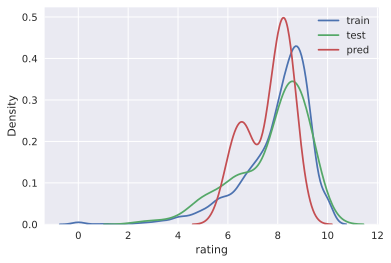

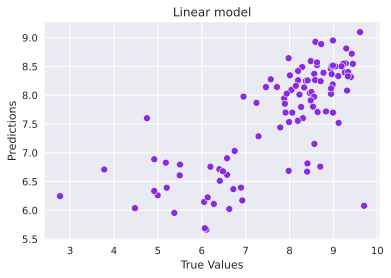

In [110]:
target_distr_linear(y_train, y_test, y_pred)

IMP: [5.00767936e+00 2.01094789e+00 8.31857818e+00 6.08803060e-01
 4.40840064e-02 3.23758688e-01 4.32190029e-01 7.84524272e+00
 0.00000000e+00 0.00000000e+00 4.09396070e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.15411951e-02 0.00000000e+00 0.00000000e+00 6.26214027e-01]


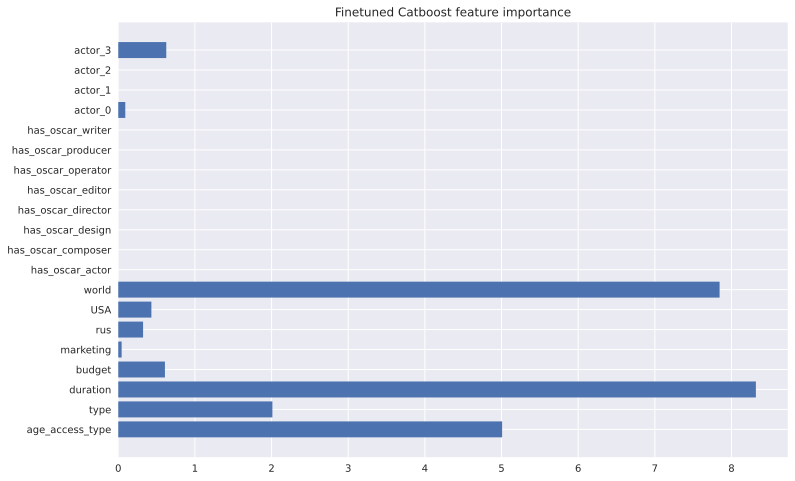

In [111]:
get_feature_imp(best_cat, train_dataset)

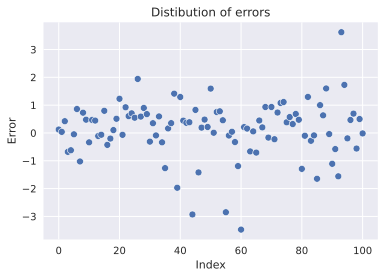

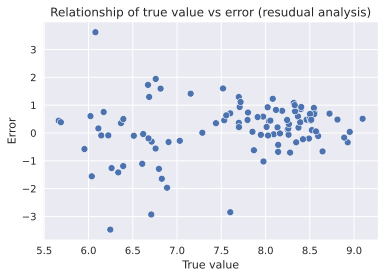

In [112]:
errors = y_test - y_pred
draw_res_analys(errors, y_pred)

In [113]:
calc_metrics(y_test, y_pred)

*** VAL **: 
MSE:   0.9971671059284718
RMSE:  0.998582548379688
R2:    0.5273683267381797
MAE:   0.719874374349256
MedAE: 0.5484715936493956
------------------------------


In [114]:
test_df['PREDS_tune'] = y_pred.tolist()
test_df

age_access_type                             name    type  release_year  \
10401               16                    Темное сердце  SERIAL          2022   
10439               18  Жена путешественника во времени  SERIAL          2022   
10435               18                    Хроники пышки  SERIAL          2022   
10457               18                 Бесконечная ночь  SERIAL          2022   
10438               18                        Репетиция  SERIAL          2022   
...                ...                              ...     ...           ...   
3110                16                          Код 355   MOVIE          2022   
2868                12                    Лулу и Бриггс   MOVIE          2022   
2805                16                  Побег из Африки   MOVIE          2022   
3885                18        Крепость 2: Глаз снайпера   MOVIE          2022   
10488                6                   Истоки футбола  SERIAL          2022   

        duration                           element_uid     budget  marketing  \
10401  16.368076  2372e695-5fff-4c68-91c7-73bce33fc9b1        NaN        NaN   
10439  16.626117  7becd8d8-1fb8-4ee6-b903-47817686ddd8        NaN        NaN   
10435  16.558928  17f245d4-d2d2-46de-a974-d7cd427ad1b6        NaN        NaN   
10457  16.200597  952bfe32-7504-4ef5-af22-985379d8637f        NaN        NaN   
10438  16.233209  753d822a-1890-4445-ab54-fe65c900e3fa        NaN        NaN   
...          ...                                   ...        ...        ...   
3110   15.806121  58934f4f-bec0-45db-a8a2-ab90d911a612  18.132999        NaN   
2868   15.617221  1504acff-36a2-4886-b37e-b4a96d51d3f6        NaN        NaN   
2805   15.490736  581115c5-1a7e-466d-9d11-fdd8d128d669  12.388398        NaN   
3885   15.587067  d580669b-3774-4091-8d78-f8cbdf02f8e0        NaN        NaN   
10488  17.518293  6dd86e60-5d6d-475d-9b46-e989ac7a30b6        NaN        NaN   

             rus         USA  ...          producer_4         writer_0  \
10401        NaN         NaN  ...  Каролин Ландерберг  Оскар Сёдерлунд   
10439        NaN         NaN  ...       Стивен Моффат    Стивен Моффат   
10435        NaN         NaN  ...        Ева Лонгория        Шон Уайнс   
10457        NaN         NaN  ...          Лоран Анон      Давид Перро   
10438        NaN         NaN  ...         Рэйчел Хейн    Нэйтан Филдер   
...          ...         ...  ...                 ...              ...   
3110   13.114567  14570455.0  ...        Ричард Хьюит   Ребека Ф. Смит   
2868   15.155431  61778069.0  ...    Грегори Джейкобс    Ченнинг Татум   
2805         NaN         NaN  ...                  Na         Тед Бетц   
3885         NaN         NaN  ...         Луильо Руис    Алан Хорснэйл   
10488        NaN         NaN  ...                  Na         Ши Чуань   

               writer_1  country_0                               genre_0  \
10401   Эрик Хультквист    denmark                              Thriller   
10439  Одри Ниффенеггер        usa                                Sci-Fi   
10435  Мэттью Клэйбрукс        usa                                Comedy   
10457  Эммануэль Вуазен    belgium  9fa28b61-a257-4a3e-945b-a9ef76a146d6   
10438      Кэрри Кемпер        usa                                Comedy   
...                 ...        ...                                   ...   
3110       Тереза Ребек        usa                                Action   
2868      Андреа Дзирио        usa                                Comedy   
2805                 Na        usa                             Adventure   
3885         Эмиль Хирш        usa                                Action   
10488                Na      china  287a1485-7a88-4c2f-bc94-ca418b6c47a1   

         genre_1                               genre_2     PREDS    TARGET  \
10401      Drama  364fdc2e-bdfe-40be-b2c5-d30f43ec432e  8.386446  8.372093   
10439  Melodrama                                 Drama  9.044988  8.990000   
10435     Family                     